## Camera Selection

In [1]:
import scipy.io as spio
#from __future__ import print_function

import numpy as np
import os
from ttictoc import TicToc

from IPython.display import clear_output
from IPython import display

import matplotlib.pyplot as plt
#import cv2 as cv
%matplotlib inline

In [2]:
import string
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.distributions import Categorical
import time, math
 
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

use_cuda = torch.cuda.is_available()

if use_cuda:
    print ('CUDA is available')
#use_cuda=False   #uncomment this if you dont want to use cuda variables

CUDA is available


In [3]:
import sys
import os
import gc
import collections
import hickle as hkl

sys.path.insert(0, '../data/')
import get_pid_train_test as db
import auxiliary as af

In [4]:
#sys.path.insert(0,'../py-MDNet/modules')
#from sample_generator import *

### Initialize hyper-parameters

In [5]:
learning_rate = 1e-4
batch_size = 500
replay_memory_size = 4000
#epsilon = 0.1
gamma = 0.95

resume = False # resume from previous checkpoint?
render = False
eps = np.finfo(np.float32).eps.item()


In [6]:
# load dataset
db_no = 4
[pALL,num_camera,alltime,fps] = db.get_pid(set_no=db_no, train_flag='train')
num_camera += 1  # occlusion is also considered as a FOV
fpsc = 2
pALL = np.array(pALL)

# load test set for current data set
[pTest,num_camera,alltime,fps] = db.get_pid(set_no=db_no, train_flag='test')
num_camera += 1  # occlusion is also considered as a FOV
fpsc = 2
pTest = np.array(pTest)

Total number of person in data set:  (1, 49)
Total number of person in data set:  (1, 49)


In [7]:
numEpoch = 100000
d = 10
region_size = (d,d)

h_len = 100
input_size = h_len*(num_camera) + num_camera+4+1

# Load auxiliary functions using an object
afc = af.AuxiliaryFunction(num_camera=num_camera, d=d, h_len=h_len)

### Model

In [8]:
# Initialize required parameters
hidden_size1 = 4096+2048
hidden_size2 = 2048+1024
hidden_size3 = 256+256

# Required network
class NextCamera(nn.Module):
    def __init__(self):
        super(NextCamera, self).__init__()
        
        # make decoder layers
        self.fch1 = nn.Linear(input_size, hidden_size1)
        self.fch2 = nn.Linear(hidden_size1, hidden_size2)
        self.fch3 = nn.Linear(hidden_size2, hidden_size3)
        #self.fch4 = nn.Linear(hidden_size3, hidden_size4)
        self.fco = nn.Linear(hidden_size3, num_camera)
        self.dropout = nn.Dropout(p=0.3)
        
        # Activation function 
        #self.tanh = nn.Tanh() #ReLU()
        self.relu = nn.ReLU() #ReLU()
        #self.linear = nn.Linear() 
        
    def forward(self, x):
        
        x = self.relu(self.fch1(x))
        x = self.relu(self.fch2(x))
        x = self.dropout(x)
        x = self.relu(self.fch3(x))
        x = self.dropout(x)
        #x = self.relu(self.fch4(x))
        #x = self.dropout(x)
        x = self.fco(x)
            
        return x # nn.functional.softmax(x)

In [9]:
# build the model
if use_cuda:
    policy_net = NextCamera().cuda()
    policy_net.float().cuda()
    criterion = nn.MSELoss().cuda()
else:
    policy_net = NextCamera()
    policy_net.float()
    criterion = nn.MSELoss()
# use ADAM as optimizer since we can load the whole data to train
#cls_weights = [1.0,1.0,1.0,1.0,0.1 ]
#cls_weights = torch.FloatTensor(cls_weights).cuda()
#criterion = nn.CrossEntropyLoss(weight=cls_weights)
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

In [10]:
def backward_network(replay_memory):
    # sample random minibatch
    minibatch = random.sample(replay_memory, min(len(replay_memory), batch_size))
    
    # unpack minibatch
    state = torch.cat(tuple(d[0] for d in minibatch))
    action = torch.cat(tuple(d[1] for d in minibatch))
    reward = torch.cat(tuple(d[2] for d in minibatch))
    next_state = torch.cat(tuple(d[3] for d in minibatch))
    nSteps_boot = tuple(d[4] for d in minibatch)
    
    #print (state.size(), next_state.size(), reward.size(), action.size())

    if use_cuda:  # put on GPU if CUDA is available
        state = state.cuda()
        action = action.cuda()
        reward = reward.cuda()
        next_state = next_state.cuda()

    # get output for the next state
    next_output = policy_net(next_state)

    # set y_j to r_j for terminal state, otherwise to r_j + gamma*max(Q)
    y = torch.cat(tuple(reward[i] if minibatch[i][4]
                              else reward[i] + (gamma**(nSteps_boot[i])) * torch.max(next_output[i])
                              for i in range(len(minibatch))))

    # extract Q-value
    q_value = torch.sum(policy_net(state) * action, dim=1)

    # PyTorch accumulates gradients by default, so they need to be reset in each pass
    optimizer.zero_grad()

    # returns a new Tensor, detached from the current graph, the result will never require gradient
    y = y.detach()

    #print (y, q_value)
    # calculate loss
    loss = criterion(q_value, y)

    # do backward pass
    loss.backward()
    optimizer.step()
    
    return loss.data


### Testing functions

In [11]:
# Test function
def plot_current_state(ped, c,fno):
    # load image for current location
    img,bb = load_image(ped,c,fno,db_no)

    dpi = 80.0
    #figsize = (img.size[0]/dpi, img.size[1]/dpi)
    figsize = (img.shape[0]/dpi, img.shape[1]/dpi)
    fig = plt.figure(frameon=False, figsize=figsize, dpi=dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)

    # get image and rect handle
    imAX = ax.imshow(img, aspect='normal')
    rect = plt.Rectangle(tuple(bb[0,:2]),bb[0,2],bb[0,3], 
        linewidth=3, edgecolor="#ff0000", zorder=1, fill=False)
    ax.add_patch(rect)

    plt.pause(.01)
    plt.draw()
    #fig.savefig(os.path.join(savefig_dir,'0000.jpg'),dpi=dpi)
    
    return imAX, rect
    
def plot_second(ped,c,curr_frame, imAX,rect):
    img,bb =  load_image(ped,c,curr_frame,db_no)
    #if np.array(img).shape[0] > 0:
    if img != []:
        imAX.set_data(img)
    #print (bb)

    #if bb.shape[0] > 0:
    if bb != []:
        rect.set_xy(bb[0,:2])
        rect.set_width(bb[0,2])
        rect.set_height(bb[0,3])
        print ('Correct camera')
    elif c!= num_camera-1:
        print ('Wrong camera')

    
    display.display(plt.gcf())
    plt.pause(1)
    plt.draw()
    #fig.savefig(os.path.join(savefig_dir,'%04d.jpg'%(i)),dpi=dpi)

def get_reward_gt(ped, curr_frame, c):
    y = afc.find_target_camera(ped,curr_frame)
    # get reward (give reward at end of episode)
    if y == num_camera-1 and y == c:
        reward = 0.1
    elif y == c:
        reward = 1
    else:
        reward = -1
        
    return reward,y

def get_next_step(ped,c,curr_frame, state):
    # update current state and history
    ispresent,this_state = get_state_vector(ped, c,curr_frame)
    if ispresent:
        next_state = this_state
    else:
        # use previous state
        next_state = state
    
    # get correct label from ground truth
    reward,y = get_reward_gt(ped, curr_frame,c)

    return next_state,reward,y,ispresent

def test_func(pTest, iloc='first', eloc='last', fixLoc=-1, isdebug=0, req_inc=1):
    policy_net.eval()
    rsT,accT = [],[]
    
    for p in range(pTest.shape[0]): 
        reward_sum = 0
        accP = []
        inc = 1
        
        # load p'th person data
        ped = np.copy(pTest[p])
        # camera index and frame index starts from zero
        ped[:,0] -= 1
        ped[:,1] -= 1
        
        # Initialize with current state with start frame
        if iloc == 'first':
            startIDX = 0
        elif iloc == 'rand':
            startIDX = np.random.randint( 0,ped.shape[0]-20 )
        elif iloc == 'fix':
            startIDX = fixLoc
        myPos = ped[startIDX,0:]
        print ('Initial position: ',myPos)
        
        curr_camera = myPos[0]
        curr_frame = myPos[1]
        
        # Initialize history variable (one-hot encoding)
        ch = np.zeros((h_len,num_camera))
        ch[:,curr_camera] = 1
        occ_len = 0.0001
        # Make initial state
        _,state,rt = make_state_vector(ped, curr_camera,curr_frame, ch,occ_len)
        #print (state.size())
        num_steps = 0
        #prev_camera = curr_camera
        count_curr_c = 0
        
        if render: # show current location
            plot_current_state(ped, curr_camera,curr_frame)

            display.clear_output(wait=True)
            display.display(plt.gcf())


        while(curr_frame <= ped[-1,1]): # alltime-6):
            if use_cuda:
                state_in = Variable(state)
                value_c = policy_net(state_in)
            else:
                state_in = Variable(state)
                value_c = policy_net(state_in)
                
            # Only exploitation for testing
            camera_index = torch.argmax(value_c)
            c = camera_index.detach().cpu().numpy()

            # find target for the next frame
            curr_frame += fpsc
            num_steps += 1
            
            # get correct label from ground truth
            reward,y = get_reward_gt(ped, curr_frame,c)
            if req_inc:
                if inc==1 and y!=num_camera-1:
                     # inside a camera
                    accP.append((y,y))
                elif inc==0 and y==c.item(0) and y!=num_camera-1:
                    # transitioning to second camera
                    accP.append((y,c.item(0)))
                    inc = 1
                elif inc==1 and y==num_camera-1:
                    # moving out of a camera FOV
                    inc = 0
                    accP.append((y,c.item(0)))
                else:
                    # Making transition
                    accP.append((y,c.item(0)))
                    #print ('Another case',y,c.item(0))
                    
            else:
                    accP.append((y,c.item(0)))
            
            # get the current bounding box
            bbox = ped[ np.logical_and(ped[:,0]==c,ped[:,1]==curr_frame),2:]
            if bbox.shape[0] > 0: # and np.random.rand < 0.95:
                bbox = bbox[0]
                rt = np.zeros((4))
                rt[0] = bbox[0]/320
                rt[1] = bbox[1]/240
                rt[2] = bbox[2]/320
                rt[3] = bbox[3]/240
                curr_camera = c
                
                ispresent = 1
                
            else:
                ispresent = 0
                
            # count the time of prev_camera selection
            if ispresent:
                occ_len = 0.0001
            else:
                occ_len += fpsc
            if occ_len > occ_max_val:
                occ_len = occ_max_val+1
                
            #hcount = np.array(-2 + (occ_len/occ_max_val)*(2-(-2)))
            hcount = occ_len #np.array(np.log(occ_len))
            # update current state and history
            ch[1:,] = ch[0:-1,]
            ch[0,0:] = afc.make_one_hot_camera(c)
                
            if isdebug:
                print ('x_t: ', curr_camera,rt)
                print ( np.where(ch))
                print ('Q values: ', value_c)
                print (c, curr_frame, hcount)
                print ('isPresent', ispresent)
                print ('')
            
            # get next camera using policy network
            this_cam = np.zeros((num_camera+1))
            this_cam[0:num_camera] = afc.make_one_hot_camera(curr_camera)
            this_cam[num_camera] = hcount
            # make next_state vector
            next_state = np.concatenate((this_cam, rt.ravel()))
            #next_state = np.concatenate((next_state, hcount)) #.ravel()))
            next_state = np.concatenate((next_state, ch.ravel()))
            if use_cuda:
                next_state = torch.from_numpy(next_state.astype(np.float32)).unsqueeze(0).cuda()
            else:
                next_state = torch.from_numpy(next_state.astype(np.float32)).unsqueeze(0)
                
            # get next state
            #next_state,reward,y,ispresent = get_next_step(ped,c,curr_frame, state)
            
            # store current reward
            reward_sum += reward
                        
            state = next_state
            prev_camera = c
            
            if render:
                plot_second()
            if eloc != 'last':
                if num_steps > eloc:
                    break
            
        # stack episodic reward 
        rsT.append((reward_sum,num_steps))
        accT.append(accP)
        
    return rsT, accT

### Run episodes

In [12]:
reward_sum = 0
running_reward = None
xs,rs,cprs = [],[],[]
episode_number = 0
episode_durations = []
episode_reward = []
validation_reward= []
replay_memory = []
M = np.zeros((num_camera,num_camera))

In [13]:
# Load model if required
resume = False
backup_fname = './models/Q_db4_xywh_10log'
if resume:
    policy_net = torch.load(backup_fname)
    policy_net.eval()
    print ('Model loaded')
    #episode_reward,running_reward = hkl.load(backup_fname+'_variables.hkl')
    print ('episodic reward loaded')

In [14]:
def make_state_vector(ped, curr_camera,curr_frame, ch,occ_len):
    numSamples = 30
    overlap_thres = [0.9, 1]
        
    # read image
    img,bbox,p = afc.load_image(ped,curr_camera,curr_frame,db_no)
    imw, imh = (320,240) #img.size
    #print (img.size)
    #hc = np.array(-occ_max_val + (occ_len/500)*(occ_max_val-(-occ_max_val)))
    #hc = np.array(-2 + (occ_len/occ_max_val)*(2-(-2)))
    hc = occ_len #np.array(np.log(occ_len))
    
    if p:
        ## Draw samples
        #examples = gen_samples(SampleGenerator('gaussian', img.size, 0.1, 1.2),
        #                       bbox, numSamples, overlap_thres)  # 50 samples with 0.8 overlap
        ##print (examples.shape)
        #samples = examples[np.random.randint(len(examples))].reshape(1,4)
        ##print (samples)
        ##rt = afc.find_curr_rt(samples[0])
        #bbox = samples[0]
        rt = np.zeros((4))
        rt[0] = bbox[0]/imw
        rt[1] = bbox[1]/imh
        rt[2] = bbox[2]/imw
        rt[3] = bbox[3]/imh
        #print (np.where(rt.ravel()))
        
        # make next_state vector
        this_cam = np.zeros((num_camera+1))
        this_cam[0:num_camera] = afc.make_one_hot_camera(curr_camera)
        this_cam[num_camera] = hc
        state = np.concatenate((this_cam, rt.ravel()))
        #state = np.concatenate((state, hc)) #.ravel()))
        state = np.concatenate((state, ch.ravel()))
        state = state.reshape(1,-1)
        
        if use_cuda:
            state = torch.from_numpy(state).float().cuda()
        else:
            state = torch.from_numpy(state).float()
    else:
        print ('Target is not present in ',c,curr_frame)
        state = []
    
    return p,state,rt

def append_reward(rs,num_steps):
    if len(rs) > 0:
        # stack episodic reward 
        epR = np.vstack(rs)
        rs = []

        # append the episodic reward
        #episode_number += 1
        #episode_durations.append(num_steps)
        reward_stat = [num_steps,np.std(epR),np.sum(epR)]
        episode_reward.append(reward_stat)
    
    return rs


In [15]:
epoch = 0
occ_max_val = 50
NBoot = 50
t = TicToc('episodic')
t.tic()

In [16]:
policy_net.train()
max_ep_len = 200

while epoch < numEpoch:
#for epoch in range(numEpoch):
    # repeat for all pedestrians
    #disp(pALL)
     
    for p in range(pALL.shape[0]): #range(pInLoop.shape[0])
        
        # load p'th person data
        ped = np.copy(pALL[p])

        # camera index and frame index starts from zero
        ped[:,0] -= 1
        ped[:,1] -= 1
        #print (np.unique(ped[:,0]))
        
        # check if camera number is correct
        if (ped[:,0] >= num_camera).any():
            print ('Error in person ', p)
            break
            
        if ped.shape[0] < 2*max_ep_len:
            continue
        
        # select a camera uniformly
        uniq_cam = np.unique(ped[:,0])
        if len(uniq_cam) < 2: # and np.random.rand() < 0.9:
            continue
        rand_cam = uniq_cam[np.random.randint(len(uniq_cam))]
        index_of_rand_cam = np.nonzero( ped[:,0]==rand_cam )[0]
        len_indices_rand_cam = len(index_of_rand_cam)
        
        # Initialize with current state with start frame
        #tranIDX = np.where(ped[1:,0]-ped[0:-1,0])[0]
        #startIDX = np.random.choice(tranIDX) if np.random.rand(1) < 0.6 else np.random.randint( 0,ped.shape[0]-max_ep_len )
        startIDX = index_of_rand_cam[np.random.randint(len_indices_rand_cam)]
        print ('startIDX: ',startIDX)
        myPos = ped[startIDX,0:]
        #print (myPos)
        
        curr_camera = myPos[0]
        curr_frame = myPos[1]
        tmp_ep = []
        rs = []
        
        # Initialize history variable (one-hot encoding)
        ch = np.zeros((h_len,num_camera))
        ch[:,curr_camera] = 1
        
        # initialize total time target was occluded
        num_steps = 0
        occ_len = 0.0001
        
        # create initial state (ct,rt,tau_t)
        #bbox = myPos[2:]
        #rt = afc.find_curr_rt(bbox)
        _,state,rt=make_state_vector(ped, curr_camera,curr_frame,ch,occ_len)
        stCam = curr_camera
        count_curr_c = 0
        prev_camera = curr_camera

        if render: # show current location
            plt.imshow(x.reshape(input_size))
            display.clear_output(wait=True)
            display.display(plt.gcf())
                       
        while(curr_frame <= ped[-1,1]):
            
            if use_cuda:
                state_in = Variable(state)
                value_c = policy_net(state_in)
            else:
                state_in = Variable(state)
                value_c = policy_net(state_in)
            
            # epsilon annealing
            epsilon = 1 / np.log(epoch + 0.0000001)
                 
            # initialize action
            one_hot_action = torch.zeros([num_camera], dtype=torch.float32)
            if use_cuda:  # put on GPU if CUDA is available
                one_hot_action = one_hot_action.cuda()

            # epsilon greedy exploration
            random_action = np.random.random() <= epsilon
            camera_index = [torch.randint(num_camera, torch.Size([]), dtype=torch.int)
                            if random_action
                            else torch.argmax(value_c)][0]

            if use_cuda:  # put on GPU if CUDA is available
                camera_index = camera_index.cuda()

            one_hot_action[camera_index] = 1
            one_hot_action = one_hot_action.unsqueeze(0)
            c = camera_index.detach().cpu().numpy()
            
            # generate random steps
            if np.random.rand(1) < 0.2:
                rsteps = np.random.randint(5)
            else:
                rsteps = fpsc
            
            # find target for the next frame
            curr_frame += rsteps #fpsc
            num_steps += 1
            M[stCam,c] += 1
            
            # get the current bounding box
            bbox = ped[ np.logical_and(ped[:,0]==c,ped[:,1]==curr_frame),2:]
            if bbox.shape[0] > 0:
                #rt = afc.find_curr_rt(bbox[0]) 
                bbox = bbox[0]
                rt = np.zeros((4))
                rt[0] = bbox[0]/320
                rt[1] = bbox[1]/240
                rt[2] = bbox[2]/320
                rt[3] = bbox[3]/240
                #print (rt, np.where(rt))
                curr_camera = c
                #ch = np.zeros((h_len,num_camera))
                #num_steps = 0
                ispresent = 1
                stCam = c
            else:
                ispresent = 0
                
            # count the time of prev_camera selection
            if ispresent:
                occ_len = 0.0001
            else:
                occ_len += rsteps
            if occ_len > occ_max_val:
                occ_len = occ_max_val+1
            #hcount = np.array(-occ_max_val + (occ_len/500)*(occ_max_val-(-occ_max_val)))
            hcount = occ_len #np.array(np.log(occ_len))
            #hcount = np.array(-2 + (occ_len/occ_max_val)*(2-(-2)))
            
            # update current state and history
            ch[1:,] = ch[0:-1,]
            ch[0,0:] = afc.make_one_hot_camera(c)
            
            # get next camera using policy network
            this_cam = np.zeros((num_camera+1))
            this_cam[0:num_camera] = afc.make_one_hot_camera(curr_camera)
            this_cam[num_camera] = hcount
            # make next_state vector
            next_state = np.concatenate((this_cam, rt.ravel()))
            #next_state = np.concatenate((next_state, hcount)) #.ravel()))
            next_state = np.concatenate((next_state, ch.ravel()))

            if use_cuda:
                next_state = torch.from_numpy(next_state.astype(np.float32)).unsqueeze(0).cuda()
            else:
                next_state = torch.from_numpy(next_state.astype(np.float32)).unsqueeze(0)
                
            # get correct label from ground truth
            y = afc.find_target_camera(ped, curr_frame)
            # get reward (give reward at end of episode)
            if y == num_camera-1 and y == c:
                reward = 0.1
            elif y == c:
                reward = 1
            else:
                reward = -1
                 
            if np.random.rand() < 0.2 and epoch > 50000:
                print (epoch, p, random_action, rsteps)
                print ('x_t: ', curr_camera,rt)
                #print ( np.where(ch))
                print ('Q values: ', value_c)
                print (y,c, curr_frame, num_steps, hcount)
                print ('isPresent', ispresent)
                print ('')
                
            reward_sum += reward
            rs.append(reward)
                
            # save transition to replay memory
            tmp_ep.append((state, one_hot_action, reward, next_state, ispresent))
            
            state = next_state
            
            if num_steps >= max_ep_len and c!=num_camera-1 and y == c:  # break the episode
                #replay_memory.append((state, one_hot_action, reward, next_state, ispresent))
                print (epoch, p, random_action)
                print ('x_t: ', curr_camera,rt)
                #print ( np.where(ch)[1])
                print ('Q values: ', value_c)
                print (y,c, curr_frame, num_steps, hcount)
                print ('isPresent', ispresent)
                print ('')
                
                # Append to the experience buffer
                for tmp_i in range(0,len(tmp_ep)):
                    this_tmp = tmp_ep[tmp_i]
                    # compute n-step return
                    rew = 0
                    for ni in range(NBoot):
                        if (tmp_i+ni) < len(tmp_ep):
                            rew += rs[tmp_i+ni]*(gamma**ni)
                    if use_cuda:
                        reward = torch.from_numpy(np.array([rew], dtype=np.float32)).unsqueeze(0).cuda()
                    else:
                        reward = torch.from_numpy(np.array([rew], dtype=np.float32)).unsqueeze(0)
                    # get the next state
                    next_state = tmp_ep[np.min([tmp_i+NBoot-1,len(tmp_ep)-1])]
                    next_state = next_state[3]
                    
                    replay_memory.append((this_tmp[0],this_tmp[1],reward,next_state,np.min([NBoot,len(tmp_ep)-tmp_i])))
                    if len(replay_memory) > replay_memory_size:
                        replay_memory.pop(0)
                tmp_ep = []
                break
        
        # update value_function
        if len(replay_memory) > 0:
            loss = backward_network(replay_memory)
        
        # store episodic reward
        rs = append_reward(rs,num_steps)
        
        # boring book-keeping
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        if epoch % 2 == 0:
            print ('ep %d: ep_len:%d episode reward: total was %f. running mean: %f' % (epoch, num_steps, reward_sum, running_reward))
        #if epoch % 1000 == 1: 
        #    torch.save(policy_net, backup_fname)
        #    #hkl.dump([[episode_reward,validation_reward, running_reward]], backup_fname+'_variables.hkl')
            
        reward_sum = 0
        num_steps = 0
        rs = []
        
    #print (M)
    epoch += 1
    if epoch % 10 == 0:
        t.toc()
        print('Time elapsed: ', t.elapsed)
        

startIDX:  2240
0 0 False
x_t:  3 [0.071875   0.2375     0.071875   0.24166667]
Q values:  tensor([[ 0.0110,  0.0003, -0.1086,  0.0919, -0.0979,  0.0022]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26095 1595 0.0001
isPresent 1

ep 0: ep_len:1595 episode reward: total was -825.300000. running mean: -825.300000
startIDX:  122
0 1 False
x_t:  2 [0.003125   0.375      0.096875   0.42916667]
Q values:  tensor([[-0.4624, -0.3660,  0.0528, -0.2998, -0.2622, -1.0969]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27430 908 0.0001
isPresent 1

ep 0: ep_len:908 episode reward: total was -892.000000. running mean: -825.967000
startIDX:  312
0 5 False
x_t:  1 [0.875   0.2875  0.11875 0.375  ]
Q values:  tensor([[-0.8738, -0.8102, -1.0183, -0.9326, -0.8135, -1.8591]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5025 724 0.0001
isPresent 1

ep 0: ep_len:724 episode reward: total was -646.000000. running mean: -824.167330
startIDX:  1196
0 10 False
x_t:  3 [0.0625     0.2

4 10 True
x_t:  1 [0.775      0.29166667 0.1375     0.325     ]
Q values:  tensor([[-10.6228, -12.9155, -10.2937, -10.9290, -13.7397, -12.1347]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22480 1204 0.0001
isPresent 1

ep 4: ep_len:1204 episode reward: total was -926.400000. running mean: -761.163955
startIDX:  858
4 12 True
x_t:  1 [0.83125    0.35833333 0.165625   0.5125    ]
Q values:  tensor([[-12.2007, -13.2216, -13.1608, -14.0592, -13.6551, -12.0063]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12914 654 0.0001
isPresent 1

ep 4: ep_len:654 episode reward: total was -490.800000. running mean: -758.460315
startIDX:  472
4 15 True
x_t:  1 [0.790625   0.30416667 0.0875     0.2625    ]
Q values:  tensor([[-12.5262, -10.6940, -10.9346, -10.1397,  -9.9861,  -9.6161]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5182 741 0.0001
isPresent 1

ep 4: ep_len:741 episode reward: total was -585.600000. running mean: -756.731712
startIDX:  2627
4 22 False
x_t:  4 [

ep 8: ep_len:1262 episode reward: total was -856.000000. running mean: -686.413632
startIDX:  2168
9 0 True
x_t:  1 [0.85       0.30416667 0.146875   0.54166667]
Q values:  tensor([[-12.1369, -11.8629, -12.3076, -11.8519, -10.2625, -10.9357]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22920 1103 0.0001
isPresent 1

startIDX:  7
9 1 True
x_t:  3 [0.640625   0.28333333 0.09375    0.39583333]
Q values:  tensor([[-7.7990, -8.1201, -5.5203, -7.4232, -7.5588, -7.1301]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 25664 200 0.0001
isPresent 1

startIDX:  967
9 5 False
x_t:  3 [0.696875   0.3        0.15       0.40416667]
Q values:  tensor([[-13.0593, -12.4005, -11.3528, -11.1549, -12.7281, -12.0068]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10501 220 0.0001
isPresent 1

startIDX:  2484
9 10 True
x_t:  1 [0.803125   0.27916667 0.11875    0.34166667]
Q values:  tensor([[ -9.9498, -10.6601, -12.3118, -10.8633, -11.6161, -10.7210]],
       device='cuda:0', grad_fn

13 10 False
x_t:  3 [0.15625    0.2375     0.059375   0.26666667]
Q values:  tensor([[-8.2207, -7.8950, -7.9014, -7.2968, -7.9852, -7.7595]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5161 201 0.0001
isPresent 1

startIDX:  1731
13 12 True
x_t:  1 [0.0375     0.37083333 0.1375     0.35416667]
Q values:  tensor([[ -9.2914,  -8.0767, -10.7021, -11.2157, -10.1087,  -7.8987]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19875 205 0.0001
isPresent 1

startIDX:  3071
startIDX:  100
13 22 False
x_t:  1 [0.790625   0.3        0.096875   0.40416667]
Q values:  tensor([[ -9.6226,  -8.2581, -10.2484,  -9.8411,  -9.5904,  -8.4231]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1588 680 0.0001
isPresent 1

startIDX:  12
14 0 True
x_t:  1 [0.7875     0.30416667 0.109375   0.42083333]
Q values:  tensor([[-10.3532, -10.1983, -10.1114, -10.3561, -10.4899,  -8.7671]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1619 753 0.0001
isPresent 1

ep 14: ep_len:753 episode r

startIDX:  481
18 0 False
x_t:  3 [0.821875   0.40416667 0.175      0.41666667]
Q values:  tensor([[-17.0499, -17.7606, -19.7635, -14.4106, -18.1976, -18.7608]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 6992 1025 0.0001
isPresent 1

ep 18: ep_len:1025 episode reward: total was -815.700000. running mean: -524.556170
startIDX:  1020
18 1 True
x_t:  3 [0.815625   0.3        0.09375    0.41666667]
Q values:  tensor([[-14.8762, -11.8726, -15.0100, -15.1184, -16.0692, -13.6927]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35906 216 0.0001
isPresent 1

ep 18: ep_len:216 episode reward: total was -119.300000. running mean: -520.503609
startIDX:  2015
18 5 False
x_t:  3 [0.1375     0.25416667 0.1125     0.325     ]
Q values:  tensor([[-13.9359, -15.2118, -14.4277, -13.3777, -15.5414, -13.6771]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18222 1243 0.0001
isPresent 1

ep 18: ep_len:1243 episode reward: total was -948.400000. running mean: -524.782573
startIDX:  6

ep 22: ep_len:422 episode reward: total was -148.500000. running mean: -442.898541
startIDX:  678
22 5 False
x_t:  3 [0.146875   0.27083333 0.11875    0.33333333]
Q values:  tensor([[-5.3215, -4.5684, -3.8151, -3.1858, -4.7687, -3.2760]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8774 1354 0.0001
isPresent 1

ep 22: ep_len:1354 episode reward: total was -374.000000. running mean: -442.209556
startIDX:  1622
22 10 False
x_t:  3 [0.521875   0.2875     0.075      0.34583333]
Q values:  tensor([[-4.8770, -5.5608, -5.2941, -3.7169, -5.3384, -4.1863]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16454 303 0.0001
isPresent 1

ep 22: ep_len:303 episode reward: total was -52.300000. running mean: -438.310460
startIDX:  1488
22 12 False
x_t:  2 [0.003125   0.4125     0.10625    0.28333333]
Q values:  tensor([[-5.2299, -4.6372, -3.5847, -5.8521, -5.0846, -4.3443]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19380 777 0.0001
isPresent 1

ep 22: ep_len:777 episode rewa

ep 26: ep_len:207 episode reward: total was -180.800000. running mean: -458.165168
startIDX:  6
26 10 True
x_t:  3 [0.078125   0.24166667 0.071875   0.2625    ]
Q values:  tensor([[-14.4723, -13.8183, -14.8579, -12.7890, -10.8712, -13.0422]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3587 1104 0.0001
isPresent 1

ep 26: ep_len:1104 episode reward: total was -914.100000. running mean: -462.724516
startIDX:  1782
26 12 False
x_t:  0 [0.89375    0.40416667 0.05625    0.36666667]
Q values:  tensor([[-13.3128, -17.3256, -20.4082, -15.2862, -15.2271, -13.7667]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21096 585 0.0001
isPresent 1

ep 26: ep_len:585 episode reward: total was -470.500000. running mean: -462.802271
startIDX:  184
26 15 True
x_t:  2 [0.26875    0.39166667 0.0625     0.34583333]
Q values:  tensor([[-11.8332, -15.4048, -14.5419, -16.2539, -11.2736, -15.1020]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2226 841 0.0001
isPresent 1

ep 26: ep_len:84

30 15 False
x_t:  2 [0.83125  0.4      0.059375 0.2625  ]
Q values:  tensor([[-4.9695, -5.7163, -3.7364, -6.1474, -5.7563, -4.2405]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15563 364 0.0001
isPresent 1

ep 30: ep_len:364 episode reward: total was -182.900000. running mean: -408.589059
startIDX:  463
30 22 True
x_t:  4 [0.003125   0.425      0.096875   0.35833333]
Q values:  tensor([[-4.0577, -6.7867, -4.5492, -6.2962, -6.6509, -4.6176]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 6656 855 0.0001
isPresent 1

ep 30: ep_len:855 episode reward: total was -375.200000. running mean: -408.255168
startIDX:  1580
31 0 True
x_t:  3 [0.80625    0.34583333 0.190625   0.42083333]
Q values:  tensor([[-4.0578, -7.2031, -4.9508, -6.9646, -5.2064, -5.5278]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16816 213 0.0001
isPresent 1

startIDX:  175
31 1 True
x_t:  2 [0.003125   0.375      0.165625   0.43333333]
Q values:  tensor([[-5.5926, -6.6562, -4.9660, -5.4234, -5.32

ep 34: ep_len:808 episode reward: total was -613.300000. running mean: -405.461922
startIDX:  1750
35 0 True
x_t:  2 [0.275      0.40416667 0.09375    0.25416667]
Q values:  tensor([[-16.0294, -15.5985, -13.7002, -13.5469, -11.7635, -14.5744]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18431 783 0.0001
isPresent 1

startIDX:  990
35 1 True
x_t:  3 [0.8375     0.30833333 0.15       0.41666667]
Q values:  tensor([[-15.7965, -16.6419, -12.1627, -14.6227, -12.3098, -15.2143]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35899 226 0.0001
isPresent 1

startIDX:  539
35 5 False
x_t:  2 [0.678125   0.40416667 0.10625    0.28333333]
Q values:  tensor([[-16.9154, -14.6724, -12.1116, -12.9078, -15.1152, -12.8540]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6056 496 0.0001
isPresent 1

startIDX:  1111
35 10 False
x_t:  2 [0.859375   0.38333333 0.075      0.26666667]
Q values:  tensor([[-16.1632, -16.6379, -13.2496, -14.2333, -14.3066, -14.6383]],
       device='cuda:

startIDX:  1356
39 5 True
x_t:  0 [0.93125    0.38333333 0.05625    0.34583333]
Q values:  tensor([[-2.5888, -4.3380, -4.2560, -3.7463, -5.0264, -2.4556]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13496 729 0.0001
isPresent 1

startIDX:  921
39 10 True
x_t:  1 [0.41875    0.30833333 0.06875    0.35833333]
Q values:  tensor([[-3.4800, -3.9507, -4.4459, -3.8771, -5.0590, -1.4373]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11390 1608 0.0001
isPresent 1

startIDX:  1402
39 12 False
x_t:  3 [0.671875   0.33333333 0.084375   0.41666667]
Q values:  tensor([[-1.5163, -1.4458, -1.1994, -0.3452, -1.3968, -1.3753]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17866 201 0.0001
isPresent 1

startIDX:  595
39 15 True
x_t:  1 [0.93125    0.29583333 0.05625    0.27916667]
Q values:  tensor([[-3.4141, -3.5762, -3.7187, -3.8428, -4.3920, -1.5676]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5163 681 0.0001
isPresent 1

startIDX:  1774
39 22 False
x_t:  3 [0.409

startIDX:  774
43 15 True
x_t:  2 [0.734375   0.40416667 0.08125    0.29166667]
Q values:  tensor([[-15.4682, -14.1232, -19.1083, -12.0755, -12.6139, -11.8178]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 5979 349 0.0001
isPresent 1

startIDX:  1658
43 22 False
x_t:  3 [0.878125   0.35416667 0.11875    0.40833333]
Q values:  tensor([[-13.7392,  -8.5787, -15.6102,  -6.8981, -12.0616,  -9.8506]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16842 219 0.0001
isPresent 1

startIDX:  269
44 0 False
x_t:  3 [0.078125   0.23333333 0.059375   0.2375    ]
Q values:  tensor([[-17.9682, -11.8995, -18.9747, -11.4757, -15.3633, -11.9185]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4840 1262 0.0001
isPresent 1

ep 44: ep_len:1262 episode reward: total was -941.400000. running mean: -389.304925
startIDX:  901
44 1 False
x_t:  4 [0.153125   0.375      0.090625   0.41666667]
Q values:  tensor([[-13.5523, -12.2323, -12.3941, -11.2959, -10.0720, -10.4127]],
       device='cud

startIDX:  157
48 0 True
x_t:  1 [0.86875    0.3        0.128125   0.42916667]
Q values:  tensor([[ -8.4233, -10.7906,  -8.8983,  -9.0716,  -9.8402,  -8.4776]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1607 683 0.0001
isPresent 1

ep 48: ep_len:683 episode reward: total was -190.400000. running mean: -373.332673
startIDX:  545
48 1 True
x_t:  1 [0.740625   0.275      0.096875   0.45416667]
Q values:  tensor([[-10.3967, -10.6052, -10.0115, -10.1117,  -9.9381,  -8.2832]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30698 741 0.0001
isPresent 1

ep 48: ep_len:741 episode reward: total was -209.600000. running mean: -371.695346
startIDX:  439
48 5 True
x_t:  1 [0.76875    0.28333333 0.13125    0.37916667]
Q values:  tensor([[-7.8292, -6.6169, -8.8875, -8.2103, -8.0488, -4.9498]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5038 669 0.0001
isPresent 1

ep 48: ep_len:669 episode reward: total was -153.700000. running mean: -369.515393
startIDX:  2242
48 10 True


ep 52: ep_len:725 episode reward: total was -151.000000. running mean: -314.447613
startIDX:  537
52 10 True
x_t:  2 [0.078125   0.39583333 0.096875   0.26666667]
Q values:  tensor([[-3.4439, -3.9740, -4.2008, -4.0217, -4.0284, -3.4768]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6598 762 0.0001
isPresent 1

ep 52: ep_len:762 episode reward: total was -211.900000. running mean: -313.422137
startIDX:  849
52 12 False
x_t:  1 [0.746875   0.35416667 0.15       0.50833333]
Q values:  tensor([[-3.8931, -3.7370, -4.6382, -4.4960, -4.6912, -3.7930]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12921 634 0.0001
isPresent 1

ep 52: ep_len:634 episode reward: total was -235.800000. running mean: -312.645916
startIDX:  1406
52 15 False
x_t:  3 [0.553125   0.29583333 0.115625   0.35      ]
Q values:  tensor([[-1.1979, -2.7535, -2.6352, -1.1966, -1.7893, -3.5255]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10386 200 0.0001
isPresent 1

ep 52: ep_len:200 episode reward

56 22 True
x_t:  1 [0.853125   0.30833333 0.134375   0.4625    ]
Q values:  tensor([[-11.0249,  -8.4982, -10.7550, -10.0546,  -8.0199,  -8.9557]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22934 1053 0.0001
isPresent 1

ep 56: ep_len:1053 episode reward: total was -549.500000. running mean: -327.577309
startIDX:  1833
57 0 False
x_t:  2 [0.00625    0.40833333 0.1125     0.24166667]
Q values:  tensor([[-12.7711,  -8.6576,  -7.5660,  -9.3469,  -8.2858,  -8.8191]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18394 738 0.0001
isPresent 1

startIDX:  920
57 1 True
x_t:  4 [0.078125   0.3875     0.153125   0.41666667]
Q values:  tensor([[ -9.8741, -10.0012,  -7.3915,  -7.7764,  -8.2433,  -7.2853]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35435 514 0.0001
isPresent 1

startIDX:  2417
57 5 True
x_t:  2 [0.003125   0.39583333 0.071875   0.27083333]
Q values:  tensor([[-9.4976, -6.7465, -7.0568, -6.9243, -8.0995, -4.5689]],
       device='cuda:0', grad_fn=<AddmmB

startIDX:  2268
61 10 False
x_t:  1 [0.678125   0.29583333 0.13125    0.32083333]
Q values:  tensor([[ -9.7384,  -9.3049, -12.0834, -10.1207, -11.9008,  -9.7447]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22490 1262 0.0001
isPresent 1

startIDX:  1395
61 12 True
x_t:  3 [0.68125    0.3375     0.078125   0.40833333]
Q values:  tensor([[-2.2097, -3.7603, -3.2266, -3.3144, -3.0887, -4.2104]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17865 200 0.0001
isPresent 1

startIDX:  2425
61 15 True
x_t:  4 [0.1625     0.4        0.09375    0.33333333]
Q values:  tensor([[-10.6506,  -9.0209,  -9.9632,  -9.1387, -10.6451,  -8.7107]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19273 500 0.0001
isPresent 1

startIDX:  1590
61 22 False
x_t:  3 [0.790625   0.34166667 0.125      0.4125    ]
Q values:  tensor([[-10.5770,  -9.7832,  -9.2342,  -8.9477, -11.3364,  -9.0854]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16855 268 0.0001
isPresent 1

startIDX:  966
62 0

startIDX:  44
65 15 True
x_t:  3 [0.75       0.35       0.13125    0.41666667]
Q values:  tensor([[-3.2482, -3.2510, -4.0431, -3.1614, -4.5760, -3.0968]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 532 234 0.0001
isPresent 1

startIDX:  1829
65 22 True
x_t:  2 [0.040625   0.4125     0.084375   0.25833333]
Q values:  tensor([[-3.9138, -3.8430, -4.3950, -3.8016, -5.2673, -3.1909]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18462 799 0.0001
isPresent 1

startIDX:  2266
66 0 True
x_t:  2 [0.625    0.4125   0.103125 0.25    ]
Q values:  tensor([[-3.8260, -3.1062, -4.1408, -4.2880, -5.5913, -2.7345]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23619 335 0.0001
isPresent 1

ep 66: ep_len:335 episode reward: total was -100.400000. running mean: -275.328178
startIDX:  240
66 1 False
x_t:  2 [0.003125 0.375    0.171875 0.4375  ]
Q values:  tensor([[-3.9827, -3.5539, -2.9640, -3.1989, -4.3316, -3.5578]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27437 832

70 1 True
x_t:  1 [0.565625   0.30833333 0.2375     0.5625    ]
Q values:  tensor([[-13.4284, -11.1660, -10.8857, -12.0304,  -9.3650, -10.4929]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 28102 300 0.0001
isPresent 1

ep 70: ep_len:300 episode reward: total was -145.300000. running mean: -290.252518
startIDX:  2004
70 5 True
x_t:  3 [0.3        0.29583333 0.1125     0.3625    ]
Q values:  tensor([[-11.5050, -10.1447, -11.0438, -11.2227,  -9.9016,  -9.2159]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18264 1280 0.0001
isPresent 1

ep 70: ep_len:1280 episode reward: total was -616.800000. running mean: -293.517993
startIDX:  2515
70 10 True
x_t:  1 [0.89375    0.27916667 0.103125   0.34166667]
Q values:  tensor([[-12.0125,  -9.6137,  -9.5493,  -8.6145,  -8.7205,  -6.5699]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22466 1138 0.0001
isPresent 1

ep 70: ep_len:1138 episode reward: total was -492.800000. running mean: -295.510813
startIDX:  1783
70 12 False

74 10 True
x_t:  3 [0.340625   0.2625     0.090625   0.30833333]
Q values:  tensor([[-3.6402, -3.9323, -4.3004, -5.0311, -4.0279, -2.7571]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16487 278 0.0001
isPresent 1

ep 74: ep_len:278 episode reward: total was -74.600000. running mean: -251.215439
startIDX:  1570
74 12 False
x_t:  2 [0.01875    0.4125     0.09375    0.28333333]
Q values:  tensor([[-3.4546, -3.0635, -2.2887, -3.8220, -3.3820, -2.3413]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19382 731 0.0001
isPresent 1

ep 74: ep_len:731 episode reward: total was -139.100000. running mean: -250.094285
startIDX:  1264
74 15 True
x_t:  3 [0.825      0.33333333 0.09375    0.38333333]
Q values:  tensor([[-4.0734, -4.9851, -3.6983, -4.1038, -4.1941, -3.4601]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10345 246 0.0001
isPresent 1

ep 74: ep_len:246 episode reward: total was 21.500000. running mean: -247.378342
startIDX:  2203
74 22 True
x_t:  0 [0.746875   0.

ep 78: ep_len:15 episode reward: total was 11.000000. running mean: -258.102427
startIDX:  159
79 0 True
x_t:  1 [0.840625 0.3      0.078125 0.425   ]
Q values:  tensor([[-18.0682, -16.9216, -22.0974, -14.9693, -16.9716, -16.2587]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1616 679 0.0001
isPresent 1

startIDX:  970
79 1 True
x_t:  4 [0.2625     0.38333333 0.08125    0.4       ]
Q values:  tensor([[-17.5648, -17.4907, -15.1328, -15.5048, -16.4600, -15.5296]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35458 492 0.0001
isPresent 1

startIDX:  2978
startIDX:  2060
79 10 True
x_t:  1 [0.421875   0.29583333 0.10625    0.34583333]
Q values:  tensor([[-13.4608, -13.5882, -16.3691, -14.4407, -15.3741, -14.0952]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18870 298 0.0001
isPresent 1

startIDX:  729
79 12 False
x_t:  1 [0.546875   0.3375     0.1125     0.52916667]
Q values:  tensor([[-14.2277,  -8.7952, -14.7804, -12.7170, -11.8919, -10.8116]],
       device='c

startIDX:  316
83 12 True
x_t:  4 [0.16875    0.39166667 0.109375   0.29166667]
Q values:  tensor([[-2.4360, -2.9447, -2.8601, -2.6806, -3.9085, -1.9305]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 7284 809 0.0001
isPresent 1

startIDX:  2092
83 15 True
x_t:  2 [0.378125   0.4125     0.09375    0.25416667]
Q values:  tensor([[-4.9797, -3.3630, -4.9683, -4.3135, -4.4959, -2.4431]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15629 384 0.0001
isPresent 1

startIDX:  2421
83 22 True
x_t:  2 [0.084375   0.40833333 0.059375   0.27083333]
Q values:  tensor([[-2.4782, -2.3541, -3.2044, -2.7192, -2.5377, -1.3300]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23753 410 0.0001
isPresent 1

startIDX:  885
84 0 True
x_t:  0 [0.859375   0.40833333 0.10625    0.35      ]
Q values:  tensor([[-4.5788, -3.5309, -4.4963, -4.8525, -4.2234, -1.9467]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10336 450 0.0001
isPresent 1

ep 84: ep_len:450 episode reward: total was 

startIDX:  983
88 0 False
x_t:  1 [0.79375    0.31666667 0.175      0.425     ]
Q values:  tensor([[-3.0099, -2.5324, -3.9103, -3.4924, -3.5618, -2.9851]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11953 801 0.0001
isPresent 1

ep 88: ep_len:801 episode reward: total was -203.900000. running mean: -193.480483
startIDX:  1005
88 1 False
x_t:  3 [0.715625   0.3        0.090625   0.39166667]
Q values:  tensor([[-4.6125, -3.8553, -4.7573, -3.3115, -4.7519, -3.4670]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35921 241 0.0001
isPresent 1

ep 88: ep_len:241 episode reward: total was -41.600000. running mean: -191.961678
startIDX:  2659
88 5 True
x_t:  1 [0.40625    0.32083333 0.1625     0.51666667]
Q values:  tensor([[-3.9540, -4.1247, -4.4949, -3.9184, -3.8919, -3.2316]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22142 268 0.0001
isPresent 1

ep 88: ep_len:268 episode reward: total was -124.500000. running mean: -191.287061
startIDX:  937
88 10 True
x_t:  1 

92 12 False
x_t:  1 [0.003125 0.375    0.071875 0.3625  ]
Q values:  tensor([[-14.1903,  -9.1950, -11.7558, -12.1665, -11.4776,  -9.9078]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19868 225 0.0001
isPresent 1

ep 92: ep_len:225 episode reward: total was -122.300000. running mean: -246.686492
startIDX:  865
92 15 True
x_t:  3 [0.259375   0.25       0.0625     0.26666667]
Q values:  tensor([[-11.2775,  -9.4689,  -9.8854, -12.8864, -11.2888, -10.3674]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8619 1291 0.0001
isPresent 1

ep 92: ep_len:1291 episode reward: total was -810.500000. running mean: -252.324627
startIDX:  293
92 22 True
x_t:  3 [0.28125    0.26666667 0.09375    0.3       ]
Q values:  tensor([[-11.1849,  -9.7525, -11.9651, -13.9250, -12.2747, -10.3926]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4935 1320 0.0001
isPresent 1

ep 92: ep_len:1320 episode reward: total was -772.400000. running mean: -257.525381
startIDX:  1263
93 0 False
x_t:  4 [

97 0 True
x_t:  0 [0.884375   0.40416667 0.10625    0.35833333]
Q values:  tensor([[-6.6341, -6.8749, -6.6116, -7.6805, -7.0199, -5.6322]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10329 445 0.0001
isPresent 1

startIDX:  449
97 1 True
x_t:  1 [0.475      0.29166667 0.18125    0.4625    ]
Q values:  tensor([[-6.1379, -6.2337, -6.5330, -6.8882, -7.1118, -6.0583]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30721 795 0.0001
isPresent 1

startIDX:  2119
97 5 True
x_t:  4 [0.2375     0.42083333 0.159375   0.4       ]
Q values:  tensor([[-5.6583, -6.8630, -6.5022, -6.6244, -7.6413, -5.2060]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19486 610 0.0001
isPresent 1

startIDX:  403
97 10 True
x_t:  3 [0.1875     0.23333333 0.078125   0.28333333]
Q values:  tensor([[-7.7990, -8.9093, -7.6942, -7.6335, -8.0385, -6.2709]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5148 239 0.0001
isPresent 1

startIDX:  1463
97 12 True
x_t:  3 [0.175      0.25416667 0.05

startIDX:  676
101 12 True
x_t:  1 [0.0125     0.39583333 0.23125    0.475     ]
Q values:  tensor([[-15.8922, -14.6534, -14.8313, -14.1027, -13.7804, -13.1245]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 10306 229 0.0001
isPresent 1

startIDX:  2183
101 15 True
x_t:  2 [0.809375   0.40833333 0.06875    0.27916667]
Q values:  tensor([[-11.6985, -12.8732, -13.6466, -14.8460, -14.2200, -12.5092]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15565 306 0.0001
isPresent 1

startIDX:  1778
101 22 False
x_t:  3 [0.33125    0.28333333 0.10625    0.3125    ]
Q values:  tensor([[-7.9779, -7.8490, -8.3554, -7.5778, -7.8206, -8.3637]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16929 205 0.0001
isPresent 1

startIDX:  136
102 0 False
x_t:  1 [0.86875    0.3        0.128125   0.42916667]
Q values:  tensor([[-13.0867, -12.0779, -13.9126, -14.4455, -16.5484, -13.3013]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1607 686 0.0001
isPresent 1

ep 102: ep_len:686 e

startIDX:  275
105 22 False
x_t:  3 [0.103125   0.24166667 0.06875    0.25416667]
Q values:  tensor([[ -9.0660,  -8.6076,  -9.8828,  -8.6001, -10.8181,  -9.4579]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4886 1297 0.0001
isPresent 1

startIDX:  2086
106 0 True
x_t:  0 [0.74375    0.4        0.103125   0.33333333]
Q values:  tensor([[-6.8928, -6.8463, -6.9043, -5.9711, -7.5649, -6.3202]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20658 826 0.0001
isPresent 1

ep 106: ep_len:826 episode reward: total was -319.100000. running mean: -306.254859
startIDX:  405
106 1 False
x_t:  0 [0.765625   0.375      0.109375   0.39166667]
Q values:  tensor([[ -8.4802, -10.4895,  -9.8393, -10.8790, -10.1157,  -9.2556]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29109 492 0.0001
isPresent 1

ep 106: ep_len:492 episode reward: total was -180.000000. running mean: -304.992310
startIDX:  1853
106 5 True
x_t:  2 [0.615625   0.4        0.071875   0.24583333]
Q values:  tensor(

ep 110: ep_len:716 episode reward: total was -184.600000. running mean: -279.237684
startIDX:  437
110 1 True
x_t:  1 [0.859375   0.25833333 0.1375     0.47083333]
Q values:  tensor([[-6.6119, -6.1342, -6.3274, -5.6135, -6.3100, -4.5124]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30678 774 0.0001
isPresent 1

ep 110: ep_len:774 episode reward: total was -144.400000. running mean: -277.889307
startIDX:  1425
110 5 True
x_t:  1 [0.1625     0.32916667 0.125      0.38333333]
Q values:  tensor([[-5.1948, -4.5379, -4.6946, -1.9821, -4.9554, -4.7988]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12521 204 0.0001
isPresent 1

ep 110: ep_len:204 episode reward: total was -52.500000. running mean: -275.635414
startIDX:  1150
110 10 True
x_t:  2 [0.5625     0.40416667 0.090625   0.24166667]
Q values:  tensor([[-4.8003, -4.7389, -3.2540, -5.2021, -5.1567, -3.6753]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12099 343 0.0001
isPresent 1

ep 110: ep_len:343 episode re

ep 114: ep_len:1197 episode reward: total was -407.500000. running mean: -253.587508
startIDX:  15
114 12 True
x_t:  1 [0.81875  0.3125   0.109375 0.425   ]
Q values:  tensor([[-7.9721, -9.8016, -8.9181, -7.9027, -7.7689, -7.3551]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2223 634 0.0001
isPresent 1

ep 114: ep_len:634 episode reward: total was -205.300000. running mean: -253.104632
startIDX:  1860
114 15 False
x_t:  1 [0.828125   0.30833333 0.0875     0.29583333]
Q values:  tensor([[-7.7433, -7.0598, -7.6971, -8.4814, -8.2265, -7.2023]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14849 739 0.0001
isPresent 1

ep 114: ep_len:739 episode reward: total was -212.700000. running mean: -252.700586
startIDX:  2867
ep 114: ep_len:72 episode reward: total was -30.900000. running mean: -250.482580
startIDX:  1723
115 0 True
x_t:  2 [0.00625    0.40833333 0.0875     0.24583333]
Q values:  tensor([[-7.3099, -7.6185, -7.4179, -7.8623, -7.2476, -6.1373]],
       device='cuda:

119 0 True
x_t:  3 [0.81875    0.35       0.178125   0.41666667]
Q values:  tensor([[-3.4914, -3.1931, -3.4119, -3.8323, -3.3743, -2.0193]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16814 206 0.0001
isPresent 1

startIDX:  878
119 1 True
x_t:  4 [0.296875   0.37916667 0.134375   0.39166667]
Q values:  tensor([[-3.3659, -2.9894, -2.9681, -3.0259, -2.8196, -1.8066]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35465 540 0.0001
isPresent 1

startIDX:  57
119 5 True
x_t:  2 [0.109375   0.37083333 0.1375     0.4375    ]
Q values:  tensor([[-3.0295, -2.5313, -2.7821, -3.4133, -3.0134, -1.8047]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2064 897 0.0001
isPresent 1

startIDX:  2630
startIDX:  604
119 12 True
x_t:  2 [0.1625     0.4125     0.1125     0.25416667]
Q values:  tensor([[-3.1023, -2.6117, -2.6391, -2.7494, -3.1736, -1.6763]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 9855 1004 0.0001
isPresent 1

startIDX:  1411
119 15 False
x_t:  3 [0.475 

startIDX:  842
123 12 False
x_t:  0 [0.915625   0.40416667 0.08125    0.31666667]
Q values:  tensor([[-2.4054, -2.6877, -2.5441, -3.4938, -3.0408, -2.7686]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11629 640 0.0001
isPresent 1

startIDX:  129
123 15 True
x_t:  2 [0.103125   0.40416667 0.096875   0.34166667]
Q values:  tensor([[-4.0235, -3.3111, -3.3916, -3.5095, -3.4107, -2.4118]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2206 817 0.0001
isPresent 1

startIDX:  196
123 22 False
x_t:  2 [0.6375     0.40416667 0.065625   0.25416667]
Q values:  tensor([[-2.9286, -3.5938, -2.8927, -3.5127, -3.8527, -3.3540]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2310 342 0.0001
isPresent 1

startIDX:  2169
124 0 False
x_t:  1 [0.68125    0.325      0.21875    0.50833333]
Q values:  tensor([[-3.5691, -2.7319, -3.5464, -4.0358, -3.7860, -2.7905]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22931 1107 0.0001
isPresent 1

ep 124: ep_len:1107 episode reward: to

127 15 False
x_t:  3 [0.796875   0.35       0.096875   0.41666667]
Q values:  tensor([[-16.4216, -20.2039, -16.7259, -12.9948, -15.7899, -14.9257]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 528 250 0.0001
isPresent 1

startIDX:  2206
127 22 False
x_t:  1 [0.309375   0.35416667 0.1125     0.4625    ]
Q values:  tensor([[-17.9479, -14.2310, -16.2767, -16.8882, -17.6045, -16.3152]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22986 1151 0.0001
isPresent 1

startIDX:  1637
128 0 False
x_t:  3 [0.446875 0.3125   0.096875 0.3375  ]
Q values:  tensor([[ -8.7062,  -7.2503, -10.0388,  -6.6997,  -8.1408,  -7.0965]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16867 208 0.0001
isPresent 1

ep 128: ep_len:208 episode reward: total was -128.900000. running mean: -208.029090
startIDX:  659
128 1 False
x_t:  2 [0.653125   0.37916667 0.115625   0.32083333]
Q values:  tensor([[-19.0712, -19.4843, -18.1168, -19.8644, -18.9618, -20.6422]],
       device='cuda:0', grad_fn=<Ad

ep 132: ep_len:1006 episode reward: total was -436.000000. running mean: -230.428258
startIDX:  181
132 1 False
x_t:  2 [0.1        0.35833333 0.103125   0.45416667]
Q values:  tensor([[-10.2812, -10.3933,  -8.2989, -11.2096, -11.4982,  -8.6133]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27445 867 0.0001
isPresent 1

ep 132: ep_len:867 episode reward: total was -308.200000. running mean: -231.205976
startIDX:  2020
132 5 True
x_t:  3 [0.31875    0.29583333 0.096875   0.36666667]
Q values:  tensor([[ -9.0738, -10.0312,  -6.5788,  -9.8662, -10.0126,  -7.4392]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18268 1273 0.0001
isPresent 1

ep 132: ep_len:1273 episode reward: total was -486.500000. running mean: -233.758916
startIDX:  355
132 10 True
x_t:  3 [0.440625   0.28333333 0.125      0.325     ]
Q values:  tensor([[-7.3833, -7.9393, -7.4181, -9.9100, -9.1107, -7.0527]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5088 235 0.0001
isPresent 1

ep 132: ep_len

ep 136: ep_len:278 episode reward: total was -40.400000. running mean: -213.936245
startIDX:  436
136 10 False
x_t:  3 [0.3625     0.26666667 0.1125     0.31666667]
Q values:  tensor([[1.3978, 2.0608, 1.2179, 5.1249, 1.6462, 1.7632]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 5103 200 0.0001
isPresent 1

ep 136: ep_len:200 episode reward: total was 5.400000. running mean: -211.742882
startIDX:  113
136 12 True
x_t:  2 [0.8125     0.40833333 0.084375   0.2375    ]
Q values:  tensor([[-5.9424, -5.5300, -5.6588, -5.0323, -5.8203, -3.6016]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2805 887 0.0001
isPresent 1

ep 136: ep_len:887 episode reward: total was -173.600000. running mean: -211.361454
startIDX:  1277
136 15 True
x_t:  3 [0.753125   0.32916667 0.115625   0.37916667]
Q values:  tensor([[-4.7824, -5.2668, -4.7613, -5.6755, -6.1399, -4.1650]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10354 242 0.0001
isPresent 1

ep 136: ep_len:242 episode reward: tot

ep 140: ep_len:999 episode reward: total was -170.900000. running mean: -178.552234
startIDX:  2090
140 15 False
x_t:  2 [0.671875   0.40833333 0.05       0.25833333]
Q values:  tensor([[-2.8984, -3.4048, -2.8870, -3.7365, -4.2812, -3.1293]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15588 362 0.0001
isPresent 1

ep 140: ep_len:362 episode reward: total was -30.800000. running mean: -177.074712
startIDX:  1189
140 22 True
x_t:  1 [0.559375   0.32916667 0.1        0.49166667]
Q values:  tensor([[-3.4427, -4.5402, -3.8812, -4.6192, -4.4157, -3.0331]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11943 697 0.0001
isPresent 1

ep 140: ep_len:697 episode reward: total was -82.800000. running mean: -176.131965
startIDX:  16
141 0 False
x_t:  1 [0.853125   0.3        0.1        0.43333333]
Q values:  tensor([[-3.5000, -2.9890, -3.3731, -4.1148, -4.6862, -3.0930]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1614 744 0.0001
isPresent 1

startIDX:  56
141 1 False
x_t

ep 144: ep_len:1086 episode reward: total was -546.300000. running mean: -172.092243
startIDX:  353
145 0 False
x_t:  3 [0.134375   0.24583333 0.059375   0.25      ]
Q values:  tensor([[-6.6635, -6.9217, -6.4325, -5.5678, -6.6779, -6.2835]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4861 1226 0.0001
isPresent 1

startIDX:  397
145 1 True
x_t:  0 [0.91875    0.375      0.0625     0.39583333]
Q values:  tensor([[-5.7257, -5.6102, -5.9089, -5.9677, -6.7022, -6.5177]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29091 494 0.0001
isPresent 1

startIDX:  417
145 5 True
x_t:  1 [0.865625   0.27916667 0.128125   0.3875    ]
Q values:  tensor([[-6.4191, -6.8185, -6.7912, -6.3423, -6.3960, -6.9564]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5028 672 0.0001
isPresent 1

startIDX:  124
145 10 False
x_t:  3 [0.059375   0.2375     0.05625    0.25416667]
Q values:  tensor([[-7.2100, -7.1279, -7.5576, -6.8474, -7.1786, -6.9942]],
       device='cuda:0', grad_fn=<AddmmBa

startIDX:  1864
149 10 False
x_t:  2 [0.003125   0.40416667 0.065625   0.24583333]
Q values:  tensor([[ -8.9134,  -9.2347,  -7.7079, -10.8855, -10.7315, -10.2461]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18141 819 0.0001
isPresent 1

startIDX:  473
149 12 False
x_t:  3 [0.5375     0.3125     0.103125   0.37083333]
Q values:  tensor([[-15.2839, -15.2126, -16.7905, -13.2424, -15.5573, -14.4930]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7752 241 0.0001
isPresent 1

startIDX:  508
149 15 True
x_t:  1 [0.903125   0.29583333 0.078125   0.27916667]
Q values:  tensor([[-11.4435, -11.4859, -11.8913, -11.1618, -11.0809, -11.0024]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5165 721 0.0001
isPresent 1

startIDX:  163
149 22 False
x_t:  2 [0.8        0.40833333 0.053125   0.24166667]
Q values:  tensor([[-14.6765, -13.6641, -12.3456, -13.1865, -14.3429, -12.4337]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2284 345 0.0001
isPresent 1

Time elapsed:  

startIDX:  2934
startIDX:  1857
154 0 True
x_t:  2 [0.39375    0.39583333 0.08125    0.25833333]
Q values:  tensor([[-7.1010, -6.6354, -7.3751, -6.6367, -7.3783, -5.5987]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18451 746 0.0001
isPresent 1

ep 154: ep_len:746 episode reward: total was -209.400000. running mean: -222.178636
startIDX:  643
154 1 False
x_t:  2 [0.725      0.38333333 0.109375   0.3125    ]
Q values:  tensor([[-6.7976, -7.1141, -6.0210, -7.1295, -6.4027, -6.0780]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31474 361 0.0001
isPresent 1

ep 154: ep_len:361 episode reward: total was -92.200000. running mean: -220.878849
startIDX:  1785
154 5 False
x_t:  1 [0.846875   0.27916667 0.0875     0.325     ]
Q values:  tensor([[-5.5982, -5.5190, -7.1403, -5.8854, -7.2857, -5.5197]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14926 570 0.0001
isPresent 1

ep 154: ep_len:570 episode reward: total was -142.900000. running mean: -220.099061
startIDX:  9

ep 158: ep_len:416 episode reward: total was -71.100000. running mean: -182.601431
startIDX:  358
158 5 True
x_t:  2 [0.7        0.39166667 0.096875   0.30416667]
Q values:  tensor([[-4.0831, -3.7707, -4.2661, -3.0654, -4.1833, -1.8098]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6053 1223 0.0001
isPresent 1

ep 158: ep_len:1223 episode reward: total was -135.500000. running mean: -182.130416
startIDX:  1511
158 10 True
x_t:  3 [0.38125    0.27083333 0.090625   0.31666667]
Q values:  tensor([[-4.0357, -4.1059, -4.7985, -3.4974, -4.7479, -1.7360]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16476 375 0.0001
isPresent 1

ep 158: ep_len:375 episode reward: total was 5.100000. running mean: -180.258112
startIDX:  152
158 12 True
x_t:  2 [0.328125 0.4125   0.084375 0.2375  ]
Q values:  tensor([[-2.9318, -2.7706, -3.3017, -2.7294, -3.2379, -1.4611]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2881 321 0.0001
isPresent 1

ep 158: ep_len:321 episode reward: total

ep 162: ep_len:600 episode reward: total was -112.000000. running mean: -155.056948
startIDX:  2101
162 15 False
x_t:  2 [0.53125    0.4125     0.096875   0.25416667]
Q values:  tensor([[-3.7752, -4.5527, -3.6746, -4.1719, -4.3402, -3.8036]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15605 368 0.0001
isPresent 1

ep 162: ep_len:368 episode reward: total was -65.300000. running mean: -154.159378
startIDX:  2757
162 22 False
x_t:  4 [0.00625    0.4125     0.109375   0.29166667]
Q values:  tensor([[-3.4336, -3.7548, -4.2993, -4.0766, -3.3640, -3.5638]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 27264 480 0.0001
isPresent 1

ep 162: ep_len:480 episode reward: total was -109.900000. running mean: -153.716785
startIDX:  2150
163 0 True
x_t:  1 [0.309375   0.35416667 0.159375   0.50833333]
Q values:  tensor([[-4.0931, -3.5699, -4.0090, -3.9594, -4.1149, -3.2882]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22961 1126 0.0001
isPresent 1

startIDX:  75
163 1 Fals

167 0 False
x_t:  4 [0.003125   0.38333333 0.090625   0.29583333]
Q values:  tensor([[-19.4533, -17.5103, -19.2641, -19.9816, -16.5570, -18.1129]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16286 526 0.0001
isPresent 1

startIDX:  973
167 1 False
x_t:  3 [0.9        0.30416667 0.09375    0.42916667]
Q values:  tensor([[-17.6291, -20.1585, -16.8068, -15.8069, -17.0567, -17.4737]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35893 236 0.0001
isPresent 1

startIDX:  2439
167 5 True
x_t:  2 [0.03125    0.39583333 0.090625   0.26666667]
Q values:  tensor([[-14.4675, -13.1865, -14.8536, -15.4896, -13.2900, -13.9830]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21551 928 0.0001
isPresent 1

startIDX:  1151
167 10 True
x_t:  2 [0.778125 0.4      0.0875   0.2375  ]
Q values:  tensor([[-12.2783, -13.5577, -13.4110, -10.8091, -10.3158, -10.8303]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12066 334 0.0001
isPresent 1

startIDX:  483
167 12 False
x_t:  3 [0

171 10 False
x_t:  1 [0.65625    0.29166667 0.0875     0.325     ]
Q values:  tensor([[-12.4505,  -9.5723, -11.0558, -11.1578, -12.9114,  -9.7679]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22495 1244 0.0001
isPresent 1

startIDX:  377
171 12 True
x_t:  4 [0.08125 0.425   0.1125  0.3875 ]
Q values:  tensor([[-12.5525, -12.8446, -12.4577, -12.6433, -14.3665, -12.0900]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 7191 718 0.0001
isPresent 1

startIDX:  3023
startIDX:  2821
startIDX:  1184
172 0 False
x_t:  3 [0.18125    0.2625     0.084375   0.29166667]
Q values:  tensor([[ -9.4444, -10.6279,  -9.1428,  -8.7902, -11.0368,  -9.3666]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15195 1276 0.0001
isPresent 1

ep 172: ep_len:1276 episode reward: total was -685.000000. running mean: -226.382487
startIDX:  45
172 1 True
x_t:  3 [0.26875    0.22916667 0.08125    0.325     ]
Q values:  tensor([[-7.3126, -7.6039, -8.0749, -7.9554, -9.1070, -7.9763]],
       device=

176 0 True
x_t:  3 [0.68125    0.33333333 0.11875    0.375     ]
Q values:  tensor([[ -9.3193,  -9.5333, -11.2867, -10.4590, -11.1986, -10.8326]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16834 208 0.0001
isPresent 1

ep 176: ep_len:208 episode reward: total was -118.600000. running mean: -236.906809
startIDX:  630
176 1 False
x_t:  2 [0.746875   0.37916667 0.1        0.31666667]
Q values:  tensor([[-11.9010, -13.8265, -10.4218, -11.5026, -12.7144, -11.2217]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31471 359 0.0001
isPresent 1

ep 176: ep_len:359 episode reward: total was -204.900000. running mean: -236.586741
startIDX:  1912
176 5 False
x_t:  2 [0.84375    0.40416667 0.071875   0.25416667]
Q values:  tensor([[-11.4600, -13.1217, -10.9074, -12.4453, -11.2063, -11.1704]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15642 302 0.0001
isPresent 1

ep 176: ep_len:302 episode reward: total was -163.100000. running mean: -235.851873
startIDX:  316
176 10 Tru

180 10 False
x_t:  3 [0.828125   0.3375     0.15625    0.36666667]
Q values:  tensor([[-11.8289, -10.8472, -11.8973, -10.1032, -13.0393, -10.6477]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5037 243 0.0001
isPresent 1

ep 180: ep_len:243 episode reward: total was -79.700000. running mean: -233.783073
startIDX:  1652
180 12 False
x_t:  1 [0.01875    0.36666667 0.1125     0.375     ]
Q values:  tensor([[-13.4429, -12.4377, -15.2390, -14.8535, -14.4345, -12.7065]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19872 229 0.0001
isPresent 1

ep 180: ep_len:229 episode reward: total was -93.500000. running mean: -232.380243
startIDX:  119
180 15 False
x_t:  2 [0.296875   0.40416667 0.103125   0.3375    ]
Q values:  tensor([[-12.0200, -12.4955, -10.6717, -12.0699, -12.6298, -11.9174]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2230 854 0.0001
isPresent 1

ep 180: ep_len:854 episode reward: total was -440.300000. running mean: -234.459440
startIDX:  1973
180 22 Fa

184 15 False
x_t:  1 [0.78125    0.30416667 0.103125   0.30416667]
Q values:  tensor([[-9.4143, -7.5515, -8.8013, -9.4331, -8.9514, -7.7580]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14855 660 0.0001
isPresent 1

ep 184: ep_len:660 episode reward: total was -239.900000. running mean: -236.149825
startIDX:  406
184 22 False
x_t:  4 [0.021875   0.41666667 0.090625   0.375     ]
Q values:  tensor([[-11.3355, -13.1485, -10.9248, -10.5027,  -9.7334, -10.0831]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 6632 861 0.0001
isPresent 1

ep 184: ep_len:861 episode reward: total was -268.100000. running mean: -236.469326
startIDX:  1670
185 0 True
x_t:  3 [0.2875     0.275      0.10625    0.31666667]
Q values:  tensor([[-9.4961, -8.9731, -8.2104, -9.4768, -8.9816, -9.0526]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16898 212 0.0001
isPresent 1

startIDX:  652
185 1 False
x_t:  2 [0.540625   0.37083333 0.1        0.325     ]
Q values:  tensor([[-8.7019, -9.4037, -

188 22 True
x_t:  2 [0.815625   0.40833333 0.040625   0.24166667]
Q values:  tensor([[-4.1688, -4.5444, -4.9968, -4.5107, -4.0848, -2.5540]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2282 305 0.0001
isPresent 1

ep 188: ep_len:305 episode reward: total was -24.700000. running mean: -204.645123
startIDX:  1142
189 0 True
x_t:  2 [0.7375     0.40833333 0.071875   0.28333333]
Q values:  tensor([[-5.2901, -4.4012, -4.0986, -4.0073, -3.9457, -2.2810]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12642 325 0.0001
isPresent 1

startIDX:  696
189 1 True
x_t:  3 [0.09375    0.2375     0.08125    0.29583333]
Q values:  tensor([[-3.4961, -4.4956, -3.0189, -4.2958, -3.4521, -2.0592]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34312 1398 0.0001
isPresent 1

startIDX:  576
189 5 True
x_t:  2 [0.79375    0.39583333 0.08125    0.29166667]
Q values:  tensor([[-3.4375, -3.1725, -3.5762, -3.9270, -3.5469, -1.8719]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6039

193 10 False
x_t:  2 [0.06875    0.40416667 0.05625    0.25416667]
Q values:  tensor([[ -9.3415, -10.5470,  -7.6869,  -9.8987,  -9.8883,  -9.0503]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6595 767 0.0001
isPresent 1

startIDX:  1217
193 12 False
x_t:  4 [0.165625   0.42916667 0.15625    0.35      ]
Q values:  tensor([[-10.3135, -12.8563, -10.8272, -10.7599,  -9.9436, -10.8390]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 17409 500 0.0001
isPresent 1

startIDX:  150
193 15 False
x_t:  2 [0.0375     0.40833333 0.109375   0.325     ]
Q values:  tensor([[ -9.5197, -11.4146,  -9.1170, -10.1254, -10.5393, -11.1598]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2200 825 0.0001
isPresent 1

startIDX:  23
193 22 False
x_t:  1 [0.725      0.30416667 0.15       0.4       ]
Q values:  tensor([[-10.6937, -10.4781, -11.8927, -11.9768, -11.8472, -10.8474]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1593 720 0.0001
isPresent 1

startIDX:  990
194 0 True
x_t:

startIDX:  2866
startIDX:  1041
198 0 True
x_t:  1 [0.68125    0.32083333 0.165625   0.43333333]
Q values:  tensor([[-7.2087, -8.0012, -7.3070, -7.3746, -7.5289, -4.7873]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11964 772 0.0001
isPresent 1

ep 198: ep_len:772 episode reward: total was -48.600000. running mean: -215.510439
startIDX:  1109
ep 198: ep_len:205 episode reward: total was -51.600000. running mean: -213.871335
startIDX:  2033
198 5 True
x_t:  4 [0.209375   0.39583333 0.075      0.43333333]
Q values:  tensor([[-7.0266, -6.2084, -7.4045, -6.2355, -6.5082, -3.9177]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19481 1872 0.0001
isPresent 1

ep 198: ep_len:1872 episode reward: total was -240.900000. running mean: -214.141621
startIDX:  764
198 10 True
x_t:  1 [0.628125 0.3      0.0625   0.3125  ]
Q values:  tensor([[-6.2511, -5.8213, -5.8823, -5.1343, -5.4088, -2.9598]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 7174 249 0.0001
isPresent 1

ep 19

ep 202: ep_len:263 episode reward: total was -64.400000. running mean: -181.992797
startIDX:  513
202 10 True
x_t:  2 [0.21875    0.39583333 0.065625   0.25833333]
Q values:  tensor([[-3.2554, -3.5069, -3.7249, -2.7885, -2.9807, -2.1143]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6619 788 0.0001
isPresent 1

ep 202: ep_len:788 episode reward: total was -145.800000. running mean: -181.630869
startIDX:  635
202 12 True
x_t:  2 [0.178125   0.41666667 0.096875   0.25      ]
Q values:  tensor([[-3.1717, -2.9934, -3.0110, -2.0453, -2.2185, -1.4242]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 9857 1003 0.0001
isPresent 1

ep 202: ep_len:1003 episode reward: total was -156.200000. running mean: -181.376561
startIDX:  2442
202 15 True
x_t:  4 [0.01875  0.425    0.096875 0.375   ]
Q values:  tensor([[-2.9618, -3.5776, -3.1518, -2.6278, -2.8620, -2.1981]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19249 485 0.0001
isPresent 1

ep 202: ep_len:485 episode reward: t

206 15 False
x_t:  1 [0.021875   0.38333333 0.146875   0.48333333]
Q values:  tensor([[-16.3764, -15.1026, -16.3228, -15.4531, -15.8812, -16.0574]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2754 248 0.0001
isPresent 1

ep 206: ep_len:248 episode reward: total was -192.900000. running mean: -193.229685
startIDX:  2965
ep 206: ep_len:23 episode reward: total was 15.000000. running mean: -191.147388
startIDX:  1912
207 0 False
x_t:  1 [0.28125    0.34583333 0.159375   0.3875    ]
Q values:  tensor([[-18.4693, -16.3989, -18.2149, -20.9527, -16.9437, -18.8450]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18951 254 0.0001
isPresent 1

startIDX:  474
207 1 True
x_t:  1 [0.859375   0.25833333 0.1375     0.47083333]
Q values:  tensor([[-17.4371, -15.0019, -19.6699, -17.7474, -18.2777, -16.6470]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30678 777 0.0001
isPresent 1

startIDX:  1835
207 5 False
x_t:  2 [0.684375   0.39166667 0.046875   0.25      ]
Q values:  ten

startIDX:  1034
211 1 False
x_t:  3 [0.803125   0.3        0.103125   0.42083333]
Q values:  tensor([[-11.0134, -12.9904, -11.9177,  -9.4649,  -9.9444,  -9.5295]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35907 208 0.0001
isPresent 1

startIDX:  573
211 5 False
x_t:  2 [0.75       0.39583333 0.084375   0.29166667]
Q values:  tensor([[-14.0506, -14.8799, -12.4540, -15.6641, -13.4216, -14.6307]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6047 468 0.0001
isPresent 1

startIDX:  622
211 10 False
x_t:  2 [0.45625    0.4        0.065625   0.25416667]
Q values:  tensor([[-15.1478, -16.9269, -12.5759, -13.7704, -13.3543, -12.7356]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6658 749 0.0001
isPresent 1

startIDX:  2065
startIDX:  2126
211 15 False
x_t:  2 [0.859375   0.39166667 0.090625   0.25833333]
Q values:  tensor([[-11.2035, -10.6342,  -8.8110, -11.2854, -11.1203,  -9.4603]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15558 330 0.0001
isPresent 1

startIDX:  1926
215 12 True
x_t:  0 [0.2        0.42916667 0.06875    0.30833333]
Q values:  tensor([[-7.7158, -6.6066, -6.7386, -5.6040, -5.3389, -5.0404]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 22989 901 0.0001
isPresent 1

startIDX:  2183
215 15 True
x_t:  2 [0.453125   0.4125     0.078125   0.25833333]
Q values:  tensor([[-7.0991, -5.6397, -6.4145, -4.4420, -5.0221, -4.4428]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15621 335 0.0001
isPresent 1

startIDX:  2192
215 22 True
x_t:  0 [0.825      0.40416667 0.05625    0.31666667]
Q values:  tensor([[-6.5576, -5.7503, -5.4558, -4.3666, -4.4196, -4.0050]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20715 835 0.0001
isPresent 1

startIDX:  1541
216 0 False
x_t:  3 [0.21875    0.26666667 0.078125   0.28333333]
Q values:  tensor([[-5.9150, -5.3197, -6.3808, -4.6583, -5.3231, -4.7356]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16916 286 0.0001
isPresent 1

ep 216: ep_len:286 episode reward: t

Time elapsed:  3534.995723962784
startIDX:  529
220 0 False
x_t:  3 [0.828125   0.37916667 0.1125     0.44166667]
Q values:  tensor([[-4.4368, -3.9734, -4.8377, -3.4352, -3.9072, -3.8048]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 6996 1012 0.0001
isPresent 1

ep 220: ep_len:1012 episode reward: total was -438.000000. running mean: -189.607715
startIDX:  573
220 1 True
x_t:  2 [0.634375   0.37916667 0.084375   0.32083333]
Q values:  tensor([[-3.5968, -4.5250, -5.6606, -3.8717, -4.7968, -4.0997]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31492 411 0.0001
isPresent 1

ep 220: ep_len:411 episode reward: total was -149.500000. running mean: -189.206638
startIDX:  1969
220 5 False
x_t:  3 [0.146875   0.2625     0.11875    0.31666667]
Q values:  tensor([[-4.7846, -5.3032, -5.0164, -3.8289, -4.8089, -3.8759]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18224 1260 0.0001
isPresent 1

ep 220: ep_len:1260 episode reward: total was -619.200000. running mean: -193

224 5 False
x_t:  0 [0.934375   0.38333333 0.0625     0.34166667]
Q values:  tensor([[-13.1991, -13.5522, -13.4610, -15.8564, -13.5465, -13.2836]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13495 506 0.0001
isPresent 1

ep 224: ep_len:506 episode reward: total was -314.500000. running mean: -248.329535
startIDX:  2445
224 10 True
x_t:  1 [0.778125   0.29166667 0.1375     0.32916667]
Q values:  tensor([[-12.4330, -14.5783, -13.4478, -10.8267, -13.1003, -11.7245]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22479 1169 0.0001
isPresent 1

ep 224: ep_len:1169 episode reward: total was -774.500000. running mean: -253.591240
startIDX:  353
224 12 False
x_t:  4 [0.034375   0.44166667 0.146875   0.36666667]
Q values:  tensor([[-13.7411, -15.5568, -13.6037, -11.8579, -10.6537, -11.9380]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 7187 716 0.0001
isPresent 1

ep 224: ep_len:716 episode reward: total was -486.100000. running mean: -255.916327
startIDX:  1745
224 15

228 10 True
x_t:  1 [0.88125    0.275      0.1125     0.34583333]
Q values:  tensor([[-5.7040, -6.7101, -5.3675, -4.5591, -5.1933, -3.1473]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11325 1624 0.0001
isPresent 1

ep 228: ep_len:1624 episode reward: total was -196.900000. running mean: -234.246779
startIDX:  293
228 12 True
x_t:  3 [0.60625    0.32916667 0.134375   0.37916667]
Q values:  tensor([[-4.2492, -4.6074, -4.7481, -4.2249, -3.8537, -2.7377]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7739 1016 0.0001
isPresent 1

ep 228: ep_len:1016 episode reward: total was -103.500000. running mean: -232.939311
startIDX:  3008
ep 228: ep_len:77 episode reward: total was -69.900000. running mean: -231.308918
startIDX:  283
228 22 True
x_t:  4 [0.009375 0.4125   0.09375  0.375   ]
Q values:  tensor([[-4.7503, -5.2474, -4.8360, -4.0768, -4.7511, -2.2532]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 6624 2141 0.0001
isPresent 1

ep 228: ep_len:2141 episode reward

233 0 True
x_t:  4 [0.003125   0.38333333 0.090625   0.29583333]
Q values:  tensor([[-3.1276, -3.6219, -2.6596, -2.8523, -3.2066, -1.9779]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16287 516 0.0001
isPresent 1

startIDX:  890
233 1 True
x_t:  4 [0.146875   0.37916667 0.090625   0.4125    ]
Q values:  tensor([[-2.5010, -2.7748, -3.3907, -2.8678, -2.8583, -1.9213]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35442 536 0.0001
isPresent 1

startIDX:  1769
233 5 True
x_t:  1 [0.725      0.29166667 0.109375   0.29583333]
Q values:  tensor([[-2.6854, -2.5378, -2.5828, -1.8904, -2.1089, -1.4802]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14942 593 0.0001
isPresent 1

startIDX:  1735
233 10 False
x_t:  3 [0.6375     0.3        0.115625   0.36666667]
Q values:  tensor([[-2.7774, -3.1774, -3.0281, -1.6598, -3.1263, -1.8888]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16435 238 0.0001
isPresent 1

startIDX:  79
233 12 True
x_t:  1 [0.81875 0.3125  0.12

237 10 False
x_t:  1 [0.028125   0.34583333 0.109375   0.375     ]
Q values:  tensor([[-20.0569, -18.2851, -20.3687, -19.8583, -19.8571, -20.7602]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18814 282 0.0001
isPresent 1

startIDX:  1651
237 12 False
x_t:  1 [0.31875    0.3375     0.115625   0.36666667]
Q values:  tensor([[-19.1943, -16.2705, -19.5690, -20.0934, -16.9348, -17.6018]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19904 260 0.0001
isPresent 1

startIDX:  862
237 15 True
x_t:  3 [0.065625   0.23333333 0.059375   0.2375    ]
Q values:  tensor([[-20.3008, -20.9197, -20.3990, -19.4149, -20.7596, -20.8309]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8498 1229 0.0001
isPresent 1

startIDX:  1643
237 22 True
x_t:  3 [0.78125    0.34166667 0.11875    0.40833333]
Q values:  tensor([[-20.5297, -24.3220, -23.2220, -29.1248, -22.8508, -22.0748]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16857 231 0.0001
isPresent 1

startIDX:  1719
238 0 True


startIDX:  2929
241 15 False
x_t:  0 [0.85625    0.40416667 0.071875   0.35833333]
Q values:  tensor([[-11.6541, -12.2801, -13.3135, -14.4526, -11.7250, -12.3177]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23080 487 0.0001
isPresent 1

startIDX:  1468
241 22 False
x_t:  4 [0.053125   0.3875     0.109375   0.29583333]
Q values:  tensor([[-14.3324, -11.7724, -13.6205, -12.3522, -10.4885, -11.4258]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16331 560 0.0001
isPresent 1

startIDX:  1255
242 0 False
x_t:  3 [0.0625     0.24166667 0.06875    0.2625    ]
Q values:  tensor([[-11.5634, -13.8042, -12.7649,  -8.8510, -10.8513, -10.0074]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15158 1239 0.0001
isPresent 1

ep 242: ep_len:1239 episode reward: total was -815.400000. running mean: -249.894992
startIDX:  262
242 1 True
x_t:  2 [0.003125   0.36666667 0.10625    0.45833333]
Q values:  tensor([[-15.6687, -11.9197, -15.3440, -14.6607, -13.5434, -13.1068]],
       de

startIDX:  189
246 0 False
x_t:  2 [0.80625    0.40833333 0.109375   0.27083333]
Q values:  tensor([[ -8.8832, -10.9166,  -8.3503,  -9.2569, -10.4661,  -8.6482]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2318 336 0.0001
isPresent 1

ep 246: ep_len:336 episode reward: total was -143.600000. running mean: -266.798846
startIDX:  627
246 1 False
x_t:  2 [0.8125     0.37916667 0.08125    0.3125    ]
Q values:  tensor([[-8.8065, -8.1566, -7.7143, -8.8212, -9.4952, -8.9658]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31463 368 0.0001
isPresent 1

ep 246: ep_len:368 episode reward: total was -184.000000. running mean: -265.970858
startIDX:  716
246 5 False
x_t:  3 [0.2125     0.27083333 0.109375   0.35833333]
Q values:  tensor([[-11.4995, -12.0558, -10.5886,  -9.3458, -11.1816, -10.1322]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8789 1319 0.0001
isPresent 1

ep 246: ep_len:1319 episode reward: total was -724.000000. running mean: -270.551149
startIDX:  481
2

250 5 False
x_t:  2 [0.784375   0.4        0.1        0.25416667]
Q values:  tensor([[-11.1603, -11.2222, -10.0561, -10.5571, -11.4844, -10.4488]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15651 339 0.0001
isPresent 1

ep 250: ep_len:339 episode reward: total was -207.400000. running mean: -284.706451
startIDX:  968
250 10 False
x_t:  1 [0.41875    0.30833333 0.06875    0.35833333]
Q values:  tensor([[-11.1639,  -8.2199, -10.8289, -11.6602, -11.2699,  -9.3230]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11390 1618 0.0001
isPresent 1

ep 250: ep_len:1618 episode reward: total was -845.600000. running mean: -290.315386
startIDX:  1342
250 12 True
x_t:  3 [0.590625   0.32916667 0.084375   0.38333333]
Q values:  tensor([[-10.3184, -11.9054, -10.4120, -11.4421, -12.2526, -10.3688]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17877 234 0.0001
isPresent 1

ep 250: ep_len:234 episode reward: total was -48.400000. running mean: -287.896233
startIDX:  1391
250 15

254 15 True
x_t:  2 [0.06875    0.4        0.075      0.33333333]
Q values:  tensor([[-7.4819, -8.0322, -5.5984, -6.6398, -5.6486, -5.9196]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2202 1086 0.0001
isPresent 1

ep 254: ep_len:1086 episode reward: total was -393.700000. running mean: -260.596138
startIDX:  1812
254 22 False
x_t:  2 [0.015625 0.4125   0.10625  0.2625  ]
Q values:  tensor([[-6.6575, -7.0661, -5.6580, -8.1997, -7.2943, -6.3456]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18459 811 0.0001
isPresent 1

ep 254: ep_len:811 episode reward: total was -212.200000. running mean: -260.112177
startIDX:  1995
255 0 True
x_t:  1 [0.1375     0.35833333 0.14375    0.4125    ]
Q values:  tensor([[-9.3928, -6.7801, -7.3273, -7.8431, -7.5131, -6.2893]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18936 204 0.0001
isPresent 1

startIDX:  238
255 1 False
x_t:  2 [0.190625   0.35833333 0.090625   0.4375    ]
Q values:  tensor([[-5.9602, -7.8140, -5.9132, -7.4

startIDX:  1312
259 10 False
x_t:  4 [0.003125   0.36666667 0.090625   0.27916667]
Q values:  tensor([[-10.8727, -11.8413, -12.7657, -11.6891, -10.0927, -11.7399]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 15703 566 0.0001
isPresent 1

startIDX:  386
259 12 False
x_t:  4 [0.09375    0.425      0.096875   0.37916667]
Q values:  tensor([[ -9.9005, -12.4269, -11.3134, -12.1212,  -9.7596, -11.3515]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 7192 700 0.0001
isPresent 1

startIDX:  1143
259 15 True
x_t:  4 [0.159375   0.3875     0.09375    0.29583333]
Q values:  tensor([[-12.8648, -10.6849, -12.6250, -13.6960, -10.9167, -10.0997]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9842 551 0.0001
isPresent 1

startIDX:  332
259 22 False
x_t:  3 [0.178125   0.25       0.059375   0.27083333]
Q values:  tensor([[-11.2885, -13.2950, -13.0509,  -9.1813, -12.6157, -11.1301]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4906 1271 0.0001
isPresent 1

Time elapsed:

startIDX:  695
264 0 True
x_t:  2 [0.003125   0.40833333 0.059375   0.275     ]
Q values:  tensor([[-11.3335,  -9.6106, -11.1438, -12.3920, -11.4645,  -9.8907]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8869 863 0.0001
isPresent 1

ep 264: ep_len:863 episode reward: total was -407.400000. running mean: -257.966311
startIDX:  984
264 1 False
x_t:  3 [0.840625   0.3        0.153125   0.42916667]
Q values:  tensor([[ -9.4151,  -9.0862, -10.0293,  -8.3389, -10.2790,  -8.3722]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35896 233 0.0001
isPresent 1

ep 264: ep_len:233 episode reward: total was -53.400000. running mean: -255.920648
startIDX:  173
264 5 False
x_t:  2 [0.003125   0.3875     0.1        0.42083333]
Q values:  tensor([[-10.4006, -10.4387,  -7.4590,  -9.0818, -11.5666,  -9.2977]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2052 842 0.0001
isPresent 1

ep 264: ep_len:842 episode reward: total was -397.500000. running mean: -257.336442
startIDX:  228

ep 268: ep_len:380 episode reward: total was -131.000000. running mean: -252.773991
startIDX:  834
268 5 False
x_t:  4 [0.025      0.41666667 0.153125   0.36666667]
Q values:  tensor([[-6.7163, -5.7505, -6.5106, -6.1188, -4.0717, -5.2515]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 10016 573 0.0001
isPresent 1

ep 268: ep_len:573 episode reward: total was -155.100000. running mean: -251.797251
startIDX:  417
268 10 True
x_t:  3 [0.30625    0.25416667 0.08125    0.29583333]
Q values:  tensor([[-7.5678, -7.1650, -8.5967, -7.2885, -8.2133, -6.1083]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5118 218 0.0001
isPresent 1

ep 268: ep_len:218 episode reward: total was -46.100000. running mean: -249.740279
startIDX:  1608
268 12 False
x_t:  2 [0.06875 0.4125  0.09375 0.2875 ]
Q values:  tensor([[-8.6672, -9.4802, -8.4935, -9.2514, -9.5937, -8.6185]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19389 708 0.0001
isPresent 1

ep 268: ep_len:708 episode reward: total

ep 272: ep_len:769 episode reward: total was -344.100000. running mean: -243.172115
startIDX:  654
272 12 False
x_t:  2 [0.065625   0.4125     0.05625    0.25416667]
Q values:  tensor([[-11.1369,  -9.4522,  -7.2626,  -8.7353,  -8.3817,  -7.6360]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 9836 990 0.0001
isPresent 1

ep 272: ep_len:990 episode reward: total was -568.900000. running mean: -246.429394
startIDX:  497
272 15 False
x_t:  1 [0.8        0.30416667 0.09375    0.26666667]
Q values:  tensor([[-9.1693, -7.3089, -9.0583, -9.2359, -8.0300, -7.6311]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5179 769 0.0001
isPresent 1

ep 272: ep_len:769 episode reward: total was -353.700000. running mean: -247.502100
startIDX:  1044
272 22 True
x_t:  0 [0.659375   0.4125     0.05625    0.30416667]
Q values:  tensor([[ -9.3332, -11.6969,  -8.7225,  -9.4182,  -8.9355,  -8.8211]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10444 450 0.0001
isPresent 1

ep 272: ep_len:

ep 276: ep_len:261 episode reward: total was -161.500000. running mean: -276.266471
startIDX:  2873
ep 276: ep_len:71 episode reward: total was 35.000000. running mean: -273.153806
startIDX:  1097
277 0 False
x_t:  1 [0.68125    0.32083333 0.165625   0.43333333]
Q values:  tensor([[-11.3881, -10.5937, -12.4995, -12.9517, -11.4379, -11.2125]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11964 751 0.0001
isPresent 1

startIDX:  129
277 1 False
x_t:  2 [0.11875    0.3625     0.134375   0.44166667]
Q values:  tensor([[-13.0500, -11.4075,  -9.1005, -12.0566, -10.2312,  -9.8909]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27449 898 0.0001
isPresent 1

startIDX:  2131
277 5 False
x_t:  4 [0.2375     0.42083333 0.159375   0.4       ]
Q values:  tensor([[-10.5341, -11.3878, -10.4926,  -9.6267,  -9.4656, -10.0557]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19486 605 0.0001
isPresent 1

startIDX:  2189
277 10 True
x_t:  0 [0.903125   0.39166667 0.084375   0.3541666

startIDX:  663
281 1 True
x_t:  2 [0.475      0.3875     0.103125   0.30833333]
Q values:  tensor([[-4.9158, -3.7528, -5.6331, -4.6131, -6.1142, -3.0296]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31517 378 0.0001
isPresent 1

startIDX:  2823
startIDX:  2196
281 10 True
x_t:  0 [0.909375   0.39166667 0.08125    0.35416667]
Q values:  tensor([[-5.2284, -5.6527, -5.7857, -5.1769, -6.9434, -2.8185]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 19928 526 0.0001
isPresent 1

startIDX:  895
281 12 True
x_t:  1 [0.328125   0.40833333 0.19375    0.45833333]
Q values:  tensor([[-3.5798, -5.4365, -3.8867, -5.0023, -5.3794, -2.2926]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12939 648 0.0001
isPresent 1

startIDX:  1388
281 15 True
x_t:  3 [0.540625   0.2875     0.1        0.34583333]
Q values:  tensor([[-3.2333, -3.8386, -3.7841, -3.7456, -4.9183, -1.1534]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10391 207 0.0001
isPresent 1

startIDX:  977
281 22 T

startIDX:  1396
285 12 False
x_t:  3 [0.5125     0.325      0.121875   0.38333333]
Q values:  tensor([[1.7740, 1.9744, 2.1140, 3.9257, 1.7880, 0.8337]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 17884 201 0.0001
isPresent 1

startIDX:  2250
285 15 False
x_t:  3 [0.084375   0.27083333 0.065625   0.30833333]
Q values:  tensor([[-4.0124, -4.3560, -3.3856, -2.8681, -3.8006, -3.2921]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18177 1252 0.0001
isPresent 1

startIDX:  1177
285 22 False
x_t:  1 [0.453125   0.34583333 0.18125    0.4875    ]
Q values:  tensor([[-5.5998, -5.3843, -6.8689, -6.8622, -6.6069, -5.6546]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11950 712 0.0001
isPresent 1

startIDX:  891
286 0 False
x_t:  0 [0.81875    0.4        0.084375   0.35416667]
Q values:  tensor([[-5.0349, -6.1664, -6.0931, -5.0685, -5.4012, -5.4926]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10344 448 0.0001
isPresent 1

ep 286: ep_len:448 episode reward: tota

startIDX:  2395
289 22 False
x_t:  2 [0.890625   0.39166667 0.05       0.22083333]
Q values:  tensor([[-12.7602, -13.4642, -11.4614, -13.5578, -11.5654, -11.7343]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23627 360 0.0001
isPresent 1

Time elapsed:  4641.512977361679
startIDX:  1083
290 0 False
x_t:  1 [0.671875   0.31666667 0.15625    0.45416667]
Q values:  tensor([[-12.8298, -12.1826, -16.2646, -14.7936, -14.8751, -13.9531]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11967 767 0.0001
isPresent 1

ep 290: ep_len:767 episode reward: total was -535.200000. running mean: -284.656656
startIDX:  730
290 1 False
x_t:  3 [0.0625     0.23333333 0.059375   0.275     ]
Q values:  tensor([[-14.2953, -17.1867, -14.7443, -11.5206, -15.3315, -12.3621]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34301 1379 0.0001
isPresent 1

ep 290: ep_len:1379 episode reward: total was -978.200000. running mean: -291.592089
startIDX:  1893
290 5 False
x_t:  2 [0.690625 0.4      0

ep 294: ep_len:1048 episode reward: total was -361.200000. running mean: -291.298046
startIDX:  506
294 1 True
x_t:  1 [0.61875    0.2875     0.178125   0.45416667]
Q values:  tensor([[ -9.1725, -10.1613,  -7.8128,  -9.2359,  -9.0622,  -7.3700]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30704 750 0.0001
isPresent 1

ep 294: ep_len:750 episode reward: total was -269.600000. running mean: -291.081066
startIDX:  1398
294 5 False
x_t:  0 [0.865625   0.39166667 0.1        0.33333333]
Q values:  tensor([[ -8.1218, -11.8314, -10.5349,  -9.7124, -10.3774,  -8.8655]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13505 721 0.0001
isPresent 1

ep 294: ep_len:721 episode reward: total was -297.600000. running mean: -291.146255
startIDX:  2293
294 10 True
x_t:  1 [0.528125   0.29583333 0.075      0.33333333]
Q values:  tensor([[ -8.5009, -12.6490, -10.0951,  -8.4571,  -9.5402,  -8.6347]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22509 1265 0.0001
isPresent 1

ep 294:

298 10 False
x_t:  3 [0.70625    0.3        0.1125     0.37083333]
Q values:  tensor([[ -9.4515, -10.6491,  -8.5458,  -8.0052,  -8.7502,  -8.3730]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5053 256 0.0001
isPresent 1

ep 298: ep_len:256 episode reward: total was 13.600000. running mean: -270.633315
startIDX:  1751
298 12 False
x_t:  0 [0.90625    0.40833333 0.090625   0.37083333]
Q values:  tensor([[-6.4394, -9.4188, -9.2092, -8.2156, -6.9144, -7.0791]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21094 608 0.0001
isPresent 1

ep 298: ep_len:608 episode reward: total was -361.500000. running mean: -271.541981
startIDX:  614
298 15 False
x_t:  2 [0.7625     0.40833333 0.06875    0.29583333]
Q values:  tensor([[-8.2967, -8.9129, -6.9852, -8.4853, -7.7072, -7.3973]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 5975 1074 0.0001
isPresent 1

ep 298: ep_len:1074 episode reward: total was -616.600000. running mean: -274.992562
startIDX:  2729
298 22 False
x_t:  

ep 302: ep_len:1407 episode reward: total was -769.500000. running mean: -274.761938
startIDX:  756
302 15 True
x_t:  2 [0.615625   0.40833333 0.109375   0.29166667]
Q values:  tensor([[-11.3822, -10.0981, -10.7820, -11.1514, -11.1776,  -9.7718]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 5994 352 0.0001
isPresent 1

ep 302: ep_len:352 episode reward: total was -164.900000. running mean: -273.663319
startIDX:  357
302 22 True
x_t:  3 [0.1        0.24583333 0.0875     0.25416667]
Q values:  tensor([[ -9.9195,  -9.3899, -10.8716, -11.5047, -10.5843,  -9.1222]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4889 1231 0.0001
isPresent 1

ep 302: ep_len:1231 episode reward: total was -621.300000. running mean: -277.139686
startIDX:  1863
303 0 False
x_t:  1 [0.321875   0.3375     0.125      0.37916667]
Q values:  tensor([[-11.5738, -10.6509, -12.9873, -12.8460, -13.4310, -11.7638]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18956 286 0.0001
isPresent 1

startIDX

307 0 True
x_t:  2 [0.68125    0.40416667 0.075      0.24166667]
Q values:  tensor([[-4.9471, -3.3243, -3.8077, -4.1757, -4.4324, -1.6969]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18497 992 0.0001
isPresent 1

startIDX:  101
307 1 False
x_t:  3 [0.15       0.2375     0.071875   0.28333333]
Q values:  tensor([[ 6.3507,  8.8779,  7.8723, 11.6040,  7.0829,  8.1645]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 25768 200 0.0001
isPresent 1

startIDX:  2022
307 5 True
x_t:  3 [0.184375   0.2625     0.103125   0.33333333]
Q values:  tensor([[-5.9949, -4.3597, -5.6228, -4.9519, -4.9291, -2.3666]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18236 1255 0.0001
isPresent 1

startIDX:  221
307 10 True
x_t:  4 [0.003125   0.36666667 0.078125   0.25      ]
Q values:  tensor([[-4.4934, -4.4499, -4.3402, -4.7981, -5.2440, -2.6473]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 4543 428 0.0001
isPresent 1

startIDX:  862
307 12 True
x_t:  1 [0.83125    0.3583333

startIDX:  1818
311 5 True
x_t:  2 [0.834375   0.39583333 0.046875   0.2375    ]
Q values:  tensor([[-4.2017, -4.2459, -3.9263, -3.9516, -4.0809, -2.4029]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15647 350 0.0001
isPresent 1

startIDX:  2033
311 10 True
x_t:  1 [0.003125 0.35     0.125    0.4     ]
Q values:  tensor([[-4.0489, -4.3244, -2.6841, -3.6557, -4.4005, -2.3287]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18809 289 0.0001
isPresent 1

startIDX:  1658
311 12 True
x_t:  1 [0.046875   0.37083333 0.140625   0.35833333]
Q values:  tensor([[-3.1181, -3.0540, -3.7795, -2.8829, -2.4723, -2.0105]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19877 238 0.0001
isPresent 1

startIDX:  1220
311 15 True
x_t:  3 [0.678125   0.32083333 0.075      0.35      ]
Q values:  tensor([[-3.4049, -3.2153, -3.4156, -2.5959, -2.9904, -1.4530]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10368 281 0.0001
isPresent 1

startIDX:  572
311 22 True
x_t:  3 [0.61875  

startIDX:  556
315 12 False
x_t:  2 [0.0875     0.4125     0.0875     0.25416667]
Q values:  tensor([[-4.1086, -4.0007, -2.8024, -3.7678, -4.4525, -3.1021]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 9840 1046 0.0001
isPresent 1

startIDX:  1878
315 15 False
x_t:  1 [0.4875     0.3125     0.071875   0.30416667]
Q values:  tensor([[-3.5547, -2.5896, -3.7869, -3.1502, -3.1357, -2.6261]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14895 752 0.0001
isPresent 1

startIDX:  1673
315 22 True
x_t:  3 [0.6875   0.3375   0.134375 0.3875  ]
Q values:  tensor([[-3.6915, -3.5256, -3.6168, -3.8454, -3.9570, -2.5919]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16867 230 0.0001
isPresent 1

startIDX:  1201
316 0 False
x_t:  3 [0.0875   0.25     0.071875 0.2625  ]
Q values:  tensor([[-3.3436, -2.7543, -3.5022, -2.5762, -3.4391, -2.7913]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15165 1257 0.0001
isPresent 1

ep 316: ep_len:1257 episode reward: total was -315

ep 320: ep_len:1202 episode reward: total was -1019.800000. running mean: -210.906196
startIDX:  886
320 1 False
x_t:  4 [0.09375    0.3875     0.14375    0.40833333]
Q values:  tensor([[-18.6292, -20.9954, -22.7837, -18.7999, -17.2029, -20.0795]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35438 527 0.0001
isPresent 1

ep 320: ep_len:527 episode reward: total was -408.500000. running mean: -212.882134
startIDX:  2776
320 5 False
x_t:  0 [0.93125  0.3875   0.059375 0.3     ]
Q values:  tensor([[-17.2641, -18.3756, -21.6060, -18.1535, -19.5638, -18.2290]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23149 506 0.0001
isPresent 1

ep 320: ep_len:506 episode reward: total was -409.300000. running mean: -214.846313
startIDX:  2004
320 10 False
x_t:  1 [0.003125   0.35833333 0.10625    0.40416667]
Q values:  tensor([[-20.2493, -16.8695, -18.5275, -18.9694, -18.7415, -21.0591]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18807 290 0.0001
isPresent 1

ep 320: ep_le

ep 324: ep_len:802 episode reward: total was -432.700000. running mean: -260.739892
startIDX:  248
324 5 False
x_t:  1 [0.425      0.31666667 0.1375     0.55416667]
Q values:  tensor([[-13.7914, -12.9911, -15.7983, -15.0636, -15.9820, -14.0849]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2539 201 0.0001
isPresent 1

ep 324: ep_len:201 episode reward: total was -121.300000. running mean: -259.345493
startIDX:  1616
324 10 True
x_t:  3 [0.74375    0.32083333 0.13125    0.37916667]
Q values:  tensor([[-12.3102, -16.6480, -13.2924, -15.7849, -13.7190, -13.4330]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16416 288 0.0001
isPresent 1

ep 324: ep_len:288 episode reward: total was -77.500000. running mean: -257.527038
startIDX:  1917
324 12 False
x_t:  0 [0.209375   0.425      0.08125    0.35833333]
Q values:  tensor([[-12.6508, -14.9435, -13.9810, -14.6043, -14.1557, -13.5633]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 22990 921 0.0001
isPresent 1

ep 324: e

ep 328: ep_len:650 episode reward: total was -265.300000. running mean: -261.768783
startIDX:  2340
328 10 False
x_t:  1 [0.66875  0.3      0.115625 0.325   ]
Q values:  tensor([[-7.2928, -6.4309, -8.8241, -8.6644, -7.9476, -6.7163]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22493 1238 0.0001
isPresent 1

ep 328: ep_len:1238 episode reward: total was -446.900000. running mean: -263.620095
startIDX:  1037
328 12 True
x_t:  2 [0.628125   0.4125     0.103125   0.24166667]
Q values:  tensor([[ -7.1250,  -8.1131,  -9.0924, -10.0593,  -6.9502,  -7.1601]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13601 314 0.0001
isPresent 1

ep 328: ep_len:314 episode reward: total was -129.800000. running mean: -262.281894
startIDX:  127
328 15 False
x_t:  2 [0.190625   0.40833333 0.140625   0.33333333]
Q values:  tensor([[-9.4252, -8.4250, -7.7129, -9.4327, -9.0253, -8.0221]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2220 857 0.0001
isPresent 1

ep 328: ep_len:857 episod

332 15 False
x_t:  3 [0.55       0.29583333 0.115625   0.34166667]
Q values:  tensor([[4.1047, 5.5804, 5.4248, 8.5593, 4.4401, 4.6069]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 10387 200 0.0001
isPresent 1

ep 332: ep_len:200 episode reward: total was -0.500000. running mean: -239.781164
startIDX:  1749
332 22 False
x_t:  3 [0.428125   0.30833333 0.10625    0.32083333]
Q values:  tensor([[6.6622, 7.1843, 5.8717, 9.0743, 5.8514, 6.3132]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16909 201 0.0001
isPresent 1

ep 332: ep_len:201 episode reward: total was -28.600000. running mean: -237.669353
startIDX:  1574
333 0 True
x_t:  3 [0.346875   0.27083333 0.075      0.32083333]
Q values:  tensor([[-7.5572, -7.1665, -7.0867, -7.0353, -7.8832, -6.0622]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16889 245 0.0001
isPresent 1

startIDX:  372
333 1 True
x_t:  0 [0.8375     0.37083333 0.13125    0.40416667]
Q values:  tensor([[-5.9335, -6.9485, -6.4850, -6.8018, -7.

337 0 True
x_t:  3 [0.45       0.32916667 0.1125     0.40833333]
Q values:  tensor([[-4.6970, -2.6193, -2.7526, -3.2263, -3.6463, -0.9923]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7038 1082 0.0001
isPresent 1

startIDX:  620
337 1 True
x_t:  3 [0.18125    0.24583333 0.090625   0.32083333]
Q values:  tensor([[-2.5152, -1.6121, -2.6348, -1.9606, -2.1259, -0.6369]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34341 1817 0.0001
isPresent 1

startIDX:  457
337 5 True
x_t:  1 [0.628125   0.29166667 0.071875   0.36666667]
Q values:  tensor([[-2.9469, -2.7060, -3.6666, -3.3949, -3.0269, -1.9516]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5060 673 0.0001
isPresent 1

startIDX:  2064
337 10 True
x_t:  1 [0.48125    0.29583333 0.071875   0.34583333]
Q values:  tensor([[-2.9398, -3.0416, -2.9917, -3.4125, -3.0919, -1.8555]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18876 298 0.0001
isPresent 1

startIDX:  1655
337 12 True
x_t:  1 [0.159375 0.35     0.

341 10 False
x_t:  3 [0.828125   0.33333333 0.165625   0.39583333]
Q values:  tensor([[-4.3109, -5.1903, -4.2058, -3.7225, -4.4665, -4.1021]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16404 276 0.0001
isPresent 1

startIDX:  517
341 12 False
x_t:  2 [0.071875   0.40416667 0.06875    0.2625    ]
Q values:  tensor([[-5.4423, -6.0066, -5.2209, -5.7301, -5.5399, -6.0123]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 9837 1047 0.0001
isPresent 1

startIDX:  1517
341 15 True
x_t:  2 [0.0625     0.4125     0.103125   0.25416667]
Q values:  tensor([[-5.7375, -7.7809, -7.8916, -6.2267, -6.2720, -7.6846]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 11920 768 0.0001
isPresent 1

startIDX:  2151
341 22 False
x_t:  0 [0.90625    0.4125     0.0875     0.33333333]
Q values:  tensor([[-6.1775, -7.1850, -7.7038, -8.2932, -7.8390, -7.5049]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20689 822 0.0001
isPresent 1

startIDX:  1339
342 0 False
x_t:  4 [0.003125   0.

startIDX:  1688
345 12 False
x_t:  1 [0.015625   0.36666667 0.090625   0.37083333]
Q values:  tensor([[-16.6809, -11.7219, -15.1854, -12.6344, -15.0410, -12.6286]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19871 217 0.0001
isPresent 1

startIDX:  2891
345 15 True
x_t:  0 [0.75       0.40833333 0.059375   0.35416667]
Q values:  tensor([[-15.0088, -15.3572, -13.3479, -12.3962, -13.4082, -11.5346]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23097 512 0.0001
isPresent 1

startIDX:  578
345 22 False
x_t:  3 [0.765625   0.33333333 0.115625   0.39166667]
Q values:  tensor([[2.8800, 2.2319, 2.2509, 5.8644, 1.1380, 0.0367]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 7065 200 0.0001
isPresent 1

startIDX:  2097
346 0 True
x_t:  0 [0.759375   0.39583333 0.109375   0.35      ]
Q values:  tensor([[-17.9285, -17.3589, -13.5985, -14.5375, -15.8549, -13.1329]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20655 811 0.0001
isPresent 1

ep 346: ep_len:811 episod

350 0 False
x_t:  3 [0.0625     0.25       0.059375   0.24583333]
Q values:  tensor([[-7.6660, -7.6217, -5.5402, -5.1639, -7.2773, -5.2936]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15154 1226 0.0001
isPresent 1

ep 350: ep_len:1226 episode reward: total was -359.900000. running mean: -239.286289
startIDX:  965
350 1 True
x_t:  4 [0.10625    0.37916667 0.13125    0.4125    ]
Q values:  tensor([[-5.4900, -6.4410, -5.0281, -5.3679, -6.8183, -5.0784]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35440 495 0.0001
isPresent 1

ep 350: ep_len:495 episode reward: total was -163.400000. running mean: -238.527426
startIDX:  98
350 5 False
x_t:  2 [0.003125   0.37916667 0.125      0.42916667]
Q values:  tensor([[-6.3656, -7.5390, -5.2626, -5.5504, -6.9834, -5.2954]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2055 874 0.0001
isPresent 1

ep 350: ep_len:874 episode reward: total was -249.600000. running mean: -238.638152
startIDX:  1738
350 10 True
x_t:  3 [0.7625 

354 12 False
x_t:  3 [0.290625   0.27916667 0.06875    0.30416667]
Q values:  tensor([[5.4164, 4.5821, 4.7968, 7.9516, 4.1902, 6.5637]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 17937 200 0.0001
isPresent 1

ep 354: ep_len:200 episode reward: total was -24.200000. running mean: -222.006703
startIDX:  228
354 15 True
x_t:  2 [0.01875    0.40416667 0.125      0.33333333]
Q values:  tensor([[-5.7672, -6.3641, -6.1209, -6.0982, -6.0210, -4.8422]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2198 792 0.0001
isPresent 1

ep 354: ep_len:792 episode reward: total was -198.600000. running mean: -221.772636
startIDX:  1660
354 22 False
x_t:  3 [0.365625   0.28333333 0.071875   0.3125    ]
Q values:  tensor([[-7.8348, -8.6353, -7.5813, -6.5524, -6.6401, -6.7096]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16924 265 0.0001
isPresent 1

ep 354: ep_len:265 episode reward: total was -54.900000. running mean: -220.103910
startIDX:  1890
355 0 True
x_t:  1 [0.00625    0.

startIDX:  785
359 1 True
x_t:  3 [0.125      0.24166667 0.09375    0.30416667]
Q values:  tensor([[-4.4165, -4.2422, -4.2261, -3.2429, -3.6271, -2.8183]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34328 1374 0.0001
isPresent 1

startIDX:  1921
359 5 False
x_t:  4 [0.60625    0.35833333 0.075      0.28333333]
Q values:  tensor([[-4.0660, -4.0317, -4.4030, -4.2403, -3.0102, -3.0995]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19562 2259 0.0001
isPresent 1

startIDX:  2387
startIDX:  1764
359 12 True
x_t:  0 [0.271875   0.425      0.103125   0.27083333]
Q values:  tensor([[-4.6881, -4.3686, -4.6527, -4.1134, -4.0971, -2.6520]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21169 655 0.0001
isPresent 1

startIDX:  2378
359 15 True
x_t:  3 [0.809375   0.33333333 0.109375   0.37916667]
Q values:  tensor([[-3.9925, -4.6798, -4.0432, -4.1490, -3.9739, -2.4642]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 19665 719 0.0001
isPresent 1

startIDX:  1813
359 

startIDX:  132
363 12 True
x_t:  1 [0.675      0.325      0.10625    0.43333333]
Q values:  tensor([[-2.8908, -3.1123, -2.9727, -2.7929, -2.9389, -1.8745]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2233 594 0.0001
isPresent 1

startIDX:  1345
363 15 True
x_t:  3 [0.609375   0.31666667 0.10625    0.34583333]
Q values:  tensor([[-2.9990, -3.2584, -2.5365, -3.1652, -2.9201, -2.2556]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10374 231 0.0001
isPresent 1

startIDX:  1114
363 22 True
x_t:  1 [0.63125    0.32083333 0.18125    0.49583333]
Q values:  tensor([[-2.9834, -2.7988, -2.5639, -2.2811, -2.9280, -2.0343]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11935 730 0.0001
isPresent 1

startIDX:  1481
364 0 True
x_t:  3 [0.21875    0.26666667 0.078125   0.28333333]
Q values:  tensor([[-2.5415, -3.7640, -2.7755, -3.7362, -3.1190, -2.4946]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16916 307 0.0001
isPresent 1

ep 364: ep_len:307 episode reward: tota

368 1 False
x_t:  1 [0.496875   0.29583333 0.171875   0.4625    ]
Q values:  tensor([[-2.9190, -2.4346, -2.8456, -2.8720, -2.7724, -2.5933]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30718 777 0.0001
isPresent 1

ep 368: ep_len:777 episode reward: total was -71.700000. running mean: -132.266536
startIDX:  2596
368 5 True
x_t:  1 [0.084375   0.35833333 0.2        0.50833333]
Q values:  tensor([[-3.2920, -3.1967, -3.2382, -3.1357, -3.5543, -2.4506]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22114 284 0.0001
isPresent 1

ep 368: ep_len:284 episode reward: total was 14.400000. running mean: -130.799871
startIDX:  143
368 10 True
x_t:  4 [0.13125    0.35833333 0.1        0.2375    ]
Q values:  tensor([[-4.0090, -3.5778, -2.7620, -3.2622, -3.2267, -2.6510]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 4566 496 0.0001
isPresent 1

ep 368: ep_len:496 episode reward: total was -27.600000. running mean: -129.767872
startIDX:  803
368 12 True
x_t:  0 [0.79375    0

372 5 True
x_t:  3 [0.109375   0.25833333 0.0875     0.30416667]
Q values:  tensor([[-2.6219, -2.3434, -3.4514, -3.2936, -2.4632, -1.9405]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18216 1245 0.0001
isPresent 1

ep 372: ep_len:1245 episode reward: total was -73.500000. running mean: -122.459911
startIDX:  134
372 10 True
x_t:  3 [0.18125 0.25    0.08125 0.2875 ]
Q values:  tensor([[-2.7048, -2.2926, -2.4200, -2.5410, -2.4759, -1.7262]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3615 1056 0.0001
isPresent 1

ep 372: ep_len:1056 episode reward: total was -100.300000. running mean: -122.238312
startIDX:  508
372 12 True
x_t:  3 [0.259375 0.275    0.065625 0.3     ]
Q values:  tensor([[-2.1867, -1.9252, -2.5150, -1.9963, -2.4847, -1.6018]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7797 244 0.0001
isPresent 1

ep 372: ep_len:244 episode reward: total was -62.900000. running mean: -121.644929
startIDX:  699
372 15 True
x_t:  2 [0.615625   0.40416667 0.0906

376 22 False
x_t:  3 [0.61875    0.32083333 0.11875    0.37083333]
Q values:  tensor([[-0.4467,  0.2544,  0.5942,  3.2610,  1.0818, -0.6488]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16881 200 0.0001
isPresent 1

ep 376: ep_len:200 episode reward: total was -9.300000. running mean: -102.908867
startIDX:  435
377 0 True
x_t:  3 [0.828125   0.37916667 0.1125     0.44166667]
Q values:  tensor([[-2.0737, -2.3342, -2.0683, -2.0541, -2.3372, -1.0724]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 6996 1045 0.0001
isPresent 1

startIDX:  249
377 1 True
x_t:  2 [0.11875    0.3625     0.134375   0.44166667]
Q values:  tensor([[-1.8924, -2.2038, -2.5155, -2.5751, -2.2092, -1.5141]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27449 842 0.0001
isPresent 1

startIDX:  598
377 5 True
x_t:  2 [0.575      0.40416667 0.121875   0.29583333]
Q values:  tensor([[-1.9876, -1.8768, -1.7435, -1.6611, -2.1797, -1.1501]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6068 

381 0 True
x_t:  1 [0.509375   0.32916667 0.10625    0.44583333]
Q values:  tensor([[-2.9385, -2.4292, -2.8477, -2.4564, -2.3856, -1.9304]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11985 814 0.0001
isPresent 1

startIDX:  361
381 1 True
x_t:  0 [0.64375    0.37916667 0.075      0.39583333]
Q values:  tensor([[-2.7532, -2.8986, -2.4993, -2.5133, -3.2475, -2.1536]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29137 805 0.0001
isPresent 1

startIDX:  428
381 5 True
x_t:  1 [0.665625   0.29166667 0.115625   0.35833333]
Q values:  tensor([[-2.8273, -2.7867, -3.1317, -2.4304, -2.5826, -2.1622]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5054 680 0.0001
isPresent 1

startIDX:  2059
381 10 True
x_t:  1 [0.628125   0.29166667 0.075      0.33333333]
Q values:  tensor([[-3.7917, -3.4551, -3.7031, -3.8411, -3.1149, -2.7842]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18899 313 0.0001
isPresent 1

startIDX:  1561
381 12 True
x_t:  2 [0.33125    0.4       

385 12 True
x_t:  0 [0.9125     0.40416667 0.08125    0.3125    ]
Q values:  tensor([[-5.5548, -5.5180, -5.0457, -5.4123, -5.1225, -4.5564]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11630 834 0.0001
isPresent 1

startIDX:  1189
385 15 False
x_t:  4 [0.06875    0.39166667 0.1125     0.3       ]
Q values:  tensor([[-6.5423, -6.6766, -5.9059, -6.0524, -5.1591, -5.1886]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9826 530 0.0001
isPresent 1

startIDX:  1472
385 22 False
x_t:  4 [0.003125   0.39583333 0.090625   0.3       ]
Q values:  tensor([[-4.5401, -5.2618, -5.1362, -4.1824, -3.7198, -4.2534]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16322 525 0.0001
isPresent 1

startIDX:  2351
386 0 True
x_t:  3 [0.134375   0.24583333 0.05625    0.25416667]
Q values:  tensor([[-5.6759, -4.7065, -4.1451, -4.6703, -4.3285, -4.3702]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26112 1234 0.0001
isPresent 1

ep 386: ep_len:1234 episode reward: total was -509.

startIDX:  347
389 15 False
x_t:  1 [0.175      0.36666667 0.13125    0.5       ]
Q values:  tensor([[-16.8838, -12.0865, -16.9858, -13.9914, -14.1710, -14.1200]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2764 248 0.0001
isPresent 1

startIDX:  424
389 22 False
x_t:  4 [0.009375   0.41666667 0.09375    0.37083333]
Q values:  tensor([[-12.7541, -13.7187, -12.8785, -13.7609, -11.1495, -13.1421]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 6625 865 0.0001
isPresent 1

Time elapsed:  6355.352167606354
startIDX:  1528
390 0 False
x_t:  3 [0.69375    0.34166667 0.153125   0.39166667]
Q values:  tensor([[-13.3073, -13.4422, -15.3641, -12.4961, -13.1721, -13.0637]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16831 249 0.0001
isPresent 1

ep 390: ep_len:249 episode reward: total was -78.400000. running mean: -171.039332
startIDX:  1079
390 1 False
x_t:  3 [0.590625   0.29166667 0.103125   0.36666667]
Q values:  tensor([[-8.7377, -7.6788, -7.9934, -7.3384, -9.4843

394 1 False
x_t:  2 [0.734375   0.38333333 0.109375   0.3125    ]
Q values:  tensor([[-13.0182, -13.7619, -11.3278, -13.1450, -12.5097, -12.4181]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31475 358 0.0001
isPresent 1

ep 394: ep_len:358 episode reward: total was -220.000000. running mean: -221.471193
startIDX:  1239
394 5 False
x_t:  2 [0.25       0.39583333 0.09375    0.27916667]
Q values:  tensor([[-10.5203, -11.3279,  -7.9979, -10.6180, -10.8584,  -9.7042]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12037 754 0.0001
isPresent 1

ep 394: ep_len:754 episode reward: total was -408.100000. running mean: -223.337481
startIDX:  1167
394 10 False
x_t:  2 [0.85       0.36666667 0.078125   0.23333333]
Q values:  tensor([[-12.4665, -12.5646,  -9.2817, -11.7835, -12.4369,  -9.2915]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12053 312 0.0001
isPresent 1

ep 394: ep_len:312 episode reward: total was -181.500000. running mean: -222.919107
startIDX:  1327
394 12

398 10 True
x_t:  4 [0.2125     0.35416667 0.078125   0.2625    ]
Q values:  tensor([[-10.0560, -11.7671, -11.2201, -12.0106, -11.5227, -10.2118]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 15738 505 0.0001
isPresent 1

ep 398: ep_len:505 episode reward: total was -285.600000. running mean: -217.410356
startIDX:  1987
ep 398: ep_len:57 episode reward: total was 3.600000. running mean: -215.200252
startIDX:  357
398 15 False
x_t:  1 [0.265625   0.36666667 0.175      0.50416667]
Q values:  tensor([[ -9.9937,  -9.4064, -11.5743, -10.8736, -11.0138, -10.1546]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2771 257 0.0001
isPresent 1

ep 398: ep_len:257 episode reward: total was -145.200000. running mean: -214.500250
startIDX:  1636
398 22 False
x_t:  3 [0.8625     0.33333333 0.084375   0.425     ]
Q values:  tensor([[-9.4199, -9.7600, -8.5378, -7.1089, -9.1859, -7.8964]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16848 240 0.0001
isPresent 1

ep 398: ep_len:24

startIDX:  713
403 1 True
x_t:  3 [0.171875   0.24166667 0.0875     0.31666667]
Q values:  tensor([[-10.0040, -11.4060, -10.3918, -11.7895, -12.3729,  -9.8990]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34336 1404 0.0001
isPresent 1

startIDX:  1762
403 5 False
x_t:  1 [0.90625    0.27916667 0.090625   0.325     ]
Q values:  tensor([[-10.9324,  -9.9146, -10.4344, -12.3889, -11.7491, -10.2627]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14917 578 0.0001
isPresent 1

startIDX:  1118
403 10 True
x_t:  2 [0.821875   0.4        0.06875    0.24583333]
Q values:  tensor([[-12.5058, -11.4270, -12.1431, -10.6698, -11.2703,  -9.8320]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12059 338 0.0001
isPresent 1

startIDX:  2041
startIDX:  63
403 15 True
x_t:  3 [0.759375   0.35       0.13125    0.41666667]
Q values:  tensor([[-13.3317, -11.4604, -12.6300,  -8.3517,  -9.7478, -10.3955]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 530 228 0.0001
isPresent 1

s

startIDX:  1827
408 0 False
x_t:  2 [0.025      0.4125     0.103125   0.24583333]
Q values:  tensor([[-11.0460, -11.6969, -10.3987, -11.2234, -11.5330, -10.4160]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18396 739 0.0001
isPresent 1

ep 408: ep_len:739 episode reward: total was -470.900000. running mean: -246.773370
startIDX:  509
408 1 False
x_t:  1 [0.603125   0.27916667 0.190625   0.47083333]
Q values:  tensor([[-10.4048, -10.4012, -11.9596, -11.1632, -11.4081, -11.7466]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30706 767 0.0001
isPresent 1

ep 408: ep_len:767 episode reward: total was -451.200000. running mean: -248.817637
startIDX:  731
408 5 False
x_t:  3 [0.0625     0.25833333 0.078125   0.31666667]
Q values:  tensor([[-12.4879, -12.9371, -13.3334, -12.2352, -13.9459, -13.0244]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8747 1316 0.0001
isPresent 1

ep 408: ep_len:1316 episode reward: total was -866.900000. running mean: -254.998460
startIDX

ep 412: ep_len:506 episode reward: total was -283.700000. running mean: -273.516455
startIDX:  290
412 5 False
x_t:  0 [0.81875    0.38333333 0.1375     0.37916667]
Q values:  tensor([[ -8.8656, -12.3622, -12.1538,  -9.1506,  -9.3408, -10.2028]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3562 515 0.0001
isPresent 1

ep 412: ep_len:515 episode reward: total was -285.800000. running mean: -273.639290
startIDX:  449
412 10 False
x_t:  3 [0.36875    0.2625     0.128125   0.32916667]
Q values:  tensor([[0.9630, 3.3251, 3.6032, 6.4579, 2.8071, 1.7875]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 5100 200 0.0001
isPresent 1

ep 412: ep_len:200 episode reward: total was -45.300000. running mean: -271.355897
startIDX:  1118
412 12 False
x_t:  3 [0.134375   0.27916667 0.1        0.30833333]
Q values:  tensor([[ -9.4790,  -9.3611, -11.0486,  -8.8759,  -9.5367,  -9.2283]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16391 1374 0.0001
isPresent 1

ep 412: ep_len:1374 e

416 10 False
x_t:  3 [0.7625     0.30416667 0.115625   0.4       ]
Q values:  tensor([[-10.2299, -11.0443, -10.4410,  -9.8825, -11.1534, -10.3197]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16414 309 0.0001
isPresent 1

ep 416: ep_len:309 episode reward: total was -83.500000. running mean: -272.281890
startIDX:  878
416 12 False
x_t:  1 [0.678125   0.375      0.1625     0.49583333]
Q values:  tensor([[-9.1497, -8.6530, -8.6780, -9.2301, -9.3138, -8.9378]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12925 624 0.0001
isPresent 1

ep 416: ep_len:624 episode reward: total was -298.300000. running mean: -272.542071
startIDX:  393
416 15 False
x_t:  0 [0.93125    0.4        0.053125   0.34166667]
Q values:  tensor([[-10.3560, -10.6226, -10.7855, -11.1645, -10.8589, -10.3886]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3654 435 0.0001
isPresent 1

ep 416: ep_len:435 episode reward: total was -219.100000. running mean: -272.007650
startIDX:  1660
416 22 False
x

ep 420: ep_len:252 episode reward: total was -103.100000. running mean: -274.217051
startIDX:  1764
420 22 False
x_t:  3 [0.50625    0.30833333 0.08125    0.32916667]
Q values:  tensor([[3.8635, 4.6603, 4.5008, 8.8679, 3.8288, 4.3668]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16899 200 0.0001
isPresent 1

ep 420: ep_len:200 episode reward: total was -55.200000. running mean: -272.026881
startIDX:  1180
421 0 False
x_t:  2 [0.771875 0.4125   0.103125 0.275   ]
Q values:  tensor([[-11.4214, -12.1115, -10.9176, -11.4084, -11.1184, -11.2032]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12632 306 0.0001
isPresent 1

startIDX:  129
421 1 True
x_t:  2 [0.21875    0.37083333 0.146875   0.425     ]
Q values:  tensor([[-11.3717, -13.8295,  -9.9677, -12.6914, -10.3132, -10.5729]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27467 904 0.0001
isPresent 1

startIDX:  1498
421 5 False
x_t:  0 [0.934375   0.3875     0.059375   0.34166667]
Q values:  tensor([[ -9.8533, -

startIDX:  268
425 5 False
x_t:  0 [0.81875    0.3875     0.1375     0.37083333]
Q values:  tensor([[-10.9092, -11.8458, -12.0212, -12.2103, -10.9842, -11.7361]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3563 516 0.0001
isPresent 1

startIDX:  490
425 10 False
x_t:  3 [0.134375   0.22916667 0.071875   0.26666667]
Q values:  tensor([[1.0163, 0.9996, 1.0623, 3.6320, 1.0723, 1.1844]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 5165 200 0.0001
isPresent 1

startIDX:  791
425 12 False
x_t:  0 [0.79375    0.40833333 0.0875     0.30833333]
Q values:  tensor([[-10.3838, -12.2095, -13.4141, -11.0066, -12.8964, -11.9727]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11651 679 0.0001
isPresent 1

startIDX:  1241
425 15 False
x_t:  3 [0.88125    0.34583333 0.115625   0.39166667]
Q values:  tensor([[-14.3734, -13.6149, -15.0447, -13.2076, -13.7433, -13.5484]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10336 255 0.0001
isPresent 1

startIDX:  1725
425 22 Tru

startIDX:  378
429 22 False
x_t:  3 [0.309375   0.27916667 0.090625   0.30833333]
Q values:  tensor([[-12.6140, -12.5768, -12.9433, -11.2296, -13.8321, -11.8057]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4941 1241 0.0001
isPresent 1

Time elapsed:  6945.478939294815
startIDX:  2269
430 0 False
x_t:  2 [0.8625     0.38333333 0.05       0.22083333]
Q values:  tensor([[ -9.6803,  -9.0227,  -7.9638,  -9.5937, -10.7086,  -8.4531]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23579 312 0.0001
isPresent 1

ep 430: ep_len:312 episode reward: total was -139.500000. running mean: -308.368328
startIDX:  280
430 1 False
x_t:  2 [0.415625   0.37083333 0.075      0.42916667]
Q values:  tensor([[-11.2789, -10.5034,  -9.8100, -11.0181, -10.3959, -10.8240]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27488 839 0.0001
isPresent 1

ep 430: ep_len:839 episode reward: total was -433.300000. running mean: -309.617644
startIDX:  199
430 5 False
x_t:  1 [0.0625     0.37083333 0

ep 434: ep_len:314 episode reward: total was -141.000000. running mean: -292.300740
startIDX:  2333
434 5 False
x_t:  3 [0.14375    0.25833333 0.096875   0.29166667]
Q values:  tensor([[2.2658, 1.4799, 1.2978, 2.3638, 1.2297, 1.1297]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 19992 201 0.0001
isPresent 1

ep 434: ep_len:201 episode reward: total was 9.000000. running mean: -289.287733
startIDX:  2427
434 10 False
x_t:  1 [0.759375   0.2875     0.096875   0.32916667]
Q values:  tensor([[-7.6970, -7.6179, -8.3147, -8.0639, -7.9959, -8.3583]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22483 1169 0.0001
isPresent 1

ep 434: ep_len:1169 episode reward: total was -611.700000. running mean: -292.511855
startIDX:  854
434 12 False
x_t:  1 [0.821875   0.35416667 0.1375     0.5125    ]
Q values:  tensor([[-10.2315,  -8.9175,  -9.2408, -11.5855,  -9.4655,  -9.0212]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12916 639 0.0001
isPresent 1

ep 434: ep_len:639 episod

ep 438: ep_len:1106 episode reward: total was -691.600000. running mean: -313.699305
startIDX:  105
438 12 True
x_t:  1 [0.740625   0.3125     0.109375   0.43333333]
Q values:  tensor([[-13.9510, -13.6926, -12.8471, -14.1238, -13.7872, -12.9916]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2228 604 0.0001
isPresent 1

ep 438: ep_len:604 episode reward: total was -393.000000. running mean: -314.492312
startIDX:  1600
438 15 False
x_t:  2 [0.003125 0.4125   0.059375 0.25    ]
Q values:  tensor([[-12.7612, -12.7707,  -9.6038, -14.0677, -12.9595, -12.2920]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 11906 713 0.0001
isPresent 1

ep 438: ep_len:713 episode reward: total was -466.400000. running mean: -316.011389
startIDX:  2994
ep 438: ep_len:12 episode reward: total was 8.000000. running mean: -312.771275
startIDX:  2385
439 0 True
x_t:  3 [0.090625   0.24166667 0.0625     0.25      ]
Q values:  tensor([[-12.9838, -11.5973, -12.3142, -12.0484, -13.8620, -11.9853]],
   

ep 442: ep_len:660 episode reward: total was -247.500000. running mean: -313.434612
startIDX:  2799
ep 442: ep_len:110 episode reward: total was 78.000000. running mean: -309.520266
startIDX:  46
443 0 False
x_t:  1 [0.715625   0.30416667 0.1        0.425     ]
Q values:  tensor([[-9.6015, -8.0987, -9.1694, -9.1521, -9.8867, -8.7272]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1629 745 0.0001
isPresent 1

startIDX:  295
443 1 False
x_t:  1 [0.740625   0.28333333 0.16875    0.59166667]
Q values:  tensor([[ -9.9677,  -9.6431, -10.3150, -10.9983, -11.2384,  -9.9629]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 28116 341 0.0001
isPresent 1

startIDX:  1526
443 5 False
x_t:  0 [0.909375   0.39166667 0.0625     0.32916667]
Q values:  tensor([[ -9.3351, -10.6777, -10.5390, -10.1083, -10.4102, -11.1818]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13499 441 0.0001
isPresent 1

startIDX:  212
443 10 False
x_t:  4 [0.04375    0.35833333 0.071875   0.25833333]
Q val

startIDX:  1108
447 5 False
x_t:  3 [0.059375   0.23333333 0.090625   0.25416667]
Q values:  tensor([[2.3997, 3.0306, 3.8669, 5.5546, 2.2436, 3.1327]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 10620 201 0.0001
isPresent 1

startIDX:  2372
447 10 False
x_t:  1 [0.09375  0.35     0.159375 0.3625  ]
Q values:  tensor([[-12.6115, -10.0111, -11.2305, -12.8560, -10.8893, -11.2098]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22551 1229 0.0001
isPresent 1

startIDX:  1318
447 12 False
x_t:  3 [0.696875   0.35833333 0.15       0.425     ]
Q values:  tensor([[-12.8354, -12.7330, -11.5674, -11.2876, -12.2075, -11.7751]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17859 228 0.0001
isPresent 1

startIDX:  2296
447 15 False
x_t:  3 [0.203125   0.28333333 0.071875   0.325     ]
Q values:  tensor([[-11.6294, -11.5516, -11.4779, -10.1107, -11.4655, -10.4826]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18203 1262 0.0001
isPresent 1

startIDX:  205
447 22 True


startIDX:  2083
451 15 False
x_t:  2 [0.809375   0.40833333 0.06875    0.27916667]
Q values:  tensor([[-9.2335, -9.7351, -9.0747, -9.2174, -9.4520, -9.2792]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15565 372 0.0001
isPresent 1

startIDX:  1164
451 22 False
x_t:  1 [0.890625 0.3      0.10625  0.5     ]
Q values:  tensor([[-10.0832,  -9.8494, -11.2363, -11.8558, -10.8299, -10.1860]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11915 700 0.0001
isPresent 1

startIDX:  1765
452 0 True
x_t:  2 [0.025      0.4125     0.103125   0.24583333]
Q values:  tensor([[-10.1690, -10.7249, -10.4670, -10.3238,  -9.5446,  -9.9401]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18396 770 0.0001
isPresent 1

ep 452: ep_len:770 episode reward: total was -463.200000. running mean: -291.298239
startIDX:  624
452 1 False
x_t:  2 [0.75625    0.37916667 0.09375    0.32916667]
Q values:  tensor([[-12.1567, -11.6457, -10.6450, -10.8603, -11.6271, -10.7195]],
       device='cuda:0', g

ep 456: ep_len:1403 episode reward: total was -887.000000. running mean: -309.170540
startIDX:  2437
456 5 False
x_t:  2 [0.003125   0.4        0.075      0.25833333]
Q values:  tensor([[-11.7646, -10.2315,  -9.7930, -11.4765, -12.1997, -10.5570]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21545 938 0.0001
isPresent 1

ep 456: ep_len:938 episode reward: total was -554.900000. running mean: -311.627835
startIDX:  974
456 10 True
x_t:  1 [0.871875   0.28333333 0.121875   0.34583333]
Q values:  tensor([[-11.7266, -11.8266, -13.1779, -12.6763, -13.2470, -12.0087]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11326 1568 0.0001
isPresent 1

ep 456: ep_len:1568 episode reward: total was -963.000000. running mean: -318.141557
startIDX:  1964
ep 456: ep_len:62 episode reward: total was 17.500000. running mean: -314.785141
startIDX:  2283
456 15 False
x_t:  3 [0.18125    0.27916667 0.09375    0.325     ]
Q values:  tensor([[-12.3508, -13.0712, -12.8006, -11.3190, -13.4417, -1

ep 460: ep_len:254 episode reward: total was -98.200000. running mean: -325.340046
startIDX:  65
460 12 False
x_t:  1 [0.94375    0.3        0.05       0.43333333]
Q values:  tensor([[-14.5720, -12.6148, -15.4458, -13.4335, -13.0965, -13.4197]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2214 618 0.0001
isPresent 1

ep 460: ep_len:618 episode reward: total was -351.200000. running mean: -325.598645
startIDX:  1734
460 15 False
x_t:  1 [0.021875   0.36666667 0.146875   0.4       ]
Q values:  tensor([[-12.3315, -11.1069, -12.9157, -11.1241, -11.1612, -11.7463]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12450 216 0.0001
isPresent 1

ep 460: ep_len:216 episode reward: total was -131.200000. running mean: -323.654659
startIDX:  1832
460 22 False
x_t:  2 [0.090625   0.41666667 0.10625    0.26666667]
Q values:  tensor([[-10.5910, -11.1438,  -9.7171, -12.1178, -11.1391, -10.9456]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18470 813 0.0001
isPresent 1

ep 460: 

ep 464: ep_len:662 episode reward: total was -368.200000. running mean: -344.299182
startIDX:  2509
464 15 False
x_t:  3 [0.528125   0.3        0.09375    0.32916667]
Q values:  tensor([[1.0836, 0.9565, 1.7491, 4.7171, 2.5911, 1.2080]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 19713 200 0.0001
isPresent 1

ep 464: ep_len:200 episode reward: total was -55.200000. running mean: -341.408190
startIDX:  443
464 22 False
x_t:  4 [0.009375   0.41666667 0.09375    0.37083333]
Q values:  tensor([[-11.2621, -12.3904, -13.1676, -14.1445, -10.9845, -12.6151]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 6625 866 0.0001
isPresent 1

ep 464: ep_len:866 episode reward: total was -517.000000. running mean: -343.164108
startIDX:  1573
465 0 True
x_t:  3 [0.803125   0.34166667 0.175      0.425     ]
Q values:  tensor([[-11.9960, -12.0307, -11.5666, -12.5485, -12.3551, -11.1019]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16818 221 0.0001
isPresent 1

startIDX:  89
465 1 F

468 22 False
x_t:  4 [0.00625    0.40833333 0.115625   0.3       ]
Q values:  tensor([[-11.5224, -12.9566, -12.3197, -11.9820, -11.4923, -11.5598]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 27265 541 0.0001
isPresent 1

ep 468: ep_len:541 episode reward: total was -239.400000. running mean: -349.685394
startIDX:  588
469 0 False
x_t:  2 [0.015625   0.40833333 0.115625   0.275     ]
Q values:  tensor([[-11.5406, -11.5938, -11.2610, -12.3125, -13.2020, -11.4257]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8873 920 0.0001
isPresent 1

startIDX:  69
469 1 False
x_t:  3 [0.25625    0.22916667 0.0875     0.33333333]
Q values:  tensor([[1.4646, 2.3016, 3.2814, 8.4042, 1.9383, 2.0795]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 25735 200 0.0001
isPresent 1

startIDX:  2932
startIDX:  2324
469 10 False
x_t:  1 [0.765625   0.29166667 0.109375   0.325     ]
Q values:  tensor([[-10.3348,  -9.0389, -10.2462,  -9.8828, -10.1520,  -9.3763]],
       device='cuda:0', g

473 5 False
x_t:  0 [0.890625   0.3875     0.06875    0.36666667]
Q values:  tensor([[-11.7339, -14.3277, -14.4571, -12.4543, -14.5423, -13.4263]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3561 495 0.0001
isPresent 1

startIDX:  1089
473 10 False
x_t:  2 [0.85       0.37083333 0.071875   0.2375    ]
Q values:  tensor([[-13.5320, -13.4264, -12.5496, -12.5549, -13.0526, -12.8870]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12055 349 0.0001
isPresent 1

startIDX:  579
473 12 False
x_t:  2 [0.015625   0.41666667 0.1        0.24583333]
Q values:  tensor([[-12.8084, -12.2309, -11.2520, -13.3645, -12.2042, -12.1654]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 9832 1022 0.0001
isPresent 1

startIDX:  1207
473 15 False
x_t:  4 [0.05625    0.3875     0.0625     0.29583333]
Q values:  tensor([[-11.7499, -12.9563, -12.1274, -12.1679, -11.4236, -12.5903]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9820 505 0.0001
isPresent 1

startIDX:  1601
473 22 False

startIDX:  929
477 12 False
x_t:  1 [0.78125    0.35416667 0.14375    0.51666667]
Q values:  tensor([[-11.4963, -10.0024, -11.8761, -10.9370, -12.3442, -10.2581]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12919 613 0.0001
isPresent 1

startIDX:  2040
477 15 True
x_t:  1 [0.928125   0.29166667 0.06875    0.31666667]
Q values:  tensor([[ -9.2981, -10.4274, -10.8234,  -9.5027, -10.0492,  -9.5039]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14837 656 0.0001
isPresent 1

startIDX:  1890
477 22 False
x_t:  2 [0.0125  0.4125  0.10625 0.2625 ]
Q values:  tensor([[-11.3864, -10.2872,  -9.2162, -10.5476, -10.4145, -10.4107]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18457 773 0.0001
isPresent 1

startIDX:  1096
478 0 False
x_t:  1 [0.68125    0.32083333 0.165625   0.43333333]
Q values:  tensor([[-11.5398, -10.4191, -11.9577, -11.6747, -12.5295, -10.7163]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11964 747 0.0001
isPresent 1

ep 478: ep_len:747 epis

startIDX:  2985
startIDX:  0
482 0 True
x_t:  1 [0.71875    0.30833333 0.178125   0.41666667]
Q values:  tensor([[-12.2022, -11.6260, -11.9925, -10.7330, -12.0948, -10.8372]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1623 756 0.0001
isPresent 1

ep 482: ep_len:756 episode reward: total was -350.800000. running mean: -327.584121
startIDX:  598
482 1 False
x_t:  2 [0.75625    0.37916667 0.09375    0.32916667]
Q values:  tensor([[-12.0406, -12.7061, -10.0004, -11.0995, -12.0022, -11.5869]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31470 370 0.0001
isPresent 1

ep 482: ep_len:370 episode reward: total was -185.900000. running mean: -326.167280
startIDX:  1434
482 5 True
x_t:  1 [0.221875   0.32916667 0.096875   0.39166667]
Q values:  tensor([[-10.1793,  -9.4552, -10.6729,  -8.3390,  -8.3819, -10.3860]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12527 206 0.0001
isPresent 1

ep 482: ep_len:206 episode reward: total was -128.300000. running mean: -324.18860

ep 486: ep_len:350 episode reward: total was -143.000000. running mean: -331.819852
startIDX:  2305
486 10 False
x_t:  1 [0.896875   0.28333333 0.1        0.3375    ]
Q values:  tensor([[-11.2694, -10.2871, -11.0105, -10.3946, -11.3160, -10.6781]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22465 1227 0.0001
isPresent 1

ep 486: ep_len:1227 episode reward: total was -635.500000. running mean: -334.856653
startIDX:  31
486 12 False
x_t:  1 [0.534375   0.34166667 0.096875   0.41666667]
Q values:  tensor([[-11.0413, -10.6187, -10.9977, -11.6417, -11.9117, -10.7795]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2243 653 0.0001
isPresent 1

ep 486: ep_len:653 episode reward: total was -359.500000. running mean: -335.103087
startIDX:  609
486 15 False
x_t:  1 [0.76875    0.30833333 0.053125   0.27083333]
Q values:  tensor([[-12.7997, -12.4570, -13.3515, -13.3396, -12.8616, -12.4987]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5186 682 0.0001
isPresent 1

ep 486:

490 12 False
x_t:  3 [0.44375    0.3125     0.115625   0.35833333]
Q values:  tensor([[-12.8787, -12.2460, -12.0413, -10.6488, -11.8694, -11.3101]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17898 218 0.0001
isPresent 1

ep 490: ep_len:218 episode reward: total was -99.900000. running mean: -320.919688
startIDX:  3137
ep 490: ep_len:14 episode reward: total was 6.000000. running mean: -317.650491
startIDX:  1334
490 22 False
x_t:  3 [0.221875   0.275      0.078125   0.30416667]
Q values:  tensor([[-12.0181, -11.3235, -10.9292,  -9.7353, -11.7311, -10.4681]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15243 1299 0.0001
isPresent 1

ep 490: ep_len:1299 episode reward: total was -811.500000. running mean: -322.588986
startIDX:  1067
491 0 False
x_t:  1 [0.809375   0.30416667 0.134375   0.44166667]
Q values:  tensor([[-14.4849, -11.9343, -14.3859, -14.1046, -13.7218, -13.2542]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11954 744 0.0001
isPresent 1

startIDX

ep 494: ep_len:754 episode reward: total was -396.200000. running mean: -310.982231
startIDX:  1634
495 0 False
x_t:  3 [0.578125   0.30833333 0.075      0.375     ]
Q values:  tensor([[2.1657, 2.1211, 2.4142, 5.6414, 2.7204, 3.7929]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16850 200 0.0001
isPresent 1

startIDX:  1100
495 1 False
x_t:  3 [0.603125   0.29583333 0.115625   0.36666667]
Q values:  tensor([[2.3612, 3.3015, 3.4525, 6.7200, 2.9124, 3.6569]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 35940 200 0.0001
isPresent 1

startIDX:  697
495 5 False
x_t:  3 [0.109375   0.27083333 0.075      0.30833333]
Q values:  tensor([[-8.5937, -8.8068, -8.2966, -8.2305, -9.1311, -8.3096]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8761 1326 0.0001
isPresent 1

startIDX:  1180
495 10 False
x_t:  3 [0.096875   0.21666667 0.059375   0.26666667]
Q values:  tensor([[-9.0264, -8.9033, -8.4181, -8.0861, -9.1189, -8.3598]],
       device='cuda:0', grad_fn=<AddmmBackward>

startIDX:  284
499 1 False
x_t:  1 [0.578125   0.30833333 0.23125    0.56666667]
Q values:  tensor([[-14.6408, -13.9603, -14.4307, -14.1050, -15.6042, -14.6395]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 28103 340 0.0001
isPresent 1

startIDX:  2439
499 5 False
x_t:  2 [0.06875 0.4     0.09375 0.2625 ]
Q values:  tensor([[-15.3187, -16.5619, -15.2735, -15.9406, -16.0611, -15.5603]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21559 944 0.0001
isPresent 1

startIDX:  1342
499 10 False
x_t:  4 [0.021875   0.36666667 0.109375   0.275     ]
Q values:  tensor([[-16.7548, -16.1771, -16.7000, -14.9648, -14.6720, -14.9907]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 15709 547 0.0001
isPresent 1

startIDX:  1094
499 12 False
x_t:  3 [0.084375   0.26666667 0.084375   0.29166667]
Q values:  tensor([[-19.2191, -18.6400, -17.7510, -17.1250, -18.2712, -18.4707]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16377 1361 0.0001
isPresent 1

startIDX:  2561
499 15

startIDX:  1597
503 15 True
x_t:  2 [0.6125     0.40833333 0.10625    0.27916667]
Q values:  tensor([[ -9.0762,  -7.8895,  -9.2818,  -9.8171, -10.1603,  -8.0429]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12003 755 0.0001
isPresent 1

startIDX:  92
503 22 False
x_t:  1 [0.8375     0.29583333 0.075      0.40416667]
Q values:  tensor([[-7.9817, -7.3826, -9.4535, -9.1757, -9.4192, -7.8565]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1585 688 0.0001
isPresent 1

startIDX:  1178
504 0 True
x_t:  2 [0.59375    0.40833333 0.11875    0.29583333]
Q values:  tensor([[-6.4560, -8.1802, -7.8681, -7.8089, -7.5804, -6.9648]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12658 320 0.0001
isPresent 1

ep 504: ep_len:320 episode reward: total was -100.600000. running mean: -322.700195
startIDX:  1110
504 1 False
x_t:  3 [0.45625    0.275      0.0625     0.31666667]
Q values:  tensor([[2.0946, 3.1657, 4.1918, 8.1339, 2.9323, 4.4185]], device='cuda:0',
       grad_fn=<Addmm

508 1 True
x_t:  1 [0.85625    0.26666667 0.140625   0.4625    ]
Q values:  tensor([[-2.8404, -1.9061, -2.6750, -2.7648, -3.3408, -1.1737]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30679 746 0.0001
isPresent 1

ep 508: ep_len:746 episode reward: total was -59.300000. running mean: -258.984800
startIDX:  2675
508 5 True
x_t:  1 [0.36875    0.32916667 0.159375   0.52083333]
Q values:  tensor([[-2.7624, -1.6528, -2.4965, -2.8411, -3.7993, -1.4275]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22136 259 0.0001
isPresent 1

ep 508: ep_len:259 episode reward: total was 5.400000. running mean: -256.340952
startIDX:  711
508 10 False
x_t:  1 [0.259375   0.32916667 0.1        0.34583333]
Q values:  tensor([[-2.9350, -1.4452, -2.8669, -2.7551, -3.5103, -1.4883]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 7131 254 0.0001
isPresent 1

ep 508: ep_len:254 episode reward: total was 7.100000. running mean: -253.706543
startIDX:  1011
508 12 True
x_t:  2 [0.746875   0.4

512 5 True
x_t:  2 [0.003125   0.37916667 0.109375   0.4375    ]
Q values:  tensor([[-3.2553, -3.0505, -3.2845, -3.4239, -3.8551, -2.3877]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2054 890 0.0001
isPresent 1

ep 512: ep_len:890 episode reward: total was -93.300000. running mean: -211.976641
startIDX:  980
512 10 False
x_t:  1 [0.859375 0.2875   0.125    0.3375  ]
Q values:  tensor([[-2.8121, -1.9273, -2.9049, -2.8066, -3.3952, -2.0049]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11330 1572 0.0001
isPresent 1

ep 512: ep_len:1572 episode reward: total was -148.100000. running mean: -211.337874
startIDX:  1281
512 12 True
x_t:  4 [0.021875   0.43333333 0.125      0.3625    ]
Q values:  tensor([[-2.6293, -2.5209, -2.7409, -2.2781, -3.2440, -1.9244]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 17392 458 0.0001
isPresent 1

ep 512: ep_len:458 episode reward: total was -40.800000. running mean: -209.632496
startIDX:  1878
512 15 False
x_t:  1 [0.40625 0.325

516 22 True
x_t:  4 [0.33125    0.4        0.096875   0.31666667]
Q values:  tensor([[-1.8685, -1.9965, -2.5249, -2.4013, -2.8789, -1.6551]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 27424 1862 0.0001
isPresent 1

ep 516: ep_len:1862 episode reward: total was -229.900000. running mean: -173.618655
startIDX:  864
517 0 True
x_t:  0 [0.8625     0.40833333 0.1        0.34583333]
Q values:  tensor([[-2.1094, -1.8795, -2.2635, -2.0973, -2.2595, -1.4774]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10337 460 0.0001
isPresent 1

startIDX:  602
517 1 True
x_t:  2 [0.490625   0.38333333 0.103125   0.30833333]
Q values:  tensor([[-2.8219, -3.1126, -2.9115, -2.6415, -3.0461, -2.3601]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31512 407 0.0001
isPresent 1

startIDX:  974
517 5 True
x_t:  2 [0.00625    0.40416667 0.096875   0.2625    ]
Q values:  tensor([[-2.4141, -2.1640, -2.4013, -2.0655, -2.7445, -1.7121]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12

startIDX:  716
521 1 True
x_t:  3 [0.2        0.25416667 0.1125     0.31666667]
Q values:  tensor([[-2.1668, -2.1811, -2.3480, -2.1782, -2.6490, -1.6315]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34352 1419 0.0001
isPresent 1

startIDX:  1891
521 5 True
x_t:  2 [0.315625   0.39583333 0.090625   0.24583333]
Q values:  tensor([[-2.3062, -2.4522, -2.5659, -2.1923, -2.7602, -1.6820]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15728 355 0.0001
isPresent 1

startIDX:  2496
startIDX:  465
521 12 False
x_t:  3 [0.14375    0.25416667 0.06875    0.27916667]
Q values:  tensor([[-1.7098, -2.1176, -2.1941, -1.6006, -2.3695, -1.7230]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7822 286 0.0001
isPresent 1

startIDX:  780
521 15 True
x_t:  2 [0.478125   0.40833333 0.09375    0.29166667]
Q values:  tensor([[-1.9156, -2.0908, -2.0733, -2.2317, -2.7585, -1.8043]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6016 364 0.0001
isPresent 1

startIDX:  277
521 22 Tru

startIDX:  207
525 12 True
x_t:  3 [0.75       0.325      0.05625    0.37083333]
Q values:  tensor([[-2.9058, -2.5458, -2.7101, -2.4090, -3.2456, -1.9284]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5769 1449 0.0001
isPresent 1

startIDX:  1542
525 15 True
x_t:  2 [0.6125     0.40833333 0.10625    0.27916667]
Q values:  tensor([[-2.4494, -2.9452, -2.9213, -2.5864, -2.9786, -1.8737]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12003 782 0.0001
isPresent 1

startIDX:  2252
525 22 True
x_t:  1 [0.584375   0.33333333 0.103125   0.44166667]
Q values:  tensor([[-1.9353, -2.7200, -2.6193, -2.6052, -2.6538, -1.8226]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22961 1098 0.0001
isPresent 1

startIDX:  1591
526 0 True
x_t:  3 [0.8        0.34583333 0.1875     0.41666667]
Q values:  tensor([[-2.6456, -3.2647, -2.8737, -2.1799, -3.0121, -1.9616]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16817 212 0.0001
isPresent 1

ep 526: ep_len:212 episode reward: to

ep 530: ep_len:287 episode reward: total was -9.200000. running mean: -102.209772
startIDX:  846
530 1 True
x_t:  4 [0.078125   0.3875     0.1375     0.41666667]
Q values:  tensor([[-2.0302, -2.1405, -2.0220, -1.8671, -2.1677, -1.3151]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35433 536 0.0001
isPresent 1

ep 530: ep_len:536 episode reward: total was 15.200000. running mean: -101.035674
startIDX:  196
530 5 True
x_t:  1 [0.003125   0.37083333 0.190625   0.49583333]
Q values:  tensor([[-2.8804, -3.0006, -2.6474, -2.3298, -2.8754, -1.7585]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2516 233 0.0001
isPresent 1

ep 530: ep_len:233 episode reward: total was 10.700000. running mean: -99.918318
startIDX:  1782
530 10 True
x_t:  2 [0.35625  0.4      0.071875 0.25    ]
Q values:  tensor([[-2.4736, -2.5263, -2.6237, -2.4823, -2.9464, -1.6995]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18205 880 0.0001
isPresent 1

ep 530: ep_len:880 episode reward: total was 

ep 534: ep_len:676 episode reward: total was -59.100000. running mean: -87.565675
startIDX:  525
534 10 True
x_t:  2 [0.1625     0.39583333 0.0875     0.27083333]
Q values:  tensor([[-2.2289, -2.5719, -2.8437, -2.5279, -3.1284, -1.9900]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6610 770 0.0001
isPresent 1

ep 534: ep_len:770 episode reward: total was -2.600000. running mean: -86.716018
startIDX:  772
534 12 True
x_t:  0 [0.653125   0.40416667 0.0875     0.29583333]
Q values:  tensor([[-2.4711, -2.6221, -2.7062, -2.3776, -3.0554, -1.9912]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11670 864 0.0001
isPresent 1

ep 534: ep_len:864 episode reward: total was -67.600000. running mean: -86.524858
startIDX:  1514
534 15 True
x_t:  2 [0.371875   0.40416667 0.071875   0.275     ]
Q values:  tensor([[-2.8708, -2.6706, -2.8452, -2.5141, -3.2442, -1.8372]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 11965 788 0.0001
isPresent 1

ep 534: ep_len:788 episode reward: 

ep 538: ep_len:976 episode reward: total was -127.300000. running mean: -80.208735
startIDX:  66
538 15 True
x_t:  3 [0.859375   0.35416667 0.1375     0.43333333]
Q values:  tensor([[-2.9551, -3.0857, -3.0979, -2.5025, -2.9560, -1.9727]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 516 221 0.0001
isPresent 1

ep 538: ep_len:221 episode reward: total was 8.000000. running mean: -79.326647
startIDX:  194
538 22 True
x_t:  2 [0.378125   0.4125     0.08125    0.24583333]
Q values:  tensor([[-2.5178, -2.6215, -3.0018, -2.5801, -2.8136, -1.8264]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2354 372 0.0001
isPresent 1

ep 538: ep_len:372 episode reward: total was -53.000000. running mean: -79.063381
startIDX:  927
539 0 True
x_t:  0 [0.8625     0.40833333 0.128125   0.35416667]
Q values:  tensor([[-2.2519, -2.1673, -2.0056, -2.1568, -2.6111, -1.4968]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10332 429 0.0001
isPresent 1

startIDX:  1007
539 1 True
x_t:  3 [0.75

startIDX:  595
543 1 True
x_t:  2 [0.809375   0.38333333 0.10625    0.30833333]
Q values:  tensor([[-2.9495, -3.2239, -3.1836, -2.9756, -3.1843, -2.0239]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31461 380 0.0001
isPresent 1

startIDX:  1810
543 5 True
x_t:  2 [0.778125   0.4        0.084375   0.24583333]
Q values:  tensor([[-2.4510, -2.6223, -2.8576, -2.7467, -2.9831, -1.9238]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15654 368 0.0001
isPresent 1

startIDX:  561
543 10 True
x_t:  1 [0.075      0.34583333 0.075      0.375     ]
Q values:  tensor([[-2.8506, -2.8719, -2.8195, -3.0038, -3.0601, -2.0625]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 7112 1015 0.0001
isPresent 1

startIDX:  730
543 12 True
x_t:  1 [0.178125   0.37916667 0.121875   0.49583333]
Q values:  tensor([[-2.9776, -2.9493, -2.5674, -2.0635, -2.8226, -1.8313]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12958 1529 0.0001
isPresent 1

startIDX:  2011
543 15 True
x_t:  1 [0.8

startIDX:  907
547 12 True
x_t:  1 [0.2125     0.3875     0.10625    0.48333333]
Q values:  tensor([[-2.7390, -3.0501, -2.7230, -2.6378, -3.0909, -2.0408]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12955 640 0.0001
isPresent 1

startIDX:  376
547 15 True
x_t:  1 [0.134375 0.375    0.115625 0.5     ]
Q values:  tensor([[-2.4544, -2.3270, -2.6470, -2.6300, -2.4228, -1.6434]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2761 234 0.0001
isPresent 1

startIDX:  1706
547 22 True
x_t:  3 [0.60625    0.32083333 0.128125   0.36666667]
Q values:  tensor([[-2.7475, -2.5808, -2.8314, -2.6838, -2.6646, -1.8261]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16882 208 0.0001
isPresent 1

startIDX:  960
548 0 True
x_t:  1 [0.196875   0.3625     0.146875   0.48333333]
Q values:  tensor([[-2.1204, -2.5864, -2.3084, -2.4777, -2.5577, -1.7230]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12011 842 0.0001
isPresent 1

ep 548: ep_len:842 episode reward: total was -28.

551 22 True
x_t:  2 [0.16875    0.40833333 0.09375    0.27916667]
Q values:  tensor([[-2.1116, -2.4181, -2.1940, -2.0324, -2.3497, -1.4758]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18480 995 0.0001
isPresent 1

startIDX:  1493
552 0 True
x_t:  3 [0.3625     0.29166667 0.115625   0.32916667]
Q values:  tensor([[-2.3184, -2.5201, -2.5676, -2.3198, -2.4994, -1.6375]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16884 287 0.0001
isPresent 1

ep 552: ep_len:287 episode reward: total was -43.700000. running mean: -57.618464
startIDX:  371
552 1 True
x_t:  1 [0.771875   0.27916667 0.159375   0.59583333]
Q values:  tensor([[-2.4742, -2.9139, -3.0881, -2.5850, -2.8838, -1.9983]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 28119 300 0.0001
isPresent 1

ep 552: ep_len:300 episode reward: total was -12.500000. running mean: -57.167279
startIDX:  1695
552 5 True
x_t:  1 [0.378125   0.31666667 0.115625   0.2875    ]
Q values:  tensor([[-2.5099, -2.9096, -2.7799, -2.8

ep 556: ep_len:396 episode reward: total was -30.800000. running mean: -53.641997
startIDX:  2343
556 5 False
x_t:  3 [0.1375     0.24583333 0.071875   0.27916667]
Q values:  tensor([[ 4.4710,  4.5660,  5.8656, 11.3933,  4.4013,  2.9175]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 19997 200 0.0001
isPresent 1

ep 556: ep_len:200 episode reward: total was 31.900000. running mean: -52.786577
startIDX:  1558
556 10 True
x_t:  3 [0.840625   0.33333333 0.153125   0.4       ]
Q values:  tensor([[-2.5694, -2.5455, -2.4849, -2.6696, -2.8241, -1.7990]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16403 309 0.0001
isPresent 1

ep 556: ep_len:309 episode reward: total was 61.400000. running mean: -51.644711
startIDX:  1046
556 12 True
x_t:  3 [0.096875   0.27083333 0.084375   0.2875    ]
Q values:  tensor([[-2.5531, -2.5467, -2.4650, -1.9155, -2.5132, -1.5373]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16382 1416 0.0001
isPresent 1

ep 556: ep_len:1416 episode rewa

560 22 True
x_t:  0 [0.7125     0.40833333 0.08125    0.3125    ]
Q values:  tensor([[-2.9311, -3.0032, -3.4041, -2.7312, -3.1853, -2.0328]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20744 852 0.0001
isPresent 1

ep 560: ep_len:852 episode reward: total was -67.600000. running mean: -46.121724
startIDX:  268
561 0 True
x_t:  3 [0.059375   0.23333333 0.0625     0.23333333]
Q values:  tensor([[-2.8473, -2.9517, -2.6665, -2.9415, -2.9697, -1.9384]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4832 1253 0.0001
isPresent 1

startIDX:  500
561 1 True
x_t:  2 [0.05625    0.3875     0.115625   0.29583333]
Q values:  tensor([[-3.4314, -3.8068, -3.2209, -3.1002, -3.4548, -2.3855]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31580 1200 0.0001
isPresent 1

startIDX:  1160
561 5 True
x_t:  2 [0.45       0.4        0.096875   0.30416667]
Q values:  tensor([[-3.0336, -3.1755, -2.7439, -2.6137, -3.1776, -2.2428]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 1206

startIDX:  2178
565 10 True
x_t:  0 [0.740625   0.39583333 0.084375   0.325     ]
Q values:  tensor([[-1.8810, -1.9255, -1.9825, -1.6663, -1.9114, -1.1969]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 19968 534 0.0001
isPresent 1

startIDX:  1904
565 12 True
x_t:  0 [0.79375    0.40416667 0.090625   0.28333333]
Q values:  tensor([[-1.7522, -1.9376, -1.6145, -1.6388, -1.6212, -1.0998]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23107 972 0.0001
isPresent 1

startIDX:  782
565 15 True
x_t:  2 [0.090625   0.40416667 0.065625   0.3125    ]
Q values:  tensor([[-1.8524, -1.6353, -1.8867, -1.6162, -1.9672, -1.1545]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6072 393 0.0001
isPresent 1

startIDX:  1939
565 22 True
x_t:  2 [0.16875    0.40833333 0.09375    0.27916667]
Q values:  tensor([[-2.2027, -2.3595, -2.4324, -2.1308, -2.4921, -1.3610]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18480 750 0.0001
isPresent 1

startIDX:  1167
566 0 True
x_t:  2 [0.

startIDX:  543
569 22 True
x_t:  4 [0.003125   0.425      0.096875   0.35833333]
Q values:  tensor([[-2.8316, -3.2029, -2.9426, -2.9751, -2.8835, -2.0765]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 6656 817 0.0001
isPresent 1

Time elapsed:  9351.756683588028
startIDX:  1395
570 0 True
x_t:  4 [0.48125 0.3625  0.09375 0.275  ]
Q values:  tensor([[-2.5502, -2.9418, -2.7136, -2.5627, -2.5240, -1.6543]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16369 564 0.0001
isPresent 1

ep 570: ep_len:564 episode reward: total was -40.800000. running mean: -41.289724
startIDX:  562
570 1 True
x_t:  1 [0.478125   0.3        0.15625    0.46666667]
Q values:  tensor([[-2.8616, -2.8410, -2.8518, -2.9845, -3.0460, -1.7958]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30722 762 0.0001
isPresent 1

ep 570: ep_len:762 episode reward: total was -51.100000. running mean: -41.387826
startIDX:  1292
570 5 True
x_t:  2 [0.228125   0.39166667 0.0625     0.27916667]
Q values:  tenso

ep 574: ep_len:1195 episode reward: total was -97.000000. running mean: -38.269367
startIDX:  835
574 5 True
x_t:  4 [0.553125   0.35833333 0.084375   0.32916667]
Q values:  tensor([[-1.7807, -1.8158, -2.1399, -1.6028, -2.1219, -1.2281]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 10095 639 0.0001
isPresent 1

ep 574: ep_len:639 episode reward: total was -49.000000. running mean: -38.376674
startIDX:  1888
574 10 True
x_t:  2 [0.121875   0.39583333 0.08125    0.25416667]
Q values:  tensor([[-2.5771, -2.2538, -2.2779, -2.0645, -2.3942, -1.3369]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18165 827 0.0001
isPresent 1

ep 574: ep_len:827 episode reward: total was -40.300000. running mean: -38.395907
startIDX:  866
574 12 True
x_t:  1 [0.003125   0.39583333 0.165625   0.475     ]
Q values:  tensor([[-1.9514, -2.1145, -2.1928, -1.9880, -2.2088, -1.3192]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12978 658 0.0001
isPresent 1

ep 574: ep_len:658 episode reward

ep 578: ep_len:556 episode reward: total was -46.300000. running mean: -40.003626
startIDX:  833
578 12 True
x_t:  0 [0.603125   0.42083333 0.078125   0.325     ]
Q values:  tensor([[-2.3342, -2.3649, -2.2855, -2.2616, -2.5640, -1.6818]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11688 671 0.0001
isPresent 1

ep 578: ep_len:671 episode reward: total was -46.300000. running mean: -40.066590
startIDX:  1216
578 15 True
x_t:  4 [0.353125 0.375    0.05     0.2875  ]
Q values:  tensor([[-2.7371, -3.1295, -2.9015, -2.9155, -2.6843, -1.7803]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9873 549 0.0001
isPresent 1

ep 578: ep_len:549 episode reward: total was -70.700000. running mean: -40.372924
startIDX:  2146
578 22 True
x_t:  0 [0.840625   0.4125     0.09375    0.34583333]
Q values:  tensor([[-2.6732, -2.8289, -2.8068, -2.8932, -2.6876, -1.9732]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20856 903 0.0001
isPresent 1

ep 578: ep_len:903 episode reward: total 

582 15 True
x_t:  2 [0.784375   0.40833333 0.084375   0.2875    ]
Q values:  tensor([[-2.2229, -2.3042, -2.0040, -1.8873, -2.0529, -1.3560]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12027 776 0.0001
isPresent 1

ep 582: ep_len:776 episode reward: total was -81.800000. running mean: -41.296602
startIDX:  368
582 22 True
x_t:  3 [0.9        0.34583333 0.090625   0.43333333]
Q values:  tensor([[-2.4708, -2.2950, -2.5266, -2.3875, -2.2881, -1.4985]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5029 1321 0.0001
isPresent 1

ep 582: ep_len:1321 episode reward: total was -117.200000. running mean: -42.055636
startIDX:  550
583 0 True
x_t:  3 [0.28125    0.30416667 0.103125   0.35416667]
Q values:  tensor([[-2.2817, -2.5168, -2.5719, -2.4729, -2.4618, -1.6891]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7071 1025 0.0001
isPresent 1

startIDX:  844
583 1 True
x_t:  4 [0.00625    0.38333333 0.10625    0.34583333]
Q values:  tensor([[-2.4804, -2.2821, -2.3912, -2.

startIDX:  553
587 1 True
x_t:  1 [0.48125    0.29583333 0.140625   0.47083333]
Q values:  tensor([[-2.7131, -2.6412, -2.8031, -2.3296, -2.5079, -1.8020]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30723 742 0.0001
isPresent 1

startIDX:  141
587 5 True
x_t:  1 [0.81875    0.29583333 0.178125   0.57083333]
Q values:  tensor([[-2.7704, -2.7668, -2.6665, -2.2477, -2.5787, -1.9361]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2568 1134 0.0001
isPresent 1

startIDX:  1955
587 10 True
x_t:  1 [0.178125   0.325      0.071875   0.37083333]
Q values:  tensor([[-2.8468, -2.9390, -3.0500, -2.5925, -2.6633, -1.8634]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18831 322 0.0001
isPresent 1

startIDX:  1117
587 12 True
x_t:  3 [0.66875    0.35416667 0.1125     0.41666667]
Q values:  tensor([[-3.1014, -3.4293, -3.4525, -2.7331, -3.5378, -2.0918]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16478 1406 0.0001
isPresent 1

startIDX:  2508
587 15 True
x_t:  2 [0.

592 0 False
x_t:  3 [0.21875    0.26666667 0.078125   0.28333333]
Q values:  tensor([[-2.3150, -2.0308, -2.5205, -1.5373, -2.1782, -1.5868]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16916 221 0.0001
isPresent 1

ep 592: ep_len:221 episode reward: total was -47.500000. running mean: -43.160505
startIDX:  832
592 1 True
x_t:  4 [0.10625    0.37916667 0.13125    0.4125    ]
Q values:  tensor([[-2.1367, -2.5644, -2.1498, -2.1668, -2.5760, -1.5953]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35440 551 0.0001
isPresent 1

ep 592: ep_len:551 episode reward: total was 19.800000. running mean: -42.530900
startIDX:  1068
592 5 False
x_t:  3 [0.1875     0.2375     0.065625   0.28333333]
Q values:  tensor([[5.4392, 3.2637, 4.7010, 6.4913, 4.0160, 4.2728]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 10588 201 0.0001
isPresent 1

ep 592: ep_len:201 episode reward: total was 51.700000. running mean: -41.588591
startIDX:  1943
592 10 True
x_t:  1 [0.434375   0.3041666

596 5 True
x_t:  2 [0.109375   0.39583333 0.0875     0.275     ]
Q values:  tensor([[-2.3370, -2.6573, -2.4559, -2.0121, -3.0095, -1.5538]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12018 731 0.0001
isPresent 1

ep 596: ep_len:731 episode reward: total was -41.300000. running mean: -41.215834
startIDX:  644
596 10 True
x_t:  2 [0.184375   0.40416667 0.096875   0.25833333]
Q values:  tensor([[-2.2652, -2.3373, -2.3711, -2.1296, -2.6728, -1.3713]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6615 716 0.0001
isPresent 1

ep 596: ep_len:716 episode reward: total was -35.600000. running mean: -41.159675
startIDX:  1955
ep 596: ep_len:74 episode reward: total was -3.900000. running mean: -40.787079
startIDX:  1761
596 15 True
x_t:  0 [0.746875   0.40833333 0.0625     0.325     ]
Q values:  tensor([[-2.3043, -2.1718, -2.2281, -2.1433, -2.6647, -1.3845]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13393 470 0.0001
isPresent 1

ep 596: ep_len:470 episode reward: t

ep 600: ep_len:664 episode reward: total was 15.300000. running mean: -39.390990
startIDX:  779
600 15 True
x_t:  3 [0.159375   0.24166667 0.053125   0.24166667]
Q values:  tensor([[-2.4953, -2.5485, -2.5614, -2.1102, -2.5021, -1.4148]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8548 1636 0.0001
isPresent 1

ep 600: ep_len:1636 episode reward: total was -157.900000. running mean: -40.576080
startIDX:  2985
ep 600: ep_len:16 episode reward: total was 6.000000. running mean: -40.110319
startIDX:  1180
601 0 True
x_t:  2 [0.484375 0.4125   0.1      0.3     ]
Q values:  tensor([[-1.9334, -1.8562, -1.9923, -1.5925, -1.8226, -1.1151]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12677 335 0.0001
isPresent 1

startIDX:  891
601 1 True
x_t:  4 [0.3625     0.3625     0.10625    0.40416667]
Q values:  tensor([[-2.6171, -2.7110, -2.6863, -2.6281, -2.8674, -1.6107]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35484 547 0.0001
isPresent 1

startIDX:  394
601 5 True
x_t

605 12 True
x_t:  3 [0.253125   0.28333333 0.115625   0.30833333]
Q values:  tensor([[-2.6046, -3.1234, -3.1344, -2.8903, -2.7627, -2.2184]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5703 1440 0.0001
isPresent 1

startIDX:  623
605 15 True
x_t:  2 [0.19375    0.40416667 0.121875   0.3       ]
Q values:  tensor([[-2.8887, -3.2872, -3.1081, -2.4607, -2.9285, -1.9956]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6054 1099 0.0001
isPresent 1

startIDX:  269
605 22 True
x_t:  3 [0.071875   0.24166667 0.059375   0.2375    ]
Q values:  tensor([[-2.8641, -2.7007, -2.6573, -2.5205, -2.9735, -1.9006]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4874 1283 0.0001
isPresent 1

startIDX:  1403
606 0 True
x_t:  4 [0.046875   0.39166667 0.1375     0.28333333]
Q values:  tensor([[-3.1806, -3.2093, -2.8285, -2.8074, -3.3271, -2.1190]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16296 532 0.0001
isPresent 1

ep 606: ep_len:532 episode reward: total was -16.400000

610 1 True
x_t:  1 [0.74375    0.2875     0.16875    0.58333333]
Q values:  tensor([[-2.1581, -2.2972, -2.1604, -2.2152, -2.2899, -1.2994]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 28117 323 0.0001
isPresent 1

ep 610: ep_len:323 episode reward: total was -50.800000. running mean: -37.782891
startIDX:  2619
610 5 True
x_t:  1 [0.596875   0.29583333 0.128125   0.53333333]
Q values:  tensor([[-2.0366, -1.9684, -2.3138, -1.7630, -1.8394, -1.3229]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22156 291 0.0001
isPresent 1

ep 610: ep_len:291 episode reward: total was -92.300000. running mean: -38.328063
startIDX:  444
610 10 False
x_t:  3 [0.240625   0.24583333 0.065625   0.28333333]
Q values:  tensor([[1.4143, 1.3574, 1.5274, 2.1322, 1.0979, 1.1897]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 5137 202 0.0001
isPresent 1

ep 610: ep_len:202 episode reward: total was 3.300000. running mean: -37.911782
startIDX:  1478
610 12 False
x_t:  3 [0.228125   0.2708333

614 10 True
x_t:  3 [0.215625   0.24583333 0.0625     0.27083333]
Q values:  tensor([[-2.7607, -3.0430, -2.8408, -2.8736, -2.7386, -2.0461]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 14623 1233 0.0001
isPresent 1

ep 614: ep_len:1233 episode reward: total was -74.800000. running mean: -39.049126
startIDX:  1088
614 12 True
x_t:  3 [0.384375   0.30833333 0.09375    0.35833333]
Q values:  tensor([[-2.4816, -2.5156, -2.4150, -2.3075, -2.0968, -1.6916]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16440 1423 0.0001
isPresent 1

ep 614: ep_len:1423 episode reward: total was -129.700000. running mean: -39.955635
startIDX:  704
614 15 True
x_t:  3 [0.25625    0.25       0.065625   0.27083333]
Q values:  tensor([[-2.0227, -2.4363, -2.5374, -2.1206, -2.2829, -1.6202]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8614 1719 0.0001
isPresent 1

ep 614: ep_len:1719 episode reward: total was -174.300000. running mean: -41.299079
startIDX:  1754
614 22 True
x_t:  3 [0.26

618 15 True
x_t:  0 [0.41875    0.41666667 0.103125   0.35      ]
Q values:  tensor([[-2.1836, -2.2517, -2.2346, -2.4211, -2.5568, -1.5670]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13439 488 0.0001
isPresent 1

ep 618: ep_len:488 episode reward: total was -20.200000. running mean: -39.507745
startIDX:  59
618 22 True
x_t:  2 [0.625      0.4        0.075      0.25833333]
Q values:  tensor([[-2.0040, -1.9228, -1.9886, -1.8115, -1.9600, -1.1906]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2311 1068 0.0001
isPresent 1

ep 618: ep_len:1068 episode reward: total was -130.200000. running mean: -40.414667
startIDX:  1282
619 0 True
x_t:  3 [0.221875   0.26666667 0.075      0.29583333]
Q values:  tensor([[-1.9013, -1.9853, -2.1321, -1.7450, -2.2123, -1.2211]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15202 1236 0.0001
isPresent 1

startIDX:  79
619 1 False
x_t:  3 [0.25625    0.22916667 0.0875     0.33333333]
Q values:  tensor([[3.0719, 2.2149, 2.2540, 3.725

622 22 False
x_t:  3 [0.83125    0.3375     0.090625   0.42083333]
Q values:  tensor([[3.9163, 4.6858, 4.0761, 7.3633, 3.4428, 3.5843]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16851 200 0.0001
isPresent 1

ep 622: ep_len:200 episode reward: total was 25.400000. running mean: -39.609272
startIDX:  2234
623 0 True
x_t:  3 [0.14375    0.24583333 0.065625   0.25833333]
Q values:  tensor([[-2.6459, -2.7507, -2.5100, -2.4274, -2.6585, -1.7280]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26116 1584 0.0001
isPresent 1

startIDX:  715
623 1 True
x_t:  4 [0.321875   0.37916667 0.09375    0.37916667]
Q values:  tensor([[-2.9244, -3.1267, -3.0530, -3.0442, -3.0283, -2.2769]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35506 2004 0.0001
isPresent 1

startIDX:  2025
623 5 True
x_t:  3 [0.059375   0.24583333 0.090625   0.26666667]
Q values:  tensor([[-2.9667, -2.8369, -3.0262, -2.9069, -3.1705, -2.0361]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18203 12

627 15 True
x_t:  3 [0.121875   0.28333333 0.090625   0.30833333]
Q values:  tensor([[-2.7330, -2.4486, -2.1188, -2.0291, -2.6431, -1.5513]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18187 1319 0.0001
isPresent 1

startIDX:  1614
627 22 True
x_t:  3 [0.096875   0.24583333 0.059375   0.27083333]
Q values:  tensor([[-2.9975, -2.7795, -2.5649, -2.4856, -3.0908, -1.6866]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16987 305 0.0001
isPresent 1

startIDX:  1193
628 0 True
x_t:  3 [0.79375 0.35    0.18125 0.4125 ]
Q values:  tensor([[-2.3673, -2.6857, -2.3138, -2.1305, -2.3799, -1.4716]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15302 1334 0.0001
isPresent 1

ep 628: ep_len:1334 episode reward: total was -47.900000. running mean: -40.398530
startIDX:  1084
628 1 False
x_t:  3 [0.684375 0.3      0.109375 0.3875  ]
Q values:  tensor([[4.5282, 4.3814, 5.2414, 7.7358, 4.4567, 4.8409]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 35923 200 0.0001
isPrese

632 12 True
x_t:  2 [0.746875   0.4125     0.1125     0.25833333]
Q values:  tensor([[-2.5304, -2.4655, -2.1352, -2.1027, -2.5068, -1.5451]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 9943 1083 0.0001
isPresent 1

ep 632: ep_len:1083 episode reward: total was -67.700000. running mean: -44.347050
startIDX:  2141
632 15 True
x_t:  2 [0.784375 0.4125   0.0875   0.2625  ]
Q values:  tensor([[-2.0440, -2.0174, -1.8932, -1.9055, -2.1083, -1.2177]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15567 322 0.0001
isPresent 1

ep 632: ep_len:322 episode reward: total was -15.800000. running mean: -44.061580
startIDX:  2569
632 22 True
x_t:  3 [0.534375   0.3        0.121875   0.34583333]
Q values:  tensor([[-2.9803, -2.7497, -2.8253, -2.3429, -2.9488, -1.8543]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26285 1299 0.0001
isPresent 1

ep 632: ep_len:1299 episode reward: total was -102.000000. running mean: -44.640964
startIDX:  1074
633 0 True
x_t:  1 [0.6625     0.30

startIDX:  574
637 1 True
x_t:  2 [0.646875   0.38333333 0.125      0.30833333]
Q values:  tensor([[-2.3757, -2.3043, -2.1268, -2.0995, -2.1523, -1.3460]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31486 416 0.0001
isPresent 1

startIDX:  115
637 5 True
x_t:  2 [0.053125   0.38333333 0.19375    0.43333333]
Q values:  tensor([[-2.3580, -2.8679, -2.2638, -2.3158, -2.5039, -1.4823]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2061 899 0.0001
isPresent 1

startIDX:  1888
637 10 True
x_t:  2 [0.028125   0.39166667 0.059375   0.25833333]
Q values:  tensor([[-2.1095, -2.2606, -2.1225, -2.1512, -2.5748, -1.4827]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18148 822 0.0001
isPresent 1

startIDX:  1233
637 12 True
x_t:  3 [0.29375    0.27916667 0.059375   0.3       ]
Q values:  tensor([[-1.9264, -2.0885, -2.2616, -1.9634, -2.3472, -1.3420]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17938 762 0.0001
isPresent 1

startIDX:  157
637 15 True
x_t:  2 [0.018

startIDX:  1554
642 0 True
x_t:  3 [0.2875     0.27916667 0.09375    0.30833333]
Q values:  tensor([[-2.9077, -2.7000, -2.4863, -2.4774, -2.9757, -1.9649]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16900 269 0.0001
isPresent 1

ep 642: ep_len:269 episode reward: total was -4.600000. running mean: -43.712533
startIDX:  990
642 1 True
x_t:  3 [0.590625   0.29166667 0.09375    0.35833333]
Q values:  tensor([[-3.3479, -3.2303, -3.1294, -2.8700, -3.1852, -2.1649]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35944 252 0.0001
isPresent 1

ep 642: ep_len:252 episode reward: total was 10.300000. running mean: -43.172408
startIDX:  1298
642 5 True
x_t:  2 [0.225      0.39166667 0.053125   0.275     ]
Q values:  tensor([[-2.5382, -2.2203, -2.2767, -2.3316, -2.4840, -1.5439]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12032 720 0.0001
isPresent 1

ep 642: ep_len:720 episode reward: total was -31.600000. running mean: -43.056684
startIDX:  1159
642 10 True
x_t:  2 [

ep 646: ep_len:1273 episode reward: total was -137.400000. running mean: -39.861572
startIDX:  0
646 10 True
x_t:  3 [0.209375   0.2625     0.096875   0.29166667]
Q values:  tensor([[-1.9979, -1.9757, -2.1220, -2.2291, -2.1998, -1.4771]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3625 1142 0.0001
isPresent 1

ep 646: ep_len:1142 episode reward: total was -45.800000. running mean: -39.920957
startIDX:  1747
646 12 True
x_t:  0 [0.68125    0.40833333 0.071875   0.34583333]
Q values:  tensor([[-2.4425, -2.3485, -2.2266, -2.1451, -2.4884, -1.5548]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21120 635 0.0001
isPresent 1

ep 646: ep_len:635 episode reward: total was -0.800000. running mean: -39.529747
startIDX:  485
646 15 True
x_t:  1 [0.4375     0.32083333 0.075      0.3       ]
Q values:  tensor([[-1.7572, -2.3075, -2.1793, -1.9681, -2.2877, -1.4157]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5235 763 0.0001
isPresent 1

ep 646: ep_len:763 episode reward:

ep 650: ep_len:1209 episode reward: total was -114.200000. running mean: -43.096997
startIDX:  1639
651 0 True
x_t:  2 [0.246875   0.4        0.05625    0.25416667]
Q values:  tensor([[-2.4762, -2.4362, -2.3091, -2.2679, -2.6606, -1.7665]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18426 989 0.0001
isPresent 1

startIDX:  335
651 1 True
x_t:  0 [0.8375     0.37083333 0.13125    0.40416667]
Q values:  tensor([[-1.8475, -2.1445, -1.9858, -2.2776, -2.1774, -1.6109]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29098 802 0.0001
isPresent 1

startIDX:  1953
651 5 True
x_t:  3 [0.065625 0.25     0.078125 0.2625  ]
Q values:  tensor([[-2.6466, -2.8107, -2.8953, -2.7194, -2.9718, -1.8180]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18205 1258 0.0001
isPresent 1

startIDX:  1502
651 10 True
x_t:  3 [0.55       0.29583333 0.103125   0.35416667]
Q values:  tensor([[-2.3801, -2.5753, -2.3423, -2.5215, -2.6520, -1.8133]],
       device='cuda:0', grad_fn=<AddmmBackward

startIDX:  2997
startIDX:  1371
655 22 True
x_t:  3 [0.434375   0.31666667 0.153125   0.3625    ]
Q values:  tensor([[-2.3687, -2.3821, -2.1202, -2.0225, -2.6678, -1.5012]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15287 1313 0.0001
isPresent 1

startIDX:  1547
656 0 True
x_t:  2 [0.265625   0.4        0.053125   0.24166667]
Q values:  tensor([[-2.2661, -2.0296, -2.1610, -2.2960, -2.5402, -1.3812]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18429 1039 0.0001
isPresent 1

ep 656: ep_len:1039 episode reward: total was -160.500000. running mean: -40.753372
startIDX:  754
656 1 True
x_t:  3 [0.271875   0.25       0.078125   0.32916667]
Q values:  tensor([[-2.1630, -2.2430, -2.2514, -1.9941, -2.7339, -1.3374]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34362 1402 0.0001
isPresent 1

ep 656: ep_len:1402 episode reward: total was -85.600000. running mean: -41.201838
startIDX:  585
656 5 True
x_t:  2 [0.565625   0.39583333 0.053125   0.29583333]
Q values:  ten

660 1 True
x_t:  0 [0.91875    0.375      0.0625     0.39583333]
Q values:  tensor([[-2.2250, -2.6266, -2.6549, -2.2080, -2.3708, -1.6879]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29091 782 0.0001
isPresent 1

ep 660: ep_len:782 episode reward: total was -48.200000. running mean: -40.370701
startIDX:  2806
660 5 True
x_t:  0 [0.66875    0.39583333 0.0625     0.30416667]
Q values:  tensor([[-2.7485, -2.7638, -2.8453, -2.7746, -3.0398, -1.7562]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23211 518 0.0001
isPresent 1

ep 660: ep_len:518 episode reward: total was -53.200000. running mean: -40.498994
startIDX:  1417
660 10 True
x_t:  4 [0.096875   0.36666667 0.103125   0.26666667]
Q values:  tensor([[-2.4360, -2.1314, -2.5184, -2.3166, -2.6567, -1.6170]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 15719 524 0.0001
isPresent 1

ep 660: ep_len:524 episode reward: total was 2.300000. running mean: -40.071004
startIDX:  1054
660 12 True
x_t:  4 [0.41875    0.3

ep 664: ep_len:461 episode reward: total was -17.400000. running mean: -39.789484
startIDX:  1402
664 12 True
x_t:  3 [0.484375 0.3125   0.0875   0.3625  ]
Q values:  tensor([[-2.7494, -2.5878, -2.4851, -2.6843, -2.6800, -1.7820]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17892 204 0.0001
isPresent 1

ep 664: ep_len:204 episode reward: total was -1.200000. running mean: -39.403589
startIDX:  2470
664 15 True
x_t:  3 [0.303125   0.2625     0.078125   0.27083333]
Q values:  tensor([[-2.1845, -2.5189, -2.6252, -2.1456, -2.3253, -1.6619]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 19764 242 0.0001
isPresent 1

ep 664: ep_len:242 episode reward: total was -31.400000. running mean: -39.323553
startIDX:  1972
664 22 True
x_t:  1 [0.06875    0.3625     0.11875    0.38333333]
Q values:  tensor([[-2.5973, -2.1712, -2.4177, -2.1910, -2.5777, -1.4763]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18997 268 0.0001
isPresent 1

ep 664: ep_len:268 episode reward: total

669 1 True
x_t:  1 [0.578125   0.30833333 0.23125    0.56666667]
Q values:  tensor([[-2.4651, -2.3931, -2.3429, -2.1540, -2.4585, -1.3999]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 28103 313 0.0001
isPresent 1

startIDX:  2663
669 5 True
x_t:  1 [0.925      0.2625     0.06875    0.53333333]
Q values:  tensor([[-2.0560, -1.8153, -1.8673, -1.7920, -2.1667, -1.1588]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22186 294 0.0001
isPresent 1

startIDX:  523
669 10 True
x_t:  2 [0.003125   0.40833333 0.103125   0.25      ]
Q values:  tensor([[-2.0665, -2.0547, -2.1823, -1.9468, -1.9155, -1.2385]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6586 777 0.0001
isPresent 1

startIDX:  681
669 12 True
x_t:  1 [0.43125    0.37083333 0.215625   0.49583333]
Q values:  tensor([[-2.1641, -1.9713, -2.0412, -2.2496, -2.3216, -1.2465]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 10334 253 0.0001
isPresent 1

startIDX:  2878
669 15 True
x_t:  0 [0.775  0.4125 0.0875

startIDX:  1623
673 15 True
x_t:  1 [0.4625     0.325      0.078125   0.37916667]
Q values:  tensor([[-2.8516, -2.5158, -2.4423, -2.7930, -2.5356, -1.8227]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12495 303 0.0001
isPresent 1

startIDX:  2516
673 22 True
x_t:  3 [0.203125   0.25833333 0.0625     0.27083333]
Q values:  tensor([[-2.8891, -3.2155, -2.8224, -2.7661, -2.6807, -1.9988]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26216 1279 0.0001
isPresent 1

startIDX:  1535
674 0 True
x_t:  2 [0.203125   0.40833333 0.096875   0.24166667]
Q values:  tensor([[-2.4071, -2.8148, -2.3438, -2.4473, -2.4346, -1.7725]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18423 1039 0.0001
isPresent 1

ep 674: ep_len:1039 episode reward: total was -75.800000. running mean: -39.919809
startIDX:  1032
674 1 True
x_t:  3 [0.615625   0.2875     0.109375   0.37916667]
Q values:  tensor([[-2.8301, -2.6024, -2.2249, -2.2860, -2.5013, -1.5992]],
       device='cuda:0', grad_fn=<Add

ep 678: ep_len:826 episode reward: total was -69.400000. running mean: -38.805203
startIDX:  1153
678 10 True
x_t:  2 [0.228125   0.40416667 0.1        0.2375    ]
Q values:  tensor([[-2.4279, -2.4421, -2.2341, -2.0756, -2.1171, -1.4302]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12153 364 0.0001
isPresent 1

ep 678: ep_len:364 episode reward: total was -52.300000. running mean: -38.940151
startIDX:  1434
678 12 True
x_t:  3 [0.078125   0.24583333 0.053125   0.25416667]
Q values:  tensor([[-2.2502, -2.2568, -2.0283, -2.2587, -2.2371, -1.4980]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17993 246 0.0001
isPresent 1

ep 678: ep_len:246 episode reward: total was -63.400000. running mean: -39.184750
startIDX:  3152
ep 678: ep_len:5 episode reward: total was 3.000000. running mean: -38.762902
startIDX:  2214
678 22 True
x_t:  1 [0.81875  0.3      0.096875 0.4625  ]
Q values:  tensor([[-2.0860, -2.3486, -2.0754, -2.1733, -2.3116, -1.4481]],
       device='cuda:0', grad

682 22 False
x_t:  3 [0.478125   0.29166667 0.1        0.35416667]
Q values:  tensor([[2.3162, 2.4233, 1.7376, 3.7542, 2.4909, 2.5040]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16902 200 0.0001
isPresent 1

ep 682: ep_len:200 episode reward: total was 10.600000. running mean: -37.803025
startIDX:  745
683 0 True
x_t:  1 [0.571875   0.325      0.159375   0.42083333]
Q values:  tensor([[-1.8874, -1.9553, -2.2271, -1.9350, -1.7070, -1.3590]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9472 289 0.0001
isPresent 1

startIDX:  992
683 1 True
x_t:  3 [0.75625    0.29583333 0.115625   0.4125    ]
Q values:  tensor([[-2.2790, -2.3920, -2.1886, -2.0968, -2.4663, -1.5459]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35915 242 0.0001
isPresent 1

startIDX:  962
683 5 True
x_t:  3 [0.803125   0.32916667 0.165625   0.4       ]
Q values:  tensor([[-2.1292, -2.0710, -1.9338, -2.1119, -2.0838, -1.5030]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10489 211 0.0

687 10 True
x_t:  2 [0.840625 0.375    0.0625   0.2625  ]
Q values:  tensor([[-2.5036, -3.1369, -2.5332, -2.8802, -2.9591, -1.9115]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12057 1914 0.0001
isPresent 1

startIDX:  1826
687 12 True
x_t:  0 [0.890625   0.40833333 0.0625     0.3625    ]
Q values:  tensor([[-3.1294, -2.5173, -2.7569, -2.5735, -2.8378, -1.9436]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21095 585 0.0001
isPresent 1

startIDX:  1368
687 15 True
x_t:  3 [0.2125     0.25833333 0.078125   0.27083333]
Q values:  tensor([[-2.9280, -2.6785, -2.7433, -2.7508, -3.1853, -1.7401]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10464 255 0.0001
isPresent 1

startIDX:  165
687 22 True
x_t:  2 [0.596875   0.40416667 0.0875     0.25416667]
Q values:  tensor([[-3.3178, -3.1339, -3.0282, -3.0862, -3.3904, -2.1371]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2316 363 0.0001
isPresent 1

startIDX:  1830
688 0 True
x_t:  2 [0.6875     0.40833333 0.1

692 1 True
x_t:  3 [0.653125   0.3        0.1375     0.37916667]
Q values:  tensor([[-2.7594, -3.1074, -3.1981, -2.8242, -3.2229, -2.0182]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35927 218 0.0001
isPresent 1

ep 692: ep_len:218 episode reward: total was -2.400000. running mean: -39.323078
startIDX:  275
692 5 True
x_t:  0 [0.58125    0.40416667 0.1        0.38333333]
Q values:  tensor([[-2.9407, -3.1027, -2.9049, -2.7900, -2.8408, -2.0721]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3596 534 0.0001
isPresent 1

ep 692: ep_len:534 episode reward: total was -25.000000. running mean: -39.179847
startIDX:  1773
692 10 True
x_t:  0 [0.45625    0.39166667 0.090625   0.2875    ]
Q values:  tensor([[-3.2095, -2.9442, -2.9248, -3.0376, -3.0618, -1.9928]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20093 1830 0.0001
isPresent 1

ep 692: ep_len:1830 episode reward: total was -252.200000. running mean: -41.310049
startIDX:  1478
692 12 False
x_t:  3 [0.225      

ep 696: ep_len:999 episode reward: total was -55.600000. running mean: -42.793756
startIDX:  2978
ep 696: ep_len:97 episode reward: total was 73.000000. running mean: -41.635818
startIDX:  1057
696 22 True
x_t:  2 [0.85625    0.40416667 0.0625     0.22916667]
Q values:  tensor([[-2.0197, -2.3704, -2.6690, -2.0196, -2.3074, -1.6810]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12581 1103 0.0001
isPresent 1

ep 696: ep_len:1103 episode reward: total was -101.300000. running mean: -42.232460
startIDX:  2444
startIDX:  615
697 1 True
x_t:  2 [0.553125   0.39583333 0.121875   0.3       ]
Q values:  tensor([[-2.3962, -2.1762, -2.2132, -2.0192, -2.4782, -1.5259]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31501 401 0.0001
isPresent 1

startIDX:  1310
697 5 True
x_t:  2 [0.371875   0.4        0.078125   0.28333333]
Q values:  tensor([[-2.0886, -2.0695, -2.0283, -2.0160, -2.1848, -1.3430]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12055 725 0.0001
isPresent 1

s

701 5 True
x_t:  0 [0.734375 0.3875   0.071875 0.3375  ]
Q values:  tensor([[-2.5681, -2.6523, -2.7941, -2.7413, -2.5333, -1.7804]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13527 507 0.0001
isPresent 1

startIDX:  2552
startIDX:  1467
701 12 False
x_t:  3 [0.228125   0.27083333 0.0625     0.275     ]
Q values:  tensor([[-0.7177, -0.8356, -0.7908, -0.5770, -0.6653, -0.6786]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17950 200 0.0001
isPresent 1

startIDX:  667
701 15 True
x_t:  2 [0.453125   0.4125     0.0875     0.29583333]
Q values:  tensor([[-2.6906, -3.0435, -2.7851, -2.7973, -2.9690, -1.8823]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6021 426 0.0001
isPresent 1

startIDX:  2282
701 22 True
x_t:  1 [0.034375   0.39166667 0.190625   0.47916667]
Q values:  tensor([[-1.9137, -1.9413, -2.1147, -2.0049, -2.0333, -1.4302]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 23006 1125 0.0001
isPresent 1

startIDX:  1633
702 0 False
x_t:  3 [0.584375

ep 706: ep_len:527 episode reward: total was -13.500000. running mean: -40.020638
startIDX:  699
706 1 True
x_t:  3 [0.146875   0.24166667 0.084375   0.30833333]
Q values:  tensor([[-2.0960, -2.4014, -2.0966, -2.0913, -2.1957, -1.4258]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34331 1414 0.0001
isPresent 1

ep 706: ep_len:1414 episode reward: total was -28.600000. running mean: -39.906432
startIDX:  1415
706 5 True
x_t:  1 [0.046875   0.34583333 0.15       0.40416667]
Q values:  tensor([[-1.6431, -1.8123, -1.4717, -1.7090, -1.6693, -1.0500]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12512 212 0.0001
isPresent 1

ep 706: ep_len:212 episode reward: total was -8.100000. running mean: -39.588367
startIDX:  1551
706 10 True
x_t:  3 [0.353125   0.26666667 0.09375    0.3125    ]
Q values:  tensor([[-1.9246, -1.8507, -1.6815, -2.0028, -2.2797, -1.2763]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16481 353 0.0001
isPresent 1

ep 706: ep_len:353 episode reward

ep 710: ep_len:489 episode reward: total was -17.700000. running mean: -36.999375
startIDX:  1970
710 15 True
x_t:  1 [0.78125 0.3     0.08125 0.3    ]
Q values:  tensor([[-2.6255, -2.6755, -2.2759, -2.3957, -2.9753, -1.7257]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14856 680 0.0001
isPresent 1

ep 710: ep_len:680 episode reward: total was -4.800000. running mean: -36.677381
startIDX:  2729
710 22 True
x_t:  4 [0.421875   0.39166667 0.084375   0.30833333]
Q values:  tensor([[-2.5403, -2.6407, -2.5625, -2.4848, -2.6535, -1.7616]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 27401 546 0.0001
isPresent 1

ep 710: ep_len:546 episode reward: total was -73.000000. running mean: -37.040608
startIDX:  1296
711 0 True
x_t:  3 [0.5625     0.30833333 0.121875   0.38333333]
Q values:  tensor([[-2.9944, -2.6729, -2.7295, -2.4149, -3.1020, -1.7873]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15270 1262 0.0001
isPresent 1

startIDX:  27
711 1 False
x_t:  3 [0.484375 

startIDX:  1920
715 5 True
x_t:  2 [0.23125    0.39583333 0.09375    0.24583333]
Q values:  tensor([[-2.4996, -2.4830, -2.9446, -2.6073, -2.8990, -1.6978]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15741 353 0.0001
isPresent 1

startIDX:  776
715 10 True
x_t:  1 [0.88125    0.27916667 0.115625   0.35416667]
Q values:  tensor([[-2.3095, -2.7326, -2.6327, -2.5692, -2.5301, -1.7537]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 7208 254 0.0001
isPresent 1

startIDX:  1558
715 12 True
x_t:  2 [0.14375    0.40833333 0.0625     0.29583333]
Q values:  tensor([[-2.5286, -2.5897, -2.7220, -2.7244, -3.1593, -1.7156]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19398 730 0.0001
isPresent 1

startIDX:  524
715 15 True
x_t:  2 [0.76875    0.4        0.071875   0.30416667]
Q values:  tensor([[-2.7423, -2.6204, -2.5471, -2.3263, -2.6784, -1.7593]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 5974 1115 0.0001
isPresent 1

startIDX:  134
715 22 True
x_t:  3 [0.24

Time elapsed:  12119.30079126358
startIDX:  2129
720 0 True
x_t:  1 [0.50625    0.33333333 0.109375   0.5125    ]
Q values:  tensor([[-2.4288, -2.3731, -2.3044, -2.3556, -2.2866, -1.5101]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22948 1167 0.0001
isPresent 1

ep 720: ep_len:1167 episode reward: total was -30.000000. running mean: -38.733416
startIDX:  786
720 1 True
x_t:  3 [0.540625   0.30416667 0.14375    0.40833333]
Q values:  tensor([[-2.2347, -2.4123, -2.2461, -2.0956, -2.1417, -1.4115]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34422 1403 0.0001
isPresent 1

ep 720: ep_len:1403 episode reward: total was -94.500000. running mean: -39.291082
startIDX:  1333
720 5 True
x_t:  1 [0.040625   0.34583333 0.134375   0.41666667]
Q values:  tensor([[-1.9336, -1.9240, -2.1375, -2.2330, -1.9492, -1.3283]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12509 254 0.0001
isPresent 1

ep 720: ep_len:254 episode reward: total was 37.800000. running mean: -38.520171

724 1 True
x_t:  0 [0.740625   0.375      0.121875   0.39583333]
Q values:  tensor([[-2.8057, -2.3941, -2.2716, -2.6717, -2.5828, -1.7686]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29118 507 0.0001
isPresent 1

ep 724: ep_len:507 episode reward: total was -15.300000. running mean: -39.308927
startIDX:  1034
724 5 True
x_t:  0 [0.253125   0.40416667 0.06875    0.2875    ]
Q values:  tensor([[-2.8040, -2.8066, -2.9784, -2.8167, -2.7348, -1.7786]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13648 1743 0.0001
isPresent 1

ep 724: ep_len:1743 episode reward: total was -268.400000. running mean: -41.599838
startIDX:  2135
724 10 True
x_t:  0 [0.803125   0.3875     0.06875    0.34166667]
Q values:  tensor([[-3.2064, -3.0061, -3.3783, -3.1821, -3.2491, -2.1246]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 19955 556 0.0001
isPresent 1

ep 724: ep_len:556 episode reward: total was -28.300000. running mean: -41.466839
startIDX:  1011
724 12 True
x_t:  2 [0.4625   

ep 728: ep_len:475 episode reward: total was -33.500000. running mean: -44.043081
startIDX:  2359
729 0 True
x_t:  3 [0.246875   0.25416667 0.071875   0.29583333]
Q values:  tensor([[-2.2134, -2.3317, -2.5345, -2.3190, -2.3564, -1.5179]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26143 1256 0.0001
isPresent 1

startIDX:  1140
startIDX:  1586
729 5 True
x_t:  1 [0.784375   0.28333333 0.059375   0.30416667]
Q values:  tensor([[-2.0594, -1.9483, -1.8086, -1.9175, -2.0195, -1.2415]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14937 698 0.0001
isPresent 1

startIDX:  779
729 10 True
x_t:  1 [0.70625    0.29583333 0.090625   0.33333333]
Q values:  tensor([[-1.8169, -1.6257, -1.9652, -1.7915, -1.9985, -1.2266]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 7186 245 0.0001
isPresent 1

startIDX:  321
729 12 True
x_t:  4 [0.43125    0.39583333 0.09375    0.34166667]
Q values:  tensor([[-1.7963, -1.8403, -1.7677, -1.8303, -1.6322, -1.2328]],
       device='cuda:0', g

startIDX:  1722
733 12 True
x_t:  1 [0.109375   0.35833333 0.078125   0.36666667]
Q values:  tensor([[-2.6968, -2.9161, -2.8590, -2.7399, -2.6321, -1.7695]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19881 213 0.0001
isPresent 1

startIDX:  1050
733 15 True
x_t:  4 [0.353125   0.37083333 0.071875   0.3       ]
Q values:  tensor([[-2.7231, -2.4659, -2.5377, -2.4129, -2.5925, -1.6992]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9875 614 0.0001
isPresent 1

startIDX:  1536
733 22 True
x_t:  4 [0.121875   0.3875     0.09375    0.30416667]
Q values:  tensor([[-2.7325, -2.6064, -2.1532, -2.6407, -2.6986, -1.6804]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16521 598 0.0001
isPresent 1

startIDX:  2247
734 0 True
x_t:  2 [0.08125    0.41666667 0.1125     0.2625    ]
Q values:  tensor([[-2.9787, -3.0403, -3.0672, -2.8806, -2.9106, -1.8009]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23696 380 0.0001
isPresent 1

ep 734: ep_len:380 episode reward: tot

738 1 True
x_t:  4 [0.184375   0.38333333 0.128125   0.39583333]
Q values:  tensor([[-1.9673, -1.8859, -2.0960, -1.9977, -1.8790, -1.0259]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35448 554 0.0001
isPresent 1

ep 738: ep_len:554 episode reward: total was 25.200000. running mean: -32.876394
startIDX:  1329
738 5 True
x_t:  1 [0.003125   0.34583333 0.075      0.40416667]
Q values:  tensor([[-2.3096, -2.0988, -2.0065, -2.2181, -2.3210, -1.3104]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12504 248 0.0001
isPresent 1

ep 738: ep_len:248 episode reward: total was 37.700000. running mean: -32.170630
startIDX:  893
738 10 True
x_t:  1 [0.84375    0.28333333 0.08125    0.33333333]
Q values:  tensor([[-2.1191, -2.0637, -2.1291, -2.1864, -1.9285, -1.3108]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11334 1604 0.0001
isPresent 1

ep 738: ep_len:1604 episode reward: total was -31.100000. running mean: -32.159924
startIDX:  1477
738 12 True
x_t:  2 [0.125      0.

742 10 True
x_t:  1 [0.88125    0.28333333 0.078125   0.34583333]
Q values:  tensor([[-2.7167, -3.0277, -2.8327, -2.9897, -3.1058, -2.0870]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22471 1202 0.0001
isPresent 1

ep 742: ep_len:1202 episode reward: total was 4.900000. running mean: -33.208155
startIDX:  1656
742 12 True
x_t:  1 [0.04375    0.3625     0.140625   0.36666667]
Q values:  tensor([[-2.6819, -2.7750, -3.4267, -3.2272, -3.2453, -1.9262]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19876 239 0.0001
isPresent 1

ep 742: ep_len:239 episode reward: total was -1.500000. running mean: -32.891074
startIDX:  89
742 15 True
x_t:  3 [0.2125   0.2625   0.065625 0.2875  ]
Q values:  tensor([[-2.3772, -2.7098, -2.4867, -2.2400, -2.6075, -1.6342]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 638 271 0.0001
isPresent 1

ep 742: ep_len:271 episode reward: total was -77.600000. running mean: -33.338163
startIDX:  1616
742 22 True
x_t:  3 [0.678125   0.34166667 0

746 15 True
x_t:  3 [0.115625   0.24166667 0.0625     0.24583333]
Q values:  tensor([[-2.9390, -2.9730, -2.8254, -2.6870, -3.1302, -2.0271]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10491 271 0.0001
isPresent 1

ep 746: ep_len:271 episode reward: total was -99.500000. running mean: -40.131121
startIDX:  927
746 22 True
x_t:  1 [0.6        0.32916667 0.178125   0.50416667]
Q values:  tensor([[-2.5976, -2.5983, -2.4859, -2.3110, -2.6998, -1.6383]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11938 1441 0.0001
isPresent 1

ep 746: ep_len:1441 episode reward: total was -161.900000. running mean: -41.348810
startIDX:  183
747 0 True
x_t:  2 [0.796875   0.39583333 0.046875   0.3       ]
Q values:  tensor([[-2.4322, -2.3871, -2.2782, -2.4388, -2.5510, -1.5684]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2327 350 0.0001
isPresent 1

startIDX:  157
747 1 True
x_t:  2 [0.525      0.36666667 0.08125    0.4375    ]
Q values:  tensor([[-2.1396, -2.2384, -2.1255, -2.

751 1 True
x_t:  1 [0.1625     0.31666667 0.103125   0.50833333]
Q values:  tensor([[-2.5206, -2.4482, -2.6858, -2.4142, -2.4607, -1.6229]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30754 811 0.0001
isPresent 1

startIDX:  666
751 5 True
x_t:  3 [0.39375    0.29583333 0.096875   0.39166667]
Q values:  tensor([[-2.4221, -2.2686, -2.1969, -2.2116, -2.4213, -1.4066]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8826 1375 0.0001
isPresent 1

startIDX:  2031
751 10 True
x_t:  1 [0.478125   0.29583333 0.065625   0.34583333]
Q values:  tensor([[-2.2108, -1.9130, -2.1570, -2.0088, -2.0100, -1.4456]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18874 318 0.0001
isPresent 1

startIDX:  462
751 12 True
x_t:  3 [0.1     0.25    0.06875 0.2625 ]
Q values:  tensor([[-2.7246, -2.9848, -2.9687, -2.5848, -2.8573, -1.8261]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7832 289 0.0001
isPresent 1

startIDX:  2077
751 15 True
x_t:  2 [0.821875   0.40833333 0.084375  

startIDX:  390
755 15 True
x_t:  0 [0.84375    0.40416667 0.0875     0.34166667]
Q values:  tensor([[-3.0323, -2.5794, -2.5739, -2.7482, -3.0977, -1.8245]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3664 446 0.0001
isPresent 1

startIDX:  159
755 22 True
x_t:  3 [0.45   0.3    0.0625 0.325 ]
Q values:  tensor([[-2.5719, -2.9808, -2.4373, -2.3534, -2.6164, -1.8398]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4967 1674 0.0001
isPresent 1

startIDX:  2212
756 0 True
x_t:  1 [0.328125   0.35416667 0.2375     0.49166667]
Q values:  tensor([[-2.4443, -2.6956, -2.2598, -2.2542, -2.4072, -1.8253]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22955 1120 0.0001
isPresent 1

ep 756: ep_len:1120 episode reward: total was -57.500000. running mean: -50.306359
startIDX:  398
756 1 True
x_t:  0 [0.615625   0.375      0.128125   0.54166667]
Q values:  tensor([[-2.2923, -2.3890, -2.4344, -2.3774, -2.6155, -1.7150]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 2920

ep 760: ep_len:1242 episode reward: total was -232.400000. running mean: -51.945596
startIDX:  886
760 1 True
x_t:  3 [0.509375   0.28333333 0.109375   0.34166667]
Q values:  tensor([[-3.0230, -2.6481, -2.7235, -2.7092, -3.0943, -1.8270]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35955 789 0.0001
isPresent 1

ep 760: ep_len:789 episode reward: total was -81.800000. running mean: -52.244140
startIDX:  278
760 5 True
x_t:  0 [0.409375   0.38333333 0.1375     0.50416667]
Q values:  tensor([[-2.8796, -2.6487, -2.3036, -2.5122, -2.9827, -1.8047]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3705 578 0.0001
isPresent 1

ep 760: ep_len:578 episode reward: total was -88.700000. running mean: -52.608699
startIDX:  736
760 10 True
x_t:  0 [0.803125 0.3875   0.08125  0.325   ]
Q values:  tensor([[-2.6514, -2.5370, -2.4653, -2.6289, -2.9646, -1.7431]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 8123 730 0.0001
isPresent 1

ep 760: ep_len:730 episode reward: total was

ep 764: ep_len:684 episode reward: total was -51.500000. running mean: -53.362534
startIDX:  278
764 10 True
x_t:  3 [0.625      0.29583333 0.134375   0.36666667]
Q values:  tensor([[-2.7955, -2.7996, -2.7352, -2.6306, -2.6491, -1.8156]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5061 254 0.0001
isPresent 1

ep 764: ep_len:254 episode reward: total was -135.400000. running mean: -54.182909
startIDX:  1272
764 12 True
x_t:  4 [0.265625   0.4125     0.09375    0.35416667]
Q values:  tensor([[-2.5812, -2.2850, -2.5034, -1.8999, -2.0860, -1.3992]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 17418 478 0.0001
isPresent 1

ep 764: ep_len:478 episode reward: total was -30.600000. running mean: -53.947080
startIDX:  1817
764 15 True
x_t:  0 [0.465625   0.4125     0.078125   0.35416667]
Q values:  tensor([[-2.0937, -1.9478, -1.8593, -1.8546, -1.9754, -1.3015]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13432 454 0.0001
isPresent 1

ep 764: ep_len:454 episode rewar

768 22 True
x_t:  3 [0.421875   0.26666667 0.08125    0.2875    ]
Q values:  tensor([[-2.9436, -2.7455, -2.9942, -2.7230, -2.8513, -1.7821]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7148 1071 0.0001
isPresent 1

ep 768: ep_len:1071 episode reward: total was -107.600000. running mean: -52.912164
startIDX:  203
769 0 True
x_t:  3 [0.178125   0.275      0.0875     0.34166667]
Q values:  tensor([[-2.2714, -2.3139, -2.6939, -2.3312, -2.2927, -1.6677]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7103 2760 0.0001
isPresent 1

startIDX:  234
769 1 True
x_t:  2 [0.33125    0.37083333 0.128125   0.42916667]
Q values:  tensor([[-2.5722, -2.2511, -2.2147, -2.1754, -2.5228, -1.5909]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27478 859 0.0001
isPresent 1

startIDX:  468
769 5 True
x_t:  2 [0.859375   0.37916667 0.06875    0.24166667]
Q values:  tensor([[-2.6742, -2.5396, -2.4603, -2.5557, -2.3900, -1.6938]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6025

startIDX:  918
773 5 True
x_t:  3 [0.609375   0.2875     0.084375   0.35833333]
Q values:  tensor([[-2.2841, -2.1574, -2.1366, -1.8404, -2.1334, -1.3623]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10516 253 0.0001
isPresent 1

startIDX:  680
773 10 True
x_t:  2 [0.321875   0.40416667 0.0875     0.24166667]
Q values:  tensor([[-1.8249, -1.6819, -1.8234, -1.9480, -1.8229, -1.1551]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12138 2780 0.0001
isPresent 1

startIDX:  506
773 12 True
x_t:  3 [0.68125    0.32916667 0.075      0.37916667]
Q values:  tensor([[-2.1932, -2.1395, -2.0142, -2.0824, -2.1076, -1.3320]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7735 217 0.0001
isPresent 1

startIDX:  2521
773 15 True
x_t:  3 [0.38125    0.275      0.090625   0.29583333]
Q values:  tensor([[-2.1423, -1.9675, -2.0993, -1.7377, -2.2273, -1.2720]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 19744 215 0.0001
isPresent 1

startIDX:  2695
773 22 True
x_t:  4 [0.4

startIDX:  1135
777 15 True
x_t:  4 [0.353125   0.37083333 0.071875   0.3       ]
Q values:  tensor([[-2.8392, -2.5271, -2.6562, -2.3083, -2.2615, -1.7164]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9875 570 0.0001
isPresent 1

startIDX:  2428
777 22 True
x_t:  2 [0.515625   0.40416667 0.04375    0.25      ]
Q values:  tensor([[-2.6918, -2.4129, -2.7659, -2.5095, -2.8208, -1.7565]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23689 357 0.0001
isPresent 1

startIDX:  1416
778 0 True
x_t:  2 [0.78125  0.4      0.096875 0.25    ]
Q values:  tensor([[-2.7546, -2.7351, -2.9084, -2.4729, -2.6410, -1.8850]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23588 4147 0.0001
isPresent 1

ep 778: ep_len:4147 episode reward: total was -558.900000. running mean: -59.971644
startIDX:  1065
ep 778: ep_len:239 episode reward: total was -74.200000. running mean: -60.113927
startIDX:  1502
778 5 True
x_t:  0 [0.69375    0.3875     0.103125   0.33333333]
Q values:  tensor([[-2.

ep 782: ep_len:655 episode reward: total was -75.100000. running mean: -56.276027
startIDX:  2531
782 10 True
x_t:  1 [0.515625   0.3        0.071875   0.33333333]
Q values:  tensor([[-2.0201, -1.8214, -1.9309, -1.9263, -2.2535, -1.3202]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22511 1143 0.0001
isPresent 1

ep 782: ep_len:1143 episode reward: total was -65.400000. running mean: -56.367267
startIDX:  1339
782 12 True
x_t:  3 [0.684375   0.35       0.14375    0.42916667]
Q values:  tensor([[-2.3944, -2.2732, -2.4751, -2.1209, -2.3346, -1.3915]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17861 227 0.0001
isPresent 1

ep 782: ep_len:227 episode reward: total was -85.900000. running mean: -56.662594
startIDX:  2216
782 15 True
x_t:  3 [0.096875   0.27083333 0.065625   0.30833333]
Q values:  tensor([[-2.3191, -2.0050, -2.1931, -1.9616, -2.1122, -1.2264]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18180 1303 0.0001
isPresent 1

ep 782: ep_len:1303 episode 

786 12 True
x_t:  1 [0.225      0.3875     0.23125    0.47916667]
Q values:  tensor([[-4.0558, -4.0804, -4.1206, -4.3291, -3.9539, -3.1252]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 10321 219 0.0001
isPresent 1

ep 786: ep_len:219 episode reward: total was 4.100000. running mean: -53.136617
startIDX:  525
786 15 True
x_t:  1 [0.775      0.3        0.053125   0.27083333]
Q values:  tensor([[-3.9500, -3.9360, -3.4950, -3.8630, -4.0444, -2.7833]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5185 731 0.0001
isPresent 1

ep 786: ep_len:731 episode reward: total was -16.300000. running mean: -52.768251
startIDX:  180
786 22 True
x_t:  2 [0.384375   0.4125     0.09375    0.24583333]
Q values:  tensor([[-4.1697, -4.2245, -4.4011, -4.2099, -4.5338, -3.2210]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2352 374 0.0001
isPresent 1

ep 786: ep_len:374 episode reward: total was -34.700000. running mean: -52.587569
startIDX:  2318
787 0 True
x_t:  3 [0.2      0.25    

790 22 True
x_t:  1 [0.203125   0.35416667 0.109375   0.38333333]
Q values:  tensor([[-1.8780, -1.4458, -1.4649, -1.3374, -1.4123, -1.0205]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9504 1173 0.0001
isPresent 1

ep 790: ep_len:1173 episode reward: total was -111.800000. running mean: -54.438653
startIDX:  1656
791 0 True
x_t:  3 [0.425   0.3     0.10625 0.35   ]
Q values:  tensor([[-2.5378, -2.2861, -2.3124, -2.3475, -2.3802, -1.5937]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16872 207 0.0001
isPresent 1

startIDX:  274
791 1 True
x_t:  2 [0.146875   0.3625     0.134375   0.44166667]
Q values:  tensor([[-1.9001, -1.8422, -1.7365, -1.6875, -1.6875, -1.1764]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27455 829 0.0001
isPresent 1

startIDX:  1757
791 5 True
x_t:  1 [0.628125   0.29166667 0.053125   0.29583333]
Q values:  tensor([[-2.0524, -2.1940, -1.9578, -1.9676, -1.9416, -1.3576]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14961 597 0.00

startIDX:  1351
795 12 True
x_t:  3 [0.79375    0.37083333 0.165625   0.425     ]
Q values:  tensor([[-2.7123, -2.3014, -2.4963, -2.5989, -2.1986, -1.6423]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17849 207 0.0001
isPresent 1

startIDX:  2550
795 15 False
x_t:  3 [0.3375     0.27083333 0.06875    0.275     ]
Q values:  tensor([[3.9238, 4.9734, 4.6606, 6.9923, 4.5138, 2.9433]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 19756 200 0.0001
isPresent 1

startIDX:  2212
795 22 True
x_t:  1 [0.49375    0.33333333 0.146875   0.44166667]
Q values:  tensor([[-2.7768, -2.8135, -2.5166, -2.8846, -2.2834, -1.7714]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22967 1139 0.0001
isPresent 1

startIDX:  19
796 0 True
x_t:  2 [0.725      0.4125     0.109375   0.28333333]
Q values:  tensor([[-2.5588, -2.2414, -2.4081, -2.5684, -2.2652, -1.6665]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2333 1090 0.0001
isPresent 1

ep 796: ep_len:1090 episode reward: total w

800 1 True
x_t:  4 [0.153125   0.375      0.090625   0.41666667]
Q values:  tensor([[-2.3538, -2.4858, -2.3826, -2.0306, -2.0505, -1.5248]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35444 3115 0.0001
isPresent 1

ep 800: ep_len:3115 episode reward: total was -383.000000. running mean: -57.935234
startIDX:  1690
800 5 True
x_t:  1 [0.515625   0.29583333 0.065625   0.2875    ]
Q values:  tensor([[-2.3648, -2.3906, -2.3865, -2.3673, -1.8587, -1.5621]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14977 659 0.0001
isPresent 1

ep 800: ep_len:659 episode reward: total was -90.600000. running mean: -58.261881
startIDX:  893
800 10 True
x_t:  1 [0.84375    0.28333333 0.08125    0.33333333]
Q values:  tensor([[-2.9151, -2.7279, -3.0462, -2.8291, -2.6756, -2.0392]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11334 1591 0.0001
isPresent 1

ep 800: ep_len:1591 episode reward: total was -97.100000. running mean: -58.650263
startIDX:  560
800 12 True
x_t:  2 [0.253125 

804 10 True
x_t:  0 [0.728125 0.4      0.1125   0.3125  ]
Q values:  tensor([[-2.9491, -2.7853, -2.7276, -2.7019, -2.6899, -1.9500]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 8130 466 0.0001
isPresent 1

ep 804: ep_len:466 episode reward: total was -38.700000. running mean: -57.974862
startIDX:  1763
804 12 True
x_t:  0 [0.225      0.42916667 0.0875     0.34166667]
Q values:  tensor([[-2.5317, -2.3936, -2.3634, -2.6080, -2.2612, -1.6365]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21181 643 0.0001
isPresent 1

ep 804: ep_len:643 episode reward: total was -35.200000. running mean: -57.747113
startIDX:  1225
804 15 True
x_t:  3 [0.68125    0.33333333 0.125      0.35416667]
Q values:  tensor([[-3.2533, -3.3254, -2.9740, -2.9412, -2.5590, -2.0019]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10362 288 0.0001
isPresent 1

ep 804: ep_len:288 episode reward: total was 41.100000. running mean: -56.758642
startIDX:  1139
804 22 True
x_t:  1 [0.14375    0.3791666

ep 808: ep_len:430 episode reward: total was -22.100000. running mean: -57.162057
startIDX:  276
808 22 True
x_t:  3 [0.453125   0.28333333 0.08125    0.3       ]
Q values:  tensor([[-2.8315, -2.7093, -2.8236, -2.8649, -2.8922, -1.8772]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7131 2412 0.0001
isPresent 1

ep 808: ep_len:2412 episode reward: total was -208.600000. running mean: -58.676436
startIDX:  96
809 0 True
x_t:  2 [0.790625   0.40416667 0.05       0.27916667]
Q values:  tensor([[-2.2301, -2.1961, -2.2910, -2.1352, -2.4373, -1.4279]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2328 1070 0.0001
isPresent 1

startIDX:  319
809 1 True
x_t:  0 [0.85625    0.375      0.09375    0.40416667]
Q values:  tensor([[-2.9601, -2.7319, -2.5626, -2.7323, -2.4077, -1.6536]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29102 825 0.0001
isPresent 1

startIDX:  2201
809 5 True
x_t:  4 [0.565625   0.34583333 0.0625     0.26666667]
Q values:  tensor([[-2.7263, -2.7646

startIDX:  2655
813 5 True
x_t:  0 [0.8875     0.3875     0.06875    0.31666667]
Q values:  tensor([[-2.0504, -2.0511, -2.0281, -2.0800, -2.0662, -1.1845]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23159 777 0.0001
isPresent 1

startIDX:  1580
813 10 True
x_t:  3 [0.328125   0.26666667 0.115625   0.32083333]
Q values:  tensor([[-1.8271, -1.7419, -1.4959, -1.6761, -1.8645, -1.0045]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16483 342 0.0001
isPresent 1

startIDX:  1216
813 12 True
x_t:  4 [0.36875    0.3625     0.075      0.24583333]
Q values:  tensor([[-1.8212, -1.7710, -1.9684, -1.8644, -1.7225, -1.0924]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 17488 532 0.0001
isPresent 1

startIDX:  1526
813 15 True
x_t:  2 [0.328125   0.40416667 0.065625   0.27083333]
Q values:  tensor([[-1.8110, -1.4554, -2.1488, -1.7665, -1.7622, -1.0050]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 11960 765 0.0001
isPresent 1

startIDX:  200
813 22 True
x_t:  2 [0

startIDX:  18
817 22 True
x_t:  1 [0.209375   0.35416667 0.0875     0.4125    ]
Q values:  tensor([[-2.3898, -2.5633, -2.1817, -2.3958, -2.3185, -1.5285]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1648 740 0.0001
isPresent 1

startIDX:  1048
818 0 True
x_t:  1 [0.15625    0.3625     0.109375   0.49166667]
Q values:  tensor([[-2.8363, -2.5699, -2.4323, -2.4328, -2.7044, -1.8541]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12016 792 0.0001
isPresent 1

ep 818: ep_len:792 episode reward: total was -59.600000. running mean: -53.671256
startIDX:  532
818 1 True
x_t:  1 [0.75       0.275      0.16875    0.45416667]
Q values:  tensor([[-2.4517, -2.1276, -2.6542, -2.2696, -2.4432, -1.6492]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30691 760 0.0001
isPresent 1

ep 818: ep_len:760 episode reward: total was -36.400000. running mean: -53.498544
startIDX:  2342
818 5 False
x_t:  3 [0.175      0.24583333 0.090625   0.30416667]
Q values:  tensor([[2.1457, 2.5574, 2

822 10 True
x_t:  1 [0.3        0.32083333 0.128125   0.34166667]
Q values:  tensor([[-2.1203, -3.2733, -3.2540, -3.3526, -3.8307, -2.3351]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18851 330 0.0001
isPresent 1

ep 822: ep_len:330 episode reward: total was -9.300000. running mean: -52.530638
startIDX:  1975
ep 822: ep_len:60 episode reward: total was 26.000000. running mean: -51.745331
startIDX:  2821
822 15 True
x_t:  1 [0.865625   0.3        0.071875   0.47083333]
Q values:  tensor([[-3.4839, -4.0568, -3.3634, -3.5800, -4.2715, -2.7514]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22109 280 0.0001
isPresent 1

ep 822: ep_len:280 episode reward: total was -38.900000. running mean: -51.616878
startIDX:  2935
ep 822: ep_len:42 episode reward: total was -28.900000. running mean: -51.389709
startIDX:  237
823 0 True
x_t:  2 [0.1375     0.40833333 0.115625   0.3       ]
Q values:  tensor([[-2.7297, -2.8065, -3.0471, -3.2288, -3.1424, -2.2081]],
       device='cuda:0'

startIDX:  943
827 1 True
x_t:  3 [0.659375   0.29583333 0.13125    0.39166667]
Q values:  tensor([[-2.6881, -2.5155, -2.4127, -2.6360, -2.4973, -1.6552]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35926 742 0.0001
isPresent 1

startIDX:  467
827 5 True
x_t:  1 [0.1875     0.32916667 0.13125    0.3375    ]
Q values:  tensor([[-2.2267, -2.1160, -2.0646, -2.1415, -2.2169, -1.4581]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5115 701 0.0001
isPresent 1

startIDX:  1097
827 10 True
x_t:  2 [0.859375   0.38333333 0.075      0.26666667]
Q values:  tensor([[-2.7482, -2.7390, -2.7505, -2.6153, -3.1711, -1.7019]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12054 343 0.0001
isPresent 1

startIDX:  758
827 12 True
x_t:  3 [0.084375   0.26666667 0.084375   0.29166667]
Q values:  tensor([[-2.0803, -2.3316, -2.2731, -2.4453, -2.4711, -1.5016]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16377 3217 0.0001
isPresent 1

startIDX:  123
827 15 True
x_t:  2 [0.803

831 12 True
x_t:  3 [0.553125   0.32083333 0.09375    0.3875    ]
Q values:  tensor([[-2.7515, -2.3915, -2.6019, -2.6485, -2.8197, -1.6551]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17881 234 0.0001
isPresent 1

startIDX:  59
831 15 True
x_t:  3 [0.796875   0.35       0.096875   0.41666667]
Q values:  tensor([[-2.7090, -2.1650, -2.1889, -2.4663, -2.6205, -1.4998]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 528 231 0.0001
isPresent 1

startIDX:  1855
831 22 True
x_t:  1 [0.065625   0.35833333 0.090625   0.4       ]
Q values:  tensor([[-2.7052, -2.4741, -2.4182, -2.4785, -2.4389, -1.5616]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18996 1048 0.0001
isPresent 1

startIDX:  1392
832 0 True
x_t:  4 [0.153125   0.3875     0.10625    0.27916667]
Q values:  tensor([[-2.3485, -2.3047, -2.2272, -2.4481, -2.3879, -1.5626]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16308 535 0.0001
isPresent 1

ep 832: ep_len:535 episode reward: total was -7.000000. 

ep 836: ep_len:747 episode reward: total was -22.200000. running mean: -52.159125
startIDX:  26
836 1 False
x_t:  3 [0.525      0.27083333 0.103125   0.375     ]
Q values:  tensor([[4.6039, 4.5466, 4.1800, 5.0732, 3.1551, 4.8869]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 25682 200 0.0001
isPresent 1

ep 836: ep_len:200 episode reward: total was -33.500000. running mean: -51.972534
startIDX:  206
836 5 True
x_t:  0 [0.2125     0.40833333 0.115625   0.35416667]
Q values:  tensor([[-1.6853, -1.9779, -1.4946, -1.5971, -1.6546, -1.1505]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3677 793 0.0001
isPresent 1

ep 836: ep_len:793 episode reward: total was -106.200000. running mean: -52.514808
startIDX:  178
836 10 True
x_t:  4 [0.49375    0.33333333 0.059375   0.23333333]
Q values:  tensor([[-1.8759, -1.8306, -1.8697, -2.0072, -2.1228, -1.3983]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 4650 507 0.0001
isPresent 1

ep 836: ep_len:507 episode reward: total wa

ep 840: ep_len:583 episode reward: total was -53.500000. running mean: -49.506397
startIDX:  1084
840 15 True
x_t:  4 [0.0125     0.39166667 0.090625   0.29583333]
Q values:  tensor([[-1.7711, -1.5965, -1.8695, -1.5928, -1.7637, -1.0750]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9814 569 0.0001
isPresent 1

ep 840: ep_len:569 episode reward: total was 42.300000. running mean: -48.588333
startIDX:  1761
840 22 False
x_t:  3 [0.428125   0.29583333 0.071875   0.325     ]
Q values:  tensor([[2.5766, 3.9632, 4.0458, 5.2192, 2.8574, 3.8006]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16912 200 0.0001
isPresent 1

ep 840: ep_len:200 episode reward: total was -6.100000. running mean: -48.163450
startIDX:  596
841 0 True
x_t:  2 [0.196875   0.40416667 0.059375   0.26666667]
Q values:  tensor([[-1.9571, -1.8554, -2.1670, -1.8731, -2.3251, -1.2975]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8897 931 0.0001
isPresent 1

startIDX:  575
841 1 True
x_t:  2 [0.63437

ep 844: ep_len:1113 episode reward: total was -186.600000. running mean: -53.346533
startIDX:  1682
845 0 False
x_t:  3 [0.321875   0.275      0.084375   0.31666667]
Q values:  tensor([[5.0647, 5.8663, 5.4551, 8.2063, 4.2959, 2.8657]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16893 200 0.0001
isPresent 1

startIDX:  682
845 1 True
x_t:  3 [0.078125   0.23333333 0.08125    0.29166667]
Q values:  tensor([[-2.7171, -2.4081, -2.6459, -2.8848, -2.9892, -2.1096]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34308 1421 0.0001
isPresent 1

startIDX:  88
845 5 False
x_t:  2 [0.340625   0.39166667 0.1875     0.4375    ]
Q values:  tensor([[-3.1642, -2.8007, -2.4340, -2.9694, -2.6125, -2.4387]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2086 895 0.0001
isPresent 1

startIDX:  1779
845 10 False
x_t:  2 [0.046875   0.4        0.1        0.25416667]
Q values:  tensor([[-2.8869, -2.7480, -2.3937, -3.1413, -2.9535, -2.5023]],
       device='cuda:0', grad_fn=<AddmmBackwa

startIDX:  49
849 22 True
x_t:  1 [0.834375   0.30416667 0.1        0.4       ]
Q values:  tensor([[-2.8953, -2.6382, -2.5631, -2.7646, -2.6402, -2.0686]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1584 715 0.0001
isPresent 1

Time elapsed:  14636.747044324875
startIDX:  550
850 0 True
x_t:  3 [0.271875   0.30416667 0.109375   0.34583333]
Q values:  tensor([[-2.8707, -2.8546, -2.3280, -2.6712, -2.5045, -2.0162]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7073 1024 0.0001
isPresent 1

ep 850: ep_len:1024 episode reward: total was -74.600000. running mean: -53.133832
startIDX:  371
850 1 True
x_t:  1 [0.565625   0.30833333 0.2375     0.5625    ]
Q values:  tensor([[-2.4497, -2.1097, -1.8848, -2.3073, -2.2040, -1.7926]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 28102 283 0.0001
isPresent 1

ep 850: ep_len:283 episode reward: total was -14.400000. running mean: -52.746494
startIDX:  1466
850 5 True
x_t:  0 [0.41875    0.4        0.096875   0.31666667]
Q va

ep 854: ep_len:1005 episode reward: total was -174.500000. running mean: -50.696960
startIDX:  87
854 10 True
x_t:  4 [0.434375   0.34583333 0.078125   0.23333333]
Q values:  tensor([[-1.8406, -1.7689, -1.9336, -1.6773, -1.8149, -1.0606]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 4689 1636 0.0001
isPresent 1

ep 854: ep_len:1636 episode reward: total was -184.700000. running mean: -52.036990
startIDX:  8
854 12 True
x_t:  2 [0.79375    0.40833333 0.040625   0.24166667]
Q values:  tensor([[-1.7702, -1.7471, -1.8481, -1.7926, -1.9211, -1.1927]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2812 951 0.0001
isPresent 1

ep 854: ep_len:951 episode reward: total was -33.600000. running mean: -51.852621
startIDX:  431
854 15 True
x_t:  3 [0.928125   0.32916667 0.06875    0.40416667]
Q values:  tensor([[-2.0729, -2.0015, -2.1474, -1.9743, -1.8261, -1.2867]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8795 2994 0.0001
isPresent 1

ep 854: ep_len:2994 episode reward

858 22 False
x_t:  4 [0.009375   0.42916667 0.090625   0.35416667]
Q values:  tensor([[-2.3076, -2.3012, -2.3645, -2.5730, -1.8212, -2.0321]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 6655 869 0.0001
isPresent 1

ep 858: ep_len:869 episode reward: total was -30.300000. running mean: -53.135888
startIDX:  2514
startIDX:  285
859 1 True
x_t:  0 [0.7375     0.375      0.11875    0.40416667]
Q values:  tensor([[-2.3155, -1.9803, -2.1625, -2.2884, -1.7579, -1.5567]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29116 849 0.0001
isPresent 1

startIDX:  404
859 5 True
x_t:  3 [0.31875    0.27916667 0.09375    0.37916667]
Q values:  tensor([[-2.4838, -2.2229, -2.5959, -2.4585, -2.2491, -1.8201]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8810 2578 0.0001
isPresent 1

startIDX:  1277
859 10 True
x_t:  3 [0.10625    0.22916667 0.06875    0.2625    ]
Q values:  tensor([[-2.5735, -2.2056, -2.3089, -2.1894, -1.9241, -1.6479]],
       device='cuda:0', grad_fn=<AddmmBac

startIDX:  32
863 10 True
x_t:  3 [0.25625    0.25833333 0.08125    0.3125    ]
Q values:  tensor([[-2.5690, -2.5104, -2.0908, -2.6143, -2.3232, -1.7724]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3636 1111 0.0001
isPresent 1

startIDX:  1793
863 12 True
x_t:  0 [0.809375   0.40833333 0.096875   0.34583333]
Q values:  tensor([[-2.9072, -3.1216, -2.5782, -2.9046, -2.5674, -2.0692]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21107 604 0.0001
isPresent 1

startIDX:  1828
863 15 True
x_t:  0 [0.828125   0.4        0.096875   0.32916667]
Q values:  tensor([[-2.8884, -2.5541, -2.7682, -2.6016, -2.4099, -1.9175]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13376 431 0.0001
isPresent 1

startIDX:  1089
863 22 True
x_t:  2 [0.796875   0.40416667 0.078125   0.25      ]
Q values:  tensor([[-2.5008, -2.5828, -2.3178, -2.1869, -2.4074, -1.7175]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12588 1082 0.0001
isPresent 1

startIDX:  975
864 0 True
x_t:  1 [0.

ep 868: ep_len:233 episode reward: total was 32.200000. running mean: -50.264759
startIDX:  582
868 1 True
x_t:  2 [0.7125     0.37916667 0.065625   0.3125    ]
Q values:  tensor([[-2.5793, -2.4145, -2.3658, -2.7175, -2.2220, -1.7251]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31481 402 0.0001
isPresent 1

ep 868: ep_len:402 episode reward: total was 6.400000. running mean: -49.698111
startIDX:  1989
868 5 True
x_t:  3 [0.35625    0.29583333 0.125      0.39166667]
Q values:  tensor([[-2.7844, -2.6311, -3.1454, -3.0109, -2.9593, -1.9237]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18274 1271 0.0001
isPresent 1

ep 868: ep_len:1271 episode reward: total was -52.600000. running mean: -49.727130
startIDX:  2264
868 10 True
x_t:  1 [0.6375     0.29583333 0.065625   0.32916667]
Q values:  tensor([[-2.6540, -2.8128, -2.5258, -2.9535, -2.4151, -1.7366]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22498 1287 0.0001
isPresent 1

ep 868: ep_len:1287 episode reward

ep 872: ep_len:260 episode reward: total was -30.700000. running mean: -47.611285
startIDX:  1512
872 12 True
x_t:  2 [0.428125   0.40416667 0.059375   0.30416667]
Q values:  tensor([[-3.1725, -3.0986, -2.9362, -2.6979, -2.8501, -1.8770]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19435 778 0.0001
isPresent 1

ep 872: ep_len:778 episode reward: total was -8.000000. running mean: -47.215173
startIDX:  1193
872 15 True
x_t:  4 [0.43125    0.36666667 0.065625   0.26666667]
Q values:  tensor([[-2.4054, -2.4697, -2.0384, -2.1713, -2.3608, -1.4295]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9897 561 0.0001
isPresent 1

ep 872: ep_len:561 episode reward: total was -56.100000. running mean: -47.304021
startIDX:  466
872 22 True
x_t:  3 [0.540625 0.3      0.1      0.325   ]
Q values:  tensor([[-2.8395, -2.9014, -2.8938, -2.7447, -2.7735, -1.7813]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7104 1074 0.0001
isPresent 1

ep 872: ep_len:1074 episode reward: total 

ep 876: ep_len:1047 episode reward: total was -86.200000. running mean: -46.591779
startIDX:  788
877 0 True
x_t:  0 [0.703125   0.40833333 0.096875   0.35416667]
Q values:  tensor([[-2.1986, -2.2868, -2.5761, -2.1134, -2.2407, -1.2674]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10362 711 0.0001
isPresent 1

startIDX:  63
877 1 False
x_t:  3 [0.25625    0.22916667 0.0875     0.33333333]
Q values:  tensor([[2.2034, 2.6572, 3.1447, 4.8968, 2.7145, 2.4042]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 25735 200 0.0001
isPresent 1

startIDX:  168
877 5 True
x_t:  2 [0.015625   0.3875     0.19375    0.42083333]
Q values:  tensor([[-2.3078, -2.0441, -2.3072, -2.3371, -2.0076, -1.4582]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2058 837 0.0001
isPresent 1

startIDX:  1811
877 10 True
x_t:  2 [0.20625    0.40416667 0.096875   0.24583333]
Q values:  tensor([[-2.1717, -2.1447, -2.3974, -1.9233, -2.1415, -1.2037]],
       device='cuda:0', grad_fn=<AddmmBackward>)


startIDX:  931
881 5 True
x_t:  3 [0.63125    0.30416667 0.13125    0.37916667]
Q values:  tensor([[-2.7117, -2.5349, -2.6576, -2.6110, -2.6808, -1.8348]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10509 234 0.0001
isPresent 1

startIDX:  639
881 10 True
x_t:  2 [0.003125   0.40833333 0.115625   0.25416667]
Q values:  tensor([[-2.4938, -2.3832, -2.3164, -2.5158, -2.4163, -1.6254]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6588 704 0.0001
isPresent 1

startIDX:  948
881 12 True
x_t:  2 [0.4625   0.4125   0.109375 0.25    ]
Q values:  tensor([[-2.0797, -1.9818, -1.9784, -1.9153, -2.0220, -1.1414]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13625 947 0.0001
isPresent 1

startIDX:  1815
881 15 True
x_t:  0 [0.746875   0.40833333 0.059375   0.32083333]
Q values:  tensor([[-2.4444, -2.4987, -2.5343, -2.3012, -2.6918, -1.5598]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13392 428 0.0001
isPresent 1

startIDX:  1023
881 22 True
x_t:  0 [0.903125 0.4

ep 886: ep_len:798 episode reward: total was 1.100000. running mean: -37.713977
startIDX:  432
886 1 True
x_t:  2 [0.725      0.37916667 0.096875   0.31666667]
Q values:  tensor([[-2.2098, -2.1826, -2.0502, -2.1990, -2.4125, -1.4996]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31477 1184 0.0001
isPresent 1

ep 886: ep_len:1184 episode reward: total was -152.700000. running mean: -38.863837
startIDX:  2808
886 5 True
x_t:  0 [0.94375 0.3875  0.04375 0.3125 ]
Q values:  tensor([[-3.1725, -3.1450, -2.6310, -2.7811, -2.8569, -1.9415]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23147 486 0.0001
isPresent 1

ep 886: ep_len:486 episode reward: total was -6.500000. running mean: -38.540199
startIDX:  788
886 10 True
x_t:  1 [0.196875   0.32916667 0.071875   0.3625    ]
Q values:  tensor([[-2.2757, -2.1538, -1.9782, -2.2097, -1.9833, -2.0104]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 7124 207 0.0001
isPresent 1

ep 886: ep_len:207 episode reward: total was 0.2

890 5 True
x_t:  2 [0.0375     0.39583333 0.10625    0.27916667]
Q values:  tensor([[-1.8548, -1.8510, -1.6709, -1.7616, -1.9163, -1.1661]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21553 815 0.0001
isPresent 1

ep 890: ep_len:815 episode reward: total was -19.500000. running mean: -33.822986
startIDX:  2273
ep 890: ep_len:1306 episode reward: total was -41.800000. running mean: -33.902756
startIDX:  1766
890 12 False
x_t:  0 [0.259375   0.42083333 0.090625   0.27083333]
Q values:  tensor([[-1.5145, -1.9585, -1.5256, -1.6921, -1.7961, -1.5662]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21172 642 0.0001
isPresent 1

ep 890: ep_len:642 episode reward: total was -69.600000. running mean: -34.259729
startIDX:  885
890 15 False
x_t:  3 [0.134375   0.23333333 0.065625   0.24166667]
Q values:  tensor([[-1.6098, -1.1369, -1.6308, -1.1358, -1.8422, -1.1799]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8529 1232 0.0001
isPresent 1

ep 890: ep_len:1232 episode re

ep 894: ep_len:905 episode reward: total was -336.100000. running mean: -113.770238
startIDX:  1452
894 12 False
x_t:  3 [0.33125    0.29583333 0.10625    0.31666667]
Q values:  tensor([[1.8096, 2.0626, 2.3413, 3.0075, 1.3673, 0.0035]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 17921 200 0.0001
isPresent 1

ep 894: ep_len:200 episode reward: total was -25.000000. running mean: -112.882536
startIDX:  303
894 15 True
x_t:  1 [0.359375   0.34583333 0.125      0.525     ]
Q values:  tensor([[-13.9670, -12.2167, -13.3335, -10.6472,  -9.5324,  -8.6338]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2777 279 0.0001
isPresent 1

ep 894: ep_len:279 episode reward: total was -33.500000. running mean: -112.088711
startIDX:  2946
ep 894: ep_len:34 episode reward: total was 16.000000. running mean: -110.807823
startIDX:  1622
895 0 False
x_t:  3 [0.5875     0.3125     0.109375   0.38333333]
Q values:  tensor([[3.1186, 3.6878, 3.9920, 4.2572, 2.7017, 3.0222]], device='cuda:0',
   

startIDX:  390
899 10 False
x_t:  3 [0.61875    0.30416667 0.13125    0.35416667]
Q values:  tensor([[5.5280, 4.3402, 5.3287, 6.0257, 3.3736, 3.0747]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 5063 200 0.0001
isPresent 1

startIDX:  783
899 12 True
x_t:  0 [0.915625   0.40416667 0.08125    0.31666667]
Q values:  tensor([[-2.5152, -2.4584, -2.2855, -1.7738, -1.6793, -1.4193]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11629 849 0.0001
isPresent 1

startIDX:  196
899 15 True
x_t:  2 [0.803125   0.40833333 0.090625   0.35833333]
Q values:  tensor([[-2.6584, -2.5926, -2.5313, -1.8438, -1.8867, -1.6031]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2293 842 0.0001
isPresent 1

startIDX:  1124
899 22 True
x_t:  1 [0.8875     0.30416667 0.109375   0.5       ]
Q values:  tensor([[-2.0896, -2.0449, -2.1343, -1.6646, -1.6824, -1.3954]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11916 727 0.0001
isPresent 1

Time elapsed:  15630.821180582047
startIDX:  8

startIDX:  2482
903 15 False
x_t:  3 [0.596875   0.30833333 0.115625   0.35      ]
Q values:  tensor([[-11.9474, -11.6883, -11.9197, -11.3020, -12.6085, -11.9593]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 19696 209 0.0001
isPresent 1

startIDX:  130
903 22 True
x_t:  1 [0.85       0.30416667 0.13125    0.40416667]
Q values:  tensor([[-15.7576, -16.9990, -17.6205, -16.1726, -16.8272, -14.1703]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1582 651 0.0001
isPresent 1

startIDX:  1303
904 0 False
x_t:  3 [0.0625     0.24583333 0.0625     0.25833333]
Q values:  tensor([[-14.3170, -17.2919, -14.2623, -13.8383, -16.8200, -16.3115]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15156 1219 0.0001
isPresent 1

ep 904: ep_len:1219 episode reward: total was -732.000000. running mean: -143.986891
startIDX:  1118
904 1 True
x_t:  3 [0.475      0.27916667 0.071875   0.33333333]
Q values:  tensor([[-14.8229, -10.9304, -16.7772, -14.3924, -12.0677, -10.4436]],
       devi

startIDX:  75
907 22 False
x_t:  1 [0.853125   0.30833333 0.140625   0.40833333]
Q values:  tensor([[ -9.3886,  -8.5498, -11.4212,  -9.6037,  -9.4081,  -9.2096]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1580 679 0.0001
isPresent 1

startIDX:  1821
908 0 False
x_t:  2 [0.003125   0.40833333 0.046875   0.24583333]
Q values:  tensor([[ -8.6004, -10.4855,  -8.5726,  -8.9781,  -9.8493,  -8.6161]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18388 726 0.0001
isPresent 1

ep 908: ep_len:726 episode reward: total was -402.900000. running mean: -170.766171
startIDX:  529
908 1 False
x_t:  1 [0.753125 0.275    0.165625 0.45    ]
Q values:  tensor([[-10.3142,  -7.3302, -10.5550, -10.3483,  -8.6107,  -7.8449]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30690 750 0.0001
isPresent 1

ep 908: ep_len:750 episode reward: total was -405.800000. running mean: -173.116510
startIDX:  907
908 5 True
x_t:  4 [0.15       0.4        0.13125    0.39583333]
Q values:  tensor([[ -

ep 912: ep_len:765 episode reward: total was -329.400000. running mean: -191.115455
startIDX:  509
912 5 False
x_t:  2 [0.50625    0.3875     0.103125   0.30833333]
Q values:  tensor([[-7.5283, -8.2164, -7.4232, -8.8582, -8.0336, -7.7125]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6078 516 0.0001
isPresent 1

ep 912: ep_len:516 episode reward: total was -291.500000. running mean: -192.119300
startIDX:  86
912 10 False
x_t:  3 [0.059375 0.2375   0.065625 0.25    ]
Q values:  tensor([[-9.9127, -9.7666, -9.8476, -8.3665, -8.6110, -8.9677]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3580 1066 0.0001
isPresent 1

ep 912: ep_len:1066 episode reward: total was -502.000000. running mean: -195.218107
startIDX:  1875
912 12 False
x_t:  0 [0.215625   0.43333333 0.08125    0.34583333]
Q values:  tensor([[-8.6813, -9.6114, -9.2039, -9.4886, -9.2743, -8.8014]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 22992 938 0.0001
isPresent 1

ep 912: ep_len:938 episode reward:

ep 916: ep_len:1227 episode reward: total was -621.700000. running mean: -206.764691
startIDX:  1877
916 12 False
x_t:  0 [0.203125   0.43333333 0.06875    0.31666667]
Q values:  tensor([[ -8.5796, -12.2964,  -9.7869,  -9.6236,  -9.6635,  -9.0994]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 22987 927 0.0001
isPresent 1

ep 916: ep_len:927 episode reward: total was -438.700000. running mean: -209.084044
startIDX:  2131
916 15 True
x_t:  2 [0.6        0.40833333 0.05       0.25833333]
Q values:  tensor([[ -9.7404, -10.7470,  -9.6203,  -9.5999,  -9.1066,  -9.0667]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15599 344 0.0001
isPresent 1

ep 916: ep_len:344 episode reward: total was -175.600000. running mean: -208.749203
startIDX:  1638
916 22 False
x_t:  3 [0.86875    0.34166667 0.1        0.41666667]
Q values:  tensor([[-11.2637, -11.4676, -11.0801, -10.3634, -12.6868, -11.0966]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16847 228 0.0001
isPresent 1

ep 9

920 15 True
x_t:  1 [0.878125   0.29583333 0.05625    0.30833333]
Q values:  tensor([[-5.5453, -6.0957, -5.5418, -5.8067, -7.0759, -4.9198]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14845 681 0.0001
isPresent 1

ep 920: ep_len:681 episode reward: total was -54.600000. running mean: -213.797370
startIDX:  1182
920 22 True
x_t:  1 [0.575      0.32916667 0.084375   0.49583333]
Q values:  tensor([[-5.4985, -5.9479, -5.8416, -6.3352, -5.9665, -4.6148]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11942 705 0.0001
isPresent 1

ep 920: ep_len:705 episode reward: total was -88.100000. running mean: -212.540396
startIDX:  590
921 0 False
x_t:  2 [0.196875   0.40416667 0.059375   0.26666667]
Q values:  tensor([[-5.4329, -5.5451, -4.5643, -5.4301, -6.1814, -4.5852]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8897 935 0.0001
isPresent 1

startIDX:  555
921 1 True
x_t:  1 [0.73125    0.27916667 0.121875   0.44583333]
Q values:  tensor([[-3.9379, -3.9735, -4.5064, -4

925 0 True
x_t:  2 [0.771875   0.40416667 0.096875   0.22916667]
Q values:  tensor([[-3.1676, -2.6156, -2.7754, -2.8739, -2.4597, -1.6712]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18516 1025 0.0001
isPresent 1

startIDX:  748
925 1 True
x_t:  3 [0.059375   0.23333333 0.05625    0.27916667]
Q values:  tensor([[-3.4579, -2.8416, -2.9175, -3.0949, -3.3227, -1.7723]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34300 1353 0.0001
isPresent 1

startIDX:  879
925 5 True
x_t:  4 [0.515625   0.34166667 0.05625    0.2375    ]
Q values:  tensor([[-2.5130, -2.1338, -2.5270, -1.9514, -2.5638, -1.2676]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 10188 659 0.0001
isPresent 1

startIDX:  2448
startIDX:  278
925 12 True
x_t:  4 [0.29375    0.4125     0.140625   0.37083333]
Q values:  tensor([[-2.6989, -2.5242, -2.5855, -2.3397, -2.5252, -1.2852]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 7214 781 0.0001
isPresent 1

startIDX:  1503
925 15 True
x_t:  2 [0.04

startIDX:  617
929 22 True
x_t:  2 [0.196875   0.40416667 0.05       0.2625    ]
Q values:  tensor([[-3.0989, -2.8930, -2.8603, -2.8204, -2.6402, -1.6463]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8946 951 0.0001
isPresent 1

Time elapsed:  16153.751116991043
startIDX:  781
930 0 True
x_t:  1 [0.26875    0.34583333 0.1        0.40416667]
Q values:  tensor([[-2.9902, -2.7413, -2.8849, -2.8006, -2.3331, -1.6313]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9438 252 0.0001
isPresent 1

ep 930: ep_len:252 episode reward: total was -55.000000. running mean: -142.966703
startIDX:  484
930 1 True
x_t:  2 [0.646875   0.38333333 0.125      0.30833333]
Q values:  tensor([[-2.8322, -2.4425, -2.3124, -2.2909, -2.1909, -1.4334]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31486 1189 0.0001
isPresent 1

ep 930: ep_len:1189 episode reward: total was -80.300000. running mean: -142.340036
startIDX:  75
930 5 True
x_t:  2 [0.340625   0.39166667 0.1875     0.4375    ]
Q v

934 10 True
x_t:  1 [0.29375    0.31666667 0.075      0.35416667]
Q values:  tensor([[-3.4502, -2.8852, -2.3914, -2.9211, -2.6021, -1.6713]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18847 293 0.0001
isPresent 1

ep 934: ep_len:293 episode reward: total was -34.000000. running mean: -118.759012
startIDX:  923
934 12 True
x_t:  2 [0.790625   0.4125     0.071875   0.24583333]
Q values:  tensor([[-3.9055, -3.1685, -3.0828, -3.1820, -3.0315, -1.9067]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13578 945 0.0001
isPresent 1

ep 934: ep_len:945 episode reward: total was -54.900000. running mean: -118.120422
startIDX:  1421
934 15 True
x_t:  3 [0.440625   0.2875     0.090625   0.30833333]
Q values:  tensor([[-3.6318, -2.9370, -2.7140, -2.7377, -2.6244, -2.0209]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10411 201 0.0001
isPresent 1

ep 934: ep_len:201 episode reward: total was -42.700000. running mean: -117.366218
startIDX:  139
934 22 True
x_t:  1 [0.225    

ep 938: ep_len:369 episode reward: total was -56.800000. running mean: -92.510130
startIDX:  532
939 0 True
x_t:  3 [0.271875   0.30416667 0.109375   0.34583333]
Q values:  tensor([[-1.9481, -1.7922, -1.4744, -1.9467, -1.6470, -1.0932]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7073 1026 0.0001
isPresent 1

startIDX:  259
939 1 True
x_t:  2 [0.171875   0.35833333 0.109375   0.44166667]
Q values:  tensor([[-1.7977, -1.6727, -1.4868, -1.6788, -1.7143, -0.9447]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27459 829 0.0001
isPresent 1

startIDX:  1503
939 5 True
x_t:  0 [0.765625   0.37916667 0.071875   0.35833333]
Q values:  tensor([[-2.0721, -1.8980, -1.5935, -1.9735, -1.9210, -1.0743]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13525 465 0.0001
isPresent 1

startIDX:  214
939 10 True
x_t:  4 [0.13125    0.35833333 0.1        0.2375    ]
Q values:  tensor([[-1.6978, -1.7259, -1.2471, -1.6019, -1.6209, -0.9132]],
       device='cuda:0', grad_fn=<AddmmBackw

943 10 True
x_t:  3 [0.809375   0.29583333 0.084375   0.4       ]
Q values:  tensor([[-3.4352, -2.5390, -2.7427, -2.9715, -2.8431, -1.7320]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5043 233 0.0001
isPresent 1

startIDX:  593
943 12 True
x_t:  2 [0.490625   0.40833333 0.084375   0.25833333]
Q values:  tensor([[-2.8954, -2.4525, -2.1260, -2.5573, -2.7726, -1.4632]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 9901 1049 0.0001
isPresent 1

startIDX:  2033
943 15 True
x_t:  2 [0.68125    0.40833333 0.1        0.2625    ]
Q values:  tensor([[-2.8916, -2.3533, -2.2098, -2.4028, -2.6034, -1.5366]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15583 997 0.0001
isPresent 1

startIDX:  95
943 22 True
x_t:  1 [0.465625   0.32916667 0.109375   0.4       ]
Q values:  tensor([[-2.9870, -2.3376, -2.7693, -2.8543, -3.0753, -1.7075]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1621 692 0.0001
isPresent 1

startIDX:  2583
ep 944: ep_len:1 episode reward: total wa

startIDX:  220
948 0 True
x_t:  2 [0.615625   0.40833333 0.08125    0.29583333]
Q values:  tensor([[-3.2033, -2.1134, -2.7741, -3.0453, -2.8739, -1.9955]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2353 343 0.0001
isPresent 1

ep 948: ep_len:343 episode reward: total was -41.100000. running mean: -70.755569
startIDX:  610
948 1 True
x_t:  2 [0.30625    0.37916667 0.1125     0.30416667]
Q values:  tensor([[-4.0090, -2.6456, -2.8351, -2.9262, -2.9152, -2.0696]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31541 414 0.0001
isPresent 1

ep 948: ep_len:414 episode reward: total was -39.300000. running mean: -70.441014
startIDX:  1444
948 5 True
x_t:  0 [0.515625   0.3875     0.125      0.34166667]
Q values:  tensor([[-3.3555, -2.4102, -2.6695, -3.2852, -3.5252, -2.2234]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13561 530 0.0001
isPresent 1

ep 948: ep_len:530 episode reward: total was -41.300000. running mean: -70.149604
startIDX:  2164
948 10 True
x_t:  1 [

952 1 True
x_t:  2 [0.003125   0.36666667 0.1125     0.44583333]
Q values:  tensor([[-1.9408, -1.6321, -1.9733, -2.0385, -2.1566, -1.1248]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27433 894 0.0001
isPresent 1

ep 952: ep_len:894 episode reward: total was 8.300000. running mean: -63.651162
startIDX:  1102
952 5 False
x_t:  3 [0.0625     0.22916667 0.09375    0.25416667]
Q values:  tensor([[0.6320, 0.9049, 0.7520, 0.9847, 0.7754, 0.3189]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 10619 201 0.0001
isPresent 1

ep 952: ep_len:201 episode reward: total was 11.500000. running mean: -62.899651
startIDX:  1025
952 10 True
x_t:  2 [0.553125   0.4        0.096875   0.24583333]
Q values:  tensor([[-1.7257, -1.9276, -2.1771, -2.0770, -1.9621, -0.9750]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12101 1915 0.0001
isPresent 1

ep 952: ep_len:1915 episode reward: total was -173.200000. running mean: -64.002654
startIDX:  1497
952 12 True
x_t:  2 [0.809375   0.4041

ep 956: ep_len:960 episode reward: total was -13.100000. running mean: -60.094294
startIDX:  2219
956 15 True
x_t:  3 [0.371875   0.3125     0.096875   0.35833333]
Q values:  tensor([[-2.5895, -2.1159, -1.7955, -2.1693, -2.2093, -1.3446]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18232 1331 0.0001
isPresent 1

ep 956: ep_len:1331 episode reward: total was -75.600000. running mean: -60.249351
startIDX:  669
956 22 True
x_t:  2 [0.525      0.40416667 0.05       0.2625    ]
Q values:  tensor([[-3.0951, -2.7664, -2.9460, -2.8108, -3.0019, -1.6691]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8999 941 0.0001
isPresent 1

ep 956: ep_len:941 episode reward: total was -46.700000. running mean: -60.113857
startIDX:  2011
957 0 True
x_t:  2 [0.04375    0.40416667 0.1125     0.29166667]
Q values:  tensor([[-2.5150, -2.6512, -2.5702, -2.8097, -2.8051, -1.5982]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23701 2387 0.0001
isPresent 1

startIDX:  1010
startIDX:  2275

ep 960: ep_len:647 episode reward: total was -6.900000. running mean: -53.910729
startIDX:  1561
961 0 True
x_t:  3 [0.80625    0.325      0.08125    0.42083333]
Q values:  tensor([[-3.2587, -2.5364, -2.5625, -2.7814, -2.7299, -1.5746]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16823 238 0.0001
isPresent 1

startIDX:  399
961 1 True
x_t:  1 [0.0125     0.32916667 0.11875    0.54166667]
Q values:  tensor([[-2.4583, -2.5033, -2.3012, -2.4575, -2.7513, -1.3962]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30767 1338 0.0001
isPresent 1

startIDX:  2608
961 5 True
x_t:  1 [0.046875   0.34583333 0.175      0.52083333]
Q values:  tensor([[-2.6400, -2.6126, -2.4035, -2.6221, -2.5812, -1.4791]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22109 281 0.0001
isPresent 1

startIDX:  486
961 10 False
x_t:  3 [0.221875   0.25       0.08125    0.27916667]
Q values:  tensor([[0.9094, 0.8326, 0.9462, 1.2886, 0.8049, 0.4588]], device='cuda:0',
       grad_fn=<AddmmBackward>

965 15 True
x_t:  3 [0.628125   0.33333333 0.096875   0.37916667]
Q values:  tensor([[-2.6733, -2.8334, -2.9695, -3.1941, -2.7098, -1.9250]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 552 244 0.0001
isPresent 1

startIDX:  205
965 22 True
x_t:  2 [0.046875   0.40833333 0.078125   0.25833333]
Q values:  tensor([[-2.6040, -2.2815, -2.6945, -2.8545, -2.8354, -1.5381]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2409 387 0.0001
isPresent 1

startIDX:  732
966 0 True
x_t:  1 [0.065625   0.35833333 0.0875     0.4       ]
Q values:  tensor([[-2.3691, -2.6370, -2.9351, -2.6544, -3.1584, -1.7801]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9413 262 0.0001
isPresent 1

ep 966: ep_len:262 episode reward: total was 36.100000. running mean: -44.858219
startIDX:  521
966 1 True
x_t:  1 [0.734375   0.27916667 0.171875   0.45      ]
Q values:  tensor([[-1.9430, -2.1096, -2.2356, -2.2799, -2.2840, -1.3583]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30694 756 

970 1 True
x_t:  1 [0.73125    0.27916667 0.140625   0.45      ]
Q values:  tensor([[-1.7389, -1.9965, -2.0556, -1.9452, -1.7821, -1.1522]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30696 1580 0.0001
isPresent 1

ep 970: ep_len:1580 episode reward: total was -144.600000. running mean: -42.729703
startIDX:  2186
970 5 True
x_t:  4 [0.35       0.34166667 0.08125    0.2375    ]
Q values:  tensor([[-2.1175, -1.9024, -1.9416, -1.9403, -2.1761, -1.3327]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19649 643 0.0001
isPresent 1

ep 970: ep_len:643 episode reward: total was -87.900000. running mean: -43.181406
startIDX:  1849
970 10 True
x_t:  2 [0.475    0.4      0.053125 0.25    ]
Q values:  tensor([[-2.1628, -2.3366, -2.1062, -2.3901, -2.3715, -1.4341]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18228 857 0.0001
isPresent 1

ep 970: ep_len:857 episode reward: total was -39.400000. running mean: -43.143592
startIDX:  2060
ep 970: ep_len:4 episode reward: total

ep 974: ep_len:2573 episode reward: total was -219.200000. running mean: -42.347967
startIDX:  1249
974 15 True
x_t:  3 [0.60625  0.3125   0.103125 0.35    ]
Q values:  tensor([[-2.6318, -2.6528, -2.2600, -2.3166, -2.4887, -1.6718]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10377 265 0.0001
isPresent 1

ep 974: ep_len:265 episode reward: total was 37.600000. running mean: -41.548488
startIDX:  1793
974 22 True
x_t:  3 [0.11875    0.25833333 0.08125    0.27083333]
Q values:  tensor([[-2.0808, -2.3544, -2.2618, -1.9959, -2.5057, -1.3721]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16978 218 0.0001
isPresent 1

ep 974: ep_len:218 episode reward: total was -75.600000. running mean: -41.889003
startIDX:  1752
975 0 True
x_t:  2 [0.446875 0.4125   0.103125 0.2375  ]
Q values:  tensor([[-1.9348, -2.1910, -2.1355, -2.2911, -2.1836, -1.4006]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18461 798 0.0001
isPresent 1

startIDX:  490
975 1 True
x_t:  2 [0.46875    0

startIDX:  1472
979 12 True
x_t:  2 [0.234375   0.40416667 0.059375   0.29583333]
Q values:  tensor([[-2.2689, -2.2229, -2.4558, -2.3477, -2.1337, -1.3771]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19411 929 0.0001
isPresent 1

startIDX:  196
979 15 True
x_t:  2 [0.028125   0.40416667 0.11875    0.3375    ]
Q values:  tensor([[-2.2763, -1.9741, -1.9178, -2.1479, -2.1101, -1.3235]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2199 797 0.0001
isPresent 1

startIDX:  2410
979 22 True
x_t:  2 [0.7875     0.40416667 0.075      0.25833333]
Q values:  tensor([[-2.8626, -2.7333, -3.0362, -2.6372, -2.6271, -1.7287]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23641 347 0.0001
isPresent 1

Time elapsed:  17099.825509548187
startIDX:  1050
980 0 True
x_t:  2 [0.571875   0.40416667 0.04375    0.29166667]
Q values:  tensor([[-2.7182, -2.2948, -2.6075, -2.4809, -2.3965, -1.4964]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12667 1119 0.0001
isPresent 1

ep 9

ep 984: ep_len:1115 episode reward: total was -161.700000. running mean: -36.084031
startIDX:  2714
984 5 True
x_t:  1 [0.140625   0.34166667 0.1375     0.49166667]
Q values:  tensor([[-1.4945, -1.5061, -1.6485, -1.5824, -1.5722, -0.7671]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22117 224 0.0001
isPresent 1

ep 984: ep_len:224 episode reward: total was -11.700000. running mean: -35.840191
startIDX:  651
984 10 True
x_t:  2 [0.078125   0.39583333 0.075      0.26666667]
Q values:  tensor([[-1.9748, -1.8162, -1.6707, -1.7675, -2.0697, -0.9992]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6597 702 0.0001
isPresent 1

ep 984: ep_len:702 episode reward: total was -10.200000. running mean: -35.583789
startIDX:  257
984 12 True
x_t:  3 [0.7625     0.34583333 0.159375   0.38333333]
Q values:  tensor([[-2.1531, -1.8832, -1.9764, -1.9277, -2.0818, -1.1090]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5776 1422 0.0001
isPresent 1

ep 984: ep_len:1422 episode rewar

988 15 True
x_t:  3 [0.521875   0.29583333 0.08125    0.325     ]
Q values:  tensor([[-3.1598, -2.7963, -2.7650, -2.8922, -3.0293, -1.7204]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 19715 207 0.0001
isPresent 1

ep 988: ep_len:207 episode reward: total was -35.000000. running mean: -36.254026
startIDX:  504
988 22 True
x_t:  3 [0.24375    0.24166667 0.053125   0.22083333]
Q values:  tensor([[-2.7692, -2.5913, -2.6495, -2.7881, -2.7782, -1.7627]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7235 1115 0.0001
isPresent 1

ep 988: ep_len:1115 episode reward: total was -147.300000. running mean: -37.364486
startIDX:  1702
989 0 False
x_t:  3 [0.23125  0.275    0.109375 0.2875  ]
Q values:  tensor([[3.2430, 3.2923, 3.6033, 4.7159, 2.5066, 2.8766]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16912 200 0.0001
isPresent 1

startIDX:  1115
startIDX:  2236
989 5 True
x_t:  3 [0.61875    0.30416667 0.109375   0.40833333]
Q values:  tensor([[-2.6455, -2.5815, -2.1624

startIDX:  628
993 1 True
x_t:  3 [0.178125   0.24166667 0.0875     0.31666667]
Q values:  tensor([[-2.8636, -2.3103, -2.4447, -2.9234, -2.9228, -1.5025]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34337 1783 0.0001
isPresent 1

startIDX:  2945
startIDX:  2283
993 10 True
x_t:  1 [0.246875 0.325    0.121875 0.35    ]
Q values:  tensor([[-2.3889, -2.7103, -2.1929, -2.2736, -2.3359, -1.3755]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22537 1307 0.0001
isPresent 1

startIDX:  1416
993 12 True
x_t:  3 [0.178125   0.25833333 0.065625   0.27083333]
Q values:  tensor([[-3.0659, -3.6601, -3.0887, -2.9911, -3.0367, -1.8330]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17965 239 0.0001
isPresent 1

startIDX:  1752
993 15 True
x_t:  0 [0.5875     0.40416667 0.103125   0.34583333]
Q values:  tensor([[-3.0000, -3.0329, -2.5911, -2.7277, -3.2142, -1.8842]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13414 479 0.0001
isPresent 1

startIDX:  1094
993 22 True


startIDX:  2193
997 15 True
x_t:  4 [0.20625    0.39583333 0.084375   0.32916667]
Q values:  tensor([[-2.4191, -2.7261, -2.6025, -2.4730, -2.5154, -1.5370]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19282 1865 0.0001
isPresent 1

startIDX:  2640
997 22 True
x_t:  4 [0.253125 0.3875   0.0625   0.3125  ]
Q values:  tensor([[-2.5277, -2.6069, -2.4923, -2.4560, -3.0511, -1.5359]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 27299 553 0.0001
isPresent 1

startIDX:  1113
998 0 True
x_t:  2 [0.6875     0.4125     0.1125     0.28333333]
Q values:  tensor([[-3.3468, -3.0473, -2.6002, -3.4194, -3.8825, -2.1377]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12647 343 0.0001
isPresent 1

ep 998: ep_len:343 episode reward: total was 12.500000. running mean: -37.764711
startIDX:  310
998 1 True
x_t:  0 [0.734375 0.375    0.0875   0.4     ]
Q values:  tensor([[-2.4977, -2.3922, -1.9676, -2.1750, -2.6214, -1.5169]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 291

1002 1 True
x_t:  1 [0.328125   0.30416667 0.1625     0.49166667]
Q values:  tensor([[-2.0980, -1.8735, -1.8414, -2.0812, -2.1932, -1.1331]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30736 790 0.0001
isPresent 1

ep 1002: ep_len:790 episode reward: total was -40.100000. running mean: -39.683615
startIDX:  2964
ep 1002: ep_len:56 episode reward: total was 34.000000. running mean: -38.946778
startIDX:  2474
1002 10 True
x_t:  1 [0.86875    0.275      0.053125   0.34583333]
Q values:  tensor([[-2.5758, -2.9279, -2.6520, -2.7203, -2.9614, -1.6061]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22473 1155 0.0001
isPresent 1

ep 1002: ep_len:1155 episode reward: total was -17.400000. running mean: -38.731311
startIDX:  395
1002 12 True
x_t:  3 [0.6875     0.32916667 0.134375   0.40416667]
Q values:  tensor([[-2.2820, -2.4061, -2.4973, -2.5657, -2.6149, -1.3644]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7730 275 0.0001
isPresent 1

ep 1002: ep_len:275 episode 

ep 1006: ep_len:572 episode reward: total was 3.200000. running mean: -39.048883
startIDX:  678
1006 12 True
x_t:  1 [0.303125   0.37083333 0.153125   0.49583333]
Q values:  tensor([[-2.9630, -3.2464, -2.7166, -2.8267, -3.3445, -2.0488]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 10325 239 0.0001
isPresent 1

ep 1006: ep_len:239 episode reward: total was 21.400000. running mean: -38.444394
startIDX:  3138
ep 1006: ep_len:14 episode reward: total was 6.000000. running mean: -37.999950
startIDX:  2261
1006 22 True
x_t:  1 [0.034375   0.39166667 0.190625   0.47916667]
Q values:  tensor([[-1.9937, -2.2342, -1.9098, -2.2151, -2.5006, -1.7025]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 23006 1126 0.0001
isPresent 1

ep 1006: ep_len:1126 episode reward: total was -49.600000. running mean: -38.115951
startIDX:  2470
startIDX:  459
1007 1 True
x_t:  1 [0.19375    0.32083333 0.2        0.49583333]
Q values:  tensor([[-2.7138, -2.5805, -2.2018, -2.5477, -2.9924, -1.8375]],


ep 1010: ep_len:1031 episode reward: total was -58.600000. running mean: -39.558648
startIDX:  197
1011 0 True
x_t:  2 [0.5125     0.40416667 0.05625    0.30416667]
Q values:  tensor([[-2.3754, -2.5099, -2.3090, -2.6266, -2.4905, -1.6185]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2369 368 0.0001
isPresent 1

startIDX:  786
1011 1 True
x_t:  4 [0.321875   0.37083333 0.10625    0.40416667]
Q values:  tensor([[-2.0015, -2.0226, -1.7362, -1.8528, -1.7673, -1.2616]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35469 1933 0.0001
isPresent 1

startIDX:  130
1011 5 True
x_t:  2 [0.284375   0.36666667 0.09375    0.45      ]
Q values:  tensor([[-2.7432, -3.0533, -2.4289, -3.0046, -2.9395, -1.8319]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2078 881 0.0001
isPresent 1

startIDX:  367
1011 10 True
x_t:  3 [0.2875     0.24166667 0.084375   0.30833333]
Q values:  tensor([[-2.5831, -2.6476, -2.8318, -2.9996, -2.9653, -2.0541]],
       device='cuda:0', grad_fn=<AddmmB

startIDX:  2548
startIDX:  116
1015 12 True
x_t:  4 [0.240625   0.39166667 0.121875   0.27083333]
Q values:  tensor([[-2.7208, -2.6081, -2.1051, -2.0593, -2.5323, -1.7537]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 7274 3138 0.0001
isPresent 1

startIDX:  323
1015 15 True
x_t:  0 [0.215625   0.425      0.1        0.31666667]
Q values:  tensor([[-2.6297, -3.3321, -2.6404, -2.2454, -3.2963, -1.9873]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3800 778 0.0001
isPresent 1

startIDX:  2987
startIDX:  751
1016 0 True
x_t:  0 [0.859375   0.40416667 0.071875   0.35416667]
Q values:  tensor([[-3.5026, -3.1708, -3.2200, -3.2830, -3.3409, -2.4425]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10340 725 0.0001
isPresent 1

ep 1016: ep_len:725 episode reward: total was -27.800000. running mean: -43.788876
startIDX:  1000
1016 1 True
x_t:  3 [0.590625   0.29166667 0.103125   0.36666667]
Q values:  tensor([[-3.3307, -3.4962, -3.1597, -3.2350, -3.4958, -2.4627]],
      

ep 1020: ep_len:2509 episode reward: total was -177.200000. running mean: -39.539933
startIDX:  333
1020 10 True
x_t:  3 [0.5125     0.27916667 0.0625     0.34166667]
Q values:  tensor([[-2.5190, -2.4212, -2.6038, -2.2926, -2.3795, -1.3981]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5082 235 0.0001
isPresent 1

ep 1020: ep_len:235 episode reward: total was 20.500000. running mean: -38.939534
startIDX:  828
1020 12 True
x_t:  0 [0.709375 0.4125   0.11875  0.3     ]
Q values:  tensor([[-2.4209, -2.4588, -2.5180, -2.2966, -2.4947, -1.5092]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11662 660 0.0001
isPresent 1

ep 1020: ep_len:660 episode reward: total was -32.800000. running mean: -38.878138
startIDX:  743
1020 15 True
x_t:  2 [0.36875    0.40416667 0.059375   0.30833333]
Q values:  tensor([[-2.1597, -2.5712, -1.8523, -2.0316, -2.0391, -1.3257]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6035 394 0.0001
isPresent 1

ep 1020: ep_len:394 episode reward: t

ep 1024: ep_len:1418 episode reward: total was -85.600000. running mean: -39.498710
startIDX:  3012
ep 1024: ep_len:76 episode reward: total was 58.000000. running mean: -38.523722
startIDX:  1331
1024 22 True
x_t:  3 [0.14375    0.25416667 0.06875    0.3       ]
Q values:  tensor([[-2.8948, -2.7496, -2.9920, -2.5917, -2.9400, -1.7946]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15219 1285 0.0001
isPresent 1

ep 1024: ep_len:1285 episode reward: total was -0.200000. running mean: -38.140485
startIDX:  2230
1025 0 True
x_t:  2 [0.665625   0.40833333 0.075      0.25      ]
Q values:  tensor([[-2.5376, -2.9933, -2.4611, -2.8208, -2.6419, -1.9742]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23613 347 0.0001
isPresent 1

startIDX:  145
1025 1 True
x_t:  2 [0.31875    0.36666667 0.084375   0.4375    ]
Q values:  tensor([[-1.9948, -2.4559, -2.3194, -2.2006, -2.6744, -1.4525]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27475 911 0.0001
isPresent 1

startIDX:  4

startIDX:  245
1029 1 True
x_t:  2 [0.31875    0.36666667 0.084375   0.4375    ]
Q values:  tensor([[-2.3323, -2.6746, -2.8744, -2.3682, -2.4981, -1.6786]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27475 858 0.0001
isPresent 1

startIDX:  117
1029 5 True
x_t:  1 [0.803125 0.2875   0.125    0.575   ]
Q values:  tensor([[-2.0188, -2.3024, -2.0802, -1.8933, -2.2044, -1.3257]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2563 1131 0.0001
isPresent 1

startIDX:  1599
1029 10 True
x_t:  3 [0.55       0.30416667 0.11875    0.34166667]
Q values:  tensor([[-2.7791, -3.4616, -3.5975, -3.2151, -3.0687, -1.9710]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16446 311 0.0001
isPresent 1

startIDX:  570
1029 12 True
x_t:  2 [0.584375   0.40416667 0.103125   0.26666667]
Q values:  tensor([[-2.2003, -2.6726, -2.4723, -1.9562, -2.4894, -1.6481]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 9916 1094 0.0001
isPresent 1

startIDX:  1362
1029 15 True
x_t:  3 [0.47187

1033 22 True
x_t:  0 [0.715625   0.40833333 0.075      0.3125    ]
Q values:  tensor([[-2.3514, -2.6086, -2.5193, -2.1386, -2.6235, -1.5041]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20747 821 0.0001
isPresent 1

startIDX:  2043
1034 0 True
x_t:  0 [0.675      0.40833333 0.1        0.35833333]
Q values:  tensor([[-2.2528, -2.2834, -2.0712, -2.0874, -1.9741, -1.3151]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20680 864 0.0001
isPresent 1

ep 1034: ep_len:864 episode reward: total was -27.400000. running mean: -36.138032
startIDX:  373
1034 1 True
x_t:  0 [0.671875   0.37916667 0.1125     0.4       ]
Q values:  tensor([[-2.2104, -2.4641, -2.7093, -2.4223, -2.5032, -1.4946]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29125 792 0.0001
isPresent 1

ep 1034: ep_len:792 episode reward: total was -31.200000. running mean: -36.088652
startIDX:  2211
1034 5 True
x_t:  4 [0.578125   0.3375     0.06875    0.27916667]
Q values:  tensor([[-2.2054, -1.9976, -2.3772

ep 1038: ep_len:1256 episode reward: total was -47.200000. running mean: -34.350183
startIDX:  603
1038 1 True
x_t:  3 [0.10625    0.22916667 0.08125    0.30833333]
Q values:  tensor([[-2.0465, -2.0359, -1.7349, -1.8206, -1.8206, -1.1786]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34320 1812 0.0001
isPresent 1

ep 1038: ep_len:1812 episode reward: total was -110.400000. running mean: -35.110682
startIDX:  1865
1038 5 True
x_t:  2 [0.23125    0.39583333 0.06875    0.2375    ]
Q values:  tensor([[-2.3200, -2.4359, -2.5886, -2.3854, -2.6762, -1.5021]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15744 376 0.0001
isPresent 1

ep 1038: ep_len:376 episode reward: total was -63.800000. running mean: -35.397575
startIDX:  2460
1038 10 True
x_t:  1 [0.39375    0.30833333 0.090625   0.34166667]
Q values:  tensor([[-2.1194, -2.3183, -2.2454, -2.1629, -2.2207, -1.2517]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22523 1188 0.0001
isPresent 1

ep 1038: ep_len:1188 ep

ep 1042: ep_len:326 episode reward: total was -24.600000. running mean: -29.687507
startIDX:  17
1042 12 True
x_t:  1 [0.825      0.30833333 0.16875    0.43333333]
Q values:  tensor([[-1.7880, -2.0849, -1.7507, -1.4811, -1.9351, -1.1121]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2219 648 0.0001
isPresent 1

ep 1042: ep_len:648 episode reward: total was 21.300000. running mean: -29.177632
startIDX:  1667
1042 15 True
x_t:  1 [0.25625    0.34166667 0.1375     0.37916667]
Q values:  tensor([[-2.0862, -1.8896, -2.2095, -1.7870, -2.1111, -1.1629]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12474 270 0.0001
isPresent 1

ep 1042: ep_len:270 episode reward: total was 3.100000. running mean: -28.854856
startIDX:  3016
ep 1042: ep_len:1 episode reward: total was -1.000000. running mean: -28.576307
startIDX:  114
1043 0 True
x_t:  2 [0.4375     0.40833333 0.11875    0.3       ]
Q values:  tensor([[-1.8215, -1.7072, -1.8594, -2.0313, -1.9122, -1.1416]],
       device='cuda:

startIDX:  537
1047 5 True
x_t:  3 [0.2875     0.29166667 0.109375   0.3625    ]
Q values:  tensor([[-3.0580, -2.9643, -2.9643, -3.0423, -3.1036, -1.8818]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8805 1893 0.0001
isPresent 1

startIDX:  2587
startIDX:  863
1047 12 True
x_t:  1 [0.225      0.39166667 0.10625    0.47916667]
Q values:  tensor([[-2.6888, -2.4124, -2.4097, -2.3163, -2.4872, -1.5439]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12954 657 0.0001
isPresent 1

startIDX:  1094
1047 15 True
x_t:  4 [0.11875    0.39166667 0.06875    0.29166667]
Q values:  tensor([[-2.4319, -2.5321, -2.1592, -2.0027, -2.2575, -1.4728]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9832 592 0.0001
isPresent 1

startIDX:  2138
1047 22 True
x_t:  0 [0.690625   0.40416667 0.0625     0.31666667]
Q values:  tensor([[-2.7968, -2.6362, -2.8090, -2.8810, -2.9923, -1.7312]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20759 870 0.0001
isPresent 1

startIDX:  1582
1048

startIDX:  2520
ep 1052: ep_len:33 episode reward: total was 23.000000. running mean: -37.886881
startIDX:  597
1052 1 True
x_t:  2 [0.546875   0.37916667 0.078125   0.325     ]
Q values:  tensor([[-2.8814, -2.8314, -3.0123, -2.9430, -3.0013, -1.9609]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31506 412 0.0001
isPresent 1

ep 1052: ep_len:412 episode reward: total was -11.200000. running mean: -37.620012
startIDX:  353
1052 5 True
x_t:  1 [0.659375 0.3      0.09375  0.3625  ]
Q values:  tensor([[-2.2099, -2.1236, -2.3095, -1.8928, -2.0571, -1.3128]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5056 717 0.0001
isPresent 1

ep 1052: ep_len:717 episode reward: total was -69.900000. running mean: -37.942812
startIDX:  2069
1052 10 True
x_t:  1 [0.821875 0.275    0.0625   0.3375  ]
Q values:  tensor([[-2.1184, -2.0454, -2.1483, -1.7991, -1.8876, -1.2299]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18927 320 0.0001
isPresent 1

ep 1052: ep_len:320 episode rewa

ep 1056: ep_len:251 episode reward: total was -2.200000. running mean: -36.296347
startIDX:  2627
ep 1056: ep_len:4 episode reward: total was -2.000000. running mean: -35.953384
startIDX:  922
1056 12 True
x_t:  1 [0.165625   0.37916667 0.134375   0.49166667]
Q values:  tensor([[-2.0295, -1.9308, -1.9651, -1.9547, -1.9135, -1.4553]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12960 626 0.0001
isPresent 1

ep 1056: ep_len:626 episode reward: total was -31.800000. running mean: -35.911850
startIDX:  1392
1056 15 False
x_t:  3 [0.60625  0.3125   0.103125 0.35    ]
Q values:  tensor([[4.4379, 6.0075, 3.6313, 8.4977, 4.5997, 4.5768]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 10377 201 0.0001
isPresent 1

ep 1056: ep_len:201 episode reward: total was -3.100000. running mean: -35.583731
startIDX:  1940
1056 22 True
x_t:  2 [0.009375   0.40833333 0.08125    0.27083333]
Q values:  tensor([[-2.2190, -2.8737, -2.3060, -2.4666, -2.6675, -1.8219]],
       device='cuda:0', grad

startIDX:  639
1061 1 True
x_t:  2 [0.6        0.38333333 0.078125   0.31666667]
Q values:  tensor([[-3.5753, -3.1383, -3.2828, -2.8872, -3.1899, -2.3529]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31496 368 0.0001
isPresent 1

startIDX:  292
1061 5 True
x_t:  0 [0.2     0.4125  0.05625 0.3625 ]
Q values:  tensor([[-3.2788, -2.9620, -2.8026, -2.5497, -3.2609, -1.8965]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3663 560 0.0001
isPresent 1

startIDX:  947
1061 10 True
x_t:  1 [0.396875   0.30833333 0.0875     0.3625    ]
Q values:  tensor([[-2.7759, -2.6348, -2.8054, -2.3115, -2.3097, -1.7619]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11391 1583 0.0001
isPresent 1

startIDX:  1058
1061 12 True
x_t:  3 [0.146875   0.27916667 0.09375    0.3       ]
Q values:  tensor([[-3.4216, -2.5896, -2.4851, -2.4008, -2.6172, -1.8911]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16394 1413 0.0001
isPresent 1

startIDX:  2891
startIDX:  1106
1061 22 True
x_t

1065 22 True
x_t:  2 [0.821875   0.40833333 0.053125   0.25      ]
Q values:  tensor([[-2.3690, -2.7925, -2.1766, -2.4593, -2.5258, -1.8477]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2279 340 0.0001
isPresent 1

startIDX:  1249
1066 0 True
x_t:  3 [0.109375   0.24583333 0.059375   0.275     ]
Q values:  tensor([[-2.5202, -2.1515, -1.9918, -2.2341, -2.1749, -1.5275]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15172 1240 0.0001
isPresent 1

ep 1066: ep_len:1240 episode reward: total was -18.200000. running mean: -33.219767
startIDX:  581
1066 1 True
x_t:  2 [0.634375   0.37916667 0.096875   0.3125    ]
Q values:  tensor([[-2.6026, -1.9680, -2.4415, -2.2622, -2.5529, -1.7939]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31491 408 0.0001
isPresent 1

ep 1066: ep_len:408 episode reward: total was -0.100000. running mean: -32.888570
startIDX:  3040
ep 1066: ep_len:18 episode reward: total was 15.100000. running mean: -32.408684
startIDX:  1159
1066 10 True
x

1070 5 False
x_t:  3 [0.54375    0.30416667 0.134375   0.39166667]
Q values:  tensor([[2.6054, 2.5734, 3.2402, 3.8811, 2.6743, 2.1489]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 19919 201 0.0001
isPresent 1

ep 1070: ep_len:201 episode reward: total was 50.700000. running mean: -31.933663
startIDX:  557
1070 10 True
x_t:  0 [0.509375   0.39166667 0.1        0.30416667]
Q values:  tensor([[-3.3749, -2.9321, -2.7455, -2.9578, -3.5666, -2.4696]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 8194 1561 0.0001
isPresent 1

ep 1070: ep_len:1561 episode reward: total was -212.400000. running mean: -33.738327
startIDX:  108
1070 12 True
x_t:  1 [0.534375   0.34583333 0.0875     0.425     ]
Q values:  tensor([[-2.7506, -2.4053, -2.5274, -2.1985, -2.3757, -1.8631]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2244 609 0.0001
isPresent 1

ep 1070: ep_len:609 episode reward: total was -37.700000. running mean: -33.777943
startIDX:  3086
ep 1070: ep_len:35 episode reward

1074 22 True
x_t:  4 [0.36875    0.38333333 0.08125    0.30416667]
Q values:  tensor([[-4.4764, -3.6919, -3.7594, -4.5398, -4.9342, -3.6652]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 27322 501 0.0001
isPresent 1

ep 1074: ep_len:501 episode reward: total was -140.500000. running mean: -41.796943
startIDX:  180
1075 0 False
x_t:  2 [0.8        0.4125     0.0875     0.27083333]
Q values:  tensor([[-4.6439, -5.0583, -4.1781, -4.6074, -5.3970, -4.5797]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2322 351 0.0001
isPresent 1

startIDX:  55
1075 1 False
x_t:  3 [0.303125   0.25       0.09375    0.32083333]
Q values:  tensor([[2.0363, 2.2235, 2.2924, 3.7225, 1.9279, 2.2758]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 25723 200 0.0001
isPresent 1

startIDX:  2482
1075 5 False
x_t:  2 [0.021875   0.39166667 0.078125   0.275     ]
Q values:  tensor([[-4.0916, -4.5395, -3.8865, -4.3819, -5.4115, -3.9287]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2154

startIDX:  39
1079 1 False
x_t:  3 [0.384375   0.25416667 0.090625   0.34166667]
Q values:  tensor([[ 7.6711,  8.8977,  9.1550, 12.5793,  7.8998, 10.8154]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 25708 200 0.0001
isPresent 1

startIDX:  424
1079 5 True
x_t:  3 [0.153125   0.27083333 0.109375   0.3375    ]
Q values:  tensor([[-1.7468, -1.6536, -1.8322, -1.6793, -1.9191, -0.7049]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8776 2541 0.0001
isPresent 1

startIDX:  1809
1079 10 True
x_t:  2 [0.53125    0.39583333 0.071875   0.25      ]
Q values:  tensor([[-1.7820, -1.8729, -1.8626, -1.9768, -1.9359, -0.9513]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18240 889 0.0001
isPresent 1

startIDX:  716
1079 12 True
x_t:  1 [0.33125    0.4        0.15625    0.46666667]
Q values:  tensor([[-1.5873, -1.7113, -1.5061, -1.2799, -1.5499, -0.5904]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12940 1535 0.0001
isPresent 1

startIDX:  1207
1079 15 True
x_t:  4

startIDX:  928
1083 10 True
x_t:  2 [0.384375   0.4        0.059375   0.24166667]
Q values:  tensor([[-2.1414, -1.7565, -2.0098, -1.7564, -2.0140, -1.0318]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12132 1976 0.0001
isPresent 1

startIDX:  1077
1083 12 True
x_t:  3 [0.465625 0.3375   0.14375  0.3625  ]
Q values:  tensor([[-2.2584, -2.1865, -1.8424, -2.2424, -2.1499, -1.1049]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16455 1456 0.0001
isPresent 1

startIDX:  611
1083 15 True
x_t:  1 [0.725   0.3     0.08125 0.275  ]
Q values:  tensor([[-2.1361, -2.1730, -2.1849, -2.6569, -2.2923, -1.3275]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5191 685 0.0001
isPresent 1

startIDX:  2591
1083 22 True
x_t:  3 [0.21875    0.25416667 0.059375   0.275     ]
Q values:  tensor([[-2.3163, -1.8159, -2.0315, -2.1435, -2.1258, -1.0931]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26218 1240 0.0001
isPresent 1

startIDX:  1397
1084 0 True
x_t:  4 [0.05       0.39

1088 10 True
x_t:  1 [0.6375     0.28333333 0.06875    0.34166667]
Q values:  tensor([[-2.4788, -2.4014, -2.1521, -2.4669, -2.3004, -1.5911]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11362 1619 0.0001
isPresent 1

ep 1088: ep_len:1619 episode reward: total was -28.400000. running mean: -47.262112
startIDX:  144
1088 12 True
x_t:  2 [0.340625   0.4125     0.075      0.24583333]
Q values:  tensor([[-2.3235, -3.4500, -2.6667, -2.8085, -3.1354, -1.7022]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2879 338 0.0001
isPresent 1

ep 1088: ep_len:338 episode reward: total was -33.600000. running mean: -47.125490
startIDX:  30
1088 15 True
x_t:  3 [0.740625   0.34166667 0.121875   0.41666667]
Q values:  tensor([[-3.0041, -3.7717, -2.8322, -3.2312, -3.4561, -2.2151]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 534 245 0.0001
isPresent 1

ep 1088: ep_len:245 episode reward: total was 5.800000. running mean: -46.596236
startIDX:  236
1088 22 True
x_t:  3 [0.1625    

ep 1092: ep_len:764 episode reward: total was -42.100000. running mean: -49.704892
startIDX:  1869
1092 22 True
x_t:  0 [0.715625   0.40833333 0.075      0.3125    ]
Q values:  tensor([[-2.2971, -2.5052, -2.4652, -2.4079, -2.5718, -1.6111]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20747 1921 0.0001
isPresent 1

ep 1092: ep_len:1921 episode reward: total was -167.100000. running mean: -50.878843
startIDX:  1691
1093 0 True
x_t:  1 [0.140625   0.35416667 0.153125   0.41666667]
Q values:  tensor([[-3.1771, -2.7751, -2.7897, -3.3300, -3.1674, -2.1268]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18937 1212 0.0001
isPresent 1

startIDX:  718
1093 1 True
x_t:  3 [0.165625   0.24166667 0.075      0.3125    ]
Q values:  tensor([[-1.9746, -2.3548, -1.9251, -1.9828, -2.1720, -1.4058]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34334 1402 0.0001
isPresent 1

startIDX:  2023
1093 5 True
x_t:  3 [0.41875    0.30833333 0.109375   0.40833333]
Q values:  tensor([[-2.1

ep 1096: ep_len:1643 episode reward: total was -99.900000. running mean: -51.392872
startIDX:  37
1097 0 True
x_t:  2 [0.621875   0.40833333 0.11875    0.29583333]
Q values:  tensor([[-1.8229, -2.1142, -2.0008, -1.6841, -1.8928, -1.3073]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2349 1109 0.0001
isPresent 1

startIDX:  1100
1097 1 False
x_t:  3 [0.528125   0.28333333 0.10625    0.35416667]
Q values:  tensor([[3.7717, 4.7293, 2.8642, 5.9891, 3.3732, 2.7765]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 35952 200 0.0001
isPresent 1

startIDX:  2699
1097 5 True
x_t:  1 [0.5        0.3125     0.09375    0.52083333]
Q values:  tensor([[-1.9415, -2.0135, -2.0321, -2.2480, -1.9800, -1.4033]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22146 240 0.0001
isPresent 1

startIDX:  176
1097 10 True
x_t:  4 [0.003125   0.3625     0.078125   0.25416667]
Q values:  tensor([[-2.7056, -2.6054, -2.1468, -2.1399, -2.4653, -1.6643]],
       device='cuda:0', grad_fn=<AddmmBack

ep 1102: ep_len:273 episode reward: total was 25.000000. running mean: -43.126593
startIDX:  563
1102 1 True
x_t:  2 [0.003125   0.38333333 0.0875     0.30833333]
Q values:  tensor([[-2.1812, -1.9742, -2.1835, -2.0256, -2.1712, -1.2966]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31595 1175 0.0001
isPresent 1

ep 1102: ep_len:1175 episode reward: total was -137.600000. running mean: -44.071327
startIDX:  1333
1102 5 True
x_t:  1 [0.39375    0.31666667 0.13125    0.36666667]
Q values:  tensor([[-1.8284, -1.7565, -1.9302, -2.1375, -1.9182, -1.2269]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12546 269 0.0001
isPresent 1

ep 1102: ep_len:269 episode reward: total was 5.000000. running mean: -43.580614
startIDX:  673
1102 10 True
x_t:  1 [0.096875   0.34583333 0.14375    0.36666667]
Q values:  tensor([[-1.4409, -1.6917, -1.9150, -1.7496, -1.7319, -1.1279]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 7117 264 0.0001
isPresent 1

ep 1102: ep_len:264 episode re

ep 1106: ep_len:562 episode reward: total was -74.000000. running mean: -45.509964
startIDX:  2294
ep 1106: ep_len:1287 episode reward: total was 1.600000. running mean: -45.038864
startIDX:  1880
1106 12 True
x_t:  0 [0.475      0.40416667 0.103125   0.37916667]
Q values:  tensor([[-2.0485, -2.0004, -2.1571, -1.8987, -1.9226, -1.3280]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23030 986 0.0001
isPresent 1

ep 1106: ep_len:986 episode reward: total was -40.800000. running mean: -44.996476
startIDX:  84
1106 15 True
x_t:  3 [0.840625   0.35833333 0.15625    0.425     ]
Q values:  tensor([[-2.2118, -2.0959, -2.3813, -2.3042, -2.2599, -1.2488]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 518 211 0.0001
isPresent 1

ep 1106: ep_len:211 episode reward: total was -7.300000. running mean: -44.619511
startIDX:  203
1106 22 True
x_t:  2 [0.6625     0.4        0.046875   0.25833333]
Q values:  tensor([[-2.3940, -2.0749, -2.2882, -2.2890, -2.3000, -1.5590]],
       device='c

startIDX:  552
1111 1 True
x_t:  1 [0.73125    0.27916667 0.121875   0.44583333]
Q values:  tensor([[-2.7135, -2.4941, -2.5205, -2.5391, -2.8430, -1.7119]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30697 740 0.0001
isPresent 1

startIDX:  2237
1111 5 False
x_t:  3 [0.803125   0.34583333 0.13125    0.43333333]
Q values:  tensor([[-2.6797, -2.4896, -2.5189, -1.6380, -1.9253, -2.3011]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 19889 201 0.0001
isPresent 1

startIDX:  2484
1111 10 True
x_t:  1 [0.34375    0.31666667 0.1375     0.34166667]
Q values:  tensor([[-1.9257, -1.9187, -1.9897, -1.9937, -2.0337, -1.3402]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22526 1159 0.0001
isPresent 1

startIDX:  810
1111 12 True
x_t:  0 [0.728125   0.4125     0.140625   0.40416667]
Q values:  tensor([[-2.6818, -2.3302, -2.3390, -2.5047, -2.1855, -1.6453]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11727 699 0.0001
isPresent 1

startIDX:  1586
1111 15 True
x_t: 

startIDX:  1857
1115 15 True
x_t:  1 [0.334375   0.32916667 0.084375   0.3125    ]
Q values:  tensor([[-1.9320, -2.0728, -2.3472, -2.1466, -2.1558, -1.5692]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14915 787 0.0001
isPresent 1

startIDX:  1173
1115 22 True
x_t:  1 [0.74375    0.31666667 0.146875   0.4875    ]
Q values:  tensor([[-2.9734, -2.2852, -2.5703, -2.6757, -2.8460, -1.8495]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11927 697 0.0001
isPresent 1

startIDX:  758
1116 0 True
x_t:  0 [0.640625   0.4125     0.0875     0.37916667]
Q values:  tensor([[-2.4307, -2.4532, -2.7938, -2.5531, -2.8115, -1.8810]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10407 742 0.0001
isPresent 1

ep 1116: ep_len:742 episode reward: total was -83.000000. running mean: -42.416645
startIDX:  782
1116 1 True
x_t:  3 [0.3625     0.26666667 0.09375    0.375     ]
Q values:  tensor([[-2.9885, -2.7470, -2.8556, -2.6596, -3.2285, -2.0199]],
       device='cuda:0', grad_fn=<Add

1120 1 True
x_t:  2 [0.8125     0.37916667 0.071875   0.31666667]
Q values:  tensor([[-2.0846, -2.1444, -1.9043, -2.2679, -1.8104, -1.6299]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31464 377 0.0001
isPresent 1

ep 1120: ep_len:377 episode reward: total was 14.500000. running mean: -46.692131
startIDX:  137
1120 5 True
x_t:  2 [0.053125   0.38333333 0.19375    0.43333333]
Q values:  tensor([[-2.2579, -2.3135, -1.9430, -2.2028, -2.2286, -1.7223]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2061 863 0.0001
isPresent 1

ep 1120: ep_len:863 episode reward: total was -10.100000. running mean: -46.326210
startIDX:  2455
1120 10 True
x_t:  1 [0.425      0.30833333 0.0875     0.33333333]
Q values:  tensor([[-1.5108, -1.4907, -1.5201, -1.4559, -1.5748, -1.1639]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22520 1197 0.0001
isPresent 1

ep 1120: ep_len:1197 episode reward: total was -114.200000. running mean: -47.004948
startIDX:  262
1120 12 True
x_t:  3 [0.0875

1124 12 True
x_t:  1 [0.153125   0.35416667 0.159375   0.3625    ]
Q values:  tensor([[-1.9862, -1.8535, -2.0321, -1.8575, -2.0791, -1.2313]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19889 992 0.0001
isPresent 1

ep 1124: ep_len:992 episode reward: total was -113.700000. running mean: -49.106105
startIDX:  352
1124 15 True
x_t:  1 [0.675      0.31666667 0.109375   0.52083333]
Q values:  tensor([[-1.5680, -1.3280, -1.4895, -1.5398, -1.4435, -0.8982]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2803 264 0.0001
isPresent 1

ep 1124: ep_len:264 episode reward: total was -27.500000. running mean: -48.890044
startIDX:  966
1124 22 True
x_t:  0 [0.678125   0.42083333 0.09375    0.3       ]
Q values:  tensor([[-1.8937, -1.7879, -1.6890, -1.7277, -1.6031, -1.0480]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10437 470 0.0001
isPresent 1

ep 1124: ep_len:470 episode reward: total was 9.900000. running mean: -48.302143
startIDX:  403
1125 0 True
x_t:  3 [0.21875  

ep 1128: ep_len:471 episode reward: total was -51.700000. running mean: -47.583714
startIDX:  1127
1129 0 True
x_t:  2 [0.775      0.4125     0.09375    0.27916667]
Q values:  tensor([[-2.2776, -2.4051, -2.1344, -2.4318, -2.7102, -2.0276]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12634 333 0.0001
isPresent 1

startIDX:  605
1129 1 True
x_t:  3 [0.203125   0.24583333 0.0875     0.325     ]
Q values:  tensor([[-2.3203, -2.8080, -2.2130, -2.3416, -2.6429, -1.7888]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34349 1851 0.0001
isPresent 1

startIDX:  79
1129 5 True
x_t:  2 [0.096875   0.37916667 0.15       0.42916667]
Q values:  tensor([[-2.3568, -2.2487, -2.4586, -1.8495, -2.2783, -1.5927]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2063 897 0.0001
isPresent 1

startIDX:  2198
1129 10 False
x_t:  0 [0.86875    0.3875     0.08125    0.35416667]
Q values:  tensor([[-1.9243, -2.5152, -2.5983, -2.4917, -2.6767, -2.0325]],
       device='cuda:0', grad_fn=<Addm

startIDX:  444
1133 5 True
x_t:  1 [0.825      0.27916667 0.084375   0.38333333]
Q values:  tensor([[-13.4691, -14.4959, -16.4941, -14.9426, -13.9753, -13.9045]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5035 662 0.0001
isPresent 1

startIDX:  2100
1133 10 False
x_t:  1 [0.059375   0.34583333 0.08125    0.37916667]
Q values:  tensor([[-15.2994, -13.6541, -15.6259, -16.3414, -15.9727, -15.4676]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18816 252 0.0001
isPresent 1

startIDX:  907
1133 12 False
x_t:  1 [0.765625   0.35       0.15       0.52083333]
Q values:  tensor([[-13.1750, -10.2185, -12.4978, -12.6676, -11.9318, -11.2571]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12920 617 0.0001
isPresent 1

startIDX:  1806
1133 15 False
x_t:  0 [0.9375     0.40416667 0.053125   0.325     ]
Q values:  tensor([[-11.5646, -12.2923, -12.9228, -14.1673, -12.6591, -11.7631]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13362 432 0.0001
isPresent 1

startIDX:

1137 10 True
x_t:  3 [0.63125    0.30416667 0.1375     0.35833333]
Q values:  tensor([[-4.1417, -3.8664, -4.3108, -3.3765, -4.0512, -2.4275]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16432 328 0.0001
isPresent 1

startIDX:  1183
1137 12 True
x_t:  4 [0.353125   0.39583333 0.10625    0.31666667]
Q values:  tensor([[-4.0631, -3.7719, -4.4037, -3.2764, -4.1853, -2.5400]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 17435 524 0.0001
isPresent 1

startIDX:  2127
1137 15 True
x_t:  3 [0.303125   0.30833333 0.103125   0.33333333]
Q values:  tensor([[-3.8231, -3.4149, -3.9388, -3.0181, -3.7381, -2.0675]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18220 1675 0.0001
isPresent 1

startIDX:  200
1137 22 True
x_t:  2 [0.60625    0.40416667 0.05625    0.25416667]
Q values:  tensor([[-3.2202, -3.1868, -3.5618, -2.1689, -3.0330, -1.8491]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2318 348 0.0001
isPresent 1

startIDX:  1089
1138 0 True
x_t:  1 [0.80625    0

1141 15 True
x_t:  1 [0.540625   0.3125     0.09375    0.30416667]
Q values:  tensor([[-2.4359, -2.0741, -2.2657, -1.7262, -2.4589, -1.2113]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14887 701 0.0001
isPresent 1

startIDX:  137
1141 22 False
x_t:  1 [0.25       0.35833333 0.15       0.4125    ]
Q values:  tensor([[-1.3987, -1.1046, -1.3004, -1.3230, -1.5916, -1.1238]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1641 695 0.0001
isPresent 1

startIDX:  1138
1142 0 True
x_t:  2 [0.225      0.39583333 0.084375   0.3125    ]
Q values:  tensor([[-2.8156, -2.5202, -2.8689, -1.5994, -2.6762, -1.8089]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12721 375 0.0001
isPresent 1

ep 1142: ep_len:375 episode reward: total was -57.800000. running mean: -102.829248
startIDX:  286
1142 1 True
x_t:  1 [0.6375     0.2875     0.175      0.58333333]
Q values:  tensor([[-1.9848, -2.0691, -2.0499, -1.6083, -1.9937, -1.4382]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 

ep 1146: ep_len:1240 episode reward: total was -376.800000. running mean: -103.384822
startIDX:  623
1146 1 False
x_t:  2 [0.809375   0.38333333 0.071875   0.30833333]
Q values:  tensor([[-4.2728, -4.8078, -3.2812, -5.2123, -4.4355, -3.4746]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31465 366 0.0001
isPresent 1

ep 1146: ep_len:366 episode reward: total was -71.900000. running mean: -103.069974
startIDX:  707
1146 5 False
x_t:  3 [0.08125    0.2625     0.090625   0.31666667]
Q values:  tensor([[-3.8014, -4.3523, -3.9314, -3.3525, -4.0302, -3.5497]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8754 1301 0.0001
isPresent 1

ep 1146: ep_len:1301 episode reward: total was -392.600000. running mean: -105.965274
startIDX:  2008
1146 10 True
x_t:  1 [0.103125   0.34166667 0.13125    0.375     ]
Q values:  tensor([[-5.3765, -5.0208, -4.7870, -5.6454, -5.7272, -5.0813]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18822 311 0.0001
isPresent 1

ep 1146: ep_len:311 

ep 1150: ep_len:502 episode reward: total was -157.100000. running mean: -121.156465
startIDX:  1424
1150 5 True
x_t:  1 [0.31875    0.32083333 0.1125     0.37083333]
Q values:  tensor([[-6.1430, -5.6301, -5.9226, -6.7132, -6.3121, -4.5091]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12539 222 0.0001
isPresent 1

ep 1150: ep_len:222 episode reward: total was -71.900000. running mean: -120.663900
startIDX:  1079
1150 10 False
x_t:  2 [0.88125 0.35    0.0625  0.25   ]
Q values:  tensor([[-7.0404, -7.1006, -6.5223, -6.7671, -6.7174, -6.6868]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12050 356 0.0001
isPresent 1

ep 1150: ep_len:356 episode reward: total was -44.500000. running mean: -119.902261
startIDX:  901
1150 12 True
x_t:  1 [0.678125   0.375      0.1625     0.49583333]
Q values:  tensor([[-6.0567, -6.5899, -5.8334, -6.1371, -6.7314, -5.3192]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12925 626 0.0001
isPresent 1

ep 1150: ep_len:626 episode reward

ep 1154: ep_len:733 episode reward: total was -158.300000. running mean: -125.662341
startIDX:  474
1154 22 False
x_t:  4 [0.003125   0.42916667 0.096875   0.35      ]
Q values:  tensor([[-6.4190, -7.1476, -5.6002, -6.7403, -5.3797, -5.6395]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 6658 852 0.0001
isPresent 1

ep 1154: ep_len:852 episode reward: total was -256.300000. running mean: -126.968718
startIDX:  2337
1155 0 False
x_t:  3 [0.171875   0.25       0.08125    0.26666667]
Q values:  tensor([[-5.3666, -5.8174, -6.2699, -5.3518, -6.2023, -5.5196]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26124 1251 0.0001
isPresent 1

startIDX:  629
1155 1 True
x_t:  2 [0.725      0.37916667 0.096875   0.31666667]
Q values:  tensor([[-6.4768, -6.5086, -6.8019, -7.0958, -7.1158, -6.1626]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31477 368 0.0001
isPresent 1

startIDX:  2800
1155 5 False
x_t:  0 [0.93125    0.38333333 0.059375   0.32083333]
Q values:  tensor([[-7.

startIDX:  2744
1159 5 True
x_t:  0 [0.85       0.38333333 0.078125   0.32083333]
Q values:  tensor([[-1.4258, -1.7562, -1.7870, -1.2505, -1.1115, -0.4609]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23166 530 0.0001
isPresent 1

startIDX:  1846
1159 10 True
x_t:  1 [0.003125   0.35416667 0.128125   0.40833333]
Q values:  tensor([[-0.3701, -0.5092, -0.6247, -0.3195, -0.0712, -0.0746]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18810 1161 0.0001
isPresent 1

startIDX:  45
1159 12 True
x_t:  1 [0.684375   0.32916667 0.140625   0.4375    ]
Q values:  tensor([[-0.1462, -0.2868, -0.5181, -0.1497, -0.0110, -0.3678]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2231 649 0.0001
isPresent 1

startIDX:  1659
1159 15 True
x_t:  1 [0.021875   0.36666667 0.146875   0.4       ]
Q values:  tensor([[-1.2712, -1.0476, -1.2346, -1.0165, -1.3488, -0.5483]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12450 259 0.0001
isPresent 1

startIDX:  1549
1159 22 True
x_t:  

startIDX:  1746
1163 12 False
x_t:  0 [0.896875   0.40833333 0.05625    0.35416667]
Q values:  tensor([[ -8.0259, -11.4589, -10.2529, -10.7572, -11.9754,  -9.4928]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21097 608 0.0001
isPresent 1

startIDX:  1037
1163 15 True
x_t:  4 [0.24375    0.35833333 0.071875   0.22083333]
Q values:  tensor([[ -9.3147, -10.0579, -10.9232,  -9.2840, -11.9932,  -9.1640]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9973 670 0.0001
isPresent 1

startIDX:  548
1163 22 True
x_t:  4 [0.01875    0.42916667 0.084375   0.35833333]
Q values:  tensor([[-10.4462, -10.2495, -11.0064,  -9.4199, -12.9157,  -7.9690]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 6650 810 0.0001
isPresent 1

startIDX:  969
1164 0 True
x_t:  2 [0.35625    0.4        0.059375   0.31666667]
Q values:  tensor([[-7.5477, -8.7262, -9.3669, -7.9434, -9.3851, -6.7011]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12696 1192 0.0001
isPresent 1

ep 1164: ep_len:1

startIDX:  1099
1168 0 True
x_t:  2 [0.384375   0.40416667 0.05625    0.3125    ]
Q values:  tensor([[-2.0568, -2.5157, -3.1714, -2.2332, -2.6002, -2.1982]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12694 361 0.0001
isPresent 1

ep 1168: ep_len:361 episode reward: total was -36.700000. running mean: -139.457900
startIDX:  793
1168 1 False
x_t:  3 [0.10625    0.22916667 0.0875     0.3125    ]
Q values:  tensor([[-1.6419, -2.1999, -2.2393, -1.3428, -1.8835, -1.6172]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34321 1379 0.0001
isPresent 1

ep 1168: ep_len:1379 episode reward: total was -287.100000. running mean: -140.934321
startIDX:  1026
1168 5 False
x_t:  3 [0.521875   0.2875     0.071875   0.33333333]
Q values:  tensor([[5.4798, 5.1568, 4.8052, 7.9412, 4.7690, 5.8460]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 10529 200 0.0001
isPresent 1

ep 1168: ep_len:200 episode reward: total was -97.600000. running mean: -140.500978
startIDX:  2057
1168 10 Tru

ep 1172: ep_len:1117 episode reward: total was -818.800000. running mean: -197.603344
startIDX:  973
ep 1172: ep_len:274 episode reward: total was -97.100000. running mean: -196.598311
startIDX:  271
1172 5 False
x_t:  0 [0.203125   0.40833333 0.0875     0.35833333]
Q values:  tensor([[-10.9563, -11.3433, -13.8215, -14.4305, -11.6318, -12.9956]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3642 549 0.0001
isPresent 1

ep 1172: ep_len:549 episode reward: total was -392.000000. running mean: -198.552328
startIDX:  2443
1172 10 False
x_t:  1 [0.825      0.28333333 0.096875   0.3375    ]
Q values:  tensor([[-12.9232, -10.4752, -10.6395, -13.0897, -10.6902, -10.7110]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22475 1174 0.0001
isPresent 1

ep 1172: ep_len:1174 episode reward: total was -849.400000. running mean: -205.060804
startIDX:  136
1172 12 True
x_t:  2 [0.803125   0.40833333 0.0875     0.24583333]
Q values:  tensor([[-13.4192, -13.6158, -11.9939, -14.0262, -13.13

ep 1176: ep_len:606 episode reward: total was -344.100000. running mean: -234.786851
startIDX:  2044
1176 10 False
x_t:  1 [0.140625   0.32916667 0.109375   0.36666667]
Q values:  tensor([[-9.3446, -7.5193, -8.0868, -8.4910, -9.3709, -7.9918]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18828 297 0.0001
isPresent 1

ep 1176: ep_len:297 episode reward: total was -145.300000. running mean: -233.891983
startIDX:  1426
1176 12 False
x_t:  3 [0.3875   0.3      0.109375 0.35    ]
Q values:  tensor([[-6.9989, -7.4334, -7.1871, -6.7556, -7.0955, -7.4722]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17907 205 0.0001
isPresent 1

ep 1176: ep_len:205 episode reward: total was -67.200000. running mean: -232.225063
startIDX:  613
1176 15 False
x_t:  1 [0.821875   0.29583333 0.084375   0.27916667]
Q values:  tensor([[ -8.7433,  -8.4341,  -9.4697, -10.4415,  -9.8795,  -9.0101]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5175 681 0.0001
isPresent 1

ep 1176: ep_len:681 e

1180 22 False
x_t:  1 [0.834375   0.30416667 0.1        0.4       ]
Q values:  tensor([[-7.7646, -5.3261, -8.1318, -7.6253, -7.3950, -6.1138]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1584 731 0.0001
isPresent 1

ep 1180: ep_len:731 episode reward: total was -220.000000. running mean: -238.418978
startIDX:  1144
1181 0 True
x_t:  2 [0.76875    0.40833333 0.08125    0.28333333]
Q values:  tensor([[-9.0526, -7.4517, -8.5417, -6.3766, -8.8114, -7.1912]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12637 325 0.0001
isPresent 1

startIDX:  105
1181 1 False
x_t:  3 [0.121875   0.225      0.071875   0.28333333]
Q values:  tensor([[2.3781, 2.5405, 2.1888, 2.5495, 2.0628, 1.7312]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 25775 200 0.0001
isPresent 1

startIDX:  2441
1181 5 True
x_t:  2 [0.240625 0.3875   0.05625  0.275   ]
Q values:  tensor([[-10.0528,  -9.1632, -10.1373,  -8.9076, -10.6795,  -8.3685]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2158

1185 5 True
x_t:  3 [0.11875    0.2625     0.071875   0.31666667]
Q values:  tensor([[-2.3666, -1.9521, -2.1526, -1.7478, -2.2506, -1.0471]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8765 1313 0.0001
isPresent 1

startIDX:  244
1185 10 True
x_t:  4 [0.053125   0.3625     0.09375    0.24583333]
Q values:  tensor([[-2.5792, -2.6064, -2.5527, -1.9846, -2.6492, -1.5005]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 4552 420 0.0001
isPresent 1

startIDX:  836
1185 12 True
x_t:  0 [0.790625   0.40833333 0.053125   0.29583333]
Q values:  tensor([[-2.1777, -1.7479, -2.6404, -1.5551, -2.3154, -1.3034]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11654 652 0.0001
isPresent 1

startIDX:  1871
1185 15 True
x_t:  1 [0.471875   0.31666667 0.0875     0.30416667]
Q values:  tensor([[-1.8755, -1.8905, -2.0313, -1.6024, -2.0875, -1.2789]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14896 770 0.0001
isPresent 1

startIDX:  816
1185 22 True
x_t:  1 [0.021875 0.3625

1189 22 False
x_t:  2 [0.0125     0.4125     0.1125     0.27083333]
Q values:  tensor([[-5.7682, -6.2004, -4.8838, -5.4178, -5.7007, -5.4183]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18458 755 0.0001
isPresent 1

Time elapsed:  20669.88439631462
startIDX:  1924
1190 0 False
x_t:  1 [0.003125 0.3625   0.128125 0.425   ]
Q values:  tensor([[-6.1422, -6.1049, -6.7782, -6.7946, -6.6641, -6.6519]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18922 231 0.0001
isPresent 1

ep 1190: ep_len:231 episode reward: total was -150.900000. running mean: -189.072831
startIDX:  1020
ep 1190: ep_len:252 episode reward: total was -90.700000. running mean: -188.089103
startIDX:  1810
1190 5 False
x_t:  2 [0.796875   0.4        0.0875     0.25416667]
Q values:  tensor([[-10.5597,  -8.8387,  -8.4436, -10.3587,  -9.8549,  -9.2531]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15650 356 0.0001
isPresent 1

ep 1190: ep_len:356 episode reward: total was -157.100000. running mean: 

ep 1194: ep_len:829 episode reward: total was -374.600000. running mean: -229.986240
startIDX:  2811
1194 5 True
x_t:  0 [0.8875     0.3875     0.06875    0.31666667]
Q values:  tensor([[-8.9499, -9.8809, -8.9697, -9.7617, -9.8577, -9.4536]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23159 496 0.0001
isPresent 1

ep 1194: ep_len:496 episode reward: total was -220.700000. running mean: -229.893377
startIDX:  1897
1194 10 True
x_t:  2 [0.059375   0.39583333 0.09375    0.25416667]
Q values:  tensor([[ -9.4031, -10.8273,  -9.9766, -10.7789, -11.8313,  -9.2930]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18157 826 0.0001
isPresent 1

ep 1194: ep_len:826 episode reward: total was -378.000000. running mean: -231.374444
startIDX:  1344
1194 12 False
x_t:  3 [0.696875   0.35833333 0.15       0.425     ]
Q values:  tensor([[ -9.9370, -10.9367,  -9.8823,  -9.0992, -10.0579,  -9.2754]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17859 224 0.0001
isPresent 1

ep 1194

1198 12 True
x_t:  0 [0.496875   0.40833333 0.1        0.35416667]
Q values:  tensor([[-3.1083, -2.6641, -2.1222, -1.9978, -2.9154, -0.7801]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23035 1577 0.0001
isPresent 1

ep 1198: ep_len:1577 episode reward: total was -122.300000. running mean: -200.341346
startIDX:  2119
1198 15 True
x_t:  2 [0.359375   0.40833333 0.0375     0.25833333]
Q values:  tensor([[-3.3076, -2.6262, -2.3664, -3.3021, -3.4945, -0.7937]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15637 376 0.0001
isPresent 1

ep 1198: ep_len:376 episode reward: total was -43.000000. running mean: -198.767933
startIDX:  1248
1198 22 True
x_t:  2 [0.03125    0.4125     0.053125   0.27083333]
Q values:  tensor([[-3.0317, -1.7518, -1.5813, -2.5513, -2.4491, -0.4011]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12712 387 0.0001
isPresent 1

ep 1198: ep_len:387 episode reward: total was -64.100000. running mean: -197.421253
startIDX:  503
1199 0 True
x_t:  3 

ep 1202: ep_len:1185 episode reward: total was -580.900000. running mean: -182.334203
startIDX:  1205
1202 22 False
x_t:  1 [0.478125   0.34166667 0.178125   0.48333333]
Q values:  tensor([[-3.8666, -3.0117, -3.3041, -3.3812, -4.3344, -3.4449]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11946 684 0.0001
isPresent 1

ep 1202: ep_len:684 episode reward: total was -332.600000. running mean: -183.836861
startIDX:  2462
startIDX:  83
1203 1 False
x_t:  3 [0.2125     0.2375     0.084375   0.30833333]
Q values:  tensor([[-2.4607, -3.0512, -2.6849, -2.1947, -2.4186, -3.0118]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 25747 200 0.0001
isPresent 1

startIDX:  1640
1203 5 False
x_t:  1 [0.421875   0.30416667 0.078125   0.3       ]
Q values:  tensor([[-3.8635, -3.4574, -3.6146, -3.7440, -3.8625, -3.8538]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14990 689 0.0001
isPresent 1

startIDX:  1362
1203 10 False
x_t:  4 [0.028125   0.36666667 0.103125   0.275     ]
Q va

startIDX:  1195
startIDX:  2930
startIDX:  146
1207 10 False
x_t:  4 [0.053125   0.35833333 0.096875   0.24583333]
Q values:  tensor([[-12.4257, -11.6328, -12.6525, -14.6435, -11.0356, -12.4420]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 4553 479 0.0001
isPresent 1

startIDX:  1202
1207 12 False
x_t:  4 [0.26875    0.41666667 0.10625    0.3625    ]
Q values:  tensor([[-11.2921, -11.7494, -12.2821, -13.9353, -11.1975, -12.5460]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 17419 512 0.0001
isPresent 1

startIDX:  2328
1207 15 False
x_t:  4 [0.24375    0.38333333 0.08125    0.3       ]
Q values:  tensor([[-11.8517, -11.4890, -10.2389, -12.0097, -10.1090, -11.4546]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19291 552 0.0001
isPresent 1

startIDX:  587
1207 22 True
x_t:  3 [0.275      0.24166667 0.090625   0.25      ]
Q values:  tensor([[-14.5470, -12.4838, -14.6627, -14.7125, -13.3381, -12.2015]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7213 2

1211 10 False
x_t:  3 [0.80625  0.3      0.078125 0.4     ]
Q values:  tensor([[ -9.4600, -10.0438,  -9.9906,  -9.2862, -12.3528,  -9.7199]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16412 307 0.0001
isPresent 1

startIDX:  750
1211 12 False
x_t:  1 [0.578125   0.33333333 0.13125    0.52916667]
Q values:  tensor([[-7.7618, -7.1432, -8.0391, -7.5718, -8.7001, -7.3700]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 10340 209 0.0001
isPresent 1

startIDX:  1377
1211 15 True
x_t:  3 [0.5375     0.29583333 0.125      0.34166667]
Q values:  tensor([[-11.1131, -10.3457, -10.2669, -12.1514, -14.5093,  -7.9189]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10389 203 0.0001
isPresent 1

startIDX:  2142
1211 22 False
x_t:  0 [0.909375 0.4      0.0875   0.35    ]
Q values:  tensor([[ -8.9341, -11.2163, -11.7067, -11.4140, -13.2468,  -9.0508]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20685 805 0.0001
isPresent 1

startIDX:  2331
1212 0 True
x_t:  3 [0.08437

ep 1216: ep_len:520 episode reward: total was -45.200000. running mean: -210.474175
startIDX:  190
1216 1 True
x_t:  2 [0.003125   0.375      0.096875   0.42916667]
Q values:  tensor([[-3.6634, -4.2118, -4.4780, -3.8083, -5.0352, -1.9924]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27430 858 0.0001
isPresent 1

ep 1216: ep_len:858 episode reward: total was -65.500000. running mean: -209.024434
startIDX:  1910
1216 5 True
x_t:  2 [0.503125   0.4        0.0625     0.24583333]
Q values:  tensor([[-2.7477, -2.4677, -3.3738, -2.8277, -3.9301, -1.2028]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15698 332 0.0001
isPresent 1

ep 1216: ep_len:332 episode reward: total was -43.300000. running mean: -207.367189
startIDX:  236
1216 10 True
x_t:  4 [0.003125   0.36666667 0.078125   0.25      ]
Q values:  tensor([[-2.8485, -3.4325, -3.4549, -3.6673, -3.8695, -1.6132]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 4542 442 0.0001
isPresent 1

ep 1216: ep_len:442 episode

ep 1220: ep_len:741 episode reward: total was -107.500000. running mean: -170.742250
startIDX:  2715
1220 15 True
x_t:  2 [0.559375   0.40416667 0.0625     0.3125    ]
Q values:  tensor([[-1.8884, -2.8805, -2.7361, -2.1234, -3.2466, -2.0585]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21546 865 0.0001
isPresent 1

ep 1220: ep_len:865 episode reward: total was -133.000000. running mean: -170.364828
startIDX:  2305
1220 22 True
x_t:  1 [0.59375    0.3375     0.140625   0.44166667]
Q values:  tensor([[-1.6357, -2.0892, -2.1677, -2.1029, -2.7166, -1.5135]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22959 1109 0.0001
isPresent 1

ep 1220: ep_len:1109 episode reward: total was -101.300000. running mean: -169.674179
startIDX:  133
1221 0 True
x_t:  1 [0.578125   0.32916667 0.115625   0.41666667]
Q values:  tensor([[-2.0802, -2.5952, -2.4280, -2.1072, -2.9626, -2.0505]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1642 710 0.0001
isPresent 1

startIDX:  740
1221 

startIDX:  37
1225 1 True
x_t:  3 [0.403125   0.2625     0.109375   0.34166667]
Q values:  tensor([[-6.3271, -6.9269, -5.3824, -4.7802, -5.7380, -8.6283]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 25703 200 0.0001
isPresent 1

startIDX:  2503
1225 5 False
x_t:  2 [0.003125   0.4        0.075      0.25833333]
Q values:  tensor([[-12.2559, -12.0041,  -9.2880, -10.7544, -11.4488, -11.5893]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21545 802 0.0001
isPresent 1

startIDX:  2372
1225 10 False
x_t:  1 [0.66875    0.30416667 0.1        0.31666667]
Q values:  tensor([[-11.6429,  -8.8594, -11.4225, -11.9444, -12.0165, -11.6459]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22494 1219 0.0001
isPresent 1

startIDX:  1313
1225 12 False
x_t:  3 [0.80625    0.38333333 0.175      0.4125    ]
Q values:  tensor([[-13.6159, -12.8441, -11.8756, -11.0720, -11.9836, -13.1728]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17847 233 0.0001
isPresent 1

startIDX:  903

startIDX:  362
1229 10 False
x_t:  3 [0.83125  0.3375   0.153125 0.375   ]
Q values:  tensor([[-11.0853,  -9.4455, -11.2922,  -8.1364, -10.9709,  -8.5299]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5036 203 0.0001
isPresent 1

startIDX:  368
1229 12 False
x_t:  4 [0.04375    0.44583333 0.146875   0.3625    ]
Q values:  tensor([[-8.3313, -8.7615, -8.6918, -8.7145, -8.2307, -9.3494]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 7188 710 0.0001
isPresent 1

startIDX:  2409
1229 15 True
x_t:  4 [0.1875     0.39166667 0.078125   0.32916667]
Q values:  tensor([[-9.2014, -8.9909, -8.4303, -9.2590, -8.0451, -9.3369]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19277 500 0.0001
isPresent 1

startIDX:  2458
1229 22 False
x_t:  2 [0.69375    0.40416667 0.103125   0.25416667]
Q values:  tensor([[-7.4880, -7.6599, -6.9929, -8.2607, -7.8526, -7.7151]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23655 339 0.0001
isPresent 1

Time elapsed:  21183.80265522003
st

startIDX:  1113
1234 0 False
x_t:  2 [0.696875   0.40416667 0.109375   0.29583333]
Q values:  tensor([[-10.1764,  -9.6821,  -9.5558, -10.4526, -12.2191, -11.0386]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12645 338 0.0001
isPresent 1

ep 1234: ep_len:338 episode reward: total was -138.700000. running mean: -210.068603
startIDX:  632
1234 1 False
x_t:  2 [0.6375     0.38333333 0.075      0.30416667]
Q values:  tensor([[-10.8956, -10.9988, -10.6061, -12.8037, -12.1747, -10.6240]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31493 381 0.0001
isPresent 1

ep 1234: ep_len:381 episode reward: total was -207.300000. running mean: -210.040917
startIDX:  1869
1234 5 False
x_t:  2 [0.70625    0.4        0.09375    0.25416667]
Q values:  tensor([[-10.9558, -10.8746, -10.8483, -12.9327, -11.1041, -10.8602]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15663 338 0.0001
isPresent 1

ep 1234: ep_len:338 episode reward: total was -161.500000. running mean: -209.555508
st

1238 5 False
x_t:  1 [0.140625   0.33333333 0.078125   0.32916667]
Q values:  tensor([[-5.9932, -4.4749, -4.8749, -5.3618, -5.0373, -4.4935]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 15028 691 0.0001
isPresent 1

ep 1238: ep_len:691 episode reward: total was -81.900000. running mean: -196.503262
startIDX:  377
1238 10 True
x_t:  3 [0.421875   0.2625     0.084375   0.32916667]
Q values:  tensor([[-4.6093, -3.7478, -4.3849, -4.8066, -4.0614, -3.2218]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5094 221 0.0001
isPresent 1

ep 1238: ep_len:221 episode reward: total was 16.200000. running mean: -194.376229
startIDX:  247
1238 12 True
x_t:  3 [0.459375   0.30416667 0.13125    0.3375    ]
Q values:  tensor([[-3.4749, -2.7701, -2.6297, -2.7443, -2.7041, -2.0504]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5737 1383 0.0001
isPresent 1

ep 1238: ep_len:1383 episode reward: total was -90.700000. running mean: -193.339467
startIDX:  2219
1238 15 True
x_t:  3 [0.4

1242 12 False
x_t:  1 [0.821875   0.35416667 0.1375     0.5125    ]
Q values:  tensor([[-2.9958, -2.3696, -3.0408, -2.8052, -2.5031, -2.6790]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12916 625 0.0001
isPresent 1

ep 1242: ep_len:625 episode reward: total was -164.500000. running mean: -163.972582
startIDX:  988
1242 15 False
x_t:  4 [0.00625    0.4        0.096875   0.29166667]
Q values:  tensor([[-2.4993, -2.3372, -2.3994, -2.1241, -2.0712, -2.1164]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9812 616 0.0001
isPresent 1

ep 1242: ep_len:616 episode reward: total was -106.700000. running mean: -163.399856
startIDX:  1641
1242 22 False
x_t:  3 [0.378125   0.29166667 0.103125   0.325     ]
Q values:  tensor([[-3.5238, -2.9641, -2.7699, -2.7477, -2.8752, -3.0530]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16920 266 0.0001
isPresent 1

ep 1242: ep_len:266 episode reward: total was -48.800000. running mean: -162.253858
startIDX:  2173
1243 0 True
x_t:  1

1246 15 True
x_t:  3 [0.190625   0.2875     0.084375   0.32083333]
Q values:  tensor([[ -8.3542, -10.3634, -11.5684, -14.1162,  -9.8374,  -8.4102]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18201 1286 0.0001
isPresent 1

ep 1246: ep_len:1286 episode reward: total was -829.700000. running mean: -239.235928
startIDX:  1475
1246 22 True
x_t:  4 [0.034375   0.39166667 0.075      0.29583333]
Q values:  tensor([[ -8.8496, -10.4771, -12.1281, -15.8872, -11.9271,  -8.9987]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16328 544 0.0001
isPresent 1

ep 1246: ep_len:544 episode reward: total was -356.300000. running mean: -240.406568
startIDX:  254
1247 0 True
x_t:  3 [0.1875     0.2375     0.0625     0.27083333]
Q values:  tensor([[ -8.6147,  -7.7663,  -9.9626, -12.9629, -10.6837,  -7.4282]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4878 1259 0.0001
isPresent 1

startIDX:  870
1247 1 False
x_t:  4 [0.2625     0.38333333 0.08125    0.4       ]
Q values:  tensor([[

1250 22 False
x_t:  2 [0.0125     0.4125     0.1125     0.27083333]
Q values:  tensor([[-12.9692, -11.6693,  -9.8633, -12.6366, -10.8740, -10.0843]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18458 1016 0.0001
isPresent 1

ep 1250: ep_len:1016 episode reward: total was -428.700000. running mean: -238.048549
startIDX:  1118
1251 0 False
x_t:  2 [0.76875    0.40833333 0.096875   0.2875    ]
Q values:  tensor([[-12.0596, -10.7763,  -9.5077, -12.2110, -10.1856,  -9.5934]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12635 326 0.0001
isPresent 1

startIDX:  342
1251 1 True
x_t:  1 [0.865625   0.2625     0.128125   0.60833333]
Q values:  tensor([[-11.6379, -12.8202, -10.7244, -14.0272, -10.7835, -10.1222]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 28124 319 0.0001
isPresent 1

startIDX:  2505
1251 5 False
x_t:  2 [0.015625   0.39583333 0.0625     0.2625    ]
Q values:  tensor([[ -9.7604,  -8.7901,  -7.5462, -10.4721,  -8.7400,  -8.5594]],
       device='cuda:0

1255 1 True
x_t:  3 [0.665625   0.30416667 0.1125     0.4625    ]
Q values:  tensor([[-5.1634, -5.4291, -4.2734, -6.3324, -4.7348, -1.0455]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34440 1477 0.0001
isPresent 1

startIDX:  242
1255 5 True
x_t:  0 [0.378125   0.40416667 0.140625   0.39166667]
Q values:  tensor([[-5.1461, -3.5715, -3.8805, -4.9355, -3.8410, -0.6108]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3615 748 0.0001
isPresent 1

startIDX:  1698
1255 10 True
x_t:  3 [0.55       0.29583333 0.103125   0.35416667]
Q values:  tensor([[-6.1229, -5.1257, -3.3318, -6.4617, -4.0260, -1.2729]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16448 260 0.0001
isPresent 1

startIDX:  658
1255 12 True
x_t:  0 [0.790625   0.40833333 0.09375    0.30833333]
Q values:  tensor([[-4.8419, -4.0070, -3.5695, -5.7969, -4.0207, -0.9083]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11652 918 0.0001
isPresent 1

startIDX:  1430
1255 15 True
x_t:  3 [0.1625     0.2

1259 15 False
x_t:  2 [0.378125   0.4        0.059375   0.33333333]
Q values:  tensor([[-4.1778, -3.0987, -2.2784, -3.8439, -2.9052, -2.3273]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21521 908 0.0001
isPresent 1

startIDX:  2784
Time elapsed:  21543.09490585327
startIDX:  1491
1260 0 True
x_t:  3 [0.8        0.34583333 0.1875     0.41666667]
Q values:  tensor([[-3.6218, -2.7649, -3.3578, -4.0949, -2.6235, -2.6689]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16817 246 0.0001
isPresent 1

ep 1260: ep_len:246 episode reward: total was -6.600000. running mean: -179.160722
startIDX:  1098
ep 1260: ep_len:220 episode reward: total was -132.900000. running mean: -178.698114
startIDX:  2323
1260 5 True
x_t:  3 [0.175      0.2625     0.125      0.31666667]
Q values:  tensor([[-4.0100, -2.7726, -3.4002, -4.1621, -3.7089, -2.5927]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 19980 200 0.0001
isPresent 1

ep 1260: ep_len:200 episode reward: total was -46.600000. 

1264 1 False
x_t:  4 [0.065625   0.3875     0.115625   0.41666667]
Q values:  tensor([[-13.8721, -21.4422, -14.4767, -15.5777, -12.3312, -13.5689]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35431 536 0.0001
isPresent 1

ep 1264: ep_len:536 episode reward: total was -272.200000. running mean: -260.632900
startIDX:  1165
1264 5 True
x_t:  2 [0.159375   0.4        0.115625   0.27083333]
Q values:  tensor([[-12.8174, -20.3946, -13.7841, -14.1554, -15.3729, -13.6781]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12027 881 0.0001
isPresent 1

ep 1264: ep_len:881 episode reward: total was -401.500000. running mean: -262.041571
startIDX:  2093
1264 10 True
x_t:  1 [0.178125   0.325      0.071875   0.37083333]
Q values:  tensor([[-15.2450, -21.2998, -15.4480, -17.0669, -14.6375, -13.9113]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18831 253 0.0001
isPresent 1

ep 1264: ep_len:253 episode reward: total was -125.600000. running mean: -260.677155
startIDX:  933
126

1268 15 False
x_t:  2 [0.003125   0.4125     0.075      0.25416667]
Q values:  tensor([[ -5.9735, -10.0552,  -5.7444,  -7.1220,  -6.4421,  -5.8631]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 11908 737 0.0001
isPresent 1

ep 1268: ep_len:737 episode reward: total was -255.800000. running mean: -244.485420
startIDX:  2032
1268 22 False
x_t:  0 [0.759375   0.40416667 0.059375   0.3125    ]
Q values:  tensor([[-4.9484, -9.2978, -5.6206, -6.1475, -5.8785, -5.3547]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20735 1090 0.0001
isPresent 1

ep 1268: ep_len:1090 episode reward: total was -536.300000. running mean: -247.403566
startIDX:  1524
1269 0 True
x_t:  3 [0.80625    0.325      0.08125    0.42083333]
Q values:  tensor([[-5.9943, -8.1524, -5.7149, -6.4315, -5.4020, -5.9836]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16823 230 0.0001
isPresent 1

startIDX:  695
1269 1 True
x_t:  3 [0.3125     0.25416667 0.084375   0.35416667]
Q values:  tensor([[ -8.4716, 

1273 0 False
x_t:  1 [0.08125    0.35833333 0.103125   0.41666667]
Q values:  tensor([[-11.5788,  -9.8741, -10.9230, -10.9752, -11.7419, -10.5660]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18931 202 0.0001
isPresent 1

startIDX:  1141
startIDX:  1761
1273 5 False
x_t:  1 [0.903125   0.27916667 0.090625   0.325     ]
Q values:  tensor([[ -9.5108,  -8.8475, -10.7614, -10.3770, -13.1212,  -9.5352]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14919 588 0.0001
isPresent 1

startIDX:  2390
1273 10 False
x_t:  1 [0.89375    0.27916667 0.103125   0.34166667]
Q values:  tensor([[-10.4581,  -9.6460, -11.7622, -11.3745, -10.8659, -10.4252]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22466 1199 0.0001
isPresent 1

startIDX:  1180
1273 12 True
x_t:  4 [0.196875   0.425      0.13125    0.34583333]
Q values:  tensor([[-13.2188, -10.2204, -12.5045, -12.5487, -13.2096, -10.2889]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 17412 521 0.0001
isPresent 1

startI

startIDX:  2225
1277 10 True
x_t:  1 [0.76875    0.28333333 0.06875    0.32916667]
Q values:  tensor([[-2.9403, -2.9943, -3.3303, -3.3191, -4.3959, -0.5845]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22484 1771 0.0001
isPresent 1

startIDX:  1418
1277 12 True
x_t:  2 [0.259375   0.40833333 0.109375   0.29583333]
Q values:  tensor([[-3.1811, -4.0320, -3.9471, -4.0767, -4.8621, -0.7768]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19418 959 0.0001
isPresent 1

startIDX:  1465
1277 15 True
x_t:  2 [0.3375     0.40833333 0.053125   0.2625    ]
Q values:  tensor([[-2.4879, -3.4075, -3.3324, -2.8113, -3.6967, -0.8052]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 11961 792 0.0001
isPresent 1

startIDX:  1495
1277 22 True
x_t:  4 [0.003125   0.39583333 0.09375    0.30416667]
Q values:  tensor([[-1.9044, -2.0824, -2.2865, -2.1497, -2.3697, -0.2295]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16324 529 0.0001
isPresent 1

startIDX:  2391
1278 0 True
x_t

1281 22 False
x_t:  3 [0.06875  0.2625   0.071875 0.2625  ]
Q values:  tensor([[-1.9868, -2.3757, -2.5822, -1.7961, -2.5100, -1.8229]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15200 1600 0.0001
isPresent 1

startIDX:  318
1282 0 False
x_t:  3 [0.059375   0.23333333 0.0625     0.225     ]
Q values:  tensor([[-2.4502, -3.2008, -2.7975, -2.2440, -3.7383, -2.5046]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4828 1217 0.0001
isPresent 1

ep 1282: ep_len:1217 episode reward: total was -622.100000. running mean: -202.364004
startIDX:  940
1282 1 True
x_t:  4 [0.046875   0.3875     0.09375    0.41666667]
Q values:  tensor([[-2.3313, -2.9364, -2.8891, -2.3180, -3.0447, -2.0752]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35429 490 0.0001
isPresent 1

ep 1282: ep_len:490 episode reward: total was -242.600000. running mean: -202.766364
startIDX:  2774
1282 5 False
x_t:  0 [0.940625 0.3875   0.05     0.3125  ]
Q values:  tensor([[-2.5853, -4.0603, -3.5863, -2.713

1286 5 True
x_t:  3 [0.521875   0.2875     0.071875   0.33333333]
Q values:  tensor([[-14.3196, -13.2281, -13.5804, -13.5745, -12.0542, -13.0319]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10529 242 0.0001
isPresent 1

ep 1286: ep_len:242 episode reward: total was 35.000000. running mean: -239.255594
startIDX:  1078
1286 10 False
x_t:  2 [0.821875   0.4        0.06875    0.24583333]
Q values:  tensor([[-15.9766, -13.1714, -11.8708, -14.3121, -12.6762, -12.2816]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12059 363 0.0001
isPresent 1

ep 1286: ep_len:363 episode reward: total was -116.800000. running mean: -238.031039
startIDX:  1322
1286 12 False
x_t:  2 [0.246875   0.40833333 0.1125     0.29166667]
Q values:  tensor([[-12.8702, -11.8200, -11.7334, -13.7947, -12.0257, -12.2711]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19414 1020 0.0001
isPresent 1

ep 1286: ep_len:1020 episode reward: total was -456.300000. running mean: -240.213728
startIDX:  943
1

1290 12 True
x_t:  1 [0.715625 0.3125   0.1125   0.3875  ]
Q values:  tensor([[-4.8930, -5.7905, -5.2878, -6.7660, -3.6019, -1.6852]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19941 279 0.0001
isPresent 1

ep 1290: ep_len:279 episode reward: total was -74.300000. running mean: -221.711688
startIDX:  1597
1290 15 False
x_t:  2 [0.2        0.40416667 0.05       0.25833333]
Q values:  tensor([[-4.2335, -4.5242, -1.8835, -5.2718, -4.4211, -1.9443]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 11938 716 0.0001
isPresent 1

ep 1290: ep_len:716 episode reward: total was -55.500000. running mean: -220.049571
startIDX:  550
1290 22 True
x_t:  3 [0.225      0.22916667 0.071875   0.24166667]
Q values:  tensor([[-6.9340, -6.4936, -5.1731, -5.6672, -4.6912, -2.5304]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7241 311 0.0001
isPresent 1

ep 1290: ep_len:311 episode reward: total was -86.400000. running mean: -218.713076
startIDX:  2158
1291 0 True
x_t:  1 [0.521875  

ep 1294: ep_len:828 episode reward: total was -165.500000. running mean: -178.384165
startIDX:  413
1295 0 True
x_t:  3 [0.165625   0.27916667 0.071875   0.30833333]
Q values:  tensor([[-3.2875, -2.8496, -2.7812, -2.9599, -2.4097, -2.0332]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7112 1121 0.0001
isPresent 1

startIDX:  74
1295 1 False
x_t:  3 [0.2375     0.24166667 0.078125   0.30833333]
Q values:  tensor([[ 0.3612, -0.0265,  0.0457,  1.8818,  1.0735, -0.5592]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 25742 200 0.0001
isPresent 1

startIDX:  2790
1295 5 True
x_t:  0 [0.2125     0.4125     0.096875   0.35416667]
Q values:  tensor([[-4.0164, -3.8910, -3.5445, -4.1204, -3.6597, -3.0045]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23292 573 0.0001
isPresent 1

startIDX:  210
1295 10 True
x_t:  4 [0.003125   0.3625     0.078125   0.25416667]
Q values:  tensor([[-2.7669, -3.2407, -2.3801, -3.4700, -2.8453, -1.5852]],
       device='cuda:0', grad_fn=<Add

startIDX:  994
1299 5 False
x_t:  3 [0.803125   0.32916667 0.165625   0.4       ]
Q values:  tensor([[-19.8265, -20.2147, -20.7221, -18.3193, -22.1725, -20.6450]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10489 201 0.0001
isPresent 1

startIDX:  488
1299 10 False
x_t:  3 [0.15625    0.2375     0.078125   0.26666667]
Q values:  tensor([[-6.5568, -7.5516, -7.7649, -3.9815, -6.9028, -9.1996]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5157 201 0.0001
isPresent 1

startIDX:  1667
1299 12 False
x_t:  1 [0.109375   0.35833333 0.078125   0.36666667]
Q values:  tensor([[-23.5667, -19.7086, -21.5650, -20.2032, -24.8730, -21.0883]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19881 235 0.0001
isPresent 1

startIDX:  2367
1299 15 False
x_t:  4 [0.003125   0.4375     0.10625    0.36666667]
Q values:  tensor([[-17.9887, -21.3218, -20.4490, -18.3939, -17.5765, -19.7161]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19246 502 0.0001
isPresent 1

startIDX:  227

startIDX:  167
1303 10 False
x_t:  4 [0.053125   0.36666667 0.103125   0.2375    ]
Q values:  tensor([[-13.4198, -12.5699, -11.6639, -13.2299, -11.2258, -12.0268]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 4554 480 0.0001
isPresent 1

startIDX:  982
1303 12 False
x_t:  2 [0.83125    0.40833333 0.075      0.25      ]
Q values:  tensor([[-13.0304, -13.3364, -10.7202, -19.0217, -14.3254, -11.8601]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13571 322 0.0001
isPresent 1

startIDX:  1636
1303 15 True
x_t:  1 [0.159375 0.35     0.128125 0.3875  ]
Q values:  tensor([[-12.3792,  -9.3866, -11.1023, -13.5454,  -9.8859, -10.1197]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12463 268 0.0001
isPresent 1

startIDX:  2523
1303 22 False
x_t:  4 [0.11875    0.39166667 0.115625   0.31666667]
Q values:  tensor([[-11.2250, -11.3255, -10.7864, -15.1446, -10.4211, -10.4717]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 27282 1799 0.0001
isPresent 1

startIDX:  1242

startIDX:  1673
1308 0 True
x_t:  3 [0.18125    0.26666667 0.08125    0.28333333]
Q values:  tensor([[-5.0569, -2.9985, -2.5862, -5.3364, -3.5234, -2.2817]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16926 208 0.0001
isPresent 1

ep 1308: ep_len:208 episode reward: total was -105.900000. running mean: -213.934605
startIDX:  596
1308 1 False
x_t:  2 [0.746875   0.37916667 0.1        0.31666667]
Q values:  tensor([[-4.4680, -2.6381, -1.9802, -5.3892, -3.7221, -2.0722]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31471 383 0.0001
isPresent 1

ep 1308: ep_len:383 episode reward: total was -128.300000. running mean: -213.078259
startIDX:  1043
1308 5 True
x_t:  3 [0.121875   0.23333333 0.059375   0.26666667]
Q values:  tensor([[-4.0734, -1.7832, -2.3460, -3.9033, -2.6863, -2.5110]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10603 222 0.0001
isPresent 1

ep 1308: ep_len:222 episode reward: total was -111.800000. running mean: -212.065476
startIDX:  1990
1308 1

1312 10 False
x_t:  1 [0.11875    0.3375     0.128125   0.35833333]
Q values:  tensor([[-12.3127, -11.3813, -13.6630, -12.0848, -11.9815, -13.3364]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18826 1199 0.0001
isPresent 1

ep 1312: ep_len:1199 episode reward: total was -704.000000. running mean: -248.594564
startIDX:  153
1312 12 False
x_t:  3 [0.0625     0.2625     0.071875   0.26666667]
Q values:  tensor([[-14.6999, -16.0611, -16.3608, -14.1291, -17.2611, -15.4623]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5664 1718 0.0001
isPresent 1

ep 1312: ep_len:1718 episode reward: total was -1079.000000. running mean: -256.898618
startIDX:  510
1312 15 False
x_t:  1 [0.796875   0.30416667 0.103125   0.27083333]
Q values:  tensor([[-14.0249, -13.7837, -17.2916, -14.8840, -15.6665, -15.2255]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5177 741 0.0001
isPresent 1

ep 1312: ep_len:741 episode reward: total was -401.500000. running mean: -258.344632
startIDX:  13

ep 1316: ep_len:680 episode reward: total was -299.900000. running mean: -269.439286
startIDX:  802
1316 22 True
x_t:  2 [0.29375    0.40416667 0.04375    0.25833333]
Q values:  tensor([[-10.5068, -11.3115, -11.6514, -10.8282, -12.6758, -10.2576]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8960 859 0.0001
isPresent 1

ep 1316: ep_len:859 episode reward: total was -418.900000. running mean: -270.933893
startIDX:  927
1317 0 False
x_t:  0 [0.671875 0.4      0.08125  0.35    ]
Q values:  tensor([[ -8.9834, -11.4844, -11.2835, -11.3992, -13.1222, -10.1319]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10367 458 0.0001
isPresent 1

startIDX:  748
1317 1 False
x_t:  3 [0.078125   0.22916667 0.06875    0.29166667]
Q values:  tensor([[-11.9831, -10.1894, -11.1112,  -9.3941, -13.5512, -10.3757]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34307 1376 0.0001
isPresent 1

startIDX:  2390
1317 5 True
x_t:  2 [0.115625   0.39583333 0.10625    0.26666667]
Q values:  tens

1321 1 False
x_t:  1 [0.728125 0.275    0.084375 0.4625  ]
Q values:  tensor([[-8.2715, -5.6903, -7.4423, -6.7729, -8.0819, -5.9821]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30699 790 0.0001
isPresent 1

startIDX:  1833
1321 5 True
x_t:  2 [0.84375    0.40416667 0.08125    0.2375    ]
Q values:  tensor([[-6.9528, -5.1650, -6.0656, -5.2479, -7.2527, -4.3844]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15641 350 0.0001
isPresent 1

startIDX:  981
1321 10 False
x_t:  1 [0.859375   0.27916667 0.13125    0.34583333]
Q values:  tensor([[-6.8226, -4.3673, -6.4942, -4.9651, -7.6987, -4.7843]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11329 1564 0.0001
isPresent 1

startIDX:  257
1321 12 False
x_t:  3 [0.065625   0.25833333 0.06875    0.26666667]
Q values:  tensor([[-7.9392, -5.3766, -6.7040, -5.0379, -8.4973, -5.3502]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5665 1386 0.0001
isPresent 1

startIDX:  2385
1321 15 True
x_t:  4 [0.125      0.40416

startIDX:  2061
1325 22 True
x_t:  1 [0.11875    0.3625     0.13125    0.38333333]
Q values:  tensor([[-4.1283, -3.2183, -3.3328, -2.9173, -3.7611, -1.9610]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19003 216 0.0001
isPresent 1

startIDX:  731
1326 0 True
x_t:  1 [0.571875   0.32083333 0.146875   0.43333333]
Q values:  tensor([[-3.2707, -2.5162, -2.7987, -2.2900, -2.9231, -1.7676]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9471 294 0.0001
isPresent 1

ep 1326: ep_len:294 episode reward: total was -89.800000. running mean: -208.233905
startIDX:  1115
1326 1 False
x_t:  3 [0.48125    0.275      0.08125    0.34166667]
Q values:  tensor([[4.2094, 1.9131, 4.3604, 7.5585, 3.3108, 3.6696]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 35965 201 0.0001
isPresent 1

ep 1326: ep_len:201 episode reward: total was -22.800000. running mean: -206.379566
startIDX:  1452
1326 5 True
x_t:  0 [0.9375     0.3875     0.059375   0.34583333]
Q values:  tensor([[-3.3201, -2.6

ep 1330: ep_len:33 episode reward: total was 23.000000. running mean: -159.681801
startIDX:  1173
1330 12 False
x_t:  3 [0.11875    0.27083333 0.0625     0.29583333]
Q values:  tensor([[-2.2211, -1.5074, -2.0757, -1.3439, -2.1523, -1.3832]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16385 1348 0.0001
isPresent 1

ep 1330: ep_len:1348 episode reward: total was -49.100000. running mean: -158.575983
startIDX:  2788
1330 15 True
x_t:  1 [0.003125   0.3875     0.2        0.48333333]
Q values:  tensor([[-2.4875, -1.6919, -2.0496, -1.7198, -2.3741, -1.0120]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22038 265 0.0001
isPresent 1

ep 1330: ep_len:265 episode reward: total was -45.600000. running mean: -157.446223
startIDX:  109
1330 22 True
x_t:  1 [0.021875   0.36666667 0.13125    0.4375    ]
Q values:  tensor([[-1.7004, -1.3979, -1.6719, -1.2635, -2.0416, -0.6659]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1664 715 0.0001
isPresent 1

ep 1330: ep_len:715 epi

1334 22 True
x_t:  4 [0.1375     0.39166667 0.1125     0.29166667]
Q values:  tensor([[-2.2416, -1.9058, -2.1858, -1.8910, -2.3813, -1.3114]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16347 506 0.0001
isPresent 1

ep 1334: ep_len:506 episode reward: total was -20.600000. running mean: -130.441491
startIDX:  1560
1335 0 True
x_t:  3 [0.434375   0.30833333 0.103125   0.34166667]
Q values:  tensor([[-2.9736, -2.6475, -2.9539, -2.2555, -2.9311, -1.9092]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16871 245 0.0001
isPresent 1

startIDX:  1050
1335 1 True
x_t:  3 [0.78125    0.30416667 0.121875   0.4125    ]
Q values:  tensor([[-2.6894, -2.3211, -2.5400, -1.7772, -2.6708, -1.9468]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35909 210 0.0001
isPresent 1

startIDX:  1992
1335 5 True
x_t:  3 [0.6        0.34583333 0.159375   0.46666667]
Q values:  tensor([[-2.5917, -1.9469, -2.2815, -1.7667, -2.4750, -1.5865]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3

startIDX:  1178
1339 10 False
x_t:  3 [0.15       0.24166667 0.075      0.25833333]
Q values:  tensor([[-3.9299, -2.9387, -3.4867, -2.5348, -3.5146, -2.8329]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 14603 1267 0.0001
isPresent 1

startIDX:  97
1339 12 True
x_t:  1 [0.671875   0.31666667 0.065625   0.41666667]
Q values:  tensor([[-3.2406, -3.1832, -3.3749, -2.8314, -3.7464, -2.7127]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2236 609 0.0001
isPresent 1

startIDX:  2505
1339 15 False
x_t:  3 [0.521875   0.29166667 0.071875   0.32083333]
Q values:  tensor([[2.5312, 2.5427, 1.8128, 3.7571, 2.4366, 2.5807]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 19716 203 0.0001
isPresent 1

startIDX:  1352
1339 22 False
x_t:  3 [0.109375   0.26666667 0.075      0.28333333]
Q values:  tensor([[-3.9698, -4.2455, -4.4985, -3.7105, -4.2548, -3.7663]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15214 1287 0.0001
isPresent 1

Time elapsed:  22513.6352622509
star

1343 22 True
x_t:  3 [0.796875   0.3375     0.128125   0.39583333]
Q values:  tensor([[-8.1948, -7.9323, -7.1520, -8.7376, -7.6267, -7.3016]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7058 212 0.0001
isPresent 1

startIDX:  1176
1344 0 False
x_t:  2 [0.778125   0.4125     0.103125   0.27083333]
Q values:  tensor([[-6.3163, -7.3073, -5.7338, -8.3544, -6.8757, -5.9550]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12631 303 0.0001
isPresent 1

ep 1344: ep_len:303 episode reward: total was -153.100000. running mean: -116.688117
startIDX:  585
1344 1 False
x_t:  2 [0.809375   0.38333333 0.10625    0.30833333]
Q values:  tensor([[-7.7793, -7.3271, -7.2803, -9.8547, -8.2306, -7.4096]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31461 381 0.0001
isPresent 1

ep 1344: ep_len:381 episode reward: total was -161.000000. running mean: -117.131236
startIDX:  2946
ep 1344: ep_len:63 episode reward: total was 53.000000. running mean: -115.429923
startIDX:  2135
1344 10 

ep 1348: ep_len:746 episode reward: total was -249.200000. running mean: -140.608089
startIDX:  2495
1348 10 False
x_t:  1 [0.309375   0.32083333 0.06875    0.34166667]
Q values:  tensor([[-9.4418, -6.7249, -8.2522, -7.0985, -8.2936, -7.1275]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22533 1183 0.0001
isPresent 1

ep 1348: ep_len:1183 episode reward: total was -430.900000. running mean: -143.511008
startIDX:  1434
1348 12 False
x_t:  3 [0.365625   0.30416667 0.121875   0.33333333]
Q values:  tensor([[4.0912, 3.7394, 3.2186, 5.6586, 3.8388, 4.3272]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 17910 201 0.0001
isPresent 1

ep 1348: ep_len:201 episode reward: total was -11.000000. running mean: -142.185898
startIDX:  2401
1348 15 True
x_t:  4 [0.26875  0.375    0.065625 0.275   ]
Q values:  tensor([[-7.2310, -7.8969, -7.2762, -6.6010, -7.6995, -6.2632]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19309 542 0.0001
isPresent 1

ep 1348: ep_len:542 episode re

1352 15 True
x_t:  4 [0.11875    0.40416667 0.084375   0.35833333]
Q values:  tensor([[-5.4414, -5.2526, -5.0430, -5.6820, -5.1617, -4.0673]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19264 475 0.0001
isPresent 1

ep 1352: ep_len:475 episode reward: total was -135.300000. running mean: -148.642653
startIDX:  873
1352 22 True
x_t:  1 [0.203125   0.35416667 0.109375   0.38333333]
Q values:  tensor([[-4.5235, -4.7588, -4.6998, -5.6647, -5.2047, -4.6697]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9504 260 0.0001
isPresent 1

ep 1352: ep_len:260 episode reward: total was -45.500000. running mean: -147.611226
startIDX:  306
1353 0 False
x_t:  3 [0.059375   0.23333333 0.0625     0.22916667]
Q values:  tensor([[-5.4252, -3.7816, -3.4709, -3.3796, -5.4269, -3.4962]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4830 1224 0.0001
isPresent 1

startIDX:  496
1353 1 False
x_t:  1 [0.428125   0.29166667 0.109375   0.48333333]
Q values:  tensor([[-4.8728, -4.3288, -4.5

1356 22 False
x_t:  3 [0.175      0.25       0.05625    0.26666667]
Q values:  tensor([[-12.0441, -11.5806, -13.0811, -10.3564, -13.1375, -11.0909]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26206 1225 0.0001
isPresent 1

ep 1356: ep_len:1225 episode reward: total was -889.800000. running mean: -188.743431
startIDX:  1317
1357 0 False
x_t:  3 [0.103125   0.25       0.0625     0.26666667]
Q values:  tensor([[-12.7839, -12.4852, -12.4886, -12.0293, -12.0508, -13.7994]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15171 1195 0.0001
isPresent 1

startIDX:  1153
startIDX:  370
1357 5 False
x_t:  1 [0.909375   0.27083333 0.0875     0.40416667]
Q values:  tensor([[-14.3870, -14.0873, -15.7322, -15.1817, -14.7134, -14.1066]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5023 709 0.0001
isPresent 1

startIDX:  1163
1357 10 False
x_t:  2 [0.71875    0.40416667 0.090625   0.24166667]
Q values:  tensor([[-15.2229, -15.6246, -14.3966, -16.7664, -16.5275, -16.4503]],
   

startIDX:  698
1361 1 False
x_t:  3 [0.078125   0.23333333 0.08125    0.29166667]
Q values:  tensor([[-9.1269, -8.6095, -9.1259, -7.9121, -8.4366, -8.2660]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34308 1406 0.0001
isPresent 1

startIDX:  499
1361 5 False
x_t:  2 [0.75       0.39583333 0.084375   0.29166667]
Q values:  tensor([[ -9.7474, -10.0840,  -8.3965,  -9.9485,  -9.9047,  -9.1025]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6047 507 0.0001
isPresent 1

startIDX:  1935
1361 10 True
x_t:  1 [0.071875   0.33333333 0.071875   0.39166667]
Q values:  tensor([[-11.3678,  -9.8484, -10.6919, -11.0021, -10.8212,  -9.0212]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18817 339 0.0001
isPresent 1

startIDX:  1655
1361 12 False
x_t:  1 [0.00625    0.3625     0.071875   0.37916667]
Q values:  tensor([[-10.9650,  -8.5486, -10.0376,  -9.8937,  -8.7957,  -9.5133]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19870 237 0.0001
isPresent 1

startIDX:  58
1

startIDX:  606
1365 5 False
x_t:  2 [0.859375   0.37916667 0.06875    0.24166667]
Q values:  tensor([[-8.7292, -8.9409, -7.8162, -8.7122, -8.2415, -9.2282]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6025 443 0.0001
isPresent 1

startIDX:  2400
1365 10 False
x_t:  1 [0.884375   0.2875     0.1125     0.34166667]
Q values:  tensor([[-9.9894, -9.2449, -9.6169, -9.3715, -9.9152, -9.5847]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22467 1183 0.0001
isPresent 1

startIDX:  1991
startIDX:  1384
1365 15 False
x_t:  3 [0.60625    0.30833333 0.090625   0.34583333]
Q values:  tensor([[1.8369, 2.4094, 2.5296, 3.7081, 2.4791, 0.8136]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 10379 200 0.0001
isPresent 1

startIDX:  2009
1365 22 False
x_t:  1 [0.08125    0.35416667 0.125      0.39583333]
Q values:  tensor([[-10.0980,  -7.7353,  -8.9954,  -8.8742,  -9.3954,  -8.7324]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18998 250 0.0001
isPresent 1

startIDX:  830

startIDX:  170
1369 15 False
x_t:  2 [0.096875   0.40416667 0.08125    0.34166667]
Q values:  tensor([[-10.7423, -11.4286, -10.2008, -12.2958, -10.7886, -10.8362]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2205 802 0.0001
isPresent 1

startIDX:  2796
Time elapsed:  22849.091441631317
startIDX:  2065
1370 0 True
x_t:  0 [0.840625   0.39583333 0.059375   0.35416667]
Q values:  tensor([[-13.5501, -11.6690, -13.7791, -11.6319, -13.2069, -11.1473]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20640 847 0.0001
isPresent 1

ep 1370: ep_len:847 episode reward: total was -375.400000. running mean: -247.296487
startIDX:  1029
1370 1 False
x_t:  3 [0.83125    0.30833333 0.10625    0.41666667]
Q values:  tensor([[-10.9193,  -9.8482, -10.9743,  -9.5680, -10.4567,  -9.8715]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35903 221 0.0001
isPresent 1

ep 1370: ep_len:221 episode reward: total was -56.200000. running mean: -245.385522
startIDX:  711
1370 5 False
x_t:  3 [0.

ep 1374: ep_len:1 episode reward: total was -1.000000. running mean: -232.830728
startIDX:  2045
1374 5 True
x_t:  3 [0.0625     0.25416667 0.08125    0.25833333]
Q values:  tensor([[-6.8333, -6.6676, -6.4426, -5.6516, -6.2942, -5.9044]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18202 1241 0.0001
isPresent 1

ep 1374: ep_len:1241 episode reward: total was -458.500000. running mean: -235.087421
startIDX:  58
1374 10 False
x_t:  3 [0.0625     0.23333333 0.065625   0.25416667]
Q values:  tensor([[-5.6611, -6.3185, -5.7946, -5.4225, -5.7528, -6.0473]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3582 1089 0.0001
isPresent 1

ep 1374: ep_len:1089 episode reward: total was -382.600000. running mean: -236.562547
startIDX:  299
1374 12 False
x_t:  4 [0.184375   0.4375     0.1375     0.35833333]
Q values:  tensor([[-7.8541, -6.6237, -6.4182, -6.7654, -6.1888, -6.8664]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 7202 745 0.0001
isPresent 1

ep 1374: ep_len:745 epi

ep 1378: ep_len:484 episode reward: total was -367.700000. running mean: -250.718107
startIDX:  508
1378 12 False
x_t:  3 [0.8875     0.35833333 0.103125   0.42916667]
Q values:  tensor([[-14.1217, -13.0447, -15.2788, -11.4538, -14.7577, -12.4051]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7710 203 0.0001
isPresent 1

ep 1378: ep_len:203 episode reward: total was -143.100000. running mean: -249.641926
startIDX:  779
1378 15 False
x_t:  2 [0.615625   0.40416667 0.090625   0.3       ]
Q values:  tensor([[-14.3082, -13.8422, -13.5368, -15.6704, -15.5558, -14.7760]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 5997 373 0.0001
isPresent 1

ep 1378: ep_len:373 episode reward: total was -263.700000. running mean: -249.782507
startIDX:  2990
ep 1378: ep_len:14 episode reward: total was 6.000000. running mean: -247.224682
startIDX:  1018
1379 0 False
x_t:  1 [0.665625   0.30833333 0.146875   0.45833333]
Q values:  tensor([[-14.0352, -12.9849, -13.7412, -15.7460, -14.1459, -

ep 1382: ep_len:1411 episode reward: total was -563.900000. running mean: -271.387677
startIDX:  1219
1382 15 False
x_t:  4 [0.003125   0.4        0.065625   0.29166667]
Q values:  tensor([[-9.5753, -9.4474, -9.3938, -7.9941, -6.0827, -8.7689]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9808 507 0.0001
isPresent 1

ep 1382: ep_len:507 episode reward: total was -217.900000. running mean: -270.852800
startIDX:  149
1382 22 True
x_t:  1 [0.6125     0.32083333 0.146875   0.3875    ]
Q values:  tensor([[-10.2418, -10.9556,  -9.7441, -10.7257, -10.3651,  -8.2866]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1605 677 0.0001
isPresent 1

ep 1382: ep_len:677 episode reward: total was -293.300000. running mean: -271.077272
startIDX:  1628
1383 0 False
x_t:  3 [0.478125 0.3      0.075    0.35    ]
Q values:  tensor([[-10.2713,  -8.4745,  -7.8104,  -7.2551,  -8.3230,  -8.0798]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16864 205 0.0001
isPresent 1

startIDX:  665
1

1387 0 False
x_t:  3 [0.68125    0.33333333 0.11875    0.375     ]
Q values:  tensor([[-8.3302, -7.1471, -7.0890, -6.7948, -7.0554, -6.9591]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16834 257 0.0001
isPresent 1

startIDX:  731
1387 1 False
x_t:  3 [0.0625     0.23333333 0.059375   0.275     ]
Q values:  tensor([[-7.3030, -6.8797, -6.7018, -6.3267, -6.4754, -6.9397]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34301 1383 0.0001
isPresent 1

startIDX:  1506
1387 5 False
x_t:  0 [0.846875   0.39166667 0.065625   0.325     ]
Q values:  tensor([[-7.0151, -7.2232, -7.5618, -7.5028, -8.0265, -7.3963]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13512 475 0.0001
isPresent 1

startIDX:  662
1387 10 False
x_t:  2 [0.084375   0.40416667 0.121875   0.2625    ]
Q values:  tensor([[-9.1494, -8.7457, -8.3489, -8.7012, -9.0396, -8.5732]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6601 714 0.0001
isPresent 1

startIDX:  375
1387 12 True
x_t:  4 [0.3625     0

startIDX:  1768
1391 10 True
x_t:  2 [0.003125 0.4      0.06875  0.25    ]
Q values:  tensor([[-14.5803, -12.2232, -10.8561, -13.4247, -13.3816, -13.3291]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18142 874 0.0001
isPresent 1

startIDX:  311
1391 12 False
x_t:  4 [0.221875   0.425      0.1        0.37083333]
Q values:  tensor([[-13.6497, -14.8371, -15.1823, -15.5446, -13.4823, -14.0564]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 7204 745 0.0001
isPresent 1

startIDX:  1862
1391 15 False
x_t:  1 [0.915625   0.2875     0.078125   0.31666667]
Q values:  tensor([[-14.3689, -14.0296, -15.2740, -14.9912, -15.5004, -14.3756]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14838 735 0.0001
isPresent 1

startIDX:  2012
1391 22 True
x_t:  1 [0.31875    0.32916667 0.103125   0.375     ]
Q values:  tensor([[-14.5826, -13.1652, -13.4078, -14.6822, -14.4824, -13.8620]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19022 259 0.0001
isPresent 1

startIDX:  459
1

1395 15 False
x_t:  3 [0.49375    0.29166667 0.0875     0.3125    ]
Q values:  tensor([[4.1531, 4.7288, 3.9164, 6.8405, 3.8549, 4.1425]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 19719 200 0.0001
isPresent 1

startIDX:  2331
1395 22 True
x_t:  1 [0.725      0.325      0.078125   0.43333333]
Q values:  tensor([[-10.4849,  -9.1630,  -7.8490,  -7.5381,  -8.0143,  -6.6835]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22949 1072 0.0001
isPresent 1

startIDX:  2082
1396 0 True
x_t:  0 [0.7125     0.40416667 0.084375   0.34583333]
Q values:  tensor([[-7.8680, -8.6258, -7.2994, -7.6340, -6.6116, -5.7258]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20672 846 0.0001
isPresent 1

ep 1396: ep_len:846 episode reward: total was -153.900000. running mean: -274.539491
startIDX:  788
1396 1 False
x_t:  3 [0.09375    0.2375     0.08125    0.29583333]
Q values:  tensor([[-6.6634, -6.6552, -5.5994, -4.4469, -5.0388, -5.2972]],
       device='cuda:0', grad_fn=<AddmmBackward

ep 1400: ep_len:610 episode reward: total was -103.600000. running mean: -210.665104
startIDX:  1967
1400 10 True
x_t:  1 [0.140625   0.32916667 0.109375   0.36666667]
Q values:  tensor([[-3.8237, -3.0110, -2.5633, -2.5235, -3.0420, -0.4853]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18828 327 0.0001
isPresent 1

ep 1400: ep_len:327 episode reward: total was 26.700000. running mean: -208.291453
startIDX:  1180
1400 12 True
x_t:  4 [0.403125 0.375    0.084375 0.3125  ]
Q values:  tensor([[-4.1035, -3.2574, -3.1282, -2.9955, -2.9681, -0.6673]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 17450 543 0.0001
isPresent 1

ep 1400: ep_len:543 episode reward: total was 2.800000. running mean: -206.180539
startIDX:  856
1400 15 True
x_t:  3 [0.084375   0.23333333 0.046875   0.2375    ]
Q values:  tensor([[-4.2680, -3.1190, -3.2223, -3.1887, -3.5196, -0.8201]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8505 1225 0.0001
isPresent 1

ep 1400: ep_len:1225 episode rewa

ep 1404: ep_len:632 episode reward: total was -84.500000. running mean: -167.109255
startIDX:  588
1404 15 True
x_t:  1 [0.609375   0.30833333 0.05       0.28333333]
Q values:  tensor([[-3.3979, -2.5187, -2.8464, -2.1678, -2.3772, -1.7820]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5210 711 0.0001
isPresent 1

ep 1404: ep_len:711 episode reward: total was -29.600000. running mean: -165.734162
startIDX:  494
1404 22 False
x_t:  3 [0.546875   0.30833333 0.125      0.34583333]
Q values:  tensor([[-3.0668, -2.7995, -2.2386, -1.7799, -2.0066, -1.7809]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7098 1074 0.0001
isPresent 1

ep 1404: ep_len:1074 episode reward: total was -99.800000. running mean: -165.074821
startIDX:  1666
1405 0 False
x_t:  3 [0.3625     0.29166667 0.115625   0.32916667]
Q values:  tensor([[ 9.0385,  8.9986,  8.4191, 10.9191,  6.8636,  9.5194]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16884 200 0.0001
isPresent 1

startIDX:  1036
1405 1 

1409 0 False
x_t:  3 [0.234375   0.275      0.121875   0.29166667]
Q values:  tensor([[3.3478, 4.1509, 3.0434, 6.6219, 4.2557, 4.4269]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16909 200 0.0001
isPresent 1

startIDX:  1101
1409 1 False
x_t:  3 [0.5625     0.27916667 0.08125    0.35833333]
Q values:  tensor([[4.0096, 3.0101, 3.4443, 6.2647, 3.5980, 3.0957]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 35949 200 0.0001
isPresent 1

startIDX:  144
1409 5 False
x_t:  2 [0.609375   0.3875     0.190625   0.45833333]
Q values:  tensor([[-3.9515, -4.1719, -3.3564, -3.5583, -3.5883, -3.6801]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2110 899 0.0001
isPresent 1

startIDX:  2564
startIDX:  1445
1409 12 False
x_t:  3 [0.303125   0.28333333 0.084375   0.30833333]
Q values:  tensor([[3.9470, 4.3891, 4.0481, 6.6312, 4.2002, 3.6611]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 17930 200 0.0001
isPresent 1

startIDX:  2716
1409 15 False
x_t:  2 [0.2875  0.4 

startIDX:  1540
1413 12 False
x_t:  2 [0.153125   0.41666667 0.121875   0.27916667]
Q values:  tensor([[-16.0350, -15.6113, -14.9075, -15.9717, -17.6916, -14.9351]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19403 743 0.0001
isPresent 1

startIDX:  3076
startIDX:  1801
1413 22 True
x_t:  2 [0.16875    0.40416667 0.078125   0.27916667]
Q values:  tensor([[-15.2564, -16.2017, -14.6017, -12.2902, -14.3396, -13.6269]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18479 803 0.0001
isPresent 1

startIDX:  1548
1414 0 True
x_t:  3 [0.6875     0.32916667 0.090625   0.3875    ]
Q values:  tensor([[-18.4386, -18.7450, -19.0288, -18.1808, -17.5829, -18.2588]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16835 231 0.0001
isPresent 1

ep 1414: ep_len:231 episode reward: total was -45.200000. running mean: -213.434625
startIDX:  611
1414 1 False
x_t:  2 [0.746875   0.37916667 0.1        0.31666667]
Q values:  tensor([[-15.2956, -19.3700, -15.2045, -15.7322, -15.6867, -15.

1417 22 True
x_t:  1 [0.821875 0.3      0.075    0.3875  ]
Q values:  tensor([[-10.5067, -13.2764, -10.1428, -11.7512, -10.1680, -10.6179]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1586 674 0.0001
isPresent 1

startIDX:  981
1418 0 False
x_t:  2 [0.696875   0.40416667 0.109375   0.29583333]
Q values:  tensor([[ -9.4026, -10.0921,  -7.6015,  -9.6165,  -8.7987,  -8.5739]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12645 1154 0.0001
isPresent 1

ep 1418: ep_len:1154 episode reward: total was -438.600000. running mean: -234.211465
startIDX:  17
1418 1 False
x_t:  3 [0.51875    0.26666667 0.1        0.37916667]
Q values:  tensor([[5.8385, 5.1776, 5.8261, 7.0817, 4.3772, 6.9987]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 25683 200 0.0001
isPresent 1

ep 1418: ep_len:200 episode reward: total was -30.200000. running mean: -232.171350
startIDX:  1484
1418 5 False
x_t:  0 [0.940625 0.3875   0.053125 0.3375  ]
Q values:  tensor([[-10.1631, -13.1980, -10.5224, 

ep 1422: ep_len:744 episode reward: total was -20.000000. running mean: -200.742738
startIDX:  474
1422 1 True
x_t:  2 [0.2125     0.3875     0.121875   0.29583333]
Q values:  tensor([[-4.6748, -5.5050, -3.0535, -5.3020, -4.3339, -2.1829]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31555 1209 0.0001
isPresent 1

ep 1422: ep_len:1209 episode reward: total was -91.500000. running mean: -199.650311
startIDX:  1297
1422 5 True
x_t:  2 [0.515625   0.39583333 0.109375   0.30416667]
Q values:  tensor([[-4.3437, -4.7477, -3.6425, -4.0260, -4.5967,  0.1705]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12074 749 0.0001
isPresent 1

ep 1422: ep_len:749 episode reward: total was -53.800000. running mean: -198.191808
startIDX:  1381
1422 10 True
x_t:  4 [0.18125    0.3625     0.103125   0.26666667]
Q values:  tensor([[-3.2493, -4.6092, -2.5608, -3.3855, -4.3814, -0.1901]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 15733 553 0.0001
isPresent 1

ep 1422: ep_len:553 epi

ep 1426: ep_len:633 episode reward: total was -33.800000. running mean: -154.028378
startIDX:  2290
1426 15 True
x_t:  3 [0.1        0.27083333 0.084375   0.30833333]
Q values:  tensor([[-2.5997, -3.3980, -2.3755, -3.3322, -3.2301, -1.2962]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18182 1271 0.0001
isPresent 1

ep 1426: ep_len:1271 episode reward: total was -94.800000. running mean: -153.436094
startIDX:  1298
1426 22 True
x_t:  3 [0.3625     0.29166667 0.0875     0.3375    ]
Q values:  tensor([[-1.6068, -3.1724, -1.0751, -1.9266, -2.2958, -0.6701]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15268 1326 0.0001
isPresent 1

ep 1426: ep_len:1326 episode reward: total was -53.900000. running mean: -152.440733
startIDX:  1009
1427 0 True
x_t:  1 [0.20625    0.36666667 0.1875     0.475     ]
Q values:  tensor([[-2.3963, -2.9957, -2.2218, -2.0424, -2.7150, -0.9746]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12009 811 0.0001
isPresent 1

startIDX:  828
1427

1431 0 True
x_t:  1 [0.859375   0.3        0.134375   0.54166667]
Q values:  tensor([[-3.9333, -3.6120, -3.6866, -4.0751, -4.1619, -2.9157]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22917 1117 0.0001
isPresent 1

startIDX:  596
1431 1 False
x_t:  2 [0.796875   0.37916667 0.075      0.30416667]
Q values:  tensor([[-3.6060, -3.6635, -3.5805, -3.7828, -4.6246, -4.1393]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31467 385 0.0001
isPresent 1

startIDX:  786
1431 5 False
x_t:  4 [0.009375 0.4125   0.140625 0.375   ]
Q values:  tensor([[-3.6320, -4.5726, -4.0400, -3.8621, -3.5932, -4.2277]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 10013 608 0.0001
isPresent 1

startIDX:  1747
1431 10 False
x_t:  3 [0.884375   0.325      0.1125     0.40416667]
Q values:  tensor([[-5.1228, -4.8044, -5.0055, -4.6336, -5.3269, -5.8159]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16400 215 0.0001
isPresent 1

startIDX:  796
1431 12 False
x_t:  0 [0.88125    0.408333

1435 5 True
x_t:  2 [0.784375   0.4        0.1        0.25416667]
Q values:  tensor([[-14.2056, -15.1588, -13.6764, -13.8014, -12.9340, -12.9178]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15651 339 0.0001
isPresent 1

startIDX:  2241
1435 10 True
x_t:  1 [0.515625   0.3        0.071875   0.33333333]
Q values:  tensor([[-12.3233, -11.3998, -11.5268, -10.2574,  -9.7288, -10.2371]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22511 1291 0.0001
isPresent 1

startIDX:  1886
1435 12 True
x_t:  0 [0.534375 0.4125   0.1125   0.3375  ]
Q values:  tensor([[-12.2693, -12.3142, -11.5640, -11.6959,  -9.8043, -10.7575]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23044 951 0.0001
isPresent 1

startIDX:  2960
startIDX:  1201
1435 22 True
x_t:  1 [0.115625   0.37916667 0.140625   0.49166667]
Q values:  tensor([[-12.7639, -10.9151,  -9.8692, -10.6281,  -7.7573,  -9.3759]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11977 714 0.0001
isPresent 1

startIDX:  1561


startIDX:  11
1439 15 False
x_t:  3 [0.825      0.34166667 0.096875   0.42916667]
Q values:  tensor([[-11.3619,  -9.8227,  -8.1489,  -7.9604,  -9.6355,  -8.5075]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 525 245 0.0001
isPresent 1

startIDX:  46
1439 22 False
x_t:  2 [0.821875 0.4125   0.0625   0.25    ]
Q values:  tensor([[-8.7779, -7.8447, -6.4736, -7.7980, -7.3350, -6.9133]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2278 1059 0.0001
isPresent 1

Time elapsed:  23715.500495672226
startIDX:  911
1440 0 True
x_t:  0 [0.8625     0.40833333 0.128125   0.35416667]
Q values:  tensor([[-10.5204, -10.0742,  -8.6131,  -8.5280,  -7.9333,  -8.2965]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10332 436 0.0001
isPresent 1

ep 1440: ep_len:436 episode reward: total was -175.700000. running mean: -227.413690
startIDX:  436
1440 1 True
x_t:  1 [0.475      0.29166667 0.18125    0.4625    ]
Q values:  tensor([[-12.7910, -10.8045,  -8.9635,  -9.3120, -10.0740,  -8.76

1444 5 False
x_t:  3 [0.0625     0.25833333 0.075      0.3125    ]
Q values:  tensor([[-8.2605, -8.2346, -6.8992, -6.5541, -7.3099, -7.0929]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8746 1308 0.0001
isPresent 1

ep 1444: ep_len:1308 episode reward: total was -422.400000. running mean: -222.852301
startIDX:  204
1444 10 False
x_t:  4 [0.015625   0.35833333 0.0625     0.25833333]
Q values:  tensor([[-7.8908, -6.7390, -6.9691, -6.2985, -5.6854, -6.3380]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 4546 458 0.0001
isPresent 1

ep 1444: ep_len:458 episode reward: total was -121.900000. running mean: -221.842778
startIDX:  157
1444 12 False
x_t:  2 [0.7875     0.40416667 0.04375    0.2375    ]
Q values:  tensor([[-8.2424, -7.5491, -6.4307, -7.2184, -6.6042, -6.5178]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2813 285 0.0001
isPresent 1

ep 1444: ep_len:285 episode reward: total was -101.500000. running mean: -220.639350
startIDX:  3091
ep 1444: ep_len:34 e

ep 1448: ep_len:598 episode reward: total was -399.700000. running mean: -232.009920
startIDX:  359
1448 15 False
x_t:  1 [0.003125   0.38333333 0.128125   0.48333333]
Q values:  tensor([[-10.2484, -10.0122, -10.5405, -10.5684, -11.4486, -10.8711]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2752 242 0.0001
isPresent 1

ep 1448: ep_len:242 episode reward: total was -154.000000. running mean: -231.229821
startIDX:  1551
1448 22 False
x_t:  4 [0.14375    0.39583333 0.109375   0.28333333]
Q values:  tensor([[-11.4483, -10.0657, -11.1391, -10.0597,  -9.1873,  -9.6905]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16349 523 0.0001
isPresent 1

ep 1448: ep_len:523 episode reward: total was -360.800000. running mean: -232.525523
startIDX:  1070
1449 0 False
x_t:  1 [0.840625   0.30416667 0.14375    0.42916667]
Q values:  tensor([[ -9.5967,  -9.3443,  -9.6419, -10.3550, -10.5963, -10.8650]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11949 749 0.0001
isPresent 1

s

1453 1 False
x_t:  3 [0.9        0.30416667 0.09375    0.42916667]
Q values:  tensor([[ -9.6371, -10.3840, -10.7516,  -9.2041,  -9.4857,  -9.5806]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35893 210 0.0001
isPresent 1

startIDX:  568
1453 5 True
x_t:  2 [0.79375    0.39583333 0.08125    0.29166667]
Q values:  tensor([[-13.2415, -12.6767, -13.1741, -10.3327, -10.8610, -10.2689]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6039 470 0.0001
isPresent 1

startIDX:  1721
1453 10 False
x_t:  3 [0.81875 0.3125  0.1125  0.4    ]
Q values:  tensor([[-8.5718, -7.9821, -8.7458, -7.3618, -8.9626, -7.7778]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16409 235 0.0001
isPresent 1

startIDX:  1459
1453 12 False
x_t:  3 [0.2875     0.28333333 0.096875   0.30416667]
Q values:  tensor([[4.5695, 4.2965, 5.7848, 8.9355, 4.5278, 4.4807]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 17932 200 0.0001
isPresent 1

startIDX:  2469
1453 15 False
x_t:  3 [0.80625    0.329

1457 10 True
x_t:  1 [0.003125 0.35     0.125    0.4     ]
Q values:  tensor([[ -8.5743,  -8.9034, -10.3790,  -8.7002,  -8.3780,  -8.0387]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18809 285 0.0001
isPresent 1

startIDX:  1018
1457 12 False
x_t:  2 [0.434375   0.40416667 0.05625    0.25833333]
Q values:  tensor([[-8.5822, -8.1885, -7.5370, -7.7864, -9.2495, -7.8434]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13632 342 0.0001
isPresent 1

startIDX:  2784
1457 15 False
x_t:  1 [0.684375   0.30833333 0.09375    0.47083333]
Q values:  tensor([[-7.9499, -6.5320, -7.5329, -7.4856, -8.5187, -6.6465]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22094 306 0.0001
isPresent 1

startIDX:  1178
1457 22 False
x_t:  1 [0.74375    0.31666667 0.146875   0.4875    ]
Q values:  tensor([[-7.6838, -7.4425, -7.9987, -7.9325, -8.3192, -7.6769]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11927 692 0.0001
isPresent 1

startIDX:  1482
1458 0 False
x_t:  3 [0.571875 

ep 1462: ep_len:935 episode reward: total was -249.200000. running mean: -223.285519
startIDX:  828
1462 1 False
x_t:  4 [0.046875   0.38333333 0.1        0.425     ]
Q values:  tensor([[-5.5687, -6.9267, -5.7698, -5.4427, -4.7836, -5.6034]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35430 542 0.0001
isPresent 1

ep 1462: ep_len:542 episode reward: total was -89.300000. running mean: -221.945664
startIDX:  1129
1462 5 False
x_t:  2 [0.7125   0.4      0.103125 0.3     ]
Q values:  tensor([[-5.1599, -5.1822, -4.8679, -4.8908, -5.1954, -5.1273]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12098 917 0.0001
isPresent 1

ep 1462: ep_len:917 episode reward: total was -211.700000. running mean: -221.843207
startIDX:  1734
1462 10 False
x_t:  3 [0.734375   0.31666667 0.1375     0.3875    ]
Q values:  tensor([[-5.5843, -5.6682, -5.6947, -5.5426, -5.6038, -6.1218]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16417 245 0.0001
isPresent 1

ep 1462: ep_len:245 episode 

ep 1466: ep_len:784 episode reward: total was -389.500000. running mean: -212.852801
startIDX:  1778
1466 5 True
x_t:  1 [0.815625   0.28333333 0.071875   0.3125    ]
Q values:  tensor([[ -9.6019, -10.3273,  -9.7256, -10.3976, -10.7236, -10.1034]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14933 579 0.0001
isPresent 1

ep 1466: ep_len:579 episode reward: total was -299.500000. running mean: -213.719273
startIDX:  2190
1466 10 False
x_t:  0 [0.884375   0.39166667 0.103125   0.36666667]
Q values:  tensor([[-9.2694, -9.5882, -9.5209, -9.6117, -9.5340, -9.3989]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 19932 500 0.0001
isPresent 1

ep 1466: ep_len:500 episode reward: total was -219.000000. running mean: -213.772080
startIDX:  251
1466 12 False
x_t:  3 [0.06875    0.25833333 0.06875    0.27083333]
Q values:  tensor([[-8.5556, -7.9278, -7.7234, -6.9391, -7.7708, -7.2163]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5667 1355 0.0001
isPresent 1

ep 1466: ep_l

ep 1470: ep_len:1074 episode reward: total was -545.300000. running mean: -238.109161
startIDX:  1351
1470 12 True
x_t:  3 [0.684375   0.35       0.109375   0.40833333]
Q values:  tensor([[-11.7628, -11.9662, -11.7888, -11.5839, -11.9228, -11.2950]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17863 213 0.0001
isPresent 1

ep 1470: ep_len:213 episode reward: total was -25.900000. running mean: -235.987069
startIDX:  607
1470 15 True
x_t:  1 [0.9375     0.29583333 0.053125   0.27083333]
Q values:  tensor([[-12.4735, -11.0199, -12.0134, -10.9527, -11.4981, -11.4806]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5162 645 0.0001
isPresent 1

ep 1470: ep_len:645 episode reward: total was -323.300000. running mean: -236.860198
startIDX:  2942
ep 1470: ep_len:37 episode reward: total was 23.000000. running mean: -234.261596
startIDX:  606
1471 0 False
x_t:  2 [0.015625   0.40833333 0.096875   0.27916667]
Q values:  tensor([[-10.0602, -10.2835,  -9.4298, -11.0707, -11.7349, -

ep 1474: ep_len:1288 episode reward: total was -387.900000. running mean: -227.662255
startIDX:  1707
1475 0 False
x_t:  3 [0.1875     0.2625     0.075      0.28333333]
Q values:  tensor([[5.4574, 5.8324, 5.6095, 8.1402, 5.6240, 5.9789]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16923 200 0.0001
isPresent 1

startIDX:  351
1475 1 False
x_t:  0 [0.915625   0.375      0.06875    0.39583333]
Q values:  tensor([[-6.0411, -7.5229, -7.2899, -6.8147, -7.9612, -7.0313]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29090 812 0.0001
isPresent 1

startIDX:  2329
1475 5 False
x_t:  3 [0.184375 0.25     0.134375 0.3375  ]
Q values:  tensor([[3.5823, 4.9815, 4.5699, 5.7865, 4.0514, 4.6636]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 19978 201 0.0001
isPresent 1

startIDX:  2478
1475 10 False
x_t:  1 [0.875      0.275      0.065625   0.34583333]
Q values:  tensor([[-8.0970, -6.9201, -7.0135, -7.1926, -7.6325, -7.3174]],
       device='cuda:0', grad_fn=<AddmmBackward>)


1479 1 False
x_t:  2 [0.546875   0.37916667 0.078125   0.325     ]
Q values:  tensor([[-7.7947, -7.2391, -6.3032, -6.8549, -6.7394, -6.3232]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31506 389 0.0001
isPresent 1

startIDX:  2395
1479 5 False
x_t:  2 [0.209375   0.39166667 0.096875   0.275     ]
Q values:  tensor([[-7.1282, -5.9658, -5.4422, -6.2676, -6.6406, -6.1011]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21582 965 0.0001
isPresent 1

startIDX:  2106
1479 10 False
x_t:  0 [0.74375    0.39166667 0.109375   0.34166667]
Q values:  tensor([[-6.8548, -7.5710, -7.7075, -7.2140, -7.1370, -7.1291]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 19962 570 0.0001
isPresent 1

startIDX:  1597
1479 12 False
x_t:  2 [0.246875 0.4125   0.084375 0.2875  ]
Q values:  tensor([[-7.1379, -5.7542, -5.3866, -5.7883, -6.0889, -5.6383]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19412 735 0.0001
isPresent 1

startIDX:  1977
1479 15 False
x_t:  1 [0.915625   0.28

startIDX:  2478
1483 10 True
x_t:  1 [0.696875   0.2875     0.115625   0.32916667]
Q values:  tensor([[-10.7862,  -9.7368, -10.9418,  -9.9707, -10.5781, -10.6636]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22488 1166 0.0001
isPresent 1

startIDX:  604
1483 12 False
x_t:  2 [0.0625     0.40416667 0.053125   0.25833333]
Q values:  tensor([[-11.4908, -10.6773, -10.2602, -10.7488, -11.7376, -10.6591]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 9835 1003 0.0001
isPresent 1

startIDX:  1266
1483 15 False
x_t:  3 [0.8375     0.33333333 0.08125    0.3875    ]
Q values:  tensor([[-11.3328, -10.6548, -10.7841, -10.3065, -10.9652, -10.7705]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10344 248 0.0001
isPresent 1

startIDX:  2176
1483 22 False
x_t:  0 [0.9        0.39583333 0.084375   0.3375    ]
Q values:  tensor([[-11.6177, -12.5050, -13.2192, -11.9909, -11.8967, -12.6867]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20691 817 0.0001
isPresent 1

start

1488 0 False
x_t:  1 [0.703125   0.3125     0.146875   0.44166667]
Q values:  tensor([[-9.7349, -7.3028, -8.8892, -8.1513, -8.8925, -8.1102]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11962 787 0.0001
isPresent 1

ep 1488: ep_len:787 episode reward: total was -323.700000. running mean: -240.574536
startIDX:  263
1488 1 False
x_t:  2 [0.003125 0.375    0.15625  0.4375  ]
Q values:  tensor([[-10.3869, -10.2541, -10.0701, -10.9683, -10.5904, -10.3365]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27435 829 0.0001
isPresent 1

ep 1488: ep_len:829 episode reward: total was -412.200000. running mean: -242.290791
startIDX:  2105
1488 5 False
x_t:  4 [0.0625     0.40833333 0.1125     0.42916667]
Q values:  tensor([[-10.4879, -10.7430, -10.2182, -10.1781,  -9.5617, -10.8035]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19471 605 0.0001
isPresent 1

ep 1488: ep_len:605 episode reward: total was -247.300000. running mean: -242.340883
startIDX:  611
1488 10 False
x_t

ep 1492: ep_len:1387 episode reward: total was -629.700000. running mean: -228.428269
startIDX:  1520
1492 15 False
x_t:  2 [0.015625   0.40833333 0.06875    0.25      ]
Q values:  tensor([[-8.7385, -8.2529, -7.8691, -9.6667, -9.1764, -8.1496]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 11911 747 0.0001
isPresent 1

ep 1492: ep_len:747 episode reward: total was -303.700000. running mean: -229.180986
startIDX:  3008
ep 1492: ep_len:5 episode reward: total was 3.000000. running mean: -226.859176
startIDX:  1249
1493 0 True
x_t:  3 [0.121875   0.24583333 0.059375   0.28333333]
Q values:  tensor([[-7.7598, -8.3752, -8.2575, -8.7020, -8.9610, -8.3790]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15175 1229 0.0001
isPresent 1

startIDX:  292
1493 1 False
x_t:  1 [0.578125   0.30833333 0.23125    0.56666667]
Q values:  tensor([[-9.5250, -8.2025, -9.0299, -8.7303, -8.3640, -8.6035]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 28103 318 0.0001
isPresent 1

startID

1497 0 False
x_t:  2 [0.025      0.4125     0.103125   0.24583333]
Q values:  tensor([[-7.2177, -7.3443, -6.7248, -6.8056, -7.8642, -6.7727]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18396 742 0.0001
isPresent 1

startIDX:  330
1497 1 False
x_t:  1 [0.496875 0.3      0.240625 0.575   ]
Q values:  tensor([[-9.8690, -8.3469, -8.9896, -9.6678, -9.5171, -8.4955]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 28099 311 0.0001
isPresent 1

startIDX:  344
1497 5 False
x_t:  1 [0.86875    0.2875     0.125      0.37916667]
Q values:  tensor([[-9.3374, -7.9827, -8.4478, -9.1612, -9.6088, -9.0088]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5027 717 0.0001
isPresent 1

startIDX:  116
1497 10 False
x_t:  3 [0.2        0.2375     0.078125   0.30416667]
Q values:  tensor([[-11.8619, -11.2507,  -9.8091,  -9.7392, -10.4916, -10.2313]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3621 1063 0.0001
isPresent 1

startIDX:  812
1497 12 True
x_t:  0 [0.7      0.4125 

1501 1 False
x_t:  2 [0.8125     0.37916667 0.071875   0.31666667]
Q values:  tensor([[ -9.6518,  -9.6599,  -8.6153, -10.5608,  -8.9204,  -8.7689]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31464 372 0.0001
isPresent 1

startIDX:  2904
startIDX:  795
1501 10 True
x_t:  1 [0.2375     0.33333333 0.11875    0.34166667]
Q values:  tensor([[-8.4516, -8.9523, -7.9808, -8.8279, -8.7381, -9.0565]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 7129 204 0.0001
isPresent 1

startIDX:  364
1501 12 False
x_t:  4 [0.003125   0.44166667 0.103125   0.375     ]
Q values:  tensor([[ -9.9181, -10.1370,  -9.7302,  -9.2590,  -9.0543,  -9.0813]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 7183 713 0.0001
isPresent 1

startIDX:  96
1501 15 False
x_t:  3 [0.81875    0.34166667 0.09375    0.42916667]
Q values:  tensor([[-10.0705, -10.2890, -10.5068,  -9.4522, -11.1122, -10.1510]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 526 212 0.0001
isPresent 1

startIDX:  2224
1501

startIDX:  1675
1505 12 False
x_t:  1 [0.1375     0.35833333 0.109375   0.37083333]
Q values:  tensor([[-10.0859,  -9.0513, -10.2414, -10.1018,  -9.4769,  -9.9137]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19884 235 0.0001
isPresent 1

startIDX:  2124
1505 15 False
x_t:  2 [0.69375    0.40833333 0.1        0.2625    ]
Q values:  tensor([[-10.6215, -10.4908, -10.2437, -11.2934, -10.2507, -11.5354]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15580 348 0.0001
isPresent 1

startIDX:  488
1505 22 False
x_t:  4 [0.025      0.41666667 0.0875     0.36666667]
Q values:  tensor([[ -9.2233,  -9.0967,  -9.4240, -10.2888,  -9.0945,  -9.1344]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 6638 817 0.0001
isPresent 1

startIDX:  2197
1506 0 False
x_t:  1 [0.859375   0.3        0.134375   0.54166667]
Q values:  tensor([[-10.2946,  -8.6447, -10.3733,  -9.3598,  -9.6403,  -9.7580]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22917 1101 0.0001
isPresent 1

ep 150

1509 22 False
x_t:  1 [0.79375    0.30416667 0.1        0.4625    ]
Q values:  tensor([[-9.8163, -7.9064, -8.5943, -8.3120, -9.0969, -8.5192]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22940 1117 0.0001
isPresent 1

Time elapsed:  24509.7385365963
startIDX:  1560
1510 0 True
x_t:  3 [0.846875   0.34583333 0.15       0.425     ]
Q values:  tensor([[-8.4770, -7.8442, -8.3004, -8.1831, -7.4110, -7.1762]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16812 227 0.0001
isPresent 1

ep 1510: ep_len:227 episode reward: total was -16.400000. running mean: -253.778132
startIDX:  328
1510 1 True
x_t:  1 [0.74375    0.2875     0.16875    0.58333333]
Q values:  tensor([[-10.4936,  -9.5457,  -9.9935,  -9.8028,  -9.1595, -10.1274]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 28117 315 0.0001
isPresent 1

ep 1510: ep_len:315 episode reward: total was -117.700000. running mean: -252.417350
startIDX:  2776
1510 5 False
x_t:  0 [0.940625 0.3875   0.05     0.3125  ]
Q values:

ep 1514: ep_len:952 episode reward: total was -450.100000. running mean: -248.158820
startIDX:  272
1514 1 True
x_t:  2 [0.290625   0.36666667 0.084375   0.43333333]
Q values:  tensor([[-12.0979, -12.0426, -12.5961, -12.0815, -11.8167, -11.4294]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27472 833 0.0001
isPresent 1

ep 1514: ep_len:833 episode reward: total was -482.900000. running mean: -250.506231
startIDX:  2861
ep 1514: ep_len:107 episode reward: total was 79.000000. running mean: -247.211169
startIDX:  74
1514 10 True
x_t:  3 [0.059375   0.24166667 0.05625    0.25      ]
Q values:  tensor([[-11.5558, -11.9881, -12.7103, -10.8896, -11.3662, -11.4519]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3577 1075 0.0001
isPresent 1

ep 1514: ep_len:1075 episode reward: total was -564.400000. running mean: -250.383057
startIDX:  983
1514 12 True
x_t:  2 [0.884375   0.39166667 0.078125   0.19583333]
Q values:  tensor([[-7.1591, -8.5887, -8.4203, -8.9742, -8.8079, -8.327

ep 1518: ep_len:6 episode reward: total was 2.000000. running mean: -228.674180
startIDX:  106
1518 22 True
x_t:  2 [0.15       0.40833333 0.096875   0.25833333]
Q values:  tensor([[-7.0909, -7.8474, -7.1983, -6.0207, -6.7817, -5.2127]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2392 1067 0.0001
isPresent 1

ep 1518: ep_len:1067 episode reward: total was -186.200000. running mean: -228.249438
startIDX:  245
1519 0 True
x_t:  2 [0.796875   0.40833333 0.09375    0.28333333]
Q values:  tensor([[-5.3215, -6.0600, -6.6188, -4.7790, -5.3796, -4.7867]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2321 311 0.0001
isPresent 1

startIDX:  542
1519 1 True
x_t:  2 [0.475      0.39166667 0.1125     0.30416667]
Q values:  tensor([[-5.7994, -7.0471, -6.4606, -5.4675, -6.7363, -4.8911]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31516 1139 0.0001
isPresent 1

startIDX:  1917
1519 5 False
x_t:  3 [0.25       0.28333333 0.115625   0.35833333]
Q values:  tensor([[-5.8635, -

startIDX:  554
1523 10 True
x_t:  2 [0.49375    0.4        0.10625    0.25416667]
Q values:  tensor([[-2.4553, -1.8976, -2.3670, -1.9369, -2.7874, -0.9821]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6667 780 0.0001
isPresent 1

startIDX:  1078
1523 12 True
x_t:  3 [0.11875    0.27083333 0.06875    0.3       ]
Q values:  tensor([[-2.1671, -2.4872, -2.1222, -1.5546, -2.6793, -0.8858]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16386 1380 0.0001
isPresent 1

startIDX:  1291
1523 15 True
x_t:  3 [0.596875   0.30833333 0.078125   0.32916667]
Q values:  tensor([[-2.8622, -2.5019, -3.0190, -2.2378, -2.7203, -1.4801]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10381 248 0.0001
isPresent 1

startIDX:  1608
1523 22 True
x_t:  3 [0.784375   0.34166667 0.121875   0.4125    ]
Q values:  tensor([[-2.2927, -2.4463, -2.0076, -2.0231, -2.9452, -0.9399]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16856 254 0.0001
isPresent 1

startIDX:  1582
1524 0 True
x_t: 

1527 22 True
x_t:  3 [0.078125 0.2375   0.0625   0.25    ]
Q values:  tensor([[-2.8381, -2.5611, -2.3451, -1.6904, -2.5912, -1.4995]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26180 1184 0.0001
isPresent 1

startIDX:  1154
1528 0 True
x_t:  2 [0.775      0.40833333 0.096875   0.27916667]
Q values:  tensor([[-3.3504, -3.4043, -3.3960, -2.7911, -3.1845, -2.1685]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12633 317 0.0001
isPresent 1

ep 1528: ep_len:317 episode reward: total was 9.800000. running mean: -137.222162
startIDX:  1150
ep 1528: ep_len:26 episode reward: total was 10.000000. running mean: -135.749940
startIDX:  1038
1528 5 False
x_t:  3 [0.471875   0.29166667 0.1125     0.32916667]
Q values:  tensor([[ 6.6478,  8.8569,  7.9374, 10.5970,  6.4531,  9.0105]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10532 200 0.0001
isPresent 1

ep 1528: ep_len:200 episode reward: total was 48.800000. running mean: -133.904441
startIDX:  108
1528 10 True
x_t:  3

1532 15 True
x_t:  3 [0.296875   0.25833333 0.065625   0.2875    ]
Q values:  tensor([[-1.7679, -1.9965, -1.6000, -1.5103, -2.0173, -1.0359]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10445 251 0.0001
isPresent 1

ep 1532: ep_len:251 episode reward: total was -39.500000. running mean: -104.492165
startIDX:  2438
1532 22 True
x_t:  2 [0.903125   0.37916667 0.04375    0.2       ]
Q values:  tensor([[-1.7836, -1.7177, -1.7317, -1.5904, -2.1843, -0.9057]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23625 314 0.0001
isPresent 1

ep 1532: ep_len:314 episode reward: total was 6.000000. running mean: -103.387243
startIDX:  1098
1533 0 True
x_t:  2 [0.003125   0.40833333 0.065625   0.3       ]
Q values:  tensor([[-1.9959, -2.2161, -1.9263, -1.8503, -2.1492, -1.0466]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12763 406 0.0001
isPresent 1

startIDX:  594
1533 1 True
x_t:  2 [0.384375   0.3875     0.115625   0.30416667]
Q values:  tensor([[-1.6475, -1.7443, -1.538

startIDX:  2337
1537 5 True
x_t:  2 [0.40625    0.39166667 0.05625    0.275     ]
Q values:  tensor([[-2.0745, -2.4561, -2.0540, -1.8148, -2.5240, -1.2298]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21611 1004 0.0001
isPresent 1

startIDX:  1478
1537 10 True
x_t:  4 [0.515625 0.3375   0.05     0.2375  ]
Q values:  tensor([[-2.1359, -2.3393, -2.2190, -1.9555, -2.2861, -1.0699]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 15801 532 0.0001
isPresent 1

startIDX:  455
1537 12 True
x_t:  2 [0.25625    0.4125     0.1        0.25416667]
Q values:  tensor([[-1.8766, -2.1598, -2.0174, -1.7866, -2.4505, -1.0753]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 9868 1316 0.0001
isPresent 1

startIDX:  1086
1537 15 True
x_t:  4 [0.0875     0.3875     0.09375    0.29166667]
Q values:  tensor([[-1.6172, -1.7641, -1.5580, -1.4849, -2.1861, -0.7948]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9828 586 0.0001
isPresent 1

startIDX:  1461
1537 22 True
x_t:  4 [0.27

1541 15 True
x_t:  3 [0.759375   0.32916667 0.115625   0.3875    ]
Q values:  tensor([[-2.6007, -2.7626, -2.8120, -2.4730, -3.0908, -1.7860]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 19671 202 0.0001
isPresent 1

startIDX:  1744
1541 22 True
x_t:  3 [0.496875   0.30416667 0.08125    0.3375    ]
Q values:  tensor([[-2.7412, -3.1521, -2.2357, -2.4088, -2.5991, -1.6373]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16900 203 0.0001
isPresent 1

startIDX:  1086
1542 0 True
x_t:  1 [0.365625   0.34166667 0.184375   0.46666667]
Q values:  tensor([[-2.1231, -1.8241, -1.9163, -2.0129, -2.1755, -1.1321]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11994 772 0.0001
isPresent 1

ep 1542: ep_len:772 episode reward: total was -38.200000. running mean: -63.217975
startIDX:  623
1542 1 True
x_t:  3 [0.140625   0.24166667 0.08125    0.3125    ]
Q values:  tensor([[-2.2649, -2.5551, -2.3233, -1.9446, -2.6532, -1.5181]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 

ep 1546: ep_len:1605 episode reward: total was -111.500000. running mean: -57.892415
startIDX:  498
1546 1 True
x_t:  2 [0.3125     0.375      0.109375   0.32083333]
Q values:  tensor([[-2.6993, -2.3698, -2.4861, -2.2051, -2.4857, -1.5646]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31539 1181 0.0001
isPresent 1

ep 1546: ep_len:1181 episode reward: total was -90.000000. running mean: -58.213491
startIDX:  1504
1546 5 True
x_t:  0 [0.415625   0.4        0.103125   0.31666667]
Q values:  tensor([[-2.8236, -2.9439, -2.5584, -2.3671, -2.5601, -1.4891]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13590 505 0.0001
isPresent 1

ep 1546: ep_len:505 episode reward: total was -61.400000. running mean: -58.245356
startIDX:  460
1546 10 False
x_t:  3 [0.284375   0.24583333 0.08125    0.29583333]
Q values:  tensor([[5.9626, 5.7789, 6.2916, 8.2543, 5.7816, 5.5124]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 5125 201 0.0001
isPresent 1

ep 1546: ep_len:201 episode rew

1550 10 True
x_t:  3 [0.25625    0.2375     0.06875    0.29583333]
Q values:  tensor([[-2.8512, -2.6917, -2.8354, -2.4187, -2.7490, -1.9780]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 14635 1254 0.0001
isPresent 1

ep 1550: ep_len:1254 episode reward: total was -45.000000. running mean: -54.758805
startIDX:  1782
1550 12 True
x_t:  0 [0.30625    0.42916667 0.103125   0.2625    ]
Q values:  tensor([[-2.3161, -2.1612, -2.1778, -1.8040, -2.2267, -1.2515]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23004 1564 0.0001
isPresent 1

ep 1550: ep_len:1564 episode reward: total was -85.100000. running mean: -55.062217
startIDX:  329
1550 15 True
x_t:  0 [0.425      0.4125     0.096875   0.34166667]
Q values:  tensor([[-1.7481, -1.4992, -1.7637, -1.5138, -1.5766, -1.0221]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3731 748 0.0001
isPresent 1

ep 1550: ep_len:748 episode reward: total was -84.900000. running mean: -55.360595
startIDX:  122
1550 22 True
x_t:  1 [0.

1555 0 True
x_t:  3 [0.459375   0.30833333 0.084375   0.34166667]
Q values:  tensor([[-3.4179, -3.6738, -3.1505, -2.5742, -2.9172, -2.2539]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16866 278 0.0001
isPresent 1

startIDX:  415
1555 1 True
x_t:  0 [0.56875    0.37916667 0.128125   0.40833333]
Q values:  tensor([[-3.1053, -3.1233, -3.1042, -2.4433, -2.7788, -2.0189]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29146 515 0.0001
isPresent 1

startIDX:  1616
1555 5 True
x_t:  1 [0.371875   0.3125     0.09375    0.30833333]
Q values:  tensor([[-2.4323, -2.3394, -2.5812, -2.2223, -2.5914, -1.3638]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14998 696 0.0001
isPresent 1

startIDX:  2620
startIDX:  469
1555 12 True
x_t:  3 [0.271875   0.28333333 0.115625   0.3125    ]
Q values:  tensor([[-3.6149, -3.7567, -3.8660, -2.9021, -3.4214, -2.7300]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7789 267 0.0001
isPresent 1

startIDX:  2407
1555 15 True
x_t:  3 [

startIDX:  951
1559 15 True
x_t:  4 [0.015625   0.39166667 0.0875     0.29583333]
Q values:  tensor([[-2.1929, -2.2776, -2.3998, -2.2125, -2.4087, -1.6895]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9815 648 0.0001
isPresent 1

startIDX:  1264
1559 22 True
x_t:  2 [0.11875    0.40833333 0.06875    0.27083333]
Q values:  tensor([[-2.3777, -2.2574, -2.6056, -1.8976, -2.2342, -1.7182]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12697 350 0.0001
isPresent 1

Time elapsed:  25132.72145962715
startIDX:  22
1560 0 True
x_t:  1 [0.853125 0.3      0.14375  0.4375  ]
Q values:  tensor([[-2.9405, -2.8110, -2.9135, -2.4010, -3.0654, -1.8100]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1612 744 0.0001
isPresent 1

ep 1560: ep_len:744 episode reward: total was 9.100000. running mean: -41.370628
startIDX:  883
1560 1 True
x_t:  4 [0.3        0.38333333 0.128125   0.39166667]
Q values:  tensor([[-2.2626, -2.4676, -2.2525, -2.1213, -2.5565, -1.6729]],
       device='cu

ep 1564: ep_len:818 episode reward: total was -112.000000. running mean: -41.208667
startIDX:  1519
1564 5 True
x_t:  0 [0.653125   0.42083333 0.06875    0.31666667]
Q values:  tensor([[-3.3579, -3.0098, -3.4343, -2.7501, -3.1766, -2.3083]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13545 471 0.0001
isPresent 1

ep 1564: ep_len:471 episode reward: total was -37.500000. running mean: -41.171581
startIDX:  460
1564 10 False
x_t:  3 [0.24375    0.24166667 0.065625   0.29166667]
Q values:  tensor([[3.8961, 4.7247, 5.0602, 6.5499, 4.7024, 5.5310]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 5136 200 0.0001
isPresent 1

ep 1564: ep_len:200 episode reward: total was 1.600000. running mean: -40.743865
startIDX:  1816
1564 12 True
x_t:  0 [0.809375   0.40833333 0.096875   0.34583333]
Q values:  tensor([[-3.4500, -3.3755, -3.4295, -2.9430, -3.3352, -2.4644]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21107 594 0.0001
isPresent 1

ep 1564: ep_len:594 episode reward

ep 1568: ep_len:680 episode reward: total was -43.200000. running mean: -40.570794
startIDX:  1391
1569 0 True
x_t:  4 [0.53125    0.3625     0.06875    0.27916667]
Q values:  tensor([[-2.1306, -1.9947, -2.1697, -1.8524, -2.2275, -1.1677]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16380 586 0.0001
isPresent 1

startIDX:  140
1569 1 True
x_t:  2 [0.5375     0.36666667 0.103125   0.44166667]
Q values:  tensor([[-2.0799, -2.0837, -2.1404, -1.8039, -2.1047, -1.2601]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27505 932 0.0001
isPresent 1

startIDX:  2799
1569 5 True
x_t:  0 [0.390625 0.4125   0.0875   0.3     ]
Q values:  tensor([[-2.1596, -2.0762, -2.3275, -1.9784, -2.4090, -1.2105]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23258 528 0.0001
isPresent 1

startIDX:  2245
1569 10 True
x_t:  1 [0.803125   0.27916667 0.11875    0.34166667]
Q values:  tensor([[-2.0588, -1.9568, -2.2836, -1.8559, -2.2398, -1.2177]],
       device='cuda:0', grad_fn=<AddmmBackwa

startIDX:  1139
1573 5 True
x_t:  2 [0.65       0.3875     0.1        0.32916667]
Q values:  tensor([[-2.5999, -2.2880, -2.4683, -2.2024, -2.5380, -1.3779]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12091 930 0.0001
isPresent 1

startIDX:  443
1573 10 False
x_t:  3 [0.309375   0.25416667 0.1        0.30416667]
Q values:  tensor([[3.3112, 3.9062, 3.5068, 5.5030, 3.7394, 2.5042]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 5115 200 0.0001
isPresent 1

startIDX:  467
1573 12 True
x_t:  3 [0.665625   0.33333333 0.0875     0.36666667]
Q values:  tensor([[-2.2629, -2.1474, -2.4677, -1.9734, -2.1208, -1.5847]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7736 241 0.0001
isPresent 1

startIDX:  1044
1573 15 True
x_t:  4 [0.2125     0.3875     0.06875    0.29583333]
Q values:  tensor([[-2.6098, -2.3735, -2.7555, -2.3422, -2.5028, -1.5383]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9848 608 0.0001
isPresent 1

startIDX:  11
1573 22 True
x_t:  2 [0.83125

startIDX:  941
1577 22 True
x_t:  0 [0.61875    0.41666667 0.084375   0.3125    ]
Q values:  tensor([[-2.6220, -2.1361, -2.5014, -2.0070, -2.3077, -1.4137]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10452 698 0.0001
isPresent 1

startIDX:  937
1578 0 True
x_t:  1 [0.68125    0.32083333 0.165625   0.43333333]
Q values:  tensor([[-2.2972, -1.9672, -2.2418, -2.2025, -1.9363, -1.3741]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11964 1228 0.0001
isPresent 1

ep 1578: ep_len:1228 episode reward: total was -118.600000. running mean: -40.152817
startIDX:  626
1578 1 True
x_t:  2 [0.6375  0.3875  0.11875 0.3125 ]
Q values:  tensor([[-2.2634, -2.5619, -2.5760, -2.0170, -2.1685, -1.3378]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31489 381 0.0001
isPresent 1

ep 1578: ep_len:381 episode reward: total was -9.500000. running mean: -39.846289
startIDX:  592
1578 5 True
x_t:  2 [0.175      0.39583333 0.134375   0.3       ]
Q values:  tensor([[-2.9373, -2.7228, -3.0

ep 1582: ep_len:1225 episode reward: total was -147.700000. running mean: -43.009016
startIDX:  2143
1582 10 True
x_t:  0 [0.884375   0.39166667 0.103125   0.36666667]
Q values:  tensor([[-2.8836, -2.6117, -2.5094, -2.2442, -2.5349, -1.6588]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 19932 536 0.0001
isPresent 1

ep 1582: ep_len:536 episode reward: total was 29.000000. running mean: -42.288926
startIDX:  1505
1582 12 True
x_t:  2 [0.275      0.40416667 0.1        0.30416667]
Q values:  tensor([[-3.0223, -2.9681, -2.9452, -2.6489, -2.7834, -1.9920]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19419 772 0.0001
isPresent 1

ep 1582: ep_len:772 episode reward: total was -6.600000. running mean: -41.932037
startIDX:  1438
1582 15 True
x_t:  2 [0.45       0.40416667 0.078125   0.275     ]
Q values:  tensor([[-3.4203, -3.3923, -3.8666, -3.0135, -3.2906, -2.2724]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 11977 807 0.0001
isPresent 1

ep 1582: ep_len:807 episo

1586 15 True
x_t:  1 [0.15625    0.34166667 0.075      0.34166667]
Q values:  tensor([[-2.8830, -2.5898, -2.5350, -2.4601, -2.5143, -1.6545]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5270 726 0.0001
isPresent 1

ep 1586: ep_len:726 episode reward: total was -65.200000. running mean: -40.849907
startIDX:  2868
ep 1586: ep_len:78 episode reward: total was 58.000000. running mean: -39.861408
startIDX:  447
1587 0 True
x_t:  2 [0.20625  0.4125   0.103125 0.2625  ]
Q values:  tensor([[-2.8412, -2.6121, -3.0207, -2.4821, -2.5109, -1.8822]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8899 1996 0.0001
isPresent 1

startIDX:  1185
startIDX:  2251
1587 5 True
x_t:  3 [0.38125    0.28333333 0.125      0.35416667]
Q values:  tensor([[-3.1876, -3.0863, -3.0507, -2.8520, -3.1940, -2.0732]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 19943 219 0.0001
isPresent 1

startIDX:  664
1587 10 True
x_t:  2 [0.003125   0.40833333 0.115625   0.2625    ]
Q values:  tensor([[-2.4

1591 22 True
x_t:  3 [0.721875   0.3375     0.1        0.38333333]
Q values:  tensor([[-2.8179, -2.3699, -2.7052, -2.5162, -2.6741, -1.7537]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16864 258 0.0001
isPresent 1

startIDX:  184
1592 0 True
x_t:  3 [0.85625 0.3375  0.0875  0.4375 ]
Q values:  tensor([[-2.4725, -2.6011, -2.6308, -2.1846, -2.2206, -1.7230]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5001 1699 0.0001
isPresent 1

ep 1592: ep_len:1699 episode reward: total was -175.600000. running mean: -39.386589
startIDX:  698
1592 1 True
x_t:  3 [0.0625     0.22916667 0.059375   0.28333333]
Q values:  tensor([[-1.9620, -1.7422, -1.9207, -1.6856, -1.9341, -0.9482]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34302 1414 0.0001
isPresent 1

ep 1592: ep_len:1414 episode reward: total was -20.700000. running mean: -39.199723
startIDX:  584
1592 5 True
x_t:  4 [0.525      0.37083333 0.096875   0.3375    ]
Q values:  tensor([[-3.0730, -2.6986, -3.0967, -2.5246,

1596 1 True
x_t:  2 [0.003125   0.3875     0.096875   0.30416667]
Q values:  tensor([[-1.5469, -1.5677, -1.6110, -1.4901, -1.6429, -0.8113]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31591 1220 0.0001
isPresent 1

ep 1596: ep_len:1220 episode reward: total was -123.600000. running mean: -39.490967
startIDX:  2121
1596 5 True
x_t:  4 [0.33125    0.35       0.065625   0.24166667]
Q values:  tensor([[-2.1239, -1.8208, -2.1283, -1.6755, -2.0345, -1.3187]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19654 683 0.0001
isPresent 1

ep 1596: ep_len:683 episode reward: total was -92.500000. running mean: -40.021057
startIDX:  1994
1596 10 True
x_t:  0 [0.584375   0.39583333 0.053125   0.29583333]
Q values:  tensor([[-1.9790, -1.8786, -1.9841, -1.7600, -1.9762, -1.0623]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20019 917 0.0001
isPresent 1

ep 1596: ep_len:917 episode reward: total was -102.600000. running mean: -40.646846
startIDX:  769
1596 12 True
x_t:  1 [0.

1600 12 True
x_t:  2 [0.05625    0.4125     0.084375   0.25416667]
Q values:  tensor([[-2.7688, -2.5369, -2.5818, -2.2557, -2.5580, -1.7939]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2920 320 0.0001
isPresent 1

ep 1600: ep_len:320 episode reward: total was -50.900000. running mean: -40.964172
startIDX:  2580
1600 15 True
x_t:  2 [0.078125   0.4        0.1125     0.34583333]
Q values:  tensor([[-2.2618, -2.0101, -2.0302, -1.8923, -1.9432, -1.4677]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21484 917 0.0001
isPresent 1

ep 1600: ep_len:917 episode reward: total was 19.700000. running mean: -40.357531
startIDX:  2216
1600 22 True
x_t:  1 [0.79375    0.30416667 0.1        0.4625    ]
Q values:  tensor([[-1.8037, -2.1069, -2.1130, -1.7898, -2.0863, -1.2524]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22940 1128 0.0001
isPresent 1

ep 1600: ep_len:1128 episode reward: total was 15.700000. running mean: -39.796955
startIDX:  2547
startIDX:  522
1601 1 True

1605 1 True
x_t:  3 [0.10625    0.22916667 0.0875     0.3125    ]
Q values:  tensor([[-2.0355, -1.9849, -2.1510, -1.7385, -2.0151, -1.1826]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34321 1371 0.0001
isPresent 1

startIDX:  2463
1605 5 True
x_t:  2 [0.103125   0.39583333 0.09375    0.26666667]
Q values:  tensor([[-1.5541, -1.4887, -1.7480, -1.4056, -1.7068, -0.8732]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21564 820 0.0001
isPresent 1

startIDX:  331
1605 10 True
x_t:  3 [0.3625     0.26666667 0.1125     0.31666667]
Q values:  tensor([[-2.9128, -2.6918, -2.6517, -2.4732, -2.6768, -1.8934]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5103 262 0.0001
isPresent 1

startIDX:  1361
1605 12 True
x_t:  3 [0.671875   0.33333333 0.084375   0.41666667]
Q values:  tensor([[-2.4587, -2.3974, -2.5439, -2.5586, -2.4980, -1.5759]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17866 213 0.0001
isPresent 1

startIDX:  2826
1605 15 True
x_t:  1 [0.0375     0.

startIDX:  1570
1609 12 True
x_t:  1 [0.7875     0.30416667 0.103125   0.40833333]
Q values:  tensor([[-2.2176, -2.0229, -2.0955, -1.9608, -2.3126, -1.3247]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19945 988 0.0001
isPresent 1

startIDX:  2243
1609 15 True
x_t:  3 [0.165625   0.28333333 0.084375   0.30416667]
Q values:  tensor([[-2.0300, -1.7528, -1.9724, -1.8086, -1.9841, -1.2881]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18194 1292 0.0001
isPresent 1

startIDX:  1637
1609 22 True
x_t:  2 [0.10625    0.41666667 0.1        0.2625    ]
Q values:  tensor([[-3.5090, -3.8408, -3.8702, -3.2168, -3.1957, -2.6646]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18472 1051 0.0001
isPresent 1

Time elapsed:  25870.934274673462
startIDX:  1154
1610 0 True
x_t:  2 [0.546875   0.40416667 0.065625   0.29583333]
Q values:  tensor([[-2.2103, -2.3741, -2.4521, -1.9626, -2.0820, -1.5980]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12669 334 0.0001
isPresent 

1614 1 True
x_t:  2 [0.815625   0.38333333 0.103125   0.31666667]
Q values:  tensor([[-2.2126, -2.3133, -2.6522, -2.3528, -2.4018, -1.6061]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31460 367 0.0001
isPresent 1

ep 1614: ep_len:367 episode reward: total was 9.400000. running mean: -32.753275
startIDX:  1422
1614 5 True
x_t:  0 [0.428125 0.3875   0.096875 0.325   ]
Q values:  tensor([[-2.0634, -1.9113, -1.9289, -1.8417, -2.2090, -1.4048]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13585 758 0.0001
isPresent 1

ep 1614: ep_len:758 episode reward: total was -107.300000. running mean: -33.498742
startIDX:  149
1614 10 True
x_t:  4 [0.275  0.3375 0.05   0.25  ]
Q values:  tensor([[-2.3448, -2.6601, -2.6416, -2.4637, -2.6270, -1.6938]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 4728 565 0.0001
isPresent 1

ep 1614: ep_len:565 episode reward: total was -67.400000. running mean: -33.837755
startIDX:  1666
1614 12 True
x_t:  1 [0.36875    0.33333333 0.075     

1618 12 True
x_t:  3 [0.34375 0.2875  0.08125 0.3125 ]
Q values:  tensor([[-2.3499, -2.3193, -2.3921, -1.9068, -2.2673, -1.1983]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5718 1446 0.0001
isPresent 1

ep 1618: ep_len:1446 episode reward: total was -53.600000. running mean: -35.748585
startIDX:  2352
1618 15 True
x_t:  4 [0.259375   0.37083333 0.06875    0.25833333]
Q values:  tensor([[-2.1993, -2.3160, -2.4994, -2.0323, -2.3251, -1.0674]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19312 551 0.0001
isPresent 1

ep 1618: ep_len:551 episode reward: total was -32.100000. running mean: -35.712099
startIDX:  1000
1618 22 True
x_t:  0 [0.6125     0.4125     0.06875    0.32083333]
Q values:  tensor([[-2.4894, -2.3888, -2.6609, -2.3521, -2.5053, -1.2921]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10456 474 0.0001
isPresent 1

ep 1618: ep_len:474 episode reward: total was -29.300000. running mean: -35.647978
startIDX:  808
1619 0 True
x_t:  1 [0.18125    0.341

ep 1622: ep_len:1235 episode reward: total was -23.300000. running mean: -33.022491
startIDX:  1921
1623 0 True
x_t:  1 [0.303125   0.34166667 0.14375    0.38333333]
Q values:  tensor([[-2.1367, -2.0719, -2.4190, -2.0280, -2.2629, -1.2733]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18955 245 0.0001
isPresent 1

startIDX:  526
1623 1 True
x_t:  1 [0.240625   0.3125     0.1625     0.49166667]
Q values:  tensor([[-1.9138, -1.7083, -1.8175, -1.5895, -1.9305, -1.0289]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30744 765 0.0001
isPresent 1

startIDX:  1099
1623 5 False
x_t:  3 [0.059375   0.225      0.084375   0.25416667]
Q values:  tensor([[0.4301, 0.2580, 0.3463, 0.8667, 0.5993, 0.1698]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 10616 200 0.0001
isPresent 1

startIDX:  417
1623 10 True
x_t:  2 [0.65625    0.39166667 0.0625     0.26666667]
Q values:  tensor([[-2.9488, -2.8402, -2.6127, -2.4568, -2.5444, -1.7339]],
       device='cuda:0', grad_fn=<AddmmBac

startIDX:  735
1627 15 True
x_t:  2 [0.7625     0.40833333 0.059375   0.28333333]
Q values:  tensor([[-1.7970, -1.7126, -1.8787, -1.5136, -1.9905, -1.0226]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 5976 370 0.0001
isPresent 1

startIDX:  1593
1627 22 True
x_t:  3 [0.365625   0.28333333 0.071875   0.3125    ]
Q values:  tensor([[-3.2462, -3.5282, -3.2431, -2.7060, -2.7873, -2.5800]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16924 294 0.0001
isPresent 1

startIDX:  1609
1628 0 True
x_t:  3 [0.696875   0.34166667 0.1625     0.4       ]
Q values:  tensor([[-2.5696, -2.3952, -2.6905, -2.4203, -2.3153, -1.7386]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16828 207 0.0001
isPresent 1

ep 1628: ep_len:207 episode reward: total was 10.900000. running mean: -31.285864
startIDX:  449
1628 1 True
x_t:  1 [0.578125   0.28333333 0.09375    0.46666667]
Q values:  tensor([[-1.7703, -2.0107, -2.1518, -1.8268, -2.2351, -1.1455]],
       device='cuda:0', grad_fn=<Addmm

startIDX:  1040
1632 0 True
x_t:  1 [0.61875    0.32083333 0.1        0.44583333]
Q values:  tensor([[-2.6964, -2.5536, -2.8442, -2.3650, -2.8268, -1.6913]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11974 776 0.0001
isPresent 1

ep 1632: ep_len:776 episode reward: total was -16.100000. running mean: -30.389042
startIDX:  306
1632 1 True
x_t:  1 [0.496875   0.2875     0.175      0.46666667]
Q values:  tensor([[-2.5716, -2.4553, -2.7924, -2.4356, -2.6339, -1.7165]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30717 1652 0.0001
isPresent 1

ep 1632: ep_len:1652 episode reward: total was -107.900000. running mean: -31.164152
startIDX:  1969
1632 5 True
x_t:  3 [0.35       0.29583333 0.1125     0.3875    ]
Q values:  tensor([[-1.8500, -1.9060, -1.7589, -1.9398, -1.8515, -1.1468]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18272 1294 0.0001
isPresent 1

ep 1632: ep_len:1294 episode reward: total was -53.500000. running mean: -31.387510
startIDX:  532
1632 10 T

ep 1636: ep_len:749 episode reward: total was -23.200000. running mean: -30.635595
startIDX:  1920
1636 5 True
x_t:  2 [0.596875   0.39583333 0.05       0.25416667]
Q values:  tensor([[-2.6138, -2.7375, -2.7532, -2.3994, -2.5825, -1.9687]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15684 323 0.0001
isPresent 1

ep 1636: ep_len:323 episode reward: total was -25.500000. running mean: -30.584239
startIDX:  19
1636 10 True
x_t:  3 [0.215625   0.25833333 0.09375    0.3       ]
Q values:  tensor([[-1.7450, -2.0009, -1.7574, -1.6899, -1.9563, -1.1592]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3627 1124 0.0001
isPresent 1

ep 1636: ep_len:1124 episode reward: total was -25.600000. running mean: -30.534396
startIDX:  225
1636 12 True
x_t:  3 [0.465625   0.30416667 0.13125    0.34166667]
Q values:  tensor([[-1.8391, -1.6159, -1.7529, -1.6309, -1.8426, -0.9951]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5739 1421 0.0001
isPresent 1

ep 1636: ep_len:1421 episode

ep 1640: ep_len:1287 episode reward: total was -15.100000. running mean: -27.081265
startIDX:  2505
ep 1640: ep_len:1196 episode reward: total was -81.700000. running mean: -27.627453
startIDX:  1778
1640 12 True
x_t:  0 [0.859375   0.4125     0.0875     0.27916667]
Q values:  tensor([[-2.4319, -2.3629, -2.5651, -2.3005, -2.3576, -1.5228]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23122 1620 0.0001
isPresent 1

ep 1640: ep_len:1620 episode reward: total was -135.300000. running mean: -28.704178
startIDX:  367
1640 15 True
x_t:  1 [0.003125   0.39166667 0.109375   0.47916667]
Q values:  tensor([[-2.0191, -1.8599, -1.9785, -1.8535, -2.2296, -1.0323]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2751 235 0.0001
isPresent 1

ep 1640: ep_len:235 episode reward: total was -5.400000. running mean: -28.471136
startIDX:  373
1640 22 True
x_t:  3 [0.109375   0.25       0.078125   0.24583333]
Q values:  tensor([[-2.1374, -1.9880, -2.0181, -1.7676, -2.1624, -1.2964]],
       d

1644 22 True
x_t:  1 [0.084375   0.375      0.146875   0.49166667]
Q values:  tensor([[-2.5976, -2.4643, -2.6686, -2.2938, -2.5667, -1.6887]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 23003 1136 0.0001
isPresent 1

ep 1644: ep_len:1136 episode reward: total was -129.800000. running mean: -35.382219
startIDX:  458
1645 0 True
x_t:  3 [0.16875    0.26666667 0.08125    0.32083333]
Q values:  tensor([[-3.5566, -3.3128, -3.1447, -3.1160, -3.4299, -2.8367]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7108 1080 0.0001
isPresent 1

startIDX:  1184
startIDX:  146
1645 5 True
x_t:  2 [0.61875    0.37916667 0.165625   0.46666667]
Q values:  tensor([[-3.1149, -3.1086, -3.0839, -2.8021, -3.1973, -2.0074]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2108 874 0.0001
isPresent 1

startIDX:  1012
1645 10 True
x_t:  1 [0.74375    0.28333333 0.059375   0.33333333]
Q values:  tensor([[-2.1255, -2.1020, -2.2652, -2.0121, -2.2383, -1.6629]],
       device='cuda:0', grad_fn=<A

startIDX:  143
1649 10 True
x_t:  4 [0.33125    0.34583333 0.059375   0.23333333]
Q values:  tensor([[-2.7052, -2.8419, -2.8854, -2.7934, -2.8579, -1.8493]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 4717 568 0.0001
isPresent 1

startIDX:  1253
1649 12 True
x_t:  2 [0.259375   0.40833333 0.109375   0.29583333]
Q values:  tensor([[-2.5835, -2.4411, -2.7127, -2.6136, -2.9256, -1.8132]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19418 1499 0.0001
isPresent 1

startIDX:  337
1649 15 True
x_t:  1 [0.35       0.35       0.115625   0.51666667]
Q values:  tensor([[-1.9418, -1.9650, -2.0270, -1.7975, -2.0804, -1.1919]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2776 270 0.0001
isPresent 1

startIDX:  97
1649 22 True
x_t:  1 [0.875      0.29583333 0.121875   0.41666667]
Q values:  tensor([[-2.5701, -2.6166, -2.5448, -2.5077, -2.7646, -1.6518]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1577 685 0.0001
isPresent 1

Time elapsed:  26450.16979241371
start

startIDX:  1687
1654 0 False
x_t:  3 [0.340625   0.27916667 0.06875    0.31666667]
Q values:  tensor([[6.1524, 6.7501, 6.7018, 9.5844, 4.8624, 5.8292]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16890 200 0.0001
isPresent 1

ep 1654: ep_len:200 episode reward: total was 6.800000. running mean: -38.117025
startIDX:  646
1654 1 True
x_t:  2 [0.725      0.37916667 0.0875     0.31666667]
Q values:  tensor([[-2.6376, -2.5367, -2.6361, -2.4536, -2.5777, -1.6511]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31478 369 0.0001
isPresent 1

ep 1654: ep_len:369 episode reward: total was -16.600000. running mean: -37.901855
startIDX:  649
1654 5 True
x_t:  4 [0.33125    0.39166667 0.140625   0.36666667]
Q values:  tensor([[-2.4212, -2.2915, -2.4626, -2.2453, -2.5152, -1.4143]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 10058 1999 0.0001
isPresent 1

ep 1654: ep_len:1999 episode reward: total was -96.600000. running mean: -38.488837
startIDX:  298
1654 10 True
x_t:  3

1658 5 True
x_t:  0 [0.271875   0.39583333 0.0875     0.29166667]
Q values:  tensor([[-2.2928, -2.6189, -2.5446, -2.3315, -2.6153, -1.4818]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3686 805 0.0001
isPresent 1

ep 1658: ep_len:805 episode reward: total was -86.300000. running mean: -36.922264
startIDX:  2578
ep 1658: ep_len:28 episode reward: total was 10.000000. running mean: -36.453042
startIDX:  866
1658 12 True
x_t:  1 [0.4875     0.3625     0.165625   0.50833333]
Q values:  tensor([[-2.3294, -2.4938, -2.5760, -2.5803, -2.6695, -1.4215]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12933 644 0.0001
isPresent 1

ep 1658: ep_len:644 episode reward: total was 8.000000. running mean: -36.008511
startIDX:  2236
1658 15 True
x_t:  3 [0.728125   0.36666667 0.11875    0.42916667]
Q values:  tensor([[-2.6823, -2.7645, -2.4986, -2.2484, -2.3528, -1.8363]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18279 1349 0.0001
isPresent 1

ep 1658: ep_len:1349 episode re

1662 15 True
x_t:  3 [0.3        0.2625     0.0625     0.26666667]
Q values:  tensor([[-1.9476, -2.0640, -1.9805, -1.9865, -2.1207, -1.1818]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8639 1303 0.0001
isPresent 1

ep 1662: ep_len:1303 episode reward: total was -110.700000. running mean: -39.301537
startIDX:  2443
1662 22 True
x_t:  2 [0.88125 0.4     0.08125 0.2125 ]
Q values:  tensor([[-2.4591, -2.3690, -2.3802, -2.2010, -2.1441, -1.5165]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23628 326 0.0001
isPresent 1

ep 1662: ep_len:326 episode reward: total was 15.300000. running mean: -38.755521
startIDX:  1574
1663 0 True
x_t:  3 [0.68125    0.33333333 0.11875    0.375     ]
Q values:  tensor([[-3.1392, -2.9599, -3.2518, -3.0224, -2.9546, -1.8658]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16834 225 0.0001
isPresent 1

startIDX:  800
1663 1 True
x_t:  4 [0.075      0.38333333 0.15625    0.41666667]
Q values:  tensor([[-1.9711, -1.8532, -1.9065, -1.8817,

1666 22 True
x_t:  1 [0.18125    0.37916667 0.171875   0.45833333]
Q values:  tensor([[-1.7742, -1.3898, -1.5855, -1.5380, -1.7880, -0.6791]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22995 1069 0.0001
isPresent 1

ep 1666: ep_len:1069 episode reward: total was -68.700000. running mean: -33.874827
startIDX:  950
1667 0 True
x_t:  0 [0.7125     0.40416667 0.096875   0.34583333]
Q values:  tensor([[-1.9469, -1.8144, -1.8488, -1.8359, -2.1019, -0.9341]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10360 418 0.0001
isPresent 1

startIDX:  1079
1667 1 True
x_t:  3 [0.603125   0.29583333 0.115625   0.36666667]
Q values:  tensor([[-2.6989, -2.8093, -2.7052, -2.2917, -2.1015, -1.9895]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35940 200 0.0001
isPresent 1

startIDX:  1587
1667 5 True
x_t:  2 [0.3125 0.4    0.0875 0.2375]
Q values:  tensor([[-1.7804, -1.5264, -1.5350, -1.4565, -1.7656, -0.7356]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15729 1088 0.

1671 15 True
x_t:  4 [0.015625   0.39166667 0.0875     0.29583333]
Q values:  tensor([[-2.9497, -2.8325, -2.8070, -2.6679, -2.8999, -1.9571]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9815 530 0.0001
isPresent 1

startIDX:  2123
1671 22 True
x_t:  0 [0.69375    0.40833333 0.059375   0.30833333]
Q values:  tensor([[-2.9682, -2.8819, -2.6038, -2.7184, -3.0150, -1.9471]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20757 878 0.0001
isPresent 1

startIDX:  1657
1672 0 False
x_t:  3 [0.328125   0.275      0.08125    0.32083333]
Q values:  tensor([[-2.5927, -3.0595, -2.9110, -2.4900, -2.7981, -2.5497]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16892 206 0.0001
isPresent 1

ep 1672: ep_len:206 episode reward: total was -35.700000. running mean: -29.363875
startIDX:  449
1672 1 True
x_t:  1 [0.553125 0.2875   0.11875  0.4625  ]
Q values:  tensor([[-2.1716, -2.2385, -2.1860, -1.9112, -2.2059, -1.3848]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30715 

ep 1676: ep_len:1080 episode reward: total was -57.700000. running mean: -28.930533
startIDX:  344
1676 1 True
x_t:  0 [0.503125   0.375      0.10625    0.45416667]
Q values:  tensor([[-2.1452, -1.8442, -1.9678, -1.7936, -1.7859, -1.1932]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29166 825 0.0001
isPresent 1

ep 1676: ep_len:825 episode reward: total was -44.600000. running mean: -29.087228
startIDX:  2142
1676 5 False
x_t:  4 [0.628125   0.35       0.078125   0.32916667]
Q values:  tensor([[-2.6289, -2.8488, -2.4850, -2.4739, -2.0214, -2.1923]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19553 651 0.0001
isPresent 1

ep 1676: ep_len:651 episode reward: total was -22.400000. running mean: -29.020356
startIDX:  904
1676 10 True
x_t:  1 [0.534375   0.29583333 0.128125   0.35416667]
Q values:  tensor([[-2.9142, -2.6894, -2.7372, -2.5024, -2.8976, -1.8530]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11371 1623 0.0001
isPresent 1

ep 1676: ep_len:1623 episo

1680 10 True
x_t:  2 [0.54375  0.4      0.090625 0.25    ]
Q values:  tensor([[-1.6641, -1.4193, -1.6304, -1.4496, -1.7026, -0.7334]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12103 1978 0.0001
isPresent 1

ep 1680: ep_len:1978 episode reward: total was -71.300000. running mean: -28.775376
startIDX:  1978
ep 1680: ep_len:57 episode reward: total was 26.500000. running mean: -28.222622
startIDX:  568
1680 15 True
x_t:  1 [0.375    0.325    0.059375 0.3125  ]
Q values:  tensor([[-1.4752, -1.3185, -1.4097, -1.2365, -1.5013, -0.7040]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5244 736 0.0001
isPresent 1

ep 1680: ep_len:736 episode reward: total was -24.100000. running mean: -28.181396
startIDX:  2204
1680 22 True
x_t:  0 [0.909375 0.4      0.0875   0.35    ]
Q values:  tensor([[-2.4130, -2.0472, -2.3187, -1.9746, -2.4643, -1.3982]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20685 798 0.0001
isPresent 1

ep 1680: ep_len:798 episode reward: total was -11.7

1684 22 True
x_t:  2 [0.74375    0.40833333 0.071875   0.24166667]
Q values:  tensor([[-2.9501, -3.0276, -3.1763, -2.6941, -2.9398, -2.1779]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2289 310 0.0001
isPresent 1

ep 1684: ep_len:310 episode reward: total was -8.500000. running mean: -24.148541
startIDX:  1995
1685 0 True
x_t:  1 [0.771875   0.30416667 0.15625    0.36666667]
Q values:  tensor([[-2.0778, -1.7935, -1.7968, -1.6350, -1.7526, -1.1849]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19006 237 0.0001
isPresent 1

startIDX:  1074
1685 1 True
x_t:  3 [0.753125   0.29166667 0.103125   0.40833333]
Q values:  tensor([[-2.6634, -2.8635, -2.9786, -2.7111, -2.6994, -1.9683]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35916 206 0.0001
isPresent 1

startIDX:  1391
1685 5 True
x_t:  0 [0.396875 0.4125   0.1      0.3     ]
Q values:  tensor([[-2.4724, -2.3109, -2.9245, -2.3742, -2.6718, -2.0201]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13608 78

startIDX:  2422
1689 10 True
x_t:  1 [0.39375    0.30833333 0.090625   0.34166667]
Q values:  tensor([[-1.6761, -1.4886, -1.4465, -1.4226, -1.4396, -0.7668]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22523 1204 0.0001
isPresent 1

startIDX:  1702
1689 12 True
x_t:  0 [0.90625    0.40833333 0.0875     0.3625    ]
Q values:  tensor([[-1.0514, -0.9279, -0.8370, -0.9155, -1.0318, -0.4421]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21093 834 0.0001
isPresent 1

startIDX:  727
1689 15 True
x_t:  2 [0.053125   0.40416667 0.08125    0.30416667]
Q values:  tensor([[-1.7492, -1.6810, -1.8181, -1.6410, -1.6986, -0.8846]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6076 428 0.0001
isPresent 1

startIDX:  321
1689 22 True
x_t:  4 [0.021875   0.42083333 0.09375    0.375     ]
Q values:  tensor([[-1.9052, -1.7194, -1.9007, -1.7019, -1.7632, -0.7623]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 6643 2139 0.0001
isPresent 1

Time elapsed:  27019.08267402649
s

1693 15 True
x_t:  2 [0.196875   0.40833333 0.109375   0.32916667]
Q values:  tensor([[-2.1921, -1.8165, -2.2518, -1.9876, -2.4186, -1.1769]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2218 788 0.0001
isPresent 1

startIDX:  1462
1693 22 True
x_t:  4 [0.371875 0.375    0.09375  0.3125  ]
Q values:  tensor([[-2.1536, -2.4608, -2.3321, -2.2869, -2.4617, -1.3470]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16386 564 0.0001
isPresent 1

startIDX:  2271
1694 0 True
x_t:  2 [0.465625 0.4125   0.103125 0.25    ]
Q values:  tensor([[-2.6263, -2.8924, -2.8603, -2.7409, -2.8078, -2.0662]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23642 331 0.0001
isPresent 1

ep 1694: ep_len:331 episode reward: total was -23.900000. running mean: -26.459212
startIDX:  422
1694 1 True
x_t:  0 [0.546875   0.375      0.13125    0.53333333]
Q values:  tensor([[-3.2987, -3.3050, -3.0774, -3.0566, -2.7165, -2.5930]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29198 527 0.000

1698 1 True
x_t:  2 [0.46875    0.38333333 0.059375   0.30416667]
Q values:  tensor([[-2.9021, -2.8254, -2.8089, -2.3427, -2.6780, -1.9418]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31520 401 0.0001
isPresent 1

ep 1698: ep_len:401 episode reward: total was -8.400000. running mean: -28.191934
startIDX:  1537
1698 5 True
x_t:  1 [0.35   0.3125 0.0625 0.3125]
Q values:  tensor([[-2.1522, -1.9465, -2.0330, -1.8578, -2.1834, -1.2430]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 15002 765 0.0001
isPresent 1

ep 1698: ep_len:765 episode reward: total was -162.600000. running mean: -29.536015
startIDX:  1791
1698 10 True
x_t:  2 [0.003125 0.4      0.065625 0.25    ]
Q values:  tensor([[-2.2638, -1.8772, -2.1481, -2.0728, -2.1179, -1.1092]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18143 864 0.0001
isPresent 1

ep 1698: ep_len:864 episode reward: total was 31.800000. running mean: -28.922654
startIDX:  1043
1698 12 True
x_t:  2 [0.359375   0.40833333 0.04375 

1702 15 True
x_t:  4 [0.215625   0.38333333 0.090625   0.29166667]
Q values:  tensor([[-2.2053, -2.2456, -2.1943, -2.1924, -2.2027, -1.3143]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9850 643 0.0001
isPresent 1

ep 1702: ep_len:643 episode reward: total was 69.100000. running mean: -25.123774
startIDX:  2120
1702 22 True
x_t:  0 [0.759375   0.40833333 0.05625    0.3125    ]
Q values:  tensor([[-2.2096, -2.5481, -2.3643, -2.4116, -2.4755, -1.3690]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20733 865 0.0001
isPresent 1

ep 1702: ep_len:865 episode reward: total was 18.800000. running mean: -24.684537
startIDX:  1412
1703 0 True
x_t:  4 [0.55625    0.35       0.05625    0.26666667]
Q values:  tensor([[-2.2922, -1.9639, -2.1347, -2.3265, -2.3215, -1.2244]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16401 581 0.0001
isPresent 1

startIDX:  245
1703 1 True
x_t:  2 [0.171875   0.35833333 0.109375   0.44166667]
Q values:  tensor([[-1.8168, -1.7071, -1.8582, 

ep 1706: ep_len:16 episode reward: total was 10.000000. running mean: -26.077875
startIDX:  2032
1707 0 True
x_t:  0 [0.8375     0.39583333 0.103125   0.34166667]
Q values:  tensor([[-1.9251, -1.8612, -1.9970, -1.8804, -1.8288, -1.0921]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20638 846 0.0001
isPresent 1

startIDX:  549
1707 1 True
x_t:  2 [0.6375  0.3875  0.11875 0.3125 ]
Q values:  tensor([[-1.4697, -1.2336, -1.4098, -1.4167, -1.6832, -0.6880]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31489 1128 0.0001
isPresent 1

startIDX:  868
1707 5 True
x_t:  4 [0.60625 0.35    0.075   0.275  ]
Q values:  tensor([[-1.6539, -1.5247, -1.7953, -1.5890, -1.8969, -0.9519]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 10121 625 0.0001
isPresent 1

startIDX:  545
1707 10 True
x_t:  1 [0.271875   0.33333333 0.090625   0.34583333]
Q values:  tensor([[-2.1457, -1.8420, -1.8295, -1.9737, -1.9915, -1.1159]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 7132 1021 

startIDX:  1598
1711 12 True
x_t:  0 [0.840625   0.40416667 0.10625    0.36666667]
Q values:  tensor([[-2.5307, -2.3768, -2.6678, -2.4457, -2.5724, -1.3918]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21099 1566 0.0001
isPresent 1

startIDX:  1275
1711 15 True
x_t:  3 [0.753125   0.3375     0.140625   0.37916667]
Q values:  tensor([[-3.6202, -3.8275, -3.6386, -3.5715, -3.9648, -2.6465]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10350 244 0.0001
isPresent 1

startIDX:  2751
1711 22 True
x_t:  4 [0.4375     0.37083333 0.075      0.30833333]
Q values:  tensor([[-2.3513, -1.8629, -2.2157, -2.1815, -2.4594, -1.3768]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 27395 544 0.0001
isPresent 1

startIDX:  484
1712 0 True
x_t:  2 [0.690625   0.40416667 0.05625    0.2625    ]
Q values:  tensor([[-2.5284, -2.3676, -2.8567, -2.3588, -2.8356, -1.7761]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8973 2018 0.0001
isPresent 1

ep 1712: ep_len:2018 episode rewa

ep 1716: ep_len:1473 episode reward: total was -43.800000. running mean: -31.536432
startIDX:  2157
1716 5 True
x_t:  4 [0.6375     0.34583333 0.075      0.3375    ]
Q values:  tensor([[-2.1477, -2.0520, -2.2475, -2.2117, -2.4293, -1.3151]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19549 634 0.0001
isPresent 1

ep 1716: ep_len:634 episode reward: total was -29.800000. running mean: -31.519068
startIDX:  803
1716 10 True
x_t:  0 [0.790625   0.3875     0.059375   0.32083333]
Q values:  tensor([[-2.0995, -1.8458, -2.0871, -1.9626, -1.9872, -1.1486]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 8125 689 0.0001
isPresent 1

ep 1716: ep_len:689 episode reward: total was -63.300000. running mean: -31.836877
startIDX:  323
1716 12 True
x_t:  4 [0.003125   0.44166667 0.103125   0.375     ]
Q values:  tensor([[-2.2612, -2.0525, -2.1773, -2.3640, -2.2180, -1.3853]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 7183 722 0.0001
isPresent 1

ep 1716: ep_len:722 episode r

1720 15 False
x_t:  3 [0.85625    0.34583333 0.128125   0.39166667]
Q values:  tensor([[-2.4860, -2.9093, -2.9764, -2.4770, -2.5472, -2.5933]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10340 200 0.0001
isPresent 1

ep 1720: ep_len:200 episode reward: total was -1.000000. running mean: -37.858427
startIDX:  1682
1720 22 False
x_t:  3 [0.86875    0.3625     0.125      0.40416667]
Q values:  tensor([[-3.4294, -3.1114, -3.3471, -2.8883, -3.0896, -3.0974]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16843 211 0.0001
isPresent 1

ep 1720: ep_len:211 episode reward: total was 12.600000. running mean: -37.353843
startIDX:  1220
1721 0 False
x_t:  3 [0.23125    0.275      0.0875     0.29583333]
Q values:  tensor([[-3.3069, -2.7830, -2.8746, -2.4544, -2.9945, -2.6940]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15207 1261 0.0001
isPresent 1

startIDX:  1088
1721 1 True
x_t:  3 [0.50625 0.2875  0.09375 0.325  ]
Q values:  tensor([[-2.1308, -2.0517, -1.9701, -1.878

1724 22 True
x_t:  1 [0.85625 0.3125  0.1375  0.45   ]
Q values:  tensor([[-3.2879, -3.1062, -3.2152, -3.2461, -3.1083, -2.5808]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22933 1094 0.0001
isPresent 1

ep 1724: ep_len:1094 episode reward: total was -54.900000. running mean: -46.345661
startIDX:  2562
startIDX:  836
1725 1 True
x_t:  4 [0.3625   0.375    0.103125 0.4     ]
Q values:  tensor([[-4.0484, -4.2563, -4.2851, -3.8365, -3.9756, -4.0925]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35488 589 0.0001
isPresent 1

startIDX:  209
1725 5 False
x_t:  1 [0.603125   0.30416667 0.215625   0.56666667]
Q values:  tensor([[-3.6645, -2.9590, -3.3429, -3.4359, -3.5009, -3.2093]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2554 241 0.0001
isPresent 1

startIDX:  866
1725 10 True
x_t:  0 [0.5375     0.4        0.090625   0.29166667]
Q values:  tensor([[-3.8996, -4.1022, -4.0503, -4.0207, -4.2667, -3.6042]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 81

startIDX:  1516
1729 10 True
x_t:  3 [0.803125   0.30416667 0.090625   0.40416667]
Q values:  tensor([[-4.2693, -3.6845, -3.5140, -3.1639, -3.6860, -2.8958]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16411 336 0.0001
isPresent 1

startIDX:  942
1729 12 True
x_t:  2 [0.83125    0.40833333 0.075      0.25      ]
Q values:  tensor([[-1.8400, -1.5447, -1.7504, -1.8401, -1.9992, -0.9364]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13571 941 0.0001
isPresent 1

startIDX:  3057
startIDX:  2397
1729 22 True
x_t:  2 [0.603125   0.40833333 0.1        0.25416667]
Q values:  tensor([[-2.7309, -2.4841, -2.6811, -2.8071, -2.9739, -1.5427]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23670 366 0.0001
isPresent 1

Time elapsed:  27569.131175279617
startIDX:  968
1730 0 True
x_t:  2 [0.578125 0.4125   0.10625  0.2875  ]
Q values:  tensor([[-1.6510, -1.4501, -1.6647, -1.6033, -1.8187, -0.8786]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12663 1175 0.0001
isPre

startIDX:  1056
1734 0 True
x_t:  1 [0.675      0.31666667 0.165625   0.44166667]
Q values:  tensor([[-2.7634, -2.7742, -3.0109, -2.7423, -2.8174, -2.0437]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11966 777 0.0001
isPresent 1

ep 1734: ep_len:777 episode reward: total was 3.600000. running mean: -43.105162
startIDX:  18
1734 1 False
x_t:  3 [0.45       0.25833333 0.09375    0.3625    ]
Q values:  tensor([[ 5.8345,  6.7757,  6.9240, 10.7721,  6.5185,  6.3413]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 25695 200 0.0001
isPresent 1

ep 1734: ep_len:200 episode reward: total was 7.800000. running mean: -42.596110
startIDX:  14
1734 5 False
x_t:  0 [0.35       0.4        0.05625    0.28333333]
Q values:  tensor([[-2.7216, -3.1975, -2.9998, -2.9664, -3.0507, -2.8309]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3623 1715 0.0001
isPresent 1

ep 1734: ep_len:1715 episode reward: total was -79.000000. running mean: -42.960149
startIDX:  2564
ep 1734: ep_len:3

1738 5 True
x_t:  3 [0.25625    0.27916667 0.0875     0.35833333]
Q values:  tensor([[-1.6136, -1.3803, -1.5273, -1.2913, -1.6204, -0.7310]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8797 1386 0.0001
isPresent 1

ep 1738: ep_len:1386 episode reward: total was -55.200000. running mean: -39.282214
startIDX:  2078
1738 10 True
x_t:  1 [0.178125   0.325      0.071875   0.37083333]
Q values:  tensor([[-1.7551, -1.5196, -1.8927, -1.7607, -1.9643, -0.8978]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18831 269 0.0001
isPresent 1

ep 1738: ep_len:269 episode reward: total was -9.000000. running mean: -38.979391
startIDX:  1688
1738 12 True
x_t:  1 [0.6875     0.32083333 0.140625   0.375     ]
Q values:  tensor([[-1.9597, -1.5664, -1.7712, -1.7310, -1.9354, -0.7676]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19940 253 0.0001
isPresent 1

ep 1738: ep_len:253 episode reward: total was -18.400000. running mean: -38.773597
startIDX:  313
1738 15 True
x_t:  1 [0.759

ep 1742: ep_len:720 episode reward: total was -53.100000. running mean: -39.189739
startIDX:  1078
1742 12 True
x_t:  3 [0.86875    0.375      0.10625    0.43333333]
Q values:  tensor([[-2.7360, -2.7820, -3.0150, -2.7913, -3.0953, -1.8600]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16500 1456 0.0001
isPresent 1

ep 1742: ep_len:1456 episode reward: total was -55.400000. running mean: -39.351841
startIDX:  94
1742 15 False
x_t:  3 [0.759375   0.35       0.13125    0.41666667]
Q values:  tensor([[-3.8914, -4.0123, -3.7970, -3.6455, -3.7827, -3.8016]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 530 210 0.0001
isPresent 1

ep 1742: ep_len:210 episode reward: total was -17.200000. running mean: -39.130323
startIDX:  2272
1742 22 True
x_t:  1 [0.725      0.325      0.078125   0.43333333]
Q values:  tensor([[-2.4712, -2.2947, -2.4265, -2.2864, -2.6746, -1.4692]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22949 1103 0.0001
isPresent 1

ep 1742: ep_len:1103 epis

startIDX:  340
1747 1 True
x_t:  1 [0.821875   0.275      0.14375    0.59583333]
Q values:  tensor([[-1.1715, -1.0945, -1.2713, -1.1587, -1.3045, -0.5398]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 28122 314 0.0001
isPresent 1

startIDX:  3015
startIDX:  1612
1747 10 True
x_t:  3 [0.734375   0.31666667 0.1375     0.3875    ]
Q values:  tensor([[-2.9896, -3.0762, -3.1968, -2.9717, -3.3897, -2.4942]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16417 296 0.0001
isPresent 1

startIDX:  597
1747 12 True
x_t:  2 [0.065625   0.4125     0.05625    0.25416667]
Q values:  tensor([[-2.1070, -1.7014, -2.0485, -1.9194, -2.1127, -0.9600]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 9836 1019 0.0001
isPresent 1

startIDX:  2248
1747 15 True
x_t:  3 [0.25625    0.29583333 0.0875     0.3375    ]
Q values:  tensor([[-1.6055, -1.5433, -1.6976, -1.6191, -1.8008, -0.7768]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18213 1298 0.0001
isPresent 1

startIDX:  601
174

startIDX:  2334
1751 22 True
x_t:  1 [0.696875   0.3125     0.06875    0.44583333]
Q values:  tensor([[-2.3130, -2.0340, -2.2900, -2.0945, -2.4524, -1.1932]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22951 1066 0.0001
isPresent 1

startIDX:  2565
ep 1752: ep_len:9 episode reward: total was 5.000000. running mean: -29.027534
startIDX:  734
1752 1 True
x_t:  3 [0.10625    0.22916667 0.08125    0.30416667]
Q values:  tensor([[-2.0197, -1.8760, -1.9584, -2.0089, -2.1795, -1.2518]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34318 1405 0.0001
isPresent 1

ep 1752: ep_len:1405 episode reward: total was -17.700000. running mean: -28.914259
startIDX:  592
1752 5 True
x_t:  2 [0.74375    0.39166667 0.08125    0.3       ]
Q values:  tensor([[-2.6393, -2.2543, -2.5159, -2.3576, -2.7236, -1.3628]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6048 459 0.0001
isPresent 1

ep 1752: ep_len:459 episode reward: total was -18.500000. running mean: -28.810116
startIDX:  2628

ep 1756: ep_len:599 episode reward: total was -92.000000. running mean: -28.236377
startIDX:  1217
1756 10 True
x_t:  3 [0.1        0.23333333 0.06875    0.25      ]
Q values:  tensor([[-2.1069, -2.1571, -2.1424, -2.1436, -2.1197, -1.3065]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 14589 1263 0.0001
isPresent 1

ep 1756: ep_len:1263 episode reward: total was 4.700000. running mean: -27.907013
startIDX:  2029
ep 1756: ep_len:23 episode reward: total was 21.000000. running mean: -27.417943
startIDX:  1527
1756 15 True
x_t:  2 [0.325      0.40833333 0.06875    0.2625    ]
Q values:  tensor([[-2.5176, -2.1474, -2.2216, -2.1107, -2.4442, -1.3852]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 11959 789 0.0001
isPresent 1

ep 1756: ep_len:789 episode reward: total was -0.300000. running mean: -27.146764
startIDX:  2804
ep 1756: ep_len:107 episode reward: total was 64.100000. running mean: -26.234296
startIDX:  2110
1757 0 True
x_t:  1 [0.546875   0.3375     0.19375    0.4

1761 0 False
x_t:  3 [0.43125    0.30416667 0.096875   0.34166667]
Q values:  tensor([[4.2385, 5.6281, 4.3829, 6.4590, 3.5605, 4.5841]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16873 200 0.0001
isPresent 1

startIDX:  582
1761 1 True
x_t:  2 [0.746875   0.37916667 0.1        0.31666667]
Q values:  tensor([[-3.3417, -3.4073, -3.1185, -3.1727, -3.7414, -2.1320]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31471 398 0.0001
isPresent 1

startIDX:  852
1761 5 True
x_t:  4 [0.603125   0.36666667 0.071875   0.28333333]
Q values:  tensor([[-2.3622, -2.0380, -2.3242, -2.2881, -2.4073, -1.4332]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 10110 622 0.0001
isPresent 1

startIDX:  325
1761 10 True
x_t:  3 [0.4        0.26666667 0.10625    0.325     ]
Q values:  tensor([[-3.0957, -3.0997, -2.9129, -2.8518, -3.1283, -2.4081]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5096 257 0.0001
isPresent 1

startIDX:  1645
1761 12 True
x_t:  0 [0.246875   0.42083333 

startIDX:  660
1765 5 True
x_t:  3 [0.115625   0.27083333 0.06875    0.3125    ]
Q values:  tensor([[-2.0494, -1.9173, -1.9759, -2.0208, -2.0691, -1.1565]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8764 1355 0.0001
isPresent 1

startIDX:  1347
1765 10 True
x_t:  4 [0.528125   0.32916667 0.059375   0.24583333]
Q values:  tensor([[-2.7279, -2.7498, -2.8496, -2.9116, -2.9176, -1.7311]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 15811 606 0.0001
isPresent 1

startIDX:  866
1765 12 True
x_t:  1 [0.83125    0.35833333 0.165625   0.5125    ]
Q values:  tensor([[-2.4058, -2.2929, -2.7479, -2.4911, -2.7249, -1.4824]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12914 618 0.0001
isPresent 1

startIDX:  1763
1765 15 True
x_t:  0 [0.434375   0.4125     0.103125   0.34583333]
Q values:  tensor([[-2.9086, -2.6242, -2.6560, -2.2007, -2.3255, -1.7083]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13436 474 0.0001
isPresent 1

startIDX:  378
1765 22 True
x_t:  3

startIDX:  2244
1769 22 True
x_t:  1 [0.471875 0.3375   0.16875  0.4375  ]
Q values:  tensor([[-1.5585, -1.3555, -1.3716, -1.3673, -1.5208, -0.7623]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22968 1125 0.0001
isPresent 1

Time elapsed:  28124.37712740898
startIDX:  1848
1770 0 True
x_t:  2 [0.44375    0.4        0.059375   0.25416667]
Q values:  tensor([[-1.7058, -1.4577, -1.6906, -1.7142, -1.8587, -0.9240]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18456 737 0.0001
isPresent 1

ep 1770: ep_len:737 episode reward: total was -41.700000. running mean: -24.878989
startIDX:  553
1770 1 True
x_t:  1 [0.025      0.33333333 0.196875   0.5375    ]
Q values:  tensor([[-1.5098, -1.4875, -1.4041, -1.6105, -1.5129, -0.7877]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30763 774 0.0001
isPresent 1

ep 1770: ep_len:774 episode reward: total was -67.000000. running mean: -25.300199
startIDX:  1758
1770 5 True
x_t:  1 [0.70625    0.2875     0.078125   0.29583333]
Q v

ep 1774: ep_len:769 episode reward: total was -39.000000. running mean: -29.470439
startIDX:  2106
1774 10 True
x_t:  1 [0.34375    0.31666667 0.1375     0.34166667]
Q values:  tensor([[-2.2131, -2.2460, -2.2317, -2.3004, -2.2882, -1.5009]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22526 1848 0.0001
isPresent 1

ep 1774: ep_len:1848 episode reward: total was -182.400000. running mean: -30.999734
startIDX:  1458
1774 12 False
x_t:  3 [0.29375    0.27916667 0.059375   0.3       ]
Q values:  tensor([[3.4753, 5.5648, 5.3971, 6.3731, 3.3768, 3.9763]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 17938 200 0.0001
isPresent 1

ep 1774: ep_len:200 episode reward: total was 36.200000. running mean: -30.327737
startIDX:  2285
1774 15 True
x_t:  3 [0.096875   0.27083333 0.065625   0.30833333]
Q values:  tensor([[-2.8276, -2.5057, -2.6631, -2.6980, -3.0770, -1.5418]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18180 1265 0.0001
isPresent 1

ep 1774: ep_len:1265 episod

ep 1778: ep_len:1092 episode reward: total was -30.100000. running mean: -34.264702
startIDX:  358
1778 15 True
x_t:  1 [0.159375   0.37083333 0.125      0.5       ]
Q values:  tensor([[-2.9109, -2.7622, -3.1953, -2.9876, -3.3481, -1.9667]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2763 242 0.0001
isPresent 1

ep 1778: ep_len:242 episode reward: total was -3.300000. running mean: -33.955055
startIDX:  2502
1778 22 True
x_t:  4 [0.090625   0.4        0.125      0.30833333]
Q values:  tensor([[-3.2036, -2.6785, -2.7948, -3.0240, -3.1218, -1.9390]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 27280 1832 0.0001
isPresent 1

ep 1778: ep_len:1832 episode reward: total was -71.100000. running mean: -34.326505
startIDX:  2420
startIDX:  961
1779 1 True
x_t:  4 [0.3625     0.375      0.10625    0.37916667]
Q values:  tensor([[-3.6448, -3.2688, -3.2574, -3.1927, -3.5384, -2.1717]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35492 520 0.0001
isPresent 1

startIDX:  

startIDX:  23
1783 1 False
x_t:  3 [0.559375   0.275      0.109375   0.37916667]
Q values:  tensor([[3.5506, 5.6720, 5.8397, 7.0268, 3.9837, 4.9291]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 25676 201 0.0001
isPresent 1

startIDX:  58
1783 5 True
x_t:  0 [0.2        0.40833333 0.059375   0.36666667]
Q values:  tensor([[-1.5631, -1.3669, -1.5857, -1.5818, -1.7404, -0.8579]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3670 1716 0.0001
isPresent 1

startIDX:  2195
1783 10 True
x_t:  1 [0.321875   0.32083333 0.1        0.33333333]
Q values:  tensor([[-1.7136, -1.5136, -1.6224, -1.5788, -1.7591, -0.8884]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22531 1825 0.0001
isPresent 1

startIDX:  2018
startIDX:  395
1783 15 True
x_t:  0 [0.846875   0.40833333 0.11875    0.33333333]
Q values:  tensor([[-1.5413, -1.2951, -1.3832, -1.5207, -1.6648, -0.9122]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3660 454 0.0001
isPresent 1

startIDX:  2953
startIDX:  2

startIDX:  146
1788 0 True
x_t:  1 [0.309375   0.34166667 0.15       0.44166667]
Q values:  tensor([[-2.3428, -2.2262, -2.5068, -2.3154, -2.7252, -1.6056]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1668 732 0.0001
isPresent 1

ep 1788: ep_len:732 episode reward: total was -45.200000. running mean: -29.239129
startIDX:  32
1788 1 False
x_t:  3 [0.303125   0.25       0.09375    0.32083333]
Q values:  tensor([[1.7017, 2.6733, 2.2409, 4.0634, 2.5186, 1.7207]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 25723 201 0.0001
isPresent 1

ep 1788: ep_len:201 episode reward: total was 17.700000. running mean: -28.769738
startIDX:  739
1788 5 True
x_t:  3 [0.0625     0.25833333 0.078125   0.31666667]
Q values:  tensor([[-2.0634, -1.9303, -2.1186, -1.8159, -2.1358, -1.1626]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8747 1331 0.0001
isPresent 1

ep 1788: ep_len:1331 episode reward: total was -8.500000. running mean: -28.567041
startIDX:  1070
1788 10 True
x_t:  2 [0

1792 10 True
x_t:  2 [0.71875    0.40416667 0.090625   0.24166667]
Q values:  tensor([[-2.3967, -1.9172, -2.0162, -2.3150, -2.3139, -1.4382]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12074 323 0.0001
isPresent 1

ep 1792: ep_len:323 episode reward: total was -15.600000. running mean: -29.018136
startIDX:  415
1792 12 False
x_t:  3 [0.70625    0.34166667 0.13125    0.40416667]
Q values:  tensor([[-3.4701, -3.1394, -3.3165, -2.8352, -3.3107, -2.8398]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7728 264 0.0001
isPresent 1

ep 1792: ep_len:264 episode reward: total was 19.000000. running mean: -28.537955
startIDX:  1750
1792 15 True
x_t:  0 [0.671875 0.4125   0.11875  0.325   ]
Q values:  tensor([[-2.4999, -1.8457, -2.3859, -2.4122, -2.6340, -1.6209]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13398 468 0.0001
isPresent 1

ep 1792: ep_len:468 episode reward: total was 13.100000. running mean: -28.121575
startIDX:  2974
ep 1792: ep_len:22 episode reward: t

1797 0 True
x_t:  2 [0.775      0.40416667 0.078125   0.2375    ]
Q values:  tensor([[-1.7578, -1.4699, -1.6370, -1.4939, -1.7986, -0.7926]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23594 2595 0.0001
isPresent 1

startIDX:  352
1797 1 True
x_t:  0 [0.840625   0.37916667 0.13125    0.4       ]
Q values:  tensor([[-1.8607, -1.5724, -1.6384, -1.5733, -1.8507, -1.0360]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29099 808 0.0001
isPresent 1

startIDX:  2599
1797 5 True
x_t:  1 [0.784375   0.275      0.09375    0.52083333]
Q values:  tensor([[-1.7847, -1.3889, -1.4976, -1.5264, -1.6452, -0.9159]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22173 310 0.0001
isPresent 1

startIDX:  1026
1797 10 True
x_t:  1 [0.578125   0.29583333 0.10625    0.34166667]
Q values:  tensor([[-1.8357, -1.6441, -1.4710, -1.7022, -1.9310, -1.0263]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11366 1540 0.0001
isPresent 1

startIDX:  1564
1797 12 True
x_t:  1 [0.5125     0

startIDX:  2570
1801 5 True
x_t:  2 [0.134375   0.39166667 0.096875   0.27083333]
Q values:  tensor([[-1.9180, -2.1083, -1.9967, -1.9793, -2.0112, -1.1596]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21570 794 0.0001
isPresent 1

startIDX:  2344
startIDX:  1114
1801 12 True
x_t:  4 [0.059375   0.43333333 0.15       0.37083333]
Q values:  tensor([[-1.7363, -1.7148, -1.6765, -1.7559, -1.9776, -1.0128]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 17399 1901 0.0001
isPresent 1

startIDX:  316
1801 15 True
x_t:  1 [0.784375   0.31666667 0.096875   0.5125    ]
Q values:  tensor([[-2.2997, -2.0557, -2.0706, -2.0151, -2.2859, -1.1086]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2812 291 0.0001
isPresent 1

startIDX:  1997
1801 22 True
x_t:  1 [0.434375   0.32083333 0.121875   0.37916667]
Q values:  tensor([[-2.0900, -1.8314, -1.9126, -1.9938, -2.0392, -1.0999]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19036 276 0.0001
isPresent 1

startIDX:  1432
18

1805 22 True
x_t:  2 [0.2625     0.4        0.075      0.27083333]
Q values:  tensor([[-2.4237, -2.4766, -2.4679, -2.2142, -2.3603, -1.5337]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18492 800 0.0001
isPresent 1

startIDX:  763
1806 0 True
x_t:  0 [0.625      0.40416667 0.090625   0.34166667]
Q values:  tensor([[-2.1750, -2.0528, -2.1534, -2.1594, -2.3114, -1.2074]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10387 735 0.0001
isPresent 1

ep 1806: ep_len:735 episode reward: total was -68.100000. running mean: -33.174699
startIDX:  574
1806 1 True
x_t:  2 [0.465625   0.37916667 0.096875   0.31666667]
Q values:  tensor([[-2.8721, -2.7935, -2.6937, -2.7098, -2.7390, -2.1095]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31518 408 0.0001
isPresent 1

ep 1806: ep_len:408 episode reward: total was 6.000000. running mean: -32.782952
startIDX:  2710
1806 5 True
x_t:  1 [0.515625   0.31666667 0.1875     0.50416667]
Q values:  tensor([[-2.1705, -1.9720, -1.8824, -

ep 1810: ep_len:1185 episode reward: total was -71.300000. running mean: -34.293820
startIDX:  623
1810 5 True
x_t:  3 [0.25625    0.27916667 0.0875     0.35833333]
Q values:  tensor([[-2.9766, -2.9102, -2.6979, -2.9700, -2.7204, -2.2299]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8797 1392 0.0001
isPresent 1

ep 1810: ep_len:1392 episode reward: total was -6.900000. running mean: -34.019882
startIDX:  1053
1810 10 True
x_t:  1 [0.434375   0.30833333 0.0875     0.35      ]
Q values:  tensor([[-2.6526, -2.1738, -2.1743, -2.2910, -2.5024, -1.7126]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11388 1539 0.0001
isPresent 1

ep 1810: ep_len:1539 episode reward: total was -65.400000. running mean: -34.333683
startIDX:  1117
1810 12 True
x_t:  4 [0.059375   0.44166667 0.146875   0.35833333]
Q values:  tensor([[-2.5747, -2.6888, -2.3384, -2.5019, -2.4808, -1.7618]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 17397 1882 0.0001
isPresent 1

ep 1810: ep_len:1882 ep

1814 12 True
x_t:  1 [0.1375     0.35833333 0.109375   0.37083333]
Q values:  tensor([[-2.7235, -2.5196, -2.3390, -2.6646, -2.6064, -1.4741]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19884 244 0.0001
isPresent 1

ep 1814: ep_len:244 episode reward: total was 27.800000. running mean: -32.435806
startIDX:  2169
1814 15 True
x_t:  2 [0.821875   0.40833333 0.084375   0.27083333]
Q values:  tensor([[-2.5130, -2.3107, -2.1399, -2.2295, -2.1653, -1.3498]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15562 315 0.0001
isPresent 1

ep 1814: ep_len:315 episode reward: total was -3.300000. running mean: -32.144448
startIDX:  2114
1814 22 True
x_t:  1 [0.546875   0.32916667 0.096875   0.44166667]
Q values:  tensor([[-2.9273, -2.6969, -2.7608, -2.6556, -2.5975, -1.6624]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22964 1973 0.0001
isPresent 1

ep 1814: ep_len:1973 episode reward: total was -87.800000. running mean: -32.701004
startIDX:  2259
1815 0 True
x_t:  2 [0.16

1819 1 True
x_t:  3 [0.309375 0.2625   0.1      0.35    ]
Q values:  tensor([[-1.7370, -1.7383, -1.7113, -1.9286, -2.0246, -0.9524]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34376 1399 0.0001
isPresent 1

startIDX:  2506
1819 5 True
x_t:  2 [0.646875   0.3875     0.053125   0.27916667]
Q values:  tensor([[-1.9586, -1.5760, -1.7227, -1.7277, -1.8829, -0.9375]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21651 859 0.0001
isPresent 1

startIDX:  1159
1819 10 True
x_t:  2 [0.2375   0.4      0.096875 0.25    ]
Q values:  tensor([[-1.8465, -2.0023, -2.1034, -2.2103, -2.2143, -1.1989]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12150 358 0.0001
isPresent 1

startIDX:  716
1819 12 True
x_t:  1 [0.61875    0.37916667 0.125      0.48333333]
Q values:  tensor([[-1.5641, -1.4838, -1.5112, -1.5390, -1.5116, -0.8127]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12928 1504 0.0001
isPresent 1

startIDX:  1113
1819 15 True
x_t:  4 [0.21875    0.38333333 0.1  

startIDX:  2041
1823 15 True
x_t:  1 [0.615625   0.30833333 0.1125     0.3       ]
Q values:  tensor([[-2.3278, -2.0638, -2.0670, -2.3068, -2.2389, -1.3782]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14877 682 0.0001
isPresent 1

startIDX:  1279
1823 22 True
x_t:  2 [0.2375     0.40833333 0.09375    0.275     ]
Q values:  tensor([[-2.4264, -2.3548, -2.3748, -2.4912, -2.5407, -1.5008]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12678 348 0.0001
isPresent 1

startIDX:  78
1824 0 True
x_t:  1 [0.86875    0.3        0.128125   0.42916667]
Q values:  tensor([[-1.8755, -1.7048, -1.9837, -1.8292, -1.8132, -1.1429]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1607 717 0.0001
isPresent 1

ep 1824: ep_len:717 episode reward: total was 8.000000. running mean: -30.515731
startIDX:  1145
ep 1824: ep_len:29 episode reward: total was 19.000000. running mean: -30.020573
startIDX:  1503
1824 5 True
x_t:  0 [0.271875   0.39583333 0.08125    0.31666667]
Q values:  tensor(

1828 1 True
x_t:  2 [0.1125     0.37916667 0.0625     0.30833333]
Q values:  tensor([[-2.1257, -2.1300, -1.9288, -1.7748, -1.8130, -2.1186]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31575 412 0.0001
isPresent 1

ep 1828: ep_len:412 episode reward: total was -85.700000. running mean: -32.784469
startIDX:  647
1828 5 False
x_t:  3 [0.203125   0.26666667 0.096875   0.35833333]
Q values:  tensor([[-2.1792, -2.0317, -2.2668, -1.9024, -2.0297, -2.0456]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8785 1375 0.0001
isPresent 1

ep 1828: ep_len:1375 episode reward: total was -65.700000. running mean: -33.113625
startIDX:  1392
1828 10 True
x_t:  4 [0.134375   0.35416667 0.075      0.275     ]
Q values:  tensor([[-2.7218, -2.7301, -2.6641, -2.2027, -2.4050, -2.2082]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 15724 534 0.0001
isPresent 1

ep 1828: ep_len:534 episode reward: total was -31.700000. running mean: -33.099488
startIDX:  1318
1828 12 False
x_t:  3 [0.6

1832 5 True
x_t:  1 [0.003125 0.3625   0.178125 0.5125  ]
Q values:  tensor([[ -9.0164,  -9.9687, -10.1133,  -9.7397,  -9.8382,  -9.2477]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2515 206 0.0001
isPresent 1

ep 1832: ep_len:206 episode reward: total was -118.700000. running mean: -59.636769
startIDX:  1706
1832 10 False
x_t:  3 [0.546875 0.2875   0.071875 0.35    ]
Q values:  tensor([[-11.3638,  -9.7910, -10.2099,  -9.5904, -10.4302, -11.1415]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16450 253 0.0001
isPresent 1

ep 1832: ep_len:253 episode reward: total was -163.100000. running mean: -60.671401
startIDX:  341
1832 12 False
x_t:  4 [0.203125   0.425      0.121875   0.37083333]
Q values:  tensor([[ -9.4773, -10.5448,  -9.9059,  -9.7927,  -8.5337, -10.0201]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 7203 719 0.0001
isPresent 1

ep 1832: ep_len:719 episode reward: total was -418.300000. running mean: -64.247687
startIDX:  2791
1832 15 False
x_t:  1 

ep 1836: ep_len:1199 episode reward: total was -37.400000. running mean: -72.417168
startIDX:  1004
1836 12 True
x_t:  2 [0.3        0.41666667 0.096875   0.24166667]
Q values:  tensor([[-2.1007, -2.2471, -1.5663, -1.1490, -3.1195, -0.1107]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13651 364 0.0001
isPresent 1

ep 1836: ep_len:364 episode reward: total was -38.500000. running mean: -72.077996
startIDX:  1511
1836 15 True
x_t:  0 [0.765625 0.4      0.109375 0.3375  ]
Q values:  tensor([[-1.7447, -1.9756, -1.3513, -1.1511, -2.1945, -0.2222]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13384 1491 0.0001
isPresent 1

ep 1836: ep_len:1491 episode reward: total was -98.700000. running mean: -72.344216
startIDX:  558
1836 22 False
x_t:  3 [0.4125     0.27083333 0.090625   0.28333333]
Q values:  tensor([[-2.3043, -2.1716, -1.6284, -0.6711, -2.7756, -0.7696]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7152 265 0.0001
isPresent 1

ep 1836: ep_len:265 episode rew

ep 1840: ep_len:720 episode reward: total was -342.500000. running mean: -86.850561
startIDX:  2256
1840 15 False
x_t:  3 [0.140625   0.275      0.078125   0.31666667]
Q values:  tensor([[-1.6327, -1.7481, -1.6700, -1.5424, -1.5599, -1.6972]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18190 1264 0.0001
isPresent 1

ep 1840: ep_len:1264 episode reward: total was -625.500000. running mean: -92.237056
startIDX:  1339
1840 22 False
x_t:  3 [0.0625     0.25416667 0.065625   0.2625    ]
Q values:  tensor([[-1.9597, -2.1534, -1.8813, -1.8558, -2.1164, -2.0586]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15196 1281 0.0001
isPresent 1

ep 1840: ep_len:1281 episode reward: total was -659.100000. running mean: -97.905685
startIDX:  1392
1841 0 False
x_t:  4 [0.021875   0.39166667 0.078125   0.29166667]
Q values:  tensor([[-2.6538, -3.2066, -3.0103, -3.0542, -2.5689, -2.7381]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16289 512 0.0001
isPresent 1

startIDX:  89
18

1844 22 False
x_t:  2 [0.6875     0.40833333 0.0875     0.24583333]
Q values:  tensor([[-21.9081, -16.3379, -15.8544, -17.4329, -16.0634, -16.3919]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2299 345 0.0001
isPresent 1

ep 1844: ep_len:345 episode reward: total was -165.400000. running mean: -166.599185
startIDX:  2428
1845 0 True
x_t:  3 [0.065625   0.23333333 0.05625    0.24166667]
Q values:  tensor([[-17.1370, -17.0467, -13.9482, -16.0129, -12.8941, -13.3527]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26093 1185 0.0001
isPresent 1

startIDX:  279
1845 1 True
x_t:  2 [0.646875   0.37083333 0.15       0.44583333]
Q values:  tensor([[-19.7209, -15.1811, -14.4627, -15.0914, -12.3688, -13.3073]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27523 873 0.0001
isPresent 1

startIDX:  646
1845 5 True
x_t:  3 [0.771875   0.34583333 0.121875   0.46666667]
Q values:  tensor([[-17.5951, -16.5223, -15.2805, -16.5499, -12.5326, -10.2078]],
       device='cuda:0', gr

startIDX:  304
1849 1 False
x_t:  2 [0.815625   0.38333333 0.103125   0.31666667]
Q values:  tensor([[-8.2309, -6.9804, -4.2992, -5.7674, -5.7501, -4.4276]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31460 2001 0.0001
isPresent 1

startIDX:  1601
1849 5 True
x_t:  1 [0.44375    0.30833333 0.0625     0.29583333]
Q values:  tensor([[-10.3257,  -8.6464,  -5.8307,  -8.1269,  -7.2703,  -4.5814]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14988 708 0.0001
isPresent 1

startIDX:  536
1849 10 False
x_t:  2 [0.003125   0.40833333 0.103125   0.25      ]
Q values:  tensor([[-8.7587, -7.2950, -4.3389, -6.7314, -6.2255, -4.8527]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6586 766 0.0001
isPresent 1

startIDX:  1014
1849 12 False
x_t:  2 [0.83125    0.40833333 0.075      0.25      ]
Q values:  tensor([[-7.8501, -6.0984, -3.9854, -5.5329, -6.0877, -4.1519]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13571 313 0.0001
isPresent 1

startIDX:  35
1849 15 True


startIDX:  2919
1853 15 True
x_t:  0 [0.775  0.4125 0.0875 0.35  ]
Q values:  tensor([[-6.5262, -6.4157, -6.1502, -5.6355, -5.8190, -6.6792]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23090 508 0.0001
isPresent 1

startIDX:  1577
1853 22 True
x_t:  3 [0.8625     0.33333333 0.084375   0.425     ]
Q values:  tensor([[-6.9945, -7.5044, -6.9378, -5.9603, -6.5991, -6.2715]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16848 261 0.0001
isPresent 1

startIDX:  244
1854 0 True
x_t:  2 [0.325      0.40833333 0.121875   0.30416667]
Q values:  tensor([[-5.2518, -6.1156, -6.1611, -5.9251, -5.4418, -4.2616]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2392 356 0.0001
isPresent 1

ep 1854: ep_len:356 episode reward: total was -152.900000. running mean: -190.781897
startIDX:  732
1854 1 False
x_t:  3 [0.0625     0.23333333 0.059375   0.275     ]
Q values:  tensor([[-6.7825, -7.1136, -7.3103, -5.9619, -6.5590, -6.5041]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3

startIDX:  2028
1857 22 False
x_t:  1 [0.140625   0.35       0.10625    0.38333333]
Q values:  tensor([[-6.7610, -6.4740, -7.2935, -7.3498, -7.4453, -6.5330]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19005 235 0.0001
isPresent 1

startIDX:  1728
1858 0 True
x_t:  2 [0.44375    0.40416667 0.109375   0.25416667]
Q values:  tensor([[-6.6044, -7.5440, -7.9682, -7.7232, -8.1728, -6.5780]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18459 818 0.0001
isPresent 1

ep 1858: ep_len:818 episode reward: total was -288.400000. running mean: -212.187123
startIDX:  924
1858 1 False
x_t:  4 [0.171875   0.3875     0.115625   0.40416667]
Q values:  tensor([[-5.3689, -7.1177, -6.1616, -5.6676, -4.9081, -6.5033]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35446 529 0.0001
isPresent 1

ep 1858: ep_len:529 episode reward: total was -160.700000. running mean: -211.672252
startIDX:  1797
1858 5 True
x_t:  2 [0.503125   0.4        0.0625     0.24583333]
Q values:  tensor([[-6.

ep 1862: ep_len:818 episode reward: total was -106.500000. running mean: -185.976420
startIDX:  276
1862 1 True
x_t:  2 [0.13125    0.3625     0.153125   0.45833333]
Q values:  tensor([[-3.5712, -3.3576, -3.7301, -3.0559, -4.0860, -1.6149]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27452 823 0.0001
isPresent 1

ep 1862: ep_len:823 episode reward: total was -42.200000. running mean: -184.538656
startIDX:  1438
1862 5 True
x_t:  0 [0.2625  0.4     0.06875 0.3    ]
Q values:  tensor([[-3.1853, -3.8014, -3.7433, -3.5743, -4.7518, -2.2110]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13647 578 0.0001
isPresent 1

ep 1862: ep_len:578 episode reward: total was -112.400000. running mean: -183.817269
startIDX:  2001
1862 10 True
x_t:  1 [0.303125   0.32083333 0.121875   0.34166667]
Q values:  tensor([[-3.0254, -2.7613, -2.8594, -2.7682, -3.8459, -1.2897]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18850 326 0.0001
isPresent 1

ep 1862: ep_len:326 episode reward:

1866 10 True
x_t:  4 [0.3125     0.34583333 0.05       0.2625    ]
Q values:  tensor([[-2.4000, -2.1807, -2.0503, -1.8961, -2.4986, -1.0687]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 15755 583 0.0001
isPresent 1

ep 1866: ep_len:583 episode reward: total was -107.500000. running mean: -153.889842
startIDX:  1647
1866 12 True
x_t:  1 [0.071875   0.35833333 0.115625   0.3625    ]
Q values:  tensor([[-2.1676, -2.2493, -2.0871, -2.1871, -2.8798, -1.4445]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19879 247 0.0001
isPresent 1

ep 1866: ep_len:247 episode reward: total was 32.000000. running mean: -152.030943
startIDX:  20
1866 15 False
x_t:  3 [0.740625 0.3375   0.1125   0.425   ]
Q values:  tensor([[-2.7667, -2.9622, -3.0551, -2.2483, -3.5259, -2.3908]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 535 252 0.0001
isPresent 1

ep 1866: ep_len:252 episode reward: total was 6.600000. running mean: -150.444634
startIDX:  2995
ep 1866: ep_len:11 episode reward: 

ep 1870: ep_len:895 episode reward: total was -78.900000. running mean: -124.508831
startIDX:  598
1870 22 True
x_t:  3 [0.559375 0.3      0.1125   0.35    ]
Q values:  tensor([[-2.8329, -2.6073, -2.5564, -2.7445, -3.7430, -1.7253]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7097 208 0.0001
isPresent 1

ep 1870: ep_len:208 episode reward: total was -34.600000. running mean: -123.609743
startIDX:  2191
1871 0 True
x_t:  1 [0.46875    0.33333333 0.10625    0.51666667]
Q values:  tensor([[-1.6326, -1.2898, -1.5195, -1.5325, -1.9441, -0.7476]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22950 1127 0.0001
isPresent 1

startIDX:  59
1871 1 False
x_t:  3 [0.246875   0.24166667 0.09375    0.32083333]
Q values:  tensor([[1.2260, 1.4243, 2.2160, 2.5181, 1.5230, 0.9291]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 25737 201 0.0001
isPresent 1

startIDX:  1921
1871 5 True
x_t:  2 [0.834375   0.39583333 0.046875   0.2375    ]
Q values:  tensor([[-1.9305, -1.8171, -2.0

startIDX:  96
1875 10 False
x_t:  3 [0.209375   0.26666667 0.1        0.29166667]
Q values:  tensor([[-2.4059, -2.2907, -2.5124, -1.7231, -2.6698, -1.7580]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3626 1088 0.0001
isPresent 1

startIDX:  767
1875 12 True
x_t:  0 [0.625      0.40416667 0.078125   0.3625    ]
Q values:  tensor([[-2.2006, -2.5816, -2.4532, -1.9313, -2.8594, -1.5664]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11710 895 0.0001
isPresent 1

startIDX:  2834
1875 15 True
x_t:  0 [0.3125     0.41666667 0.059375   0.275     ]
Q values:  tensor([[-2.2560, -2.2027, -2.1894, -1.7388, -2.8712, -1.5672]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23159 817 0.0001
isPresent 1

startIDX:  1045
1875 22 True
x_t:  0 [0.68125    0.42083333 0.090625   0.29583333]
Q values:  tensor([[-2.9476, -2.7734, -2.6507, -2.3575, -3.2243, -1.8707]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10439 438 0.0001
isPresent 1

startIDX:  311
1876 0 False
x_t:  

1879 15 False
x_t:  4 [0.00625    0.43333333 0.109375   0.37083333]
Q values:  tensor([[-10.1567,  -8.9617,  -8.9177, -10.1217,  -7.1098,  -8.7895]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19247 537 0.0001
isPresent 1

startIDX:  633
1879 22 True
x_t:  2 [0.53125    0.40833333 0.05625    0.2625    ]
Q values:  tensor([[-8.0106, -8.1972, -8.6656, -8.8950, -7.3020, -7.9096]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 9000 969 0.0001
isPresent 1

Time elapsed:  29650.927653074265
startIDX:  871
1880 0 True
x_t:  0 [0.81875    0.4        0.084375   0.35833333]
Q values:  tensor([[ -9.3191,  -8.2697, -10.9049, -10.0662,  -9.1100,  -9.4681]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10343 447 0.0001
isPresent 1

ep 1880: ep_len:447 episode reward: total was -316.500000. running mean: -145.163616
startIDX:  413
1880 1 True
x_t:  0 [0.575      0.37916667 0.134375   0.40416667]
Q values:  tensor([[-10.8619, -10.2226, -10.9237, -10.9357,  -8.6686,  -8.7310]],

ep 1884: ep_len:471 episode reward: total was -184.800000. running mean: -211.496298
startIDX:  68
1884 1 True
x_t:  3 [0.315625   0.24583333 0.0875     0.325     ]
Q values:  tensor([[-11.9628, -11.4685,  -9.2407, -11.1445,  -9.9264,  -8.9825]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 25722 201 0.0001
isPresent 1

ep 1884: ep_len:201 episode reward: total was -80.800000. running mean: -210.189335
startIDX:  1925
1884 5 False
x_t:  4 [0.078125   0.41666667 0.159375   0.42916667]
Q values:  tensor([[-14.8714, -15.4725, -14.2898, -17.3935, -12.8856, -13.1656]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19473 1901 0.0001
isPresent 1

ep 1884: ep_len:1901 episode reward: total was -847.000000. running mean: -216.557442
startIDX:  2108
1884 10 False
x_t:  1 [0.33125    0.325      0.14375    0.33333333]
Q values:  tensor([[-15.9022, -12.7492, -13.0599, -15.7922, -13.5509, -13.7057]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22528 1872 0.0001
isPresent 1

e

1888 5 True
x_t:  3 [0.13125    0.25       0.096875   0.32083333]
Q values:  tensor([[-5.4528, -4.3873, -3.2346, -5.1736, -4.6575, -3.4092]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18220 1233 0.0001
isPresent 1

ep 1888: ep_len:1233 episode reward: total was -101.400000. running mean: -204.769674
startIDX:  1282
1888 10 True
x_t:  3 [0.23125    0.25416667 0.0875     0.28333333]
Q values:  tensor([[-4.5482, -4.2341, -3.6988, -4.5002, -4.3368, -2.3572]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 14630 1236 0.0001
isPresent 1

ep 1888: ep_len:1236 episode reward: total was -107.600000. running mean: -203.797978
startIDX:  1150
1888 12 True
x_t:  4 [0.159375   0.37083333 0.103125   0.2375    ]
Q values:  tensor([[-5.3125, -5.0744, -3.9213, -5.8616, -5.0725, -2.1651]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 17529 1918 0.0001
isPresent 1

ep 1888: ep_len:1918 episode reward: total was -242.200000. running mean: -204.181998
startIDX:  2035
1888 15 True
x

1892 10 True
x_t:  1 [0.671875   0.29166667 0.11875    0.325     ]
Q values:  tensor([[-2.2985, -2.2646, -1.7107, -2.6283, -2.6358, -1.1979]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18908 376 0.0001
isPresent 1

ep 1892: ep_len:376 episode reward: total was -7.900000. running mean: -170.365829
startIDX:  354
1892 12 True
x_t:  4 [0.128125   0.41666667 0.0875     0.4       ]
Q values:  tensor([[-3.0149, -2.6944, -2.0499, -2.9985, -2.5161, -1.4903]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 7195 717 0.0001
isPresent 1

ep 1892: ep_len:717 episode reward: total was -72.800000. running mean: -169.390171
startIDX:  1424
1892 15 False
x_t:  3 [0.484375 0.275    0.059375 0.325   ]
Q values:  tensor([[3.9869, 3.9659, 4.8441, 6.0272, 3.9176, 3.4361]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 10407 200 0.0001
isPresent 1

ep 1892: ep_len:200 episode reward: total was 9.000000. running mean: -167.606269
startIDX:  72
1892 22 True
x_t:  2 [0.6875     0.4083333

1897 1 False
x_t:  1 [0.853125   0.27083333 0.134375   0.45833333]
Q values:  tensor([[ -8.7299,  -8.6477, -10.0411,  -9.3913,  -8.6771,  -9.7077]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30682 791 0.0001
isPresent 1

startIDX:  1202
1897 5 False
x_t:  1 [0.384375   0.30416667 0.06875    0.39583333]
Q values:  tensor([[-11.4612, -10.1764, -12.1492, -11.2422, -11.0094, -11.4778]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12543 1006 0.0001
isPresent 1

startIDX:  585
1897 10 False
x_t:  1 [0.153125   0.34166667 0.090625   0.34583333]
Q values:  tensor([[-12.0550, -10.8163, -12.4702, -11.7803, -11.3684, -13.0969]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 7121 1003 0.0001
isPresent 1

startIDX:  1604
1897 12 True
x_t:  2 [0.153125   0.41666667 0.121875   0.27916667]
Q values:  tensor([[-13.2035, -11.8026, -11.4821, -10.2917, -12.5346, -10.5441]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19403 723 0.0001
isPresent 1

startIDX:  3062
startID

startIDX:  1811
1901 12 False
x_t:  0 [0.90625    0.40833333 0.0875     0.3625    ]
Q values:  tensor([[-10.6472, -11.4910, -12.5804, -12.2157, -12.8034, -12.1554]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21093 592 0.0001
isPresent 1

startIDX:  379
1901 15 False
x_t:  0 [0.909375   0.40416667 0.059375   0.33333333]
Q values:  tensor([[-11.5270, -12.3904, -12.6716, -11.9452, -12.6263, -11.9697]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3655 681 0.0001
isPresent 1

startIDX:  2043
1901 22 False
x_t:  1 [0.321875   0.32916667 0.13125    0.37083333]
Q values:  tensor([[-10.2464,  -9.4504, -11.2443,  -9.6127, -10.6562,  -9.9111]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19024 245 0.0001
isPresent 1

startIDX:  1673
1902 0 True
x_t:  3 [0.321875   0.275      0.084375   0.31666667]
Q values:  tensor([[4.2435, 3.8123, 4.2983, 6.5038, 4.2300, 2.7323]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16893 200 0.0001
isPresent 1

ep 1902: ep_len:200 

startIDX:  438
1906 0 False
x_t:  3 [0.653125   0.375      0.2        0.44583333]
Q values:  tensor([[-6.8042, -6.8715, -7.2353, -6.7471, -7.3080, -6.8792]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7006 1081 0.0001
isPresent 1

ep 1906: ep_len:1081 episode reward: total was -279.900000. running mean: -221.467184
startIDX:  423
1906 1 False
x_t:  0 [0.9375     0.37083333 0.05625    0.4       ]
Q values:  tensor([[-6.3642, -7.1981, -6.6898, -6.6086, -6.7326, -6.9743]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29089 484 0.0001
isPresent 1

ep 1906: ep_len:484 episode reward: total was -134.600000. running mean: -220.598512
startIDX:  1945
1906 5 True
x_t:  3 [0.578125   0.32916667 0.1        0.4625    ]
Q values:  tensor([[-5.8799, -6.4828, -6.9959, -6.3845, -6.1889, -5.8312]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18308 1318 0.0001
isPresent 1

ep 1906: ep_len:1318 episode reward: total was -402.600000. running mean: -222.418527
startIDX:  92
1906 

1910 10 False
x_t:  1 [0.75       0.28333333 0.06875    0.33333333]
Q values:  tensor([[-2.5324, -2.1998, -2.9372, -3.0131, -2.7199, -2.3599]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22485 1172 0.0001
isPresent 1

ep 1910: ep_len:1172 episode reward: total was -75.200000. running mean: -188.883839
startIDX:  1683
1910 12 False
x_t:  1 [0.28125    0.35       0.146875   0.35416667]
Q values:  tensor([[-2.6553, -1.9035, -2.9428, -2.7165, -2.8665, -2.0222]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19901 235 0.0001
isPresent 1

ep 1910: ep_len:235 episode reward: total was -11.400000. running mean: -187.109001
startIDX:  699
1910 15 True
x_t:  2 [0.00625    0.4125     0.11875    0.29583333]
Q values:  tensor([[-2.5420, -3.2494, -3.8246, -3.0945, -3.1385, -2.7744]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6081 439 0.0001
isPresent 1

ep 1910: ep_len:439 episode reward: total was -48.500000. running mean: -185.722911
startIDX:  3000
ep 1910: ep_len:7 ep

1914 22 False
x_t:  3 [0.784375   0.35       0.140625   0.38333333]
Q values:  tensor([[-5.8859, -5.2633, -5.0718, -4.9400, -5.2217, -5.1295]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7060 1027 0.0001
isPresent 1

ep 1914: ep_len:1027 episode reward: total was -539.900000. running mean: -183.703929
startIDX:  514
1915 0 False
x_t:  3 [0.578125   0.35416667 0.121875   0.44583333]
Q values:  tensor([[-6.3273, -6.8922, -5.7691, -5.7653, -6.5278, -5.8915]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7022 1024 0.0001
isPresent 1

startIDX:  255
1915 1 False
x_t:  2 [0.003125 0.3625   0.1      0.45    ]
Q values:  tensor([[-6.3887, -5.0305, -4.0902, -4.7473, -5.9212, -4.2611]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27431 823 0.0001
isPresent 1

startIDX:  824
1915 5 True
x_t:  4 [0.01875    0.42083333 0.140625   0.35833333]
Q values:  tensor([[-7.2808, -7.0981, -7.3610, -7.0595, -7.0488, -7.6596]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 100

startIDX:  580
1919 5 True
x_t:  2 [0.48125    0.39583333 0.121875   0.29583333]
Q values:  tensor([[-12.3418, -11.8041, -13.4738, -11.5234, -11.3615,  -9.4558]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6080 492 0.0001
isPresent 1

startIDX:  2344
1919 10 True
x_t:  1 [0.765625   0.29166667 0.109375   0.325     ]
Q values:  tensor([[-10.0630, -11.6648, -11.7725, -11.3994,  -9.2843,  -8.4558]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22482 1225 0.0001
isPresent 1

startIDX:  883
1919 12 True
x_t:  2 [0.865625   0.38333333 0.09375    0.3125    ]
Q values:  tensor([[-10.0046, -10.6298, -12.1176,  -9.8801,  -9.6636, -11.3695]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13569 935 0.0001
isPresent 1

startIDX:  1352
1919 15 False
x_t:  3 [0.45       0.27916667 0.0875     0.31666667]
Q values:  tensor([[-10.9355, -11.2682, -12.4004, -10.2537, -10.4171, -10.7599]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10410 232 0.0001
isPresent 1

startIDX: 

startIDX:  3012
startIDX:  394
1924 0 True
x_t:  3 [0.828125   0.37916667 0.1125     0.44166667]
Q values:  tensor([[-3.9257, -5.5303, -5.4409, -4.9891, -4.8184, -1.5254]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 6996 1081 0.0001
isPresent 1

ep 1924: ep_len:1081 episode reward: total was 31.200000. running mean: -204.452550
startIDX:  564
1924 1 True
x_t:  4 [0.259375   0.37916667 0.084375   0.36666667]
Q values:  tensor([[-2.8617, -3.1169, -2.9371, -2.6010, -2.7227, -0.1130]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35520 3200 0.0001
isPresent 1

ep 1924: ep_len:3200 episode reward: total was -336.800000. running mean: -205.776024
startIDX:  1346
1924 5 True
x_t:  1 [0.865625   0.28333333 0.121875   0.40833333]
Q values:  tensor([[-3.3399, -4.9783, -4.0574, -4.3370, -4.2871, -0.1186]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12594 279 0.0001
isPresent 1

ep 1924: ep_len:279 episode reward: total was -25.500000. running mean: -203.973264
startIDX

1928 10 False
x_t:  0 [0.896875   0.4        0.096875   0.32916667]
Q values:  tensor([[-2.2094, -3.6903, -3.5071, -3.0226, -2.5277, -2.4789]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 8107 501 0.0001
isPresent 1

ep 1928: ep_len:501 episode reward: total was -177.300000. running mean: -190.935510
startIDX:  74
1928 12 True
x_t:  1 [0.603125   0.325      0.10625    0.43333333]
Q values:  tensor([[-2.0292, -2.8714, -2.8500, -2.1125, -1.7624, -1.9098]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2239 626 0.0001
isPresent 1

ep 1928: ep_len:626 episode reward: total was -232.800000. running mean: -191.354155
startIDX:  2782
1928 15 True
x_t:  1 [0.075      0.37916667 0.1125     0.49166667]
Q values:  tensor([[-2.9942, -3.6160, -4.1754, -3.0222, -3.0072, -2.9804]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22043 274 0.0001
isPresent 1

ep 1928: ep_len:274 episode reward: total was -67.300000. running mean: -190.113614
startIDX:  987
1928 22 False
x_t:  0 [0

1932 15 True
x_t:  3 [0.33125    0.26666667 0.075      0.2875    ]
Q values:  tensor([[ -9.3439, -11.1066, -10.9150, -12.6877, -12.0652,  -8.9863]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 19757 738 0.0001
isPresent 1

ep 1932: ep_len:738 episode reward: total was -530.600000. running mean: -246.513248
startIDX:  937
1932 22 False
x_t:  1 [0.09375    0.35416667 0.09375    0.39583333]
Q values:  tensor([[-15.0203, -12.6230, -14.0501, -15.9721, -14.4448, -14.0868]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9492 222 0.0001
isPresent 1

ep 1932: ep_len:222 episode reward: total was -138.000000. running mean: -245.428115
startIDX:  2023
1933 0 False
x_t:  0 [0.9375     0.40416667 0.05625    0.35      ]
Q values:  tensor([[-12.4226, -12.9305, -13.3379, -16.4330, -12.5593, -13.3471]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20627 829 0.0001
isPresent 1

startIDX:  75
1933 1 False
x_t:  3 [0.284375   0.24583333 0.1        0.325     ]
Q values:  tensor([[-0

1936 22 True
x_t:  3 [0.6125     0.32083333 0.140625   0.36666667]
Q values:  tensor([[ -7.5091,  -8.5645, -10.8267, -11.8762, -11.1340,  -8.3497]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16880 222 0.0001
isPresent 1

ep 1936: ep_len:222 episode reward: total was -61.700000. running mean: -251.952462
startIDX:  1926
1937 0 True
x_t:  1 [0.003125   0.37916667 0.171875   0.4125    ]
Q values:  tensor([[ -6.7918,  -8.4120,  -9.9940, -10.2556,  -9.5615,  -7.1728]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18925 234 0.0001
isPresent 1

startIDX:  394
1937 1 True
x_t:  1 [0.659375   0.28333333 0.14375    0.5875    ]
Q values:  tensor([[-6.8780, -7.6879, -9.1823, -9.3325, -8.7987, -7.2899]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 28108 278 0.0001
isPresent 1

startIDX:  2251
1937 5 True
x_t:  3 [0.625      0.31666667 0.15625    0.42083333]
Q values:  tensor([[ -6.6740,  -8.8352,  -9.2041, -10.3029,  -9.0356,  -6.8391]],
       device='cuda:0', grad_fn=<

1941 0 False
x_t:  1 [0.80625    0.3125     0.171875   0.42916667]
Q values:  tensor([[-6.6321, -6.4144, -7.3936, -7.3728, -8.0211, -6.4699]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11952 786 0.0001
isPresent 1

startIDX:  1151
startIDX:  1863
1941 5 True
x_t:  2 [0.478125   0.40416667 0.084375   0.2375    ]
Q values:  tensor([[-5.3608, -5.8502, -6.1185, -6.2100, -6.0875, -5.2397]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15699 361 0.0001
isPresent 1

startIDX:  683
1941 10 False
x_t:  0 [0.815625   0.39166667 0.103125   0.325     ]
Q values:  tensor([[-5.9506, -6.5918, -7.4949, -7.4050, -7.4860, -6.0203]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 8117 761 0.0001
isPresent 1

startIDX:  921
1941 12 False
x_t:  1 [0.2375     0.39166667 0.13125    0.48333333]
Q values:  tensor([[-4.3035, -3.9782, -4.4814, -4.1349, -4.1544, -4.0152]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12952 641 0.0001
isPresent 1

startIDX:  1235
1941 15 True
x_t: 

startIDX:  152
1945 22 False
x_t:  2 [0.81875    0.40833333 0.08125    0.24583333]
Q values:  tensor([[-1.0082, -1.0611, -0.5597, -0.8331, -0.9963, -0.7510]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2276 344 0.0001
isPresent 1

startIDX:  1029
1946 0 True
x_t:  1 [0.79375    0.31666667 0.175      0.425     ]
Q values:  tensor([[-1.3856, -1.5029, -0.8534, -1.4878, -1.6403, -0.8471]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11953 784 0.0001
isPresent 1

ep 1946: ep_len:784 episode reward: total was -209.100000. running mean: -184.134832
startIDX:  627
1946 1 False
x_t:  2 [0.8125     0.37916667 0.071875   0.31666667]
Q values:  tensor([[-1.4951, -1.4113, -0.9411, -1.3974, -1.4328, -1.0916]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31464 371 0.0001
isPresent 1

ep 1946: ep_len:371 episode reward: total was -72.300000. running mean: -183.016484
startIDX:  2473
1946 5 False
x_t:  2 [0.003125   0.40416667 0.071875   0.25416667]
Q values:  tensor([[-1.49

ep 1950: ep_len:95 episode reward: total was -70.800000. running mean: -229.323933
startIDX:  810
1950 10 False
x_t:  0 [0.64375    0.4        0.05625    0.28333333]
Q values:  tensor([[-10.8106, -11.0284, -11.9664, -11.2347, -11.1428, -11.4750]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 8153 513 0.0001
isPresent 1

ep 1950: ep_len:513 episode reward: total was -303.400000. running mean: -230.064694
startIDX:  1081
1950 12 False
x_t:  3 [0.165625   0.27083333 0.078125   0.32083333]
Q values:  tensor([[-12.7229, -13.0513, -13.8307, -12.0752, -12.4611, -14.1571]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16400 1398 0.0001
isPresent 1

ep 1950: ep_len:1398 episode reward: total was -857.200000. running mean: -236.336047
startIDX:  1595
1950 15 True
x_t:  2 [0.371875   0.4125     0.09375    0.25833333]
Q values:  tensor([[-13.3165, -13.9857, -16.6034, -12.1831, -13.5663, -11.6835]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 11968 756 0.0001
isPresent 1

e

1955 0 True
x_t:  3 [0.275      0.26666667 0.075      0.3125    ]
Q values:  tensor([[-5.7488, -5.8027, -7.6135, -6.1324, -6.8944, -4.7035]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16904 286 0.0001
isPresent 1

startIDX:  861
1955 1 True
x_t:  4 [0.178125   0.37916667 0.096875   0.3625    ]
Q values:  tensor([[-5.0192, -5.2437, -7.0237, -5.3180, -5.3566, -3.9435]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35534 586 0.0001
isPresent 1

startIDX:  285
1955 5 True
x_t:  0 [0.58125    0.40416667 0.159375   0.37916667]
Q values:  tensor([[-5.1548, -6.7742, -8.0160, -6.6713, -5.9790, -3.8155]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3591 523 0.0001
isPresent 1

startIDX:  49
1955 10 True
x_t:  3 [0.13125    0.24583333 0.071875   0.28333333]
Q values:  tensor([[-4.4401, -5.3780, -6.6025, -5.7957, -5.4920, -3.3498]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3604 1117 0.0001
isPresent 1

startIDX:  441
1955 12 True
x_t:  3 [0.7875     0.3375  

1959 15 True
x_t:  1 [0.7875     0.30416667 0.053125   0.29166667]
Q values:  tensor([[-1.6403, -1.9051, -1.9898, -1.8796, -1.7036, -0.9964]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14857 705 0.0001
isPresent 1

startIDX:  1636
1959 22 True
x_t:  2 [0.628125   0.40416667 0.06875    0.2625    ]
Q values:  tensor([[-2.1184, -2.8599, -3.0903, -2.4022, -2.1692, -1.8524]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18548 1085 0.0001
isPresent 1

Time elapsed:  30704.547652959824
startIDX:  1666
1960 0 True
x_t:  2 [0.08125    0.39583333 0.05625    0.25833333]
Q values:  tensor([[-2.0574, -2.2044, -2.6387, -2.0719, -2.3637, -1.5753]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18401 968 0.0001
isPresent 1

ep 1960: ep_len:968 episode reward: total was -170.900000. running mean: -178.845790
startIDX:  677
1960 1 True
x_t:  3 [0.540625   0.30416667 0.14375    0.40833333]
Q values:  tensor([[-1.3750, -1.5451, -2.1306, -1.6873, -2.0943, -0.8633]],
       device=

startIDX:  743
1963 22 True
x_t:  2 [0.253125   0.40833333 0.078125   0.25416667]
Q values:  tensor([[-11.6472,  -9.8068, -11.1377, -10.7945, -12.3026,  -9.9025]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8958 893 0.0001
isPresent 1

startIDX:  2182
1964 0 True
x_t:  1 [0.7      0.325    0.221875 0.5125  ]
Q values:  tensor([[-13.3083, -13.4607, -14.8457, -12.8468, -12.7228, -12.4896]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22928 1104 0.0001
isPresent 1

ep 1964: ep_len:1104 episode reward: total was -797.000000. running mean: -223.394030
startIDX:  533
1964 1 False
x_t:  1 [0.625      0.27083333 0.171875   0.46666667]
Q values:  tensor([[-12.8014, -12.0166, -12.7850, -12.4864, -14.2255, -13.7942]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30703 758 0.0001
isPresent 1

ep 1964: ep_len:758 episode reward: total was -551.100000. running mean: -226.671090
startIDX:  1686
1964 5 True
x_t:  1 [0.90625    0.27916667 0.090625   0.325     ]
Q values:  ten

startIDX:  1175
1968 0 False
x_t:  2 [0.659375   0.40416667 0.059375   0.29166667]
Q values:  tensor([[ -9.4033, -12.4116,  -9.3226,  -9.9466, -10.0425, -10.1506]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12654 309 0.0001
isPresent 1

ep 1968: ep_len:309 episode reward: total was -139.800000. running mean: -237.785932
startIDX:  373
1968 1 True
x_t:  1 [0.821875   0.275      0.14375    0.59583333]
Q values:  tensor([[-7.7467, -9.3617, -6.7913, -8.7327, -9.3702, -6.8862]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 28122 294 0.0001
isPresent 1

ep 1968: ep_len:294 episode reward: total was -126.300000. running mean: -236.671072
startIDX:  1913
1968 5 False
x_t:  2 [0.784375   0.4        0.1        0.25416667]
Q values:  tensor([[-7.6579, -8.8225, -7.1087, -7.9674, -7.9889, -7.7777]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15651 308 0.0001
isPresent 1

ep 1968: ep_len:308 episode reward: total was -127.800000. running mean: -235.582362
startIDX:  1855

ep 1972: ep_len:751 episode reward: total was -140.700000. running mean: -227.072328
startIDX:  1508
1972 5 False
x_t:  0 [0.871875   0.39166667 0.096875   0.33333333]
Q values:  tensor([[-5.1280, -7.2429, -5.9812, -6.7736, -6.1832, -5.4359]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13503 464 0.0001
isPresent 1

ep 1972: ep_len:464 episode reward: total was -93.500000. running mean: -225.736605
startIDX:  129
1972 10 True
x_t:  3 [0.059375   0.22916667 0.071875   0.2625    ]
Q values:  tensor([[-5.3819, -7.4916, -5.9396, -6.6798, -6.3848, -4.9259]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3583 1069 0.0001
isPresent 1

ep 1972: ep_len:1069 episode reward: total was -167.200000. running mean: -225.151239
startIDX:  1827
1972 12 False
x_t:  0 [0.9125     0.40833333 0.08125    0.37083333]
Q values:  tensor([[-3.5196, -6.3137, -4.4827, -4.9805, -5.6241, -3.7767]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21089 566 0.0001
isPresent 1

ep 1972: ep_len:566

ep 1976: ep_len:1887 episode reward: total was -185.500000. running mean: -188.178710
startIDX:  789
1976 15 True
x_t:  2 [0.65625    0.40833333 0.075      0.2875    ]
Q values:  tensor([[-2.3318, -3.2835, -2.4494, -3.1453, -3.1230, -1.2521]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 5991 354 0.0001
isPresent 1

ep 1976: ep_len:354 episode reward: total was -30.800000. running mean: -186.604923
startIDX:  1791
1976 22 False
x_t:  3 [0.23125    0.2625     0.084375   0.29583333]
Q values:  tensor([[ 8.0747,  9.9160, 10.4826, 13.6136,  8.6591, 10.1244]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16952 200 0.0001
isPresent 1

ep 1976: ep_len:200 episode reward: total was -46.900000. running mean: -185.207873
startIDX:  1872
1977 0 True
x_t:  2 [0.690625   0.40833333 0.059375   0.25      ]
Q values:  tensor([[-1.9366, -2.6182, -1.9367, -2.1228, -2.3065, -1.1427]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23611 2602 0.0001
isPresent 1

startIDX:  536
1977 1

1981 0 True
x_t:  2 [0.796875   0.40833333 0.09375    0.28333333]
Q values:  tensor([[-3.4330, -3.8648, -3.6502, -4.4642, -3.9771, -2.6447]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2321 346 0.0001
isPresent 1

startIDX:  279
1981 1 False
x_t:  2 [0.290625   0.36666667 0.084375   0.43333333]
Q values:  tensor([[-3.1745, -3.3577, -2.7363, -3.0630, -3.1030, -2.8229]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27472 837 0.0001
isPresent 1

startIDX:  2712
1981 5 True
x_t:  1 [0.346875   0.325      0.128125   0.53333333]
Q values:  tensor([[-2.6761, -2.8841, -2.4160, -2.6944, -2.8314, -2.1546]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22134 243 0.0001
isPresent 1

startIDX:  1470
1981 10 False
x_t:  4 [0.16875    0.35416667 0.053125   0.2875    ]
Q values:  tensor([[-2.9786, -3.3564, -2.9412, -2.8691, -2.4459, -2.5704]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 15728 494 0.0001
isPresent 1

startIDX:  1772
1981 12 False
x_t:  0 [0.440625   0

startIDX:  488
1985 12 False
x_t:  3 [0.69375    0.3375     0.14375    0.40833333]
Q values:  tensor([[-8.4810, -7.2828, -8.4370, -6.5255, -7.0700, -9.5224]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7729 229 0.0001
isPresent 1

startIDX:  1569
1985 15 False
x_t:  2 [0.059375   0.4125     0.103125   0.25416667]
Q values:  tensor([[-7.6944, -7.3781, -6.2504, -6.9708, -7.8778, -6.9127]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 11919 720 0.0001
isPresent 1

startIDX:  73
1985 22 False
x_t:  1 [0.8375     0.29583333 0.075      0.40416667]
Q values:  tensor([[-9.3045, -8.6188, -9.2104, -9.2737, -8.6557, -8.9143]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1585 691 0.0001
isPresent 1

startIDX:  1707
1986 0 False
x_t:  3 [0.175      0.25833333 0.08125    0.28333333]
Q values:  tensor([[1.6148, 1.2151, 1.8118, 3.9209, 1.7282, 1.5569]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16928 200 0.0001
isPresent 1

ep 1986: ep_len:200 episode reward: tota

startIDX:  1303
1989 22 False
x_t:  3 [0.090625   0.25       0.059375   0.27916667]
Q values:  tensor([[-10.6027, -11.7693, -10.7222,  -9.6078, -11.2966, -10.2156]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15205 1290 0.0001
isPresent 1

Time elapsed:  31088.819710731506
startIDX:  2243
1990 0 True
x_t:  2 [0.621875   0.40833333 0.065625   0.25833333]
Q values:  tensor([[-11.5398, -12.5311, -11.8062, -10.7756, -11.7082, -11.6741]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23622 350 0.0001
isPresent 1

ep 1990: ep_len:350 episode reward: total was -199.900000. running mean: -217.692135
startIDX:  657
1990 1 False
x_t:  3 [0.059375   0.23333333 0.05625    0.27916667]
Q values:  tensor([[-11.3200, -11.2320, -12.3416,  -9.8516, -10.0289, -12.0317]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34299 1783 0.0001
isPresent 1

ep 1990: ep_len:1783 episode reward: total was -927.800000. running mean: -224.793213
startIDX:  819
1990 5 False
x_t:  4 [0.025      0.

1994 1 True
x_t:  1 [0.221875   0.31666667 0.18125    0.4875    ]
Q values:  tensor([[-5.1738, -6.4030, -5.8379, -5.4730, -4.8271, -5.1296]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30745 791 0.0001
isPresent 1

ep 1994: ep_len:791 episode reward: total was -209.800000. running mean: -211.880842
startIDX:  438
1994 5 True
x_t:  1 [0.115625   0.34583333 0.109375   0.32916667]
Q values:  tensor([[-5.9080, -6.5191, -6.0292, -5.9634, -5.2316, -4.2881]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5129 721 0.0001
isPresent 1

ep 1994: ep_len:721 episode reward: total was -217.800000. running mean: -211.940034
startIDX:  623
1994 10 True
x_t:  2 [0.803125   0.39583333 0.05       0.2625    ]
Q values:  tensor([[-6.6614, -7.0387, -6.3450, -6.0204, -6.0418, -6.2243]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6712 777 0.0001
isPresent 1

ep 1994: ep_len:777 episode reward: total was -246.700000. running mean: -212.287634
startIDX:  487
1994 12 False
x_t:  3 [0.8

1998 5 True
x_t:  3 [0.0625     0.25416667 0.08125    0.25833333]
Q values:  tensor([[-5.8725, -5.6573, -5.4587, -5.4686, -6.1143, -4.3615]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18202 1271 0.0001
isPresent 1

ep 1998: ep_len:1271 episode reward: total was -282.600000. running mean: -198.083470
startIDX:  1170
1998 10 False
x_t:  2 [0.76875    0.39583333 0.046875   0.25      ]
Q values:  tensor([[-5.6733, -5.9461, -5.3236, -5.7060, -6.8257, -5.6708]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12070 319 0.0001
isPresent 1

ep 1998: ep_len:319 episode reward: total was -74.100000. running mean: -196.843635
startIDX:  1133
1998 12 True
x_t:  3 [0.328125   0.3125     0.1125     0.34166667]
Q values:  tensor([[-5.6224, -6.2844, -5.4663, -5.1123, -5.3518, -5.0923]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16435 1372 0.0001
isPresent 1

ep 1998: ep_len:1372 episode reward: total was -290.100000. running mean: -197.776199
startIDX:  1768
1998 15 False
x_

ep 2002: ep_len:1532 episode reward: total was -143.600000. running mean: -164.814446
startIDX:  452
2002 12 True
x_t:  3 [0.58125    0.32916667 0.1625     0.37083333]
Q values:  tensor([[-2.4575, -2.3015, -2.1184, -2.2637, -2.3844, -1.6834]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7740 246 0.0001
isPresent 1

ep 2002: ep_len:246 episode reward: total was -6.600000. running mean: -163.232302
startIDX:  1228
2002 15 True
x_t:  3 [0.60625    0.30833333 0.090625   0.34583333]
Q values:  tensor([[-2.5639, -2.2784, -2.1281, -2.7422, -2.5678, -1.6024]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10379 283 0.0001
isPresent 1

ep 2002: ep_len:283 episode reward: total was -3.400000. running mean: -161.633979
startIDX:  1419
2002 22 True
x_t:  3 [0.25625    0.29166667 0.103125   0.3125    ]
Q values:  tensor([[-2.5194, -2.3490, -2.2469, -2.5246, -2.6885, -1.1858]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15251 1278 0.0001
isPresent 1

ep 2002: ep_len:1278 ep

ep 2006: ep_len:583 episode reward: total was -32.400000. running mean: -132.637808
startIDX:  1135
2007 0 True
x_t:  2 [0.384375   0.40416667 0.071875   0.30416667]
Q values:  tensor([[-1.9278, -1.8277, -1.6530, -1.9994, -2.1635, -1.0122]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12693 353 0.0001
isPresent 1

startIDX:  1022
2007 1 True
x_t:  3 [0.615625   0.2875     0.109375   0.37916667]
Q values:  tensor([[-3.4423, -3.8115, -3.3258, -3.3497, -3.4386, -2.7281]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35938 234 0.0001
isPresent 1

startIDX:  915
2007 5 True
x_t:  3 [0.45625    0.29583333 0.121875   0.32916667]
Q values:  tensor([[-2.1826, -2.3492, -2.0554, -2.1168, -2.2045, -1.5044]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10534 253 0.0001
isPresent 1

startIDX:  836
2007 10 True
x_t:  0 [0.5375     0.39166667 0.09375    0.3       ]
Q values:  tensor([[-2.3377, -2.3098, -2.4227, -2.3258, -2.8600, -1.6157]],
       device='cuda:0', grad_fn=<Add

2011 15 True
x_t:  0 [0.440625 0.4125   0.09375  0.375   ]
Q values:  tensor([[-2.2042, -1.9650, -1.7480, -2.1338, -2.2610, -1.0112]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23138 769 0.0001
isPresent 1

startIDX:  619
2011 22 True
x_t:  2 [0.04375 0.4     0.05625 0.275  ]
Q values:  tensor([[-1.9965, -1.8893, -1.6626, -2.1211, -2.2261, -0.9602]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8921 928 0.0001
isPresent 1

startIDX:  2221
2012 0 True
x_t:  1 [0.0125     0.38333333 0.1875     0.49166667]
Q values:  tensor([[-1.7672, -1.6256, -1.2750, -1.8352, -1.8722, -0.8022]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22981 1107 0.0001
isPresent 1

ep 2012: ep_len:1107 episode reward: total was -45.200000. running mean: -106.925135
startIDX:  280
2012 1 True
x_t:  0 [0.525    0.375    0.134375 0.425   ]
Q values:  tensor([[-1.5508, -1.2667, -1.2020, -1.3806, -1.5085, -1.0926]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29153 1668 0.0001
isPrese

2016 1 True
x_t:  2 [0.8125     0.37916667 0.08125    0.3125    ]
Q values:  tensor([[-2.2689, -2.1242, -1.7865, -2.1612, -2.4283, -1.2284]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31463 1173 0.0001
isPresent 1

ep 2016: ep_len:1173 episode reward: total was -46.400000. running mean: -96.237569
startIDX:  210
2016 5 True
x_t:  1 [0.653125   0.3125     0.20625    0.56666667]
Q values:  tensor([[-2.3906, -2.2248, -1.9448, -2.5341, -2.5546, -1.3054]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2557 241 0.0001
isPresent 1

ep 2016: ep_len:241 episode reward: total was -12.000000. running mean: -95.395193
startIDX:  1686
2016 10 True
x_t:  3 [0.546875 0.2875   0.071875 0.35    ]
Q values:  tensor([[-3.2062, -3.1899, -2.5877, -3.3029, -3.6604, -2.3526]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16450 280 0.0001
isPresent 1

ep 2016: ep_len:280 episode reward: total was -48.900000. running mean: -94.930241
startIDX:  145
2016 12 True
x_t:  2 [0.790625   0.4

2020 12 True
x_t:  3 [0.415625   0.29583333 0.1125     0.33333333]
Q values:  tensor([[-2.9777, -2.8375, -2.3617, -2.6954, -2.8483, -1.4435]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5729 1388 0.0001
isPresent 1

ep 2020: ep_len:1388 episode reward: total was -65.700000. running mean: -83.973634
startIDX:  715
2020 15 True
x_t:  2 [0.290625   0.40416667 0.084375   0.30416667]
Q values:  tensor([[-2.8990, -2.7335, -2.4981, -2.6144, -3.0171, -2.1203]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6045 416 0.0001
isPresent 1

ep 2020: ep_len:416 episode reward: total was -90.800000. running mean: -84.041898
startIDX:  711
2020 22 True
x_t:  2 [0.315625 0.4125   0.09375  0.2625  ]
Q values:  tensor([[-3.3657, -3.1164, -3.0313, -3.1215, -3.5595, -1.9349]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8968 901 0.0001
isPresent 1

ep 2020: ep_len:901 episode reward: total was -25.500000. running mean: -83.456479
startIDX:  541
2021 0 True
x_t:  2 [0.871875   0.387

2024 15 True
x_t:  1 [0.3375     0.32916667 0.090625   0.3125    ]
Q values:  tensor([[-2.1707, -2.0781, -1.9836, -2.1521, -2.3895, -0.9417]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5247 754 0.0001
isPresent 1

ep 2024: ep_len:754 episode reward: total was -50.300000. running mean: -76.644954
startIDX:  206
2024 22 True
x_t:  3 [0.353125   0.29166667 0.08125    0.30833333]
Q values:  tensor([[-1.9029, -1.9184, -1.8095, -1.7180, -1.7660, -1.3391]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4950 1650 0.0001
isPresent 1

ep 2024: ep_len:1650 episode reward: total was -168.300000. running mean: -77.561504
startIDX:  1516
2025 0 True
x_t:  3 [0.815625   0.33333333 0.10625    0.41666667]
Q values:  tensor([[-2.5968, -1.9692, -2.1643, -2.4280, -2.4435, -1.5978]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16821 249 0.0001
isPresent 1

startIDX:  509
2025 1 True
x_t:  1 [0.60625    0.27916667 0.10625    0.475     ]
Q values:  tensor([[-2.3349, -1.8035, -1.869

2029 10 False
x_t:  1 [0.546875   0.30833333 0.1125     0.32916667]
Q values:  tensor([[-5.4794, -5.3702, -5.8539, -5.9812, -5.7935, -5.5798]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22506 1223 0.0001
isPresent 1

startIDX:  1821
2029 12 False
x_t:  0 [0.9125     0.40833333 0.08125    0.37083333]
Q values:  tensor([[-6.9796, -8.2489, -7.6919, -7.6126, -7.0520, -7.0005]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21089 574 0.0001
isPresent 1

startIDX:  2178
2029 15 True
x_t:  2 [0.815625   0.4125     0.08125    0.27916667]
Q values:  tensor([[-6.7847, -7.0826, -6.8910, -6.7647, -6.7067, -5.9559]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15564 297 0.0001
isPresent 1

startIDX:  2515
2029 22 False
x_t:  3 [0.078125 0.2375   0.0625   0.25    ]
Q values:  tensor([[-7.4277, -7.5420, -7.8409, -6.9411, -7.6357, -7.3425]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26180 1257 0.0001
isPresent 1

Time elapsed:  31626.645967006683
startIDX:  1917
2

startIDX:  879
2033 12 True
x_t:  2 [0.709375   0.40833333 0.090625   0.25      ]
Q values:  tensor([[-5.1197, -6.0427, -6.6308, -5.7322, -7.4438, -3.5884]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13589 965 0.0001
isPresent 1

startIDX:  1227
2033 15 False
x_t:  3 [0.75       0.33333333 0.13125    0.375     ]
Q values:  tensor([[-5.4265, -4.7795, -6.0895, -4.6845, -7.6022, -4.8835]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10352 269 0.0001
isPresent 1

startIDX:  388
2033 22 False
x_t:  3 [0.771875 0.3375   0.146875 0.3875  ]
Q values:  tensor([[-6.3407, -6.4363, -6.1788, -4.8869, -7.9649, -5.2516]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7062 1085 0.0001
isPresent 1

startIDX:  1498
2034 0 False
x_t:  3 [0.715625   0.33333333 0.14375    0.4125    ]
Q values:  tensor([[-4.4356, -5.1385, -4.5546, -3.5473, -5.8399, -3.7087]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16827 253 0.0001
isPresent 1

ep 2034: ep_len:253 episode reward: tota

ep 2038: ep_len:1240 episode reward: total was -76.400000. running mean: -85.446215
startIDX:  1942
2038 10 True
x_t:  1 [0.1        0.3375     0.10625    0.38333333]
Q values:  tensor([[-2.1815, -1.9177, -2.2519, -1.6659, -3.1765, -1.1324]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18820 336 0.0001
isPresent 1

ep 2038: ep_len:336 episode reward: total was 32.100000. running mean: -84.270753
startIDX:  1952
ep 2038: ep_len:72 episode reward: total was 36.400000. running mean: -83.064046
startIDX:  421
2038 15 True
x_t:  0 [0.83125    0.40416667 0.071875   0.34166667]
Q values:  tensor([[-1.8760, -1.9270, -2.2310, -1.5955, -3.1686, -1.0822]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3667 432 0.0001
isPresent 1

ep 2038: ep_len:432 episode reward: total was -4.200000. running mean: -82.275405
startIDX:  1197
2038 22 True
x_t:  2 [0.8375     0.39583333 0.059375   0.25      ]
Q values:  tensor([[-1.6967, -1.2588, -1.7456, -1.5874, -2.5389, -0.7614]],
       device=

2043 0 False
x_t:  2 [0.796875   0.40416667 0.096875   0.2375    ]
Q values:  tensor([[-2.4443, -2.4117, -2.2124, -2.3328, -3.5083, -2.2371]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23586 324 0.0001
isPresent 1

startIDX:  988
2043 1 False
x_t:  3 [0.815625   0.3        0.09375    0.41666667]
Q values:  tensor([[-2.3998, -2.3676, -2.5431, -2.0173, -3.6180, -2.0331]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35906 230 0.0001
isPresent 1

startIDX:  2961
startIDX:  78
2043 10 False
x_t:  3 [0.115625   0.25       0.075      0.27916667]
Q values:  tensor([[-2.6740, -2.7929, -2.5409, -2.4530, -3.8648, -2.5475]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3600 1075 0.0001
isPresent 1

startIDX:  832
2043 12 True
x_t:  0 [0.915625   0.40833333 0.08125    0.30416667]
Q values:  tensor([[-2.6809, -2.8250, -2.6917, -3.0404, -4.0079, -2.4321]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11631 643 0.0001
isPresent 1

startIDX:  1994
2043 15 False
x_t: 

startIDX:  1531
2047 15 True
x_t:  2 [0.446875   0.40416667 0.090625   0.27083333]
Q values:  tensor([[-13.8370, -17.4817, -17.4172, -12.6906, -11.8581, -13.7684]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 11979 769 0.0001
isPresent 1

startIDX:  1245
2047 22 False
x_t:  3 [0.06875  0.2625   0.071875 0.2625  ]
Q values:  tensor([[-15.1549, -14.9504, -15.5316, -11.7513, -11.9856, -12.8348]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15200 1631 0.0001
isPresent 1

startIDX:  2165
2048 0 True
x_t:  1 [0.5125     0.34166667 0.203125   0.50416667]
Q values:  tensor([[-15.5901, -15.2878, -15.7547, -13.9264, -11.8699, -12.1183]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22944 1136 0.0001
isPresent 1

ep 2048: ep_len:1136 episode reward: total was -738.600000. running mean: -173.550662
startIDX:  44
2048 1 False
x_t:  3 [0.39375    0.25416667 0.090625   0.35      ]
Q values:  tensor([[1.8864, 2.4906, 1.4694, 3.3914, 2.0690, 2.4401]], device='cuda:0',
       g

2052 5 True
x_t:  0 [0.653125 0.4125   0.08125  0.3125  ]
Q values:  tensor([[-10.1339,  -9.9503,  -9.8040,  -7.9067,  -9.8733,  -7.0637]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13544 738 0.0001
isPresent 1

ep 2052: ep_len:738 episode reward: total was -269.800000. running mean: -205.705550
startIDX:  129
2052 10 False
x_t:  3 [0.059375   0.2375     0.05625    0.25416667]
Q values:  tensor([[-7.8576, -9.5746, -8.7018, -7.2031, -9.9865, -7.6178]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3576 1032 0.0001
isPresent 1

ep 2052: ep_len:1032 episode reward: total was -263.300000. running mean: -206.281494
startIDX:  1752
2052 12 True
x_t:  0 [0.434375 0.4125   0.096875 0.35    ]
Q values:  tensor([[-10.7109,  -9.8586,  -9.2310,  -7.5463, -11.3172,  -6.9840]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21151 636 0.0001
isPresent 1

ep 2052: ep_len:636 episode reward: total was -209.800000. running mean: -206.316679
startIDX:  904
2052 15 True
x_t:  3 [0.

2056 15 False
x_t:  3 [0.365625   0.27083333 0.1        0.2875    ]
Q values:  tensor([[ 6.0344,  8.1500,  6.9593, 11.3572,  8.1036,  7.2961]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 19746 200 0.0001
isPresent 1

ep 2056: ep_len:200 episode reward: total was -33.400000. running mean: -179.577785
startIDX:  2626
2056 22 True
x_t:  4 [0.071875   0.39166667 0.0625     0.32083333]
Q values:  tensor([[-3.8524, -4.1622, -3.9519, -2.1019, -4.4612, -0.7135]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 27272 544 0.0001
isPresent 1

ep 2056: ep_len:544 episode reward: total was 33.100000. running mean: -177.451007
startIDX:  1435
2057 0 True
x_t:  4 [0.109375 0.3875   0.0875   0.2875  ]
Q values:  tensor([[-2.8753, -3.4706, -4.0713, -1.6780, -4.6070, -0.2449]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16302 517 0.0001
isPresent 1

startIDX:  412
2057 1 True
x_t:  0 [0.6625     0.38333333 0.121875   0.39166667]
Q values:  tensor([[-2.0966, -2.8602, -3.4870, -1.

ep 2060: ep_len:1132 episode reward: total was -184.300000. running mean: -155.555397
startIDX:  147
2061 0 True
x_t:  1 [0.271875   0.34166667 0.09375    0.44583333]
Q values:  tensor([[-2.8192, -2.9956, -2.7303, -2.3587, -3.3028, -1.9307]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1673 716 0.0001
isPresent 1

startIDX:  782
2061 1 False
x_t:  3 [0.059375   0.23333333 0.05625    0.27916667]
Q values:  tensor([[-2.6840, -2.8689, -2.7874, -1.9975, -3.0325, -2.4495]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34300 1348 0.0001
isPresent 1

startIDX:  2831
startIDX:  2025
2061 10 True
x_t:  1 [0.203125   0.325      0.125      0.37083333]
Q values:  tensor([[-2.8691, -2.7770, -2.6782, -2.1457, -3.1056, -2.2303]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18837 304 0.0001
isPresent 1

startIDX:  1710
2061 12 True
x_t:  1 [0.559375   0.32916667 0.128125   0.375     ]
Q values:  tensor([[-3.9884, -3.9213, -3.7989, -3.2959, -4.0770, -2.2908]],
       device='c

startIDX:  567
2065 12 True
x_t:  2 [0.065625   0.4125     0.05625    0.25416667]
Q values:  tensor([[-10.6177, -11.5413, -12.3963, -10.5928, -12.5322,  -8.7931]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 9836 1035 0.0001
isPresent 1

startIDX:  560
2065 15 True
x_t:  1 [0.8   0.3   0.1   0.275]
Q values:  tensor([[-10.4492, -10.9703, -10.3476,  -9.3080,  -9.3623,  -9.2727]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5178 700 0.0001
isPresent 1

startIDX:  2641
2065 22 False
x_t:  4 [0.059375   0.4        0.06875    0.30833333]
Q values:  tensor([[-11.4466, -12.7283, -12.9377, -11.7445, -10.7956, -12.5363]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 27271 548 0.0001
isPresent 1

startIDX:  1531
2066 0 False
x_t:  3 [0.715625   0.33333333 0.14375    0.4125    ]
Q values:  tensor([[-12.2752, -13.9795, -13.2075, -11.7709, -12.6558, -13.3495]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16827 241 0.0001
isPresent 1

ep 2066: ep_len:241 episode re

2070 0 False
x_t:  3 [0.80625    0.325      0.08125    0.42083333]
Q values:  tensor([[-10.2117, -12.9209, -11.0630,  -9.3703, -10.0930, -10.1190]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16823 208 0.0001
isPresent 1

ep 2070: ep_len:208 episode reward: total was -28.200000. running mean: -193.547553
startIDX:  559
2070 1 True
x_t:  1 [0.20625    0.3125     0.19375    0.50833333]
Q values:  tensor([[-8.6188, -8.4973, -7.2397, -7.8684, -8.5817, -6.0868]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30747 769 0.0001
isPresent 1

ep 2070: ep_len:769 episode reward: total was -332.400000. running mean: -194.936078
startIDX:  1846
2070 5 True
x_t:  2 [0.84375    0.40416667 0.071875   0.25416667]
Q values:  tensor([[-8.7612, -9.5938, -8.2987, -8.1465, -8.8689, -8.5049]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15642 332 0.0001
isPresent 1

ep 2070: ep_len:332 episode reward: total was -163.400000. running mean: -194.620717
startIDX:  1501
2070 10 True
x_t:

ep 2074: ep_len:1587 episode reward: total was -482.700000. running mean: -200.851125
startIDX:  1239
2074 12 False
x_t:  4 [0.003125   0.425      0.0875     0.39166667]
Q values:  tensor([[-7.1651, -7.6913, -6.7285, -6.5797, -6.3950, -6.6014]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 17389 480 0.0001
isPresent 1

ep 2074: ep_len:480 episode reward: total was -132.200000. running mean: -200.164613
startIDX:  926
2074 15 False
x_t:  4 [0.3        0.38333333 0.096875   0.2875    ]
Q values:  tensor([[-6.5713, -7.3898, -6.5543, -6.9954, -5.9546, -6.2285]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9866 684 0.0001
isPresent 1

ep 2074: ep_len:684 episode reward: total was -115.400000. running mean: -199.316967
startIDX:  2201
2074 22 False
x_t:  0 [0.834375   0.40416667 0.06875    0.32083333]
Q values:  tensor([[-5.8242, -7.5006, -6.0319, -5.9732, -6.2943, -5.9039]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20712 807 0.0001
isPresent 1

ep 2074: ep_len:8

2078 22 False
x_t:  4 [0.0125     0.41666667 0.0875     0.3625    ]
Q values:  tensor([[-7.5532, -9.1080, -8.7534, -7.5714, -6.4962, -6.5844]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 6651 820 0.0001
isPresent 1

ep 2078: ep_len:820 episode reward: total was -377.900000. running mean: -205.369214
startIDX:  306
2079 0 True
x_t:  3 [0.109375   0.2375     0.05625    0.24583333]
Q values:  tensor([[-6.7707, -8.2936, -7.4505, -7.2509, -7.8746, -5.9688]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4854 1236 0.0001
isPresent 1

startIDX:  508
2079 1 True
x_t:  1 [0.01875    0.32916667 0.234375   0.54166667]
Q values:  tensor([[-7.5435, -8.6784, -7.7609, -8.3054, -7.8139, -8.4145]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30761 815 0.0001
isPresent 1

startIDX:  3020
startIDX:  2547
startIDX:  1958
startIDX:  2082
2079 15 False
x_t:  2 [0.859375   0.39166667 0.090625   0.25833333]
Q values:  tensor([[-10.4936, -10.7063,  -9.5527, -10.3108,  -9.9175, -10.156

2083 12 False
x_t:  2 [0.303125   0.4        0.071875   0.30833333]
Q values:  tensor([[-7.2558, -7.1441, -5.8207, -7.4217, -7.5591, -6.6587]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19421 717 0.0001
isPresent 1

startIDX:  1683
2083 15 False
x_t:  1 [0.05625    0.3625     0.109375   0.39166667]
Q values:  tensor([[-8.6376, -8.3727, -8.6508, -8.8918, -9.0171, -8.6466]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12453 239 0.0001
isPresent 1

startIDX:  74
2083 22 False
x_t:  1 [0.603125   0.31666667 0.08125    0.39583333]
Q values:  tensor([[-7.8821, -6.3699, -7.2934, -8.4024, -8.4908, -6.4273]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1609 704 0.0001
isPresent 1

startIDX:  37
2084 0 False
x_t:  1 [0.171875   0.37083333 0.184375   0.43333333]
Q values:  tensor([[-8.3985, -6.9105, -7.1886, -7.8003, -7.9441, -7.3119]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1679 787 0.0001
isPresent 1

ep 2084: ep_len:787 episode reward: total was -336.

2087 22 False
x_t:  1 [0.1125   0.35     0.090625 0.4     ]
Q values:  tensor([[-10.0986,  -8.4170,  -9.1018,  -9.2649, -10.3752,  -8.8785]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9494 239 0.0001
isPresent 1

startIDX:  2020
2088 0 True
x_t:  0 [0.765625   0.4        0.10625    0.34166667]
Q values:  tensor([[ -9.4809, -10.4949, -10.0237, -10.2942,  -9.7495,  -9.5120]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20653 851 0.0001
isPresent 1

ep 2088: ep_len:851 episode reward: total was -388.200000. running mean: -214.500094
startIDX:  173
2088 1 False
x_t:  2 [0.003125   0.36666667 0.1125     0.44583333]
Q values:  tensor([[-10.4085, -10.2961,  -9.5914, -10.5459, -10.5657,  -9.9446]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27433 863 0.0001
isPresent 1

ep 2088: ep_len:863 episode reward: total was -381.800000. running mean: -216.173093
startIDX:  163
2088 5 False
x_t:  2 [0.284375   0.36666667 0.09375    0.45      ]
Q values:  tensor([[-9.4189, -

ep 2092: ep_len:486 episode reward: total was -233.100000. running mean: -239.167543
startIDX:  3062
ep 2092: ep_len:7 episode reward: total was 1.000000. running mean: -236.765867
startIDX:  1055
2092 10 False
x_t:  1 [0.8125     0.27916667 0.08125    0.34166667]
Q values:  tensor([[ -9.7768,  -8.6993,  -9.1866,  -9.5198, -10.1667,  -8.9781]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11337 1529 0.0001
isPresent 1

ep 2092: ep_len:1529 episode reward: total was -682.600000. running mean: -241.224208
startIDX:  1521
2092 12 False
x_t:  2 [0.003125   0.4125     0.10625    0.27916667]
Q values:  tensor([[-11.2785, -10.5110,  -9.9057, -11.5091, -10.5874, -10.1232]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19379 740 0.0001
isPresent 1

ep 2092: ep_len:740 episode reward: total was -273.800000. running mean: -241.549966
startIDX:  1936
2092 15 False
x_t:  1 [0.50625    0.3125     0.059375   0.30416667]
Q values:  tensor([[-9.5044, -8.1328, -8.6937, -9.9427, -9.8878, 

ep 2096: ep_len:576 episode reward: total was -163.300000. running mean: -226.828734
startIDX:  79
2096 22 False
x_t:  1 [0.696875   0.30416667 0.08125    0.40416667]
Q values:  tensor([[-8.6690, -6.8115, -7.7991, -8.4886, -8.3835, -8.2402]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1599 684 0.0001
isPresent 1

ep 2096: ep_len:684 episode reward: total was -258.000000. running mean: -227.140447
startIDX:  2088
2097 0 True
x_t:  0 [0.765625   0.40416667 0.115625   0.34166667]
Q values:  tensor([[-7.9890, -6.9001, -7.6343, -8.7599, -8.5928, -7.1048]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20647 821 0.0001
isPresent 1

startIDX:  1115
2097 1 False
x_t:  3 [0.46875    0.27916667 0.071875   0.33333333]
Q values:  tensor([[3.7340, 2.6814, 2.2579, 5.0535, 3.4578, 3.2225]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 35969 200 0.0001
isPresent 1

startIDX:  1555
2097 5 False
x_t:  1 [0.88125    0.28333333 0.053125   0.30833333]
Q values:  tensor([[-8.0179, -

2101 0 True
x_t:  1 [0.853125   0.30833333 0.140625   0.41666667]
Q values:  tensor([[-10.5672,  -9.6310,  -9.4617, -10.2328, -11.1305, -10.0496]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1610 700 0.0001
isPresent 1

startIDX:  523
2101 1 True
x_t:  1 [0.853125   0.27083333 0.134375   0.45833333]
Q values:  tensor([[-10.6198, -10.6453, -10.0190, -10.7580, -11.1280, -10.1473]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30682 758 0.0001
isPresent 1

startIDX:  770
2101 5 False
x_t:  4 [0.003125   0.41666667 0.13125    0.37083333]
Q values:  tensor([[ -9.3650, -11.1819, -10.3054, -10.7193,  -8.6466, -10.1033]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 10012 613 0.0001
isPresent 1

startIDX:  245
2101 10 False
x_t:  4 [0.11875    0.35416667 0.046875   0.25      ]
Q values:  tensor([[-12.9822, -11.9323, -12.4196, -12.9029, -11.3648, -12.1229]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 4561 437 0.0001
isPresent 1

startIDX:  1221
2101 12 False


startIDX:  2755
2105 5 True
x_t:  0 [0.825      0.39166667 0.09375    0.32083333]
Q values:  tensor([[-5.2463, -6.2446, -5.3458, -5.8879, -5.3142, -4.4052]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23172 526 0.0001
isPresent 1

startIDX:  1034
2105 10 True
x_t:  1 [0.725   0.2875  0.06875 0.3375 ]
Q values:  tensor([[-5.6690, -6.2224, -5.8713, -5.0009, -5.7760, -4.6388]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11350 1534 0.0001
isPresent 1

startIDX:  1390
2105 12 True
x_t:  1 [0.49375    0.325      0.065625   0.36666667]
Q values:  tensor([[-5.6441, -6.4022, -6.5343, -5.8060, -5.4678, -5.4545]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19919 1235 0.0001
isPresent 1

startIDX:  802
2105 15 True
x_t:  3 [0.221875   0.24583333 0.06875    0.25833333]
Q values:  tensor([[-4.1637, -5.1173, -4.9073, -4.6000, -4.2739, -3.4126]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8597 1303 0.0001
isPresent 1

startIDX:  1211
2105 22 True
x_t:  1 [0.7406

startIDX:  1648
2109 12 True
x_t:  1 [0.359375 0.3375   0.075    0.3625  ]
Q values:  tensor([[-1.2370, -1.1575, -1.2505, -1.2626, -1.5433, -0.4345]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19906 265 0.0001
isPresent 1

startIDX:  1981
2109 15 True
x_t:  1 [0.846875   0.30416667 0.071875   0.30833333]
Q values:  tensor([[-1.1934, -1.0785, -1.2225, -1.1497, -1.3995, -0.4181]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14848 683 0.0001
isPresent 1

startIDX:  413
2109 22 True
x_t:  3 [0.60625  0.3125   0.096875 0.35    ]
Q values:  tensor([[-1.2844, -1.3251, -1.3624, -1.3944, -1.6255, -0.4989]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7090 1107 0.0001
isPresent 1

Time elapsed:  32634.736778736115
startIDX:  1654
2110 0 False
x_t:  3 [0.409375   0.3        0.075      0.32083333]
Q values:  tensor([[8.6810, 6.1958, 7.7612, 9.8188, 6.6130, 7.4897]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16877 200 0.0001
isPresent 1

ep 2110: ep_len:200 e

2113 22 True
x_t:  3 [0.628125   0.3375     0.11875    0.37083333]
Q values:  tensor([[-2.9591, -2.9108, -2.5430, -2.8270, -3.0979, -1.3909]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4998 1711 0.0001
isPresent 1

startIDX:  1680
2114 0 True
x_t:  1 [0.146875   0.35833333 0.165625   0.40416667]
Q values:  tensor([[-2.8290, -2.7225, -2.8364, -2.7460, -3.0466, -1.3097]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18939 1199 0.0001
isPresent 1

ep 2114: ep_len:1199 episode reward: total was -165.000000. running mean: -149.079008
startIDX:  389
2114 1 True
x_t:  0 [0.475      0.375      0.121875   0.47083333]
Q values:  tensor([[-2.8165, -2.4740, -2.2002, -2.5365, -2.6438, -1.4137]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29181 815 0.0001
isPresent 1

ep 2114: ep_len:815 episode reward: total was -85.900000. running mean: -148.447218
startIDX:  1184
2114 5 True
x_t:  2 [0.003125   0.39583333 0.1        0.26666667]
Q values:  tensor([[-2.4374, -2.6007, -2

ep 2118: ep_len:517 episode reward: total was -28.800000. running mean: -121.711578
startIDX:  479
2118 5 True
x_t:  1 [0.471875 0.3125   0.084375 0.3625  ]
Q values:  tensor([[-2.1249, -1.8941, -1.8310, -2.0158, -2.1299, -1.0643]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5080 676 0.0001
isPresent 1

ep 2118: ep_len:676 episode reward: total was -35.200000. running mean: -120.846462
startIDX:  1629
2118 10 True
x_t:  3 [0.3375     0.26666667 0.109375   0.31666667]
Q values:  tensor([[-3.1041, -2.7298, -2.3659, -2.8376, -2.7576, -1.6214]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16482 310 0.0001
isPresent 1

ep 2118: ep_len:310 episode reward: total was -11.300000. running mean: -119.750997
startIDX:  1089
2118 12 True
x_t:  4 [0.240625   0.4125     0.0875     0.35833333]
Q values:  tensor([[-2.4307, -2.3794, -2.2166, -2.4735, -2.5920, -1.1715]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 17415 1890 0.0001
isPresent 1

ep 2118: ep_len:1890 episode rew

ep 2122: ep_len:900 episode reward: total was -23.600000. running mean: -97.311036
startIDX:  984
2123 0 True
x_t:  1 [0.4875     0.325      0.0875     0.45416667]
Q values:  tensor([[-2.3677, -2.1995, -2.1190, -2.2630, -2.4094, -1.1067]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11987 812 0.0001
isPresent 1

startIDX:  817
startIDX:  29
2123 5 True
x_t:  1 [0.80625    0.3        0.190625   0.56666667]
Q values:  tensor([[-2.6160, -2.4246, -2.2254, -2.2808, -2.6100, -1.4822]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2567 1177 0.0001
isPresent 1

startIDX:  2216
2123 10 True
x_t:  0 [0.809375   0.3875     0.103125   0.35416667]
Q values:  tensor([[-3.1949, -2.4618, -2.2646, -2.8060, -2.9441, -1.4232]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 19950 509 0.0001
isPresent 1

startIDX:  1171
2123 12 True
x_t:  3 [0.13125    0.27083333 0.08125    0.3       ]
Q values:  tensor([[-2.2242, -1.7092, -1.8869, -1.9632, -2.3714, -0.8313]],
       device='cuda:0'

startIDX:  2065
startIDX:  3127
startIDX:  2874
startIDX:  757
2128 0 True
x_t:  1 [0.18125    0.34166667 0.10625    0.40416667]
Q values:  tensor([[-1.9135, -1.5378, -1.5020, -1.6485, -2.0076, -0.7108]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9428 255 0.0001
isPresent 1

ep 2128: ep_len:255 episode reward: total was 9.200000. running mean: -76.444369
startIDX:  741
2128 1 True
x_t:  3 [0.590625   0.29166667 0.103125   0.36666667]
Q values:  tensor([[-1.5803, -1.4397, -1.3074, -1.4107, -1.5766, -0.8317]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35943 2221 0.0001
isPresent 1

ep 2128: ep_len:2221 episode reward: total was -206.400000. running mean: -77.743925
startIDX:  670
2128 5 True
x_t:  4 [0.003125   0.41666667 0.10625    0.37083333]
Q values:  tensor([[-1.4074, -1.3136, -1.2690, -1.2496, -1.3825, -0.7430]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 10011 1964 0.0001
isPresent 1

ep 2128: ep_len:1964 episode reward: total was -106.200000. runni

ep 2132: ep_len:535 episode reward: total was -142.900000. running mean: -73.467818
startIDX:  3002
ep 2132: ep_len:83 episode reward: total was 19.000000. running mean: -72.543140
startIDX:  2679
2132 22 True
x_t:  4 [0.003125   0.40416667 0.090625   0.30416667]
Q values:  tensor([[-3.6315, -3.5697, -2.8777, -3.6216, -3.6052, -2.6340]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 27495 632 0.0001
isPresent 1

ep 2132: ep_len:632 episode reward: total was -240.700000. running mean: -74.224708
startIDX:  1490
2133 0 False
x_t:  2 [0.028125   0.40833333 0.1        0.25      ]
Q values:  tensor([[-4.7753, -4.7055, -3.2875, -3.9619, -4.1454, -3.4360]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18397 1065 0.0001
isPresent 1

startIDX:  823
2133 1 True
x_t:  4 [0.275      0.375      0.09375    0.40833333]
Q values:  tensor([[-4.5298, -4.4670, -3.6570, -4.1433, -4.1519, -3.4211]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35460 558 0.0001
isPresent 1

startIDX: 

startIDX:  1176
startIDX:  1040
2137 5 False
x_t:  3 [0.371875   0.2625     0.153125   0.32083333]
Q values:  tensor([[2.9739, 1.9523, 2.3211, 4.2879, 2.8791, 2.9422]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 10546 201 0.0001
isPresent 1

startIDX:  2317
2137 10 True
x_t:  1 [0.884375   0.2875     0.1125     0.33333333]
Q values:  tensor([[-13.0946, -12.7312, -12.8497, -11.9829, -12.7754, -12.0536]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22468 1209 0.0001
isPresent 1

startIDX:  1713
2137 12 False
x_t:  1 [0.015625   0.36666667 0.090625   0.37083333]
Q values:  tensor([[-15.7887, -15.6810, -15.7787, -16.2548, -16.2575, -15.9250]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19871 212 0.0001
isPresent 1

startIDX:  6
2137 15 False
x_t:  3 [0.740625 0.3375   0.1125   0.425   ]
Q values:  tensor([[-16.1766, -16.5371, -16.0904, -14.7459, -15.3627, -14.9086]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 535 255 0.0001
isPresent 1

startIDX:  481

startIDX:  167
2142 0 True
x_t:  2 [0.0875     0.40833333 0.071875   0.30833333]
Q values:  tensor([[-3.8982, -4.7909, -5.5033, -4.7608, -4.9147, -2.0047]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2428 402 0.0001
isPresent 1

ep 2142: ep_len:402 episode reward: total was -86.600000. running mean: -132.327011
startIDX:  575
2142 1 True
x_t:  2 [0.553125   0.39583333 0.121875   0.3       ]
Q values:  tensor([[-3.1746, -4.8666, -4.7491, -3.9621, -3.8665, -1.8578]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31501 411 0.0001
isPresent 1

ep 2142: ep_len:411 episode reward: total was 19.300000. running mean: -130.810741
startIDX:  480
2142 5 True
x_t:  1 [0.865625   0.27916667 0.128125   0.3875    ]
Q values:  tensor([[-3.2335, -3.8949, -4.5798, -3.7337, -4.4535, -1.4118]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5028 655 0.0001
isPresent 1

ep 2142: ep_len:655 episode reward: total was -3.000000. running mean: -129.532634
startIDX:  2356
ep 2142: ep_len:

2146 10 True
x_t:  1 [0.084375   0.34583333 0.159375   0.39583333]
Q values:  tensor([[-1.5953, -2.3260, -2.5240, -2.1215, -2.4332, -0.5628]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11423 1635 0.0001
isPresent 1

ep 2146: ep_len:1635 episode reward: total was -56.100000. running mean: -109.567498
startIDX:  1303
2146 12 True
x_t:  4 [0.196875   0.425      0.13125    0.34583333]
Q values:  tensor([[-2.1855, -2.8378, -3.5067, -2.7083, -2.7261, -0.9481]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 17412 454 0.0001
isPresent 1

ep 2146: ep_len:454 episode reward: total was 0.600000. running mean: -108.465823
startIDX:  739
2146 15 True
x_t:  2 [0.59375    0.40833333 0.053125   0.29583333]
Q values:  tensor([[-1.5853, -2.2287, -2.3052, -1.8914, -1.9965, -0.7117]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6002 387 0.0001
isPresent 1

ep 2146: ep_len:387 episode reward: total was -2.800000. running mean: -107.409165
startIDX:  1905
2146 22 True
x_t:  2 [0.2

2151 5 True
x_t:  2 [0.19375    0.39166667 0.084375   0.27916667]
Q values:  tensor([[-2.4888, -2.7026, -3.2048, -2.6480, -2.6405, -1.4685]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21577 814 0.0001
isPresent 1

startIDX:  310
2151 10 True
x_t:  3 [0.284375   0.24583333 0.084375   0.30416667]
Q values:  tensor([[-2.4376, -3.2472, -3.5177, -3.0530, -2.4940, -1.7813]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5124 273 0.0001
isPresent 1

startIDX:  1245
2151 12 True
x_t:  4 [0.040625   0.43333333 0.14375    0.36666667]
Q values:  tensor([[-1.9194, -2.5733, -2.5703, -2.1535, -2.2337, -1.3922]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 17394 476 0.0001
isPresent 1

startIDX:  3012
startIDX:  389
2151 22 True
x_t:  4 [0.021875   0.41666667 0.090625   0.375     ]
Q values:  tensor([[-1.5110, -2.0905, -2.3230, -1.7475, -1.9027, -0.9455]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 6632 861 0.0001
isPresent 1

startIDX:  70
2152 0 True
x_t:  1 [0.

2156 0 False
x_t:  3 [0.828125   0.37916667 0.1125     0.44166667]
Q values:  tensor([[-1.9331, -2.3193, -2.4756, -1.6855, -1.7430, -1.9542]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 6996 973 0.0001
isPresent 1

ep 2156: ep_len:973 episode reward: total was -152.600000. running mean: -78.587586
startIDX:  617
2156 1 True
x_t:  2 [0.215625 0.3875   0.1125   0.3     ]
Q values:  tensor([[-2.5924, -3.1325, -2.9668, -2.3243, -2.3610, -1.7898]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31557 411 0.0001
isPresent 1

ep 2156: ep_len:411 episode reward: total was -83.000000. running mean: -78.631710
startIDX:  2084
2156 5 True
x_t:  4 [0.2375     0.40416667 0.1125     0.42083333]
Q values:  tensor([[-2.1400, -2.6146, -2.7866, -1.9883, -1.9648, -1.8736]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19484 613 0.0001
isPresent 1

ep 2156: ep_len:613 episode reward: total was -48.400000. running mean: -78.329393
startIDX:  2191
2156 10 True
x_t:  0 [0.790625 0.387

ep 2160: ep_len:554 episode reward: total was -431.700000. running mean: -133.692924
startIDX:  459
2160 5 False
x_t:  1 [0.853125   0.275      0.078125   0.39166667]
Q values:  tensor([[-16.4616, -14.4608, -14.9626, -16.0538, -15.6550, -16.6335]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5032 665 0.0001
isPresent 1

ep 2160: ep_len:665 episode reward: total was -482.200000. running mean: -137.177995
startIDX:  1505
2160 10 False
x_t:  3 [0.80625  0.3      0.078125 0.4     ]
Q values:  tensor([[-17.1703, -17.5137, -16.3137, -15.5640, -16.8849, -16.5531]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16412 341 0.0001
isPresent 1

ep 2160: ep_len:341 episode reward: total was -64.600000. running mean: -136.452215
startIDX:  1017
2160 12 False
x_t:  2 [0.878125   0.40416667 0.046875   0.20416667]
Q values:  tensor([[-22.0125, -22.5055, -20.4547, -21.9259, -21.4637, -22.7767]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13566 309 0.0001
isPresent 1

ep 2160: e

2164 12 False
x_t:  2 [0.078125 0.4125   0.1      0.2875  ]
Q values:  tensor([[-12.9357, -14.3425, -11.3533, -12.5924, -12.4837, -12.4813]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19391 953 0.0001
isPresent 1

ep 2164: ep_len:953 episode reward: total was -471.600000. running mean: -172.869254
startIDX:  337
2164 15 True
x_t:  0 [0.934375   0.40416667 0.05625    0.33333333]
Q values:  tensor([[ -6.9847, -10.1451,  -7.4543,  -9.2407,  -8.2262,  -7.1702]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3653 708 0.0001
isPresent 1

ep 2164: ep_len:708 episode reward: total was -319.500000. running mean: -174.335562
startIDX:  2278
2164 22 False
x_t:  2 [0.903125   0.37916667 0.04375    0.2       ]
Q values:  tensor([[-10.3901, -12.2557,  -9.7967, -11.5749, -10.2500, -10.3736]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23625 1435 0.0001
isPresent 1

ep 2164: ep_len:1435 episode reward: total was -571.500000. running mean: -178.307206
startIDX:  1225
2165 0 

2169 0 True
x_t:  3 [0.83125    0.35       0.165625   0.41666667]
Q values:  tensor([[ -9.3727, -10.3070,  -8.9930,  -8.6039,  -8.2347,  -7.7852]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16813 244 0.0001
isPresent 1

startIDX:  417
2169 1 False
x_t:  0 [0.5625     0.37916667 0.1125     0.4125    ]
Q values:  tensor([[-7.9986, -9.4199, -8.2258, -8.4926, -8.2544, -8.0945]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29148 521 0.0001
isPresent 1

startIDX:  1403
2169 5 True
x_t:  1 [0.503125   0.30416667 0.059375   0.38333333]
Q values:  tensor([[-7.7105, -9.5710, -7.9237, -7.6177, -7.8422, -7.9380]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12555 234 0.0001
isPresent 1

startIDX:  2327
2169 10 True
x_t:  1 [0.34375    0.31666667 0.1375     0.34166667]
Q values:  tensor([[-9.3678, -9.8503, -8.9431, -9.3078, -8.8238, -7.5338]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22526 1270 0.0001
isPresent 1

startIDX:  2039
startIDX:  1858
2169 15 True

2173 12 True
x_t:  0 [0.60625    0.41666667 0.090625   0.35416667]
Q values:  tensor([[-6.1794, -8.3595, -6.9398, -6.7992, -6.2017, -5.1048]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11704 875 0.0001
isPresent 1

startIDX:  689
2173 15 True
x_t:  2 [0.29375    0.40833333 0.10625    0.3       ]
Q values:  tensor([[-6.9145, -7.4955, -7.8904, -7.5931, -7.9627, -4.7250]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6041 431 0.0001
isPresent 1

startIDX:  165
2173 22 True
x_t:  2 [0.7        0.40416667 0.078125   0.25416667]
Q values:  tensor([[-5.3796, -7.4196, -7.2448, -6.3682, -5.8781, -3.9597]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2298 356 0.0001
isPresent 1

startIDX:  646
2174 0 True
x_t:  2 [0.41875    0.4        0.078125   0.25833333]
Q values:  tensor([[-6.6019, -8.2928, -6.8975, -5.8308, -6.6871, -2.8675]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8932 936 0.0001
isPresent 1

ep 2174: ep_len:936 episode reward: total was -16.90000

ep 2178: ep_len:644 episode reward: total was 22.400000. running mean: -149.810189
startIDX:  364
2178 10 True
x_t:  2 [0.34375    0.39583333 0.096875   0.25833333]
Q values:  tensor([[-2.3496, -3.6181, -3.2840, -2.4955, -3.2751, -1.6079]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6642 1004 0.0001
isPresent 1

ep 2178: ep_len:1004 episode reward: total was -134.900000. running mean: -149.661087
startIDX:  1797
2178 12 False
x_t:  0 [0.734375 0.4125   0.075    0.275   ]
Q values:  tensor([[-1.0161, -2.4500, -2.0226, -1.4545, -2.0011, -1.5911]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23088 1618 0.0001
isPresent 1

ep 2178: ep_len:1618 episode reward: total was -148.200000. running mean: -149.646476
startIDX:  2732
2178 15 True
x_t:  0 [0.925      0.4        0.06875    0.35416667]
Q values:  tensor([[-1.8977, -2.5096, -2.2639, -2.1334, -2.0959, -1.0503]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23064 1593 0.0001
isPresent 1

ep 2178: ep_len:1593 epis

2183 0 True
x_t:  1 [0.7875     0.30416667 0.109375   0.42083333]
Q values:  tensor([[-3.2998, -3.0502, -2.9175, -3.7214, -3.4668, -3.7679]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1619 674 0.0001
isPresent 1

startIDX:  1048
2183 1 False
x_t:  3 [0.659375   0.30416667 0.134375   0.37916667]
Q values:  tensor([[-3.4176, -3.8873, -3.6380, -3.3636, -3.8178, -3.6340]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35924 215 0.0001
isPresent 1

startIDX:  2209
2183 5 True
x_t:  4 [0.625      0.37083333 0.08125    0.34583333]
Q values:  tensor([[-3.9006, -3.9128, -3.2591, -4.4513, -4.2592, -3.6126]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19529 581 0.0001
isPresent 1

startIDX:  2207
2183 10 False
x_t:  0 [0.8125     0.39583333 0.103125   0.35      ]
Q values:  tensor([[-4.5198, -4.7107, -5.0580, -5.0927, -4.9299, -4.8158]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 19949 531 0.0001
isPresent 1

startIDX:  766
2183 12 False
x_t:  1 [0.403125   0

2187 10 False
x_t:  4 [0.003125   0.36666667 0.090625   0.27916667]
Q values:  tensor([[-12.2471, -12.1372, -12.4490, -10.6552, -10.5585, -11.2966]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 15703 530 0.0001
isPresent 1

startIDX:  406
2187 12 False
x_t:  3 [0.8875     0.35833333 0.103125   0.42916667]
Q values:  tensor([[-15.2472, -15.8773, -14.8633, -13.3743, -14.1030, -14.3295]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7710 252 0.0001
isPresent 1

startIDX:  812
2187 15 False
x_t:  3 [0.09375    0.2375     0.059375   0.23333333]
Q values:  tensor([[-10.4615, -12.6490, -12.2068,  -9.2624, -10.8866, -11.1848]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8509 1248 0.0001
isPresent 1

startIDX:  2034
2187 22 False
x_t:  1 [0.0375     0.36666667 0.096875   0.39166667]
Q values:  tensor([[-11.6076, -10.9479, -11.4085, -11.4411, -11.2539, -12.1692]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18992 231 0.0001
isPresent 1

startIDX:  496
2188 0 F

startIDX:  568
2191 22 False
x_t:  3 [0.81875    0.33333333 0.109375   0.39583333]
Q values:  tensor([[-9.5354, -8.8734, -8.9556, -8.8394, -9.2212, -9.0167]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7057 210 0.0001
isPresent 1

startIDX:  391
2192 0 False
x_t:  3 [0.85       0.39583333 0.146875   0.43333333]
Q values:  tensor([[-11.2788, -11.2440, -10.0743,  -9.1616, -10.0218, -10.1242]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 6989 1068 0.0001
isPresent 1

ep 2192: ep_len:1068 episode reward: total was -332.100000. running mean: -182.392977
startIDX:  937
2192 1 True
x_t:  4 [0.003125   0.39583333 0.11875    0.40833333]
Q values:  tensor([[-11.3236,  -9.8247,  -9.7822, -10.4042,  -9.7551, -10.2775]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35421 495 0.0001
isPresent 1

ep 2192: ep_len:495 episode reward: total was -175.500000. running mean: -182.324047
startIDX:  2354
2192 5 False
x_t:  3 [0.1375     0.25       0.084375   0.29166667]
Q values:  t

ep 2196: ep_len:284 episode reward: total was -26.400000. running mean: -166.585540
startIDX:  410
2196 1 True
x_t:  0 [0.515625   0.36666667 0.1125     0.50416667]
Q values:  tensor([[-7.1498, -6.2927, -6.2310, -6.3972, -6.7578, -5.4835]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29192 540 0.0001
isPresent 1

ep 2196: ep_len:540 episode reward: total was -180.400000. running mean: -166.723685
startIDX:  531
2196 5 False
x_t:  2 [0.825      0.39166667 0.09375    0.2625    ]
Q values:  tensor([[-7.8897, -6.6140, -5.7311, -7.0954, -6.7968, -5.9787]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6030 472 0.0001
isPresent 1

ep 2196: ep_len:472 episode reward: total was -92.400000. running mean: -165.980448
startIDX:  2363
2196 10 False
x_t:  1 [0.803125   0.27916667 0.11875    0.34166667]
Q values:  tensor([[-8.6584, -7.0628, -7.2669, -7.5806, -8.5102, -7.1837]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22476 1192 0.0001
isPresent 1

ep 2196: ep_len:1192 ep

ep 2200: ep_len:1032 episode reward: total was -134.900000. running mean: -151.838027
startIDX:  1678
2200 10 True
x_t:  3 [0.53125    0.2875     0.0625     0.34583333]
Q values:  tensor([[-5.3156, -4.7539, -4.3872, -4.7055, -5.0295, -3.2420]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16453 271 0.0001
isPresent 1

ep 2200: ep_len:271 episode reward: total was -26.700000. running mean: -150.586647
startIDX:  1574
2200 12 True
x_t:  0 [0.2        0.42916667 0.053125   0.325     ]
Q values:  tensor([[-4.1618, -4.1891, -3.7580, -3.4538, -4.2253, -2.2584]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21190 1636 0.0001
isPresent 1

ep 2200: ep_len:1636 episode reward: total was -160.600000. running mean: -150.686780
startIDX:  1690
2200 15 True
x_t:  1 [0.259375   0.34166667 0.134375   0.37083333]
Q values:  tensor([[-4.3672, -4.0597, -3.7254, -3.6874, -4.3406, -1.9943]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12476 251 0.0001
isPresent 1

ep 2200: ep_len:2

2204 15 False
x_t:  3 [0.31875    0.2625     0.078125   0.28333333]
Q values:  tensor([[8.0138, 7.5919, 7.6825, 8.3610, 7.6223, 7.5495]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 19761 200 0.0001
isPresent 1

ep 2204: ep_len:200 episode reward: total was -34.100000. running mean: -122.539290
startIDX:  173
2204 22 True
x_t:  2 [0.834375   0.4        0.0875     0.25416667]
Q values:  tensor([[-2.8155, -2.2189, -2.2745, -2.5030, -2.7627, -1.6353]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2273 338 0.0001
isPresent 1

ep 2204: ep_len:338 episode reward: total was 27.000000. running mean: -121.043897
startIDX:  1104
2205 0 False
x_t:  2 [0.496875   0.40833333 0.115625   0.3       ]
Q values:  tensor([[-1.8660, -1.8440, -1.3702, -1.7475, -1.7311, -1.4094]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12673 365 0.0001
isPresent 1

startIDX:  54
2205 1 False
x_t:  3 [0.284375   0.25       0.1125     0.32083333]
Q values:  tensor([[1.3892, 1.1524, 1.3018, 1.581

ep 2208: ep_len:855 episode reward: total was -79.500000. running mean: -103.210845
startIDX:  2236
2209 0 True
x_t:  2 [0.853125   0.39166667 0.084375   0.24583333]
Q values:  tensor([[-2.4446, -2.0187, -2.0404, -2.0573, -2.4861, -1.5694]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23580 317 0.0001
isPresent 1

startIDX:  551
2209 1 True
x_t:  1 [0.859375   0.25833333 0.1375     0.47083333]
Q values:  tensor([[-2.9761, -2.8030, -2.4730, -2.3730, -2.7797, -1.9342]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30678 732 0.0001
isPresent 1

startIDX:  1044
2209 5 False
x_t:  3 [0.36875    0.25833333 0.1        0.31666667]
Q values:  tensor([[4.5565, 4.2845, 4.5563, 4.7694, 4.5960, 4.0437]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 10550 200 0.0001
isPresent 1

startIDX:  1719
2209 10 False
x_t:  3 [0.628125 0.3      0.109375 0.3625  ]
Q values:  tensor([[-2.9769, -2.7362, -2.2384, -2.1449, -2.5738, -2.3971]],
       device='cuda:0', grad_fn=<AddmmBackward>

startIDX:  1497
2213 5 True
x_t:  0 [0.51875    0.39166667 0.10625    0.32916667]
Q values:  tensor([[-2.8015, -2.8505, -2.6665, -2.6568, -2.5832, -2.2779]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13564 489 0.0001
isPresent 1

startIDX:  1156
2213 10 False
x_t:  2 [0.840625 0.375    0.0625   0.2625  ]
Q values:  tensor([[-2.0329, -1.8047, -1.6468, -1.8079, -2.0321, -1.8337]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12057 321 0.0001
isPresent 1

startIDX:  1573
2213 12 False
x_t:  2 [0.15   0.4125 0.075  0.2875]
Q values:  tensor([[-2.4663, -2.9854, -2.1339, -2.1548, -2.2246, -2.1692]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19399 712 0.0001
isPresent 1

startIDX:  1702
2213 15 True
x_t:  0 [0.5875     0.40833333 0.109375   0.34583333]
Q values:  tensor([[-2.5752, -2.3786, -2.4618, -2.0568, -2.3180, -1.6254]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13413 705 0.0001
isPresent 1

startIDX:  548
2213 22 True
x_t:  4 [0.003125   0.42916

2217 22 True
x_t:  1 [0.05  0.375 0.15  0.5  ]
Q values:  tensor([[-2.3152, -2.1094, -1.7439, -2.6459, -2.0297, -1.3306]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11982 786 0.0001
isPresent 1

startIDX:  2152
2218 0 True
x_t:  1 [0.003125   0.39166667 0.196875   0.47916667]
Q values:  tensor([[-2.0570, -2.0720, -1.8133, -2.1100, -1.9207, -1.0423]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22982 1135 0.0001
isPresent 1

ep 2218: ep_len:1135 episode reward: total was -48.400000. running mean: -71.420692
startIDX:  586
2218 1 True
x_t:  2 [0.384375   0.3875     0.121875   0.31666667]
Q values:  tensor([[-2.1408, -1.8837, -2.0167, -2.2526, -2.5867, -1.0010]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31528 416 0.0001
isPresent 1

ep 2218: ep_len:416 episode reward: total was -25.900000. running mean: -70.965485
startIDX:  1281
2218 5 False
x_t:  2 [0.225      0.39166667 0.053125   0.275     ]
Q values:  tensor([[-2.5051, -2.5915, -1.6907, -2.6580, -2.247

ep 2222: ep_len:566 episode reward: total was -295.600000. running mean: -132.473232
startIDX:  2005
2222 10 True
x_t:  1 [0.58125    0.29166667 0.1        0.34583333]
Q values:  tensor([[-5.6831, -6.4364, -7.7082, -5.3699, -6.9051, -4.5072]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18891 344 0.0001
isPresent 1

ep 2222: ep_len:344 episode reward: total was -143.200000. running mean: -132.580500
startIDX:  1043
2222 12 False
x_t:  2 [0.865625   0.38333333 0.09375    0.3125    ]
Q values:  tensor([[-7.0071, -7.3279, -6.6136, -7.5644, -6.8331, -7.3236]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13569 287 0.0001
isPresent 1

ep 2222: ep_len:287 episode reward: total was -147.500000. running mean: -132.729695
startIDX:  1154
2222 15 False
x_t:  4 [0.0875   0.3875   0.096875 0.3     ]
Q values:  tensor([[-6.3840, -6.3408, -6.7158, -7.2211, -5.9442, -6.0904]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9829 543 0.0001
isPresent 1

ep 2222: ep_len:543 episod

2226 12 False
x_t:  1 [0.121875   0.35416667 0.071875   0.36666667]
Q values:  tensor([[-15.6654, -13.5474, -14.6972, -15.1903, -15.8959, -14.5393]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19882 209 0.0001
isPresent 1

ep 2226: ep_len:209 episode reward: total was -112.900000. running mean: -190.632144
startIDX:  1739
2226 15 False
x_t:  1 [0.021875   0.36666667 0.146875   0.4       ]
Q values:  tensor([[-14.6122, -12.3564, -13.2252, -13.3184, -14.1480, -12.8586]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12450 215 0.0001
isPresent 1

ep 2226: ep_len:215 episode reward: total was -116.800000. running mean: -189.893822
startIDX:  1531
2226 22 True
x_t:  4 [0.221875   0.38333333 0.103125   0.30833333]
Q values:  tensor([[-12.4971, -11.0135, -12.8351, -11.8767, -11.7322, -10.3446]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16360 523 0.0001
isPresent 1

ep 2226: ep_len:523 episode reward: total was -277.300000. running mean: -190.767884
startIDX:  333


2230 22 False
x_t:  1 [0.85       0.30833333 0.14375    0.40833333]
Q values:  tensor([[-8.7626, -7.4847, -7.9132, -8.0974, -8.0223, -7.6759]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1581 732 0.0001
isPresent 1

ep 2230: ep_len:732 episode reward: total was -160.800000. running mean: -209.173046
startIDX:  2146
2231 0 False
x_t:  1 [0.828125   0.3        0.11875    0.53333333]
Q values:  tensor([[-10.3627,  -7.4995,  -8.7526,  -9.1456, -10.5498,  -8.2412]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22923 1120 0.0001
isPresent 1

startIDX:  392
2231 1 True
x_t:  1 [0.60625    0.3        0.20625    0.57083333]
Q values:  tensor([[-8.6249, -6.8581, -7.3867, -7.6943, -8.3382, -6.7015]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 28104 280 0.0001
isPresent 1

startIDX:  2165
2231 5 True
x_t:  4 [0.61875    0.35833333 0.10625    0.3625    ]
Q values:  tensor([[-8.3964, -7.8124, -8.1037, -7.4154, -9.5410, -7.6297]],
       device='cuda:0', grad_fn=<AddmmBack

startIDX:  1559
2235 15 True
x_t:  2 [0.4875     0.40833333 0.0625     0.27916667]
Q values:  tensor([[-3.7541, -3.1778, -3.4413, -2.8920, -4.1198, -2.7545]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 11984 768 0.0001
isPresent 1

startIDX:  2608
2235 22 False
x_t:  3 [0.0625     0.24583333 0.078125   0.23333333]
Q values:  tensor([[-4.3324, -3.9342, -4.4105, -3.6903, -5.3657, -3.7821]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26176 1207 0.0001
isPresent 1

startIDX:  951
2236 0 True
x_t:  0 [0.728125 0.4      0.115625 0.4125  ]
Q values:  tensor([[-4.8973, -4.3922, -4.9578, -3.8914, -5.4522, -3.7512]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10431 468 0.0001
isPresent 1

ep 2236: ep_len:468 episode reward: total was -119.700000. running mean: -183.388352
startIDX:  440
2236 1 False
x_t:  1 [0.859375   0.25833333 0.1375     0.46666667]
Q values:  tensor([[-3.8063, -2.8693, -3.2270, -3.1169, -4.0584, -2.9902]],
       device='cuda:0', grad_fn=<AddmmB

2240 5 False
x_t:  3 [0.5375     0.3        0.134375   0.34583333]
Q values:  tensor([[2.6851, 3.7067, 3.2336, 4.6334, 2.5690, 2.7585]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 10523 201 0.0001
isPresent 1

ep 2240: ep_len:201 episode reward: total was 15.400000. running mean: -166.250922
startIDX:  1970
2240 10 True
x_t:  1 [0.125    0.325    0.121875 0.375   ]
Q values:  tensor([[-5.2749, -4.5553, -4.5329, -5.1365, -5.7967, -4.5642]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18827 327 0.0001
isPresent 1

ep 2240: ep_len:327 episode reward: total was -29.700000. running mean: -164.885413
startIDX:  1011
2240 12 False
x_t:  2 [0.734375   0.4125     0.0875     0.24583333]
Q values:  tensor([[-6.5318, -6.2790, -5.5524, -5.8953, -7.0611, -5.9596]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13584 321 0.0001
isPresent 1

ep 2240: ep_len:321 episode reward: total was -90.800000. running mean: -164.144558
startIDX:  837
2240 15 False
x_t:  3 [0.078125   0.2

ep 2244: ep_len:737 episode reward: total was -323.600000. running mean: -180.747384
startIDX:  835
2244 12 False
x_t:  0 [0.890625   0.4125     0.10625    0.30416667]
Q values:  tensor([[-7.3682, -8.1017, -8.0474, -8.0028, -8.0829, -7.6879]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11633 636 0.0001
isPresent 1

ep 2244: ep_len:636 episode reward: total was -339.100000. running mean: -182.330910
startIDX:  2559
2244 15 False
x_t:  3 [0.3125     0.2625     0.075      0.27916667]
Q values:  tensor([[3.5410, 3.5039, 2.9903, 4.4013, 3.0534, 3.8178]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 19763 200 0.0001
isPresent 1

ep 2244: ep_len:200 episode reward: total was -66.100000. running mean: -181.168601
startIDX:  1803
2244 22 False
x_t:  2 [0.0125  0.4125  0.10625 0.2625 ]
Q values:  tensor([[-8.2305, -7.9164, -7.6616, -9.1239, -8.2111, -7.9339]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18457 805 0.0001
isPresent 1

ep 2244: ep_len:805 episode reward: 

ep 2248: ep_len:704 episode reward: total was -273.500000. running mean: -192.856764
startIDX:  1255
2248 22 True
x_t:  2 [0.615625   0.40833333 0.06875    0.25416667]
Q values:  tensor([[ -8.9289,  -9.6763,  -8.8523,  -8.0957, -10.6827,  -8.7908]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12620 320 0.0001
isPresent 1

ep 2248: ep_len:320 episode reward: total was -111.200000. running mean: -192.040196
startIDX:  521
2249 0 False
x_t:  3 [0.83125    0.39166667 0.1625     0.4375    ]
Q values:  tensor([[-8.4429, -8.3240, -8.1795, -7.3307, -8.2146, -7.6457]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 6991 1016 0.0001
isPresent 1

startIDX:  453
2249 1 True
x_t:  1 [0.6875     0.27083333 0.109375   0.4625    ]
Q values:  tensor([[-7.6146, -8.9577, -8.3116, -7.9222, -9.0026, -7.1848]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30700 791 0.0001
isPresent 1

startIDX:  2804
2249 5 False
x_t:  0 [0.89375    0.3875     0.06875    0.32083333]
Q values:  tensor(

2253 5 True
x_t:  1 [0.90625    0.27916667 0.090625   0.325     ]
Q values:  tensor([[-5.2394, -4.6550, -4.4885, -5.0858, -6.6925, -4.6138]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14917 634 0.0001
isPresent 1

startIDX:  2216
2253 10 False
x_t:  0 [0.871875   0.38333333 0.075      0.3625    ]
Q values:  tensor([[-3.7733, -4.2315, -4.6839, -4.2084, -5.7790, -3.8339]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 19940 506 0.0001
isPresent 1

startIDX:  1851
2253 12 False
x_t:  0 [0.24375    0.425      0.065625   0.29583333]
Q values:  tensor([[-3.4354, -3.7419, -3.5868, -3.5182, -4.9076, -3.4948]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 22994 940 0.0001
isPresent 1

startIDX:  2304
2253 15 False
x_t:  3 [0.125      0.27916667 0.0875     0.30833333]
Q values:  tensor([[-3.7762, -4.1701, -3.6938, -3.4934, -4.8225, -3.6986]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18189 1260 0.0001
isPresent 1

startIDX:  2817
startIDX:  263
2254 0 True
x_

startIDX:  949
2257 22 False
x_t:  1 [0.365625   0.32083333 0.084375   0.42083333]
Q values:  tensor([[-3.1602, -2.4454, -2.8255, -2.6517, -3.2797, -2.5500]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9519 232 0.0001
isPresent 1

startIDX:  917
2258 0 False
x_t:  0 [0.8625     0.40416667 0.125      0.35833333]
Q values:  tensor([[-2.5921, -3.0784, -3.0378, -2.8245, -3.1369, -2.6481]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10333 437 0.0001
isPresent 1

ep 2258: ep_len:437 episode reward: total was -52.500000. running mean: -144.364589
startIDX:  622
2258 1 False
x_t:  2 [0.6625     0.3875     0.109375   0.31666667]
Q values:  tensor([[-4.1373, -3.6926, -3.6148, -3.9372, -5.0002, -3.7365]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31484 372 0.0001
isPresent 1

ep 2258: ep_len:372 episode reward: total was -53.500000. running mean: -143.455943
startIDX:  2235
2258 5 False
x_t:  3 [0.803125   0.34583333 0.13125    0.43333333]
Q values:  tensor([[11.308

2262 0 False
x_t:  1 [0.528125   0.32083333 0.090625   0.37083333]
Q values:  tensor([[-2.2617, -1.8255, -1.8375, -1.9169, -2.2351, -1.9712]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18974 1281 0.0001
isPresent 1

ep 2262: ep_len:1281 episode reward: total was -207.800000. running mean: -123.102170
startIDX:  977
2262 1 True
x_t:  3 [0.509375   0.2875     0.090625   0.33333333]
Q values:  tensor([[-2.2657, -2.3196, -2.1823, -2.3705, -2.2662, -2.1453]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35957 265 0.0001
isPresent 1

ep 2262: ep_len:265 episode reward: total was -2.800000. running mean: -121.899149
startIDX:  998
2262 5 True
x_t:  3 [0.365625 0.25     0.075    0.325   ]
Q values:  tensor([[-3.3787, -2.1873, -2.5127, -3.0628, -3.7187, -2.0442]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10553 212 0.0001
isPresent 1

ep 2262: ep_len:212 episode reward: total was -17.800000. running mean: -120.858157
startIDX:  1905
2262 10 True
x_t:  2 [0.2       

2266 12 True
x_t:  1 [0.83125    0.35833333 0.165625   0.5125    ]
Q values:  tensor([[-2.0297, -1.6106, -2.0055, -1.9237, -2.3688, -0.8794]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12914 636 0.0001
isPresent 1

ep 2266: ep_len:636 episode reward: total was 37.200000. running mean: -100.214720
startIDX:  2799
2266 15 True
x_t:  1 [0.53125    0.32916667 0.121875   0.47916667]
Q values:  tensor([[-1.8759, -1.8611, -2.0915, -1.8370, -2.0819, -1.1690]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22081 283 0.0001
isPresent 1

ep 2266: ep_len:283 episode reward: total was -13.300000. running mean: -99.345573
startIDX:  1240
2266 22 True
x_t:  2 [0.39375 0.4125  0.09375 0.2625 ]
Q values:  tensor([[-2.1598, -2.3042, -2.4289, -2.1761, -2.2000, -1.4435]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12653 354 0.0001
isPresent 1

ep 2266: ep_len:354 episode reward: total was -48.100000. running mean: -98.833118
startIDX:  1512
2267 0 True
x_t:  3 [0.734375   0.329

ep 2270: ep_len:1242 episode reward: total was -6.000000. running mean: -84.473461
startIDX:  1559
2271 0 True
x_t:  2 [0.003125   0.40833333 0.046875   0.24583333]
Q values:  tensor([[-4.1602, -3.7643, -4.4456, -4.7297, -4.9521, -3.1841]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18388 1005 0.0001
isPresent 1

startIDX:  1100
startIDX:  2235
2271 5 True
x_t:  3 [0.771875   0.34166667 0.1625     0.43333333]
Q values:  tensor([[-2.4068, -2.5015, -2.7291, -2.4921, -2.7445, -1.5145]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 19890 206 0.0001
isPresent 1

startIDX:  2612
startIDX:  1491
2271 12 True
x_t:  2 [0.140625   0.40833333 0.053125   0.2875    ]
Q values:  tensor([[-1.5625, -1.9840, -1.9721, -1.8182, -2.1342, -1.0267]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19397 776 0.0001
isPresent 1

startIDX:  2867
2271 15 True
x_t:  1 [0.596875   0.32916667 0.134375   0.47083333]
Q values:  tensor([[-1.8946, -2.0793, -2.1641, -1.9742, -2.2892, -1.1566]],
 

startIDX:  253
2275 10 False
x_t:  4 [0.09375    0.35416667 0.0625     0.24583333]
Q values:  tensor([[-4.7716, -5.5394, -5.2724, -4.6445, -4.2175, -4.6490]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 4559 436 0.0001
isPresent 1

startIDX:  908
2275 12 False
x_t:  2 [0.79375    0.4125     0.096875   0.24583333]
Q values:  tensor([[-4.8000, -5.8390, -4.7687, -5.5755, -5.5899, -5.3187]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13574 943 0.0001
isPresent 1

startIDX:  1224
2275 15 True
x_t:  3 [0.60625    0.30833333 0.10625    0.35416667]
Q values:  tensor([[-8.0164, -9.4382, -7.6046, -7.2608, -7.3424, -5.6148]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10376 277 0.0001
isPresent 1

startIDX:  2569
2275 22 False
x_t:  3 [0.1625     0.25       0.0625     0.26666667]
Q values:  tensor([[-8.4098, -9.9519, -9.4887, -8.0462, -8.1151, -8.6336]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26204 1278 0.0001
isPresent 1

startIDX:  1786
2276 0 False
x_

startIDX:  2916
2279 15 True
x_t:  0 [0.578125   0.4125     0.10625    0.36666667]
Q values:  tensor([[-2.5960, -2.4836, -2.6071, -2.7037, -2.5460, -1.1130]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23119 519 0.0001
isPresent 1

startIDX:  549
2279 22 True
x_t:  4 [0.021875   0.42083333 0.08125    0.36666667]
Q values:  tensor([[-2.3173, -1.8940, -2.1402, -2.2558, -2.0576, -1.2143]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 6648 814 0.0001
isPresent 1

Time elapsed:  34827.21804308891
startIDX:  1752
2280 0 True
x_t:  1 [0.146875   0.35833333 0.1625     0.4125    ]
Q values:  tensor([[-1.4885, -1.4506, -1.7729, -1.8160, -1.4982, -0.6388]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18938 1042 0.0001
isPresent 1

ep 2280: ep_len:1042 episode reward: total was -155.600000. running mean: -95.255796
startIDX:  919
2280 1 True
x_t:  4 [0.328125   0.36666667 0.1        0.40833333]
Q values:  tensor([[-2.7040, -2.3634, -3.1572, -2.7673, -2.5898, -1.4942]],
 

startIDX:  40
2284 0 True
x_t:  1 [0.446875   0.32916667 0.10625    0.425     ]
Q values:  tensor([[-1.7501, -1.6002, -1.8694, -1.8692, -1.5120, -1.0128]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1656 766 0.0001
isPresent 1

ep 2284: ep_len:766 episode reward: total was -24.900000. running mean: -85.124740
startIDX:  259
2284 1 True
x_t:  2 [0.225      0.375      0.146875   0.42083333]
Q values:  tensor([[-1.6862, -1.8246, -2.0641, -1.9477, -1.5298, -1.3907]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27468 835 0.0001
isPresent 1

ep 2284: ep_len:835 episode reward: total was -82.800000. running mean: -85.101493
startIDX:  2119
2284 5 True
x_t:  4 [0.06875    0.41666667 0.134375   0.42083333]
Q values:  tensor([[-1.8545, -1.6127, -1.9448, -1.9906, -1.8623, -1.2855]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19472 617 0.0001
isPresent 1

ep 2284: ep_len:617 episode reward: total was -73.800000. running mean: -84.988478
startIDX:  101
2284 10 True
x_t:

2288 22 True
x_t:  2 [0.209375   0.40833333 0.040625   0.27916667]
Q values:  tensor([[-2.2615, -2.3955, -2.4172, -2.3527, -2.2504, -1.5327]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12686 1054 0.0001
isPresent 1

ep 2288: ep_len:1054 episode reward: total was -124.100000. running mean: -74.278767
startIDX:  2286
2289 0 True
x_t:  3 [0.39375    0.28333333 0.115625   0.31666667]
Q values:  tensor([[-2.8089, -2.4947, -3.0701, -2.6123, -2.6923, -2.0731]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26175 1569 0.0001
isPresent 1

startIDX:  674
2289 1 True
x_t:  3 [0.203125   0.24583333 0.0875     0.325     ]
Q values:  tensor([[-1.9624, -1.9278, -2.0275, -1.9970, -1.8545, -1.5941]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34349 1441 0.0001
isPresent 1

startIDX:  1831
2289 5 True
x_t:  2 [0.171875   0.40416667 0.1        0.23333333]
Q values:  tensor([[-2.6045, -2.5905, -2.8573, -2.6201, -2.5740, -1.8423]],
       device='cuda:0', grad_fn=<AddmmBackward>

startIDX:  859
2293 10 True
x_t:  0 [0.81875    0.39166667 0.1125     0.32083333]
Q values:  tensor([[-2.5695, -2.4881, -2.5398, -2.5485, -2.5545, -1.8306]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 8115 462 0.0001
isPresent 1

startIDX:  255
2293 12 False
x_t:  3 [0.06875    0.25833333 0.06875    0.27083333]
Q values:  tensor([[-2.1262, -2.0455, -2.1488, -1.8356, -2.2139, -1.9280]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5667 1395 0.0001
isPresent 1

startIDX:  2080
2293 15 True
x_t:  2 [0.371875   0.4125     0.096875   0.25833333]
Q values:  tensor([[-3.1500, -3.0259, -2.9059, -3.0736, -3.0912, -2.2826]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15631 398 0.0001
isPresent 1

startIDX:  1008
2293 22 True
x_t:  1 [0.8625     0.29583333 0.096875   0.5       ]
Q values:  tensor([[-2.4261, -2.0181, -2.3646, -2.5417, -2.1782, -1.6682]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11918 1180 0.0001
isPresent 1

startIDX:  1217
2294 0 False
x_t:

2297 15 True
x_t:  1 [0.440625   0.32083333 0.109375   0.30416667]
Q values:  tensor([[-1.9215, -1.9077, -2.0223, -1.9969, -2.0007, -1.2422]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14898 752 0.0001
isPresent 1

startIDX:  1663
2297 22 True
x_t:  3 [0.6875     0.3375     0.128125   0.37916667]
Q values:  tensor([[-2.1827, -2.5092, -2.3027, -2.0470, -2.1777, -1.6311]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16868 227 0.0001
isPresent 1

startIDX:  1132
2298 0 True
x_t:  2 [0.2125     0.39583333 0.075      0.32083333]
Q values:  tensor([[-2.5884, -2.7837, -2.8525, -2.5724, -2.4085, -1.9721]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12724 371 0.0001
isPresent 1

ep 2298: ep_len:371 episode reward: total was -89.800000. running mean: -61.457220
startIDX:  419
2298 1 True
x_t:  0 [0.759375   0.375      0.11875    0.39583333]
Q values:  tensor([[-2.5266, -2.2582, -2.7164, -2.5403, -2.4522, -1.8161]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 

2302 1 True
x_t:  1 [0.025      0.33333333 0.196875   0.5375    ]
Q values:  tensor([[-2.4250, -2.5950, -2.9137, -2.3603, -2.3075, -2.0738]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30763 850 0.0001
isPresent 1

ep 2302: ep_len:850 episode reward: total was -42.200000. running mean: -64.298151
startIDX:  2495
2302 5 True
x_t:  2 [0.5        0.39583333 0.10625    0.27916667]
Q values:  tensor([[-2.8525, -2.6395, -3.1290, -2.7616, -2.8949, -2.2044]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21630 850 0.0001
isPresent 1

ep 2302: ep_len:850 episode reward: total was -143.300000. running mean: -65.088170
startIDX:  90
2302 10 False
x_t:  3 [0.121875 0.25     0.078125 0.275   ]
Q values:  tensor([[-1.9816, -2.4123, -2.1270, -1.8138, -2.2066, -1.9805]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3602 1064 0.0001
isPresent 1

ep 2302: ep_len:1064 episode reward: total was -49.200000. running mean: -64.929288
startIDX:  1049
2302 12 False
x_t:  3 [0.121875   

ep 2306: ep_len:490 episode reward: total was -47.600000. running mean: -64.019758
startIDX:  2442
ep 2306: ep_len:1219 episode reward: total was -48.800000. running mean: -63.867560
startIDX:  486
2306 12 True
x_t:  3 [0.809375   0.375      0.1625     0.40416667]
Q values:  tensor([[-2.3604, -2.8203, -3.1057, -2.5415, -2.6900, -2.0693]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7713 225 0.0001
isPresent 1

ep 2306: ep_len:225 episode reward: total was -3.200000. running mean: -63.260885
startIDX:  1382
2306 15 True
x_t:  3 [0.678125   0.32083333 0.09375    0.36666667]
Q values:  tensor([[-2.6714, -2.5617, -2.9943, -2.8743, -2.6711, -1.7030]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10367 200 0.0001
isPresent 1

ep 2306: ep_len:200 episode reward: total was -15.900000. running mean: -62.787276
startIDX:  889
2306 22 True
x_t:  1 [0.4        0.32916667 0.153125   0.4       ]
Q values:  tensor([[-1.4505, -1.8198, -1.8736, -1.4673, -1.5978, -1.3600]],
       devic

ep 2310: ep_len:1277 episode reward: total was -45.200000. running mean: -61.681054
startIDX:  1621
2311 0 False
x_t:  3 [0.590625   0.32916667 0.146875   0.38333333]
Q values:  tensor([[ 8.2188,  5.2006,  6.2200, 11.4709,  6.6926,  5.6703]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16842 200 0.0001
isPresent 1

startIDX:  469
2311 1 False
x_t:  1 [0.853125   0.26666667 0.14375    0.4625    ]
Q values:  tensor([[-1.6401, -1.3187, -1.6334, -1.4132, -1.4992, -1.3814]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30681 779 0.0001
isPresent 1

startIDX:  2414
2311 5 True
x_t:  2 [0.30625    0.39166667 0.071875   0.27916667]
Q values:  tensor([[-2.4710, -2.6243, -2.9313, -2.4499, -2.6663, -1.7060]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21597 969 0.0001
isPresent 1

startIDX:  1616
2311 10 True
x_t:  3 [0.54375    0.29166667 0.09375    0.34583333]
Q values:  tensor([[-2.9086, -3.3110, -3.7266, -3.5896, -3.2043, -1.7443]],
       device='cuda:0', grad_fn=<

2315 22 True
x_t:  4 [0.478125   0.38333333 0.084375   0.31666667]
Q values:  tensor([[-1.7111, -1.6809, -1.9145, -1.7605, -1.7605, -0.8850]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 27352 3308 0.0001
isPresent 1

startIDX:  402
2316 0 True
x_t:  3 [0.5625     0.3625     0.15625    0.44583333]
Q values:  tensor([[-2.4496, -2.6802, -2.5759, -2.3083, -2.3319, -1.5144]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7021 1069 0.0001
isPresent 1

ep 2316: ep_len:1069 episode reward: total was -111.000000. running mean: -55.382657
startIDX:  616
2316 1 True
x_t:  3 [0.278125 0.25     0.084375 0.3375  ]
Q values:  tensor([[-1.8919, -2.0757, -2.1774, -2.0972, -1.8547, -1.0282]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34364 1836 0.0001
isPresent 1

ep 2316: ep_len:1836 episode reward: total was -137.500000. running mean: -56.203830
startIDX:  546
2316 5 True
x_t:  2 [0.878125   0.3875     0.040625   0.22083333]
Q values:  tensor([[-1.9311, -2.1097, -2.1177, -2

2320 1 True
x_t:  3 [0.5125     0.2875     0.096875   0.33333333]
Q values:  tensor([[-3.3765, -3.5215, -3.6247, -3.1446, -3.1236, -2.0616]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35956 250 0.0001
isPresent 1

ep 2320: ep_len:250 episode reward: total was -10.000000. running mean: -55.046628
startIDX:  345
2320 5 True
x_t:  2 [0.6625     0.39166667 0.09375    0.3125    ]
Q values:  tensor([[-1.6592, -1.7375, -1.9265, -1.7135, -1.7724, -0.7909]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6059 1243 0.0001
isPresent 1

ep 2320: ep_len:1243 episode reward: total was -57.100000. running mean: -55.067161
startIDX:  1207
2320 10 True
x_t:  3 [0.73125    0.32083333 0.140625   0.3875    ]
Q values:  tensor([[-1.8841, -1.9135, -1.9962, -1.8173, -1.8905, -1.2228]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 14722 1352 0.0001
isPresent 1

ep 2320: ep_len:1352 episode reward: total was -48.400000. running mean: -55.000490
startIDX:  585
2320 12 True
x_t:  2 [0.41

ep 2324: ep_len:1154 episode reward: total was -23.800000. running mean: -54.853481
startIDX:  461
2324 12 True
x_t:  3 [0.59375    0.32083333 0.103125   0.37083333]
Q values:  tensor([[-3.9358, -3.8404, -3.8715, -3.3556, -3.6226, -2.8501]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7745 249 0.0001
isPresent 1

ep 2324: ep_len:249 episode reward: total was 1.600000. running mean: -54.288946
startIDX:  2742
2324 15 True
x_t:  2 [0.68125    0.40416667 0.09375    0.3125    ]
Q values:  tensor([[-2.4199, -2.5683, -2.6903, -2.2679, -2.4785, -1.6254]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21567 869 0.0001
isPresent 1

ep 2324: ep_len:869 episode reward: total was -74.900000. running mean: -54.495057
startIDX:  42
2324 22 True
x_t:  1 [0.225      0.35833333 0.153125   0.41666667]
Q values:  tensor([[-2.7441, -2.6737, -2.8811, -2.4790, -2.7038, -1.7212]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1644 741 0.0001
isPresent 1

ep 2324: ep_len:741 episode rew

ep 2328: ep_len:761 episode reward: total was -134.800000. running mean: -48.430658
startIDX:  2418
2328 22 True
x_t:  2 [0.609375   0.40833333 0.096875   0.25416667]
Q values:  tensor([[-1.6109, -1.8455, -1.8896, -1.6752, -1.7776, -0.9522]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23668 352 0.0001
isPresent 1

ep 2328: ep_len:352 episode reward: total was -21.600000. running mean: -48.162352
startIDX:  581
2329 0 True
x_t:  2 [0.7875     0.40416667 0.053125   0.25416667]
Q values:  tensor([[-1.8533, -1.8080, -1.9264, -1.8143, -1.8368, -1.1255]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8988 987 0.0001
isPresent 1

startIDX:  642
2329 1 True
x_t:  3 [0.20625    0.25       0.1125     0.32916667]
Q values:  tensor([[-1.8787, -2.0333, -2.3143, -2.1182, -2.4362, -1.1092]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34353 1803 0.0001
isPresent 1

startIDX:  2940
startIDX:  384
2329 10 True
x_t:  3 [0.7        0.3        0.096875   0.36666667]
Q values:  te

startIDX:  206
2333 22 True
x_t:  2 [0.521875   0.40833333 0.0625     0.25      ]
Q values:  tensor([[-2.5376, -2.2175, -2.3988, -1.8501, -2.7008, -2.1327]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2331 352 0.0001
isPresent 1

startIDX:  1184
2334 0 False
x_t:  3 [0.196875   0.2625     0.071875   0.29166667]
Q values:  tensor([[-2.5011, -2.7598, -2.7747, -1.9744, -2.6590, -2.1888]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15197 1295 0.0001
isPresent 1

ep 2334: ep_len:1295 episode reward: total was -14.800000. running mean: -44.659383
startIDX:  12
2334 1 False
x_t:  3 [0.478125   0.25833333 0.08125    0.35833333]
Q values:  tensor([[4.0737, 1.9067, 4.3713, 6.1490, 4.6844, 4.3495]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 25691 200 0.0001
isPresent 1

ep 2334: ep_len:200 episode reward: total was 20.200000. running mean: -44.010789
startIDX:  1393
2334 5 True
x_t:  0 [0.678125   0.40416667 0.115625   0.325     ]
Q values:  tensor([[-2.1148, -2.016

ep 2338: ep_len:1038 episode reward: total was -2.400000. running mean: -44.673186
startIDX:  524
2338 1 True
x_t:  3 [0.265625 0.25     0.078125 0.3375  ]
Q values:  tensor([[-1.5696, -1.7284, -1.8870, -1.6219, -1.5887, -0.9482]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34361 2588 0.0001
isPresent 1

ep 2338: ep_len:2588 episode reward: total was -177.000000. running mean: -45.996454
startIDX:  814
2338 5 True
x_t:  4 [0.046875   0.41666667 0.13125    0.36666667]
Q values:  tensor([[-2.3414, -2.6090, -2.6545, -2.2006, -2.4113, -1.6099]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 10018 603 0.0001
isPresent 1

ep 2338: ep_len:603 episode reward: total was 22.800000. running mean: -45.308489
startIDX:  2086
2338 10 True
x_t:  1 [0.003125 0.35     0.121875 0.4125  ]
Q values:  tensor([[-2.1779, -2.3561, -2.3342, -1.9907, -2.3161, -1.3447]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18808 260 0.0001
isPresent 1

ep 2338: ep_len:260 episode reward: total w

ep 2342: ep_len:817 episode reward: total was -20.100000. running mean: -42.754902
startIDX:  2855
ep 2342: ep_len:109 episode reward: total was 75.000000. running mean: -41.577353
startIDX:  2418
2342 10 True
x_t:  1 [0.76875    0.28333333 0.06875    0.32916667]
Q values:  tensor([[-1.9160, -2.0735, -2.2357, -2.2013, -2.1495, -1.1628]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22484 1182 0.0001
isPresent 1

ep 2342: ep_len:1182 episode reward: total was 14.200000. running mean: -41.019579
startIDX:  494
2342 12 True
x_t:  2 [0.46875    0.40416667 0.05625    0.25833333]
Q values:  tensor([[-3.3642, -3.6290, -3.7917, -3.5181, -3.7348, -2.3361]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 9897 1303 0.0001
isPresent 1

ep 2342: ep_len:1303 episode reward: total was -130.000000. running mean: -41.909383
startIDX:  1484
2342 15 True
x_t:  1 [0.784375   0.29583333 0.0625     0.37083333]
Q values:  tensor([[-2.4660, -2.5989, -2.4937, -2.4696, -2.2665, -1.6628]],
       d

2347 0 True
x_t:  2 [0.546875   0.40416667 0.103125   0.29583333]
Q values:  tensor([[-1.8415, -2.0209, -2.1105, -1.8555, -2.1026, -1.4285]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2359 350 0.0001
isPresent 1

startIDX:  260
2347 1 True
x_t:  2 [0.171875   0.35833333 0.109375   0.44166667]
Q values:  tensor([[-2.0504, -2.0943, -2.4012, -2.1050, -2.3416, -1.0818]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27459 830 0.0001
isPresent 1

startIDX:  2601
2347 5 True
x_t:  0 [0.940625 0.3875   0.05     0.3125  ]
Q values:  tensor([[-1.4742, -1.6345, -1.7191, -1.4704, -1.5237, -0.9506]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23148 808 0.0001
isPresent 1

startIDX:  2077
2347 10 True
x_t:  1 [0.4875     0.30833333 0.13125    0.32083333]
Q values:  tensor([[-1.8109, -1.9498, -1.9683, -1.7428, -1.9174, -1.1308]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18881 298 0.0001
isPresent 1

startIDX:  1003
2347 12 True
x_t:  3 [0.796875   0.3625     0

startIDX:  1423
2351 12 True
x_t:  3 [0.284375   0.27083333 0.0625     0.29166667]
Q values:  tensor([[-4.0485, -4.0195, -3.9309, -3.6310, -4.3627, -2.8308]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17940 221 0.0001
isPresent 1

startIDX:  690
2351 15 True
x_t:  2 [0.690625   0.40416667 0.096875   0.3       ]
Q values:  tensor([[-3.1224, -3.0568, -3.3369, -2.8341, -3.1116, -1.8338]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 5985 404 0.0001
isPresent 1

startIDX:  2291
2351 22 True
x_t:  3 [0.0625     0.23333333 0.05       0.24166667]
Q values:  tensor([[-1.7788, -2.2368, -2.0589, -1.7718, -2.0098, -1.3144]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26170 2696 0.0001
isPresent 1

startIDX:  1525
2352 0 True
x_t:  3 [0.53125    0.3125     0.109375   0.37083333]
Q values:  tensor([[-3.8831, -3.6929, -3.8489, -3.5311, -3.5952, -2.6207]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16854 254 0.0001
isPresent 1

ep 2352: ep_len:254 episode reward

ep 2356: ep_len:1017 episode reward: total was -131.300000. running mean: -34.570059
startIDX:  583
2356 1 True
x_t:  2 [0.6375  0.3875  0.11875 0.3125 ]
Q values:  tensor([[-2.0095, -2.1022, -2.1762, -1.7673, -1.9653, -1.3270]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31489 401 0.0001
isPresent 1

ep 2356: ep_len:401 episode reward: total was -1.400000. running mean: -34.238359
startIDX:  1441
2356 5 True
x_t:  0 [0.7        0.4        0.103125   0.32916667]
Q values:  tensor([[-1.7270, -1.8023, -2.0925, -1.7987, -1.8782, -1.0725]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13531 512 0.0001
isPresent 1

ep 2356: ep_len:512 episode reward: total was -1.200000. running mean: -33.907975
startIDX:  2002
2356 10 True
x_t:  0 [0.625    0.4      0.078125 0.3     ]
Q values:  tensor([[-2.0374, -1.8241, -2.1505, -2.0480, -2.1499, -0.8967]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20170 979 0.0001
isPresent 1

ep 2356: ep_len:979 episode reward: total was -1

ep 2360: ep_len:1227 episode reward: total was -31.900000. running mean: -31.684221
startIDX:  330
2360 12 True
x_t:  4 [0.41875    0.3875     0.08125    0.30416667]
Q values:  tensor([[-1.9905, -2.0185, -1.9655, -1.8889, -1.8988, -1.0167]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 7244 763 0.0001
isPresent 1

ep 2360: ep_len:763 episode reward: total was -30.300000. running mean: -31.670379
startIDX:  66
2360 15 True
x_t:  3 [0.825      0.34166667 0.096875   0.42916667]
Q values:  tensor([[-3.4122, -3.6036, -3.3571, -3.3281, -3.5050, -1.8522]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 525 220 0.0001
isPresent 1

ep 2360: ep_len:220 episode reward: total was 13.600000. running mean: -31.217675
startIDX:  1638
2360 22 True
x_t:  3 [0.515625   0.30416667 0.096875   0.35      ]
Q values:  tensor([[-2.1240, -2.5265, -2.1589, -2.0599, -2.5589, -1.4713]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16897 253 0.0001
isPresent 1

ep 2360: ep_len:253 episode rew

ep 2364: ep_len:746 episode reward: total was -62.500000. running mean: -35.558758
startIDX:  2449
2364 22 True
x_t:  2 [0.534375   0.40416667 0.09375    0.25833333]
Q values:  tensor([[-2.6192, -2.9583, -2.6695, -2.4315, -2.7343, -1.6877]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23681 351 0.0001
isPresent 1

ep 2364: ep_len:351 episode reward: total was -32.900000. running mean: -35.532170
startIDX:  292
2365 0 True
x_t:  3 [0.1125   0.2375   0.065625 0.25    ]
Q values:  tensor([[-2.1776, -2.4105, -2.2880, -2.0468, -2.3430, -1.3129]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4856 1245 0.0001
isPresent 1

startIDX:  794
2365 1 True
x_t:  3 [0.065625   0.22916667 0.0625     0.28333333]
Q values:  tensor([[-1.6984, -2.0202, -1.6961, -1.4615, -1.7455, -1.1518]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34303 1371 0.0001
isPresent 1

startIDX:  402
2365 5 True
x_t:  1 [0.4375     0.31666667 0.075      0.35833333]
Q values:  tensor([[-1.8259, -1.9305, 

2369 10 True
x_t:  4 [0.4625     0.3375     0.0625     0.23333333]
Q values:  tensor([[-1.9866, -2.1517, -2.0286, -1.9209, -1.9715, -1.0558]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 15862 641 0.0001
isPresent 1

startIDX:  1793
2369 12 True
x_t:  0 [0.790625 0.4      0.075    0.2875  ]
Q values:  tensor([[-2.3928, -2.4386, -2.5486, -2.2627, -2.4989, -1.5177]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23098 1604 0.0001
isPresent 1

startIDX:  798
2369 15 True
x_t:  4 [0.134375   0.38333333 0.06875    0.30416667]
Q values:  tensor([[-1.9186, -2.2637, -2.2203, -2.0796, -2.1772, -1.1380]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9835 1957 0.0001
isPresent 1

startIDX:  1484
2369 22 True
x_t:  4 [0.396875   0.375      0.084375   0.29583333]
Q values:  tensor([[-1.9707, -2.5142, -2.4162, -1.9050, -2.2177, -1.5092]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16395 563 0.0001
isPresent 1

Time elapsed:  36089.973935604095
startIDX:  1741
2370 0

2374 1 True
x_t:  3 [0.06875    0.23333333 0.065625   0.28333333]
Q values:  tensor([[-2.1895, -2.1497, -2.4223, -2.2209, -2.3280, -1.2601]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34305 1420 0.0001
isPresent 1

ep 2374: ep_len:1420 episode reward: total was 14.800000. running mean: -31.794230
startIDX:  799
2374 5 True
x_t:  4 [0.421875 0.375    0.11875  0.3625  ]
Q values:  tensor([[-1.8359, -1.9557, -2.1292, -1.9259, -2.0567, -1.0300]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 10072 650 0.0001
isPresent 1

ep 2374: ep_len:650 episode reward: total was -14.400000. running mean: -31.620287
startIDX:  158
2374 10 True
x_t:  4 [0.39375    0.3375     0.053125   0.22916667]
Q values:  tensor([[-2.5651, -2.7768, -2.6751, -2.2867, -2.5757, -1.5625]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 4615 502 0.0001
isPresent 1

ep 2374: ep_len:502 episode reward: total was -6.100000. running mean: -31.365084
startIDX:  717
2374 12 True
x_t:  1 [0.828125   0.3208

ep 2378: ep_len:1602 episode reward: total was -54.300000. running mean: -33.486459
startIDX:  1709
2378 12 True
x_t:  0 [0.90625    0.40833333 0.090625   0.37083333]
Q values:  tensor([[-2.7140, -2.6312, -2.9464, -2.6241, -2.8616, -1.7245]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21094 823 0.0001
isPresent 1

ep 2378: ep_len:823 episode reward: total was -37.900000. running mean: -33.530595
startIDX:  775
2378 15 True
x_t:  2 [0.5125     0.40833333 0.059375   0.29166667]
Q values:  tensor([[-2.2481, -2.6831, -2.5534, -2.2718, -2.5610, -1.6802]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6014 370 0.0001
isPresent 1

ep 2378: ep_len:370 episode reward: total was -30.800000. running mean: -33.503289
startIDX:  2325
2378 22 True
x_t:  1 [0.321875   0.35833333 0.153125   0.45416667]
Q values:  tensor([[-1.7680, -1.6992, -1.8625, -1.6683, -2.0103, -1.1126]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22984 1095 0.0001
isPresent 1

ep 2378: ep_len:1095 epis

2383 0 True
x_t:  3 [0.40625    0.29583333 0.115625   0.33333333]
Q values:  tensor([[-1.8401, -1.9230, -1.8396, -1.8221, -1.9861, -1.0395]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15245 1251 0.0001
isPresent 1

startIDX:  1
2383 1 True
x_t:  3 [0.26875    0.23333333 0.084375   0.32916667]
Q values:  tensor([[-2.8409, -3.5148, -3.2089, -2.6844, -3.1306, -1.7356]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 25732 229 0.0001
isPresent 1

startIDX:  2496
2383 5 True
x_t:  1 [0.228125   0.35       0.184375   0.50416667]
Q values:  tensor([[-1.8599, -2.0844, -2.0255, -1.8004, -2.0301, -1.2713]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22126 1096 0.0001
isPresent 1

startIDX:  350
2383 10 True
x_t:  3 [0.184375 0.2375   0.08125  0.2875  ]
Q values:  tensor([[-2.7417, -2.6507, -2.7149, -2.6273, -3.1867, -1.9543]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5150 260 0.0001
isPresent 1

startIDX:  398
2383 12 True
x_t:  3 [0.059375   0.24583333 0.0

startIDX:  2962
startIDX:  927
2387 22 True
x_t:  1 [0.765625   0.30833333 0.175      0.40833333]
Q values:  tensor([[-2.1275, -2.2844, -2.4119, -2.2354, -2.4109, -1.1784]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9564 260 0.0001
isPresent 1

startIDX:  2213
2388 0 True
x_t:  3 [0.1375     0.24583333 0.071875   0.25833333]
Q values:  tensor([[-1.3946, -1.6831, -1.5776, -1.4423, -1.4661, -0.8903]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26115 2712 0.0001
isPresent 1

ep 2388: ep_len:2712 episode reward: total was -162.300000. running mean: -28.014741
startIDX:  1091
2388 1 False
x_t:  3 [0.5625     0.28333333 0.090625   0.35833333]
Q values:  tensor([[2.5136, 1.9070, 2.1346, 2.5513, 1.9989, 1.6351]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 35948 201 0.0001
isPresent 1

ep 2388: ep_len:201 episode reward: total was 17.700000. running mean: -27.557594
startIDX:  2008
2388 5 True
x_t:  3 [0.09375    0.2625     0.103125   0.29583333]
Q values:  tensor

2392 1 True
x_t:  2 [0.028125   0.37916667 0.09375    0.3125    ]
Q values:  tensor([[-2.1255, -2.6608, -2.3955, -2.1441, -2.4642, -1.4164]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31587 444 0.0001
isPresent 1

ep 2392: ep_len:444 episode reward: total was -35.500000. running mean: -28.470674
startIDX:  2225
2392 5 True
x_t:  3 [0.459375   0.29583333 0.165625   0.3875    ]
Q values:  tensor([[-3.1216, -3.3563, -3.4872, -3.1530, -3.6152, -2.3665]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 19928 222 0.0001
isPresent 1

ep 2392: ep_len:222 episode reward: total was 17.400000. running mean: -28.011968
startIDX:  2283
2392 10 True
x_t:  1 [0.44375    0.30833333 0.10625    0.34166667]
Q values:  tensor([[-2.0115, -1.7084, -1.9812, -1.8867, -2.1722, -0.9595]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22518 1283 0.0001
isPresent 1

ep 2392: ep_len:1283 episode reward: total was 63.800000. running mean: -27.093848
startIDX:  493
2392 12 False
x_t:  3 [0.35 

ep 2396: ep_len:734 episode reward: total was -37.300000. running mean: -26.594929
startIDX:  2466
ep 2396: ep_len:1234 episode reward: total was -73.200000. running mean: -27.060979
startIDX:  466
2396 12 False
x_t:  3 [0.728125   0.34166667 0.115625   0.40833333]
Q values:  tensor([[-3.2015, -3.8082, -3.3378, -2.7745, -3.3852, -2.9308]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7726 231 0.0001
isPresent 1

ep 2396: ep_len:231 episode reward: total was -10.200000. running mean: -26.892369
startIDX:  2469
2396 15 False
x_t:  3 [0.73125    0.32916667 0.09375    0.36666667]
Q values:  tensor([[3.6511, 3.2657, 3.8766, 5.6595, 3.7594, 4.0211]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 19677 200 0.0001
isPresent 1

ep 2396: ep_len:200 episode reward: total was 48.200000. running mean: -26.141446
startIDX:  1247
2396 22 True
x_t:  2 [0.146875   0.40833333 0.096875   0.26666667]
Q values:  tensor([[-1.9440, -2.2424, -2.3113, -2.1287, -2.1425, -1.2281]],
       device='

startIDX:  1597
2401 5 True
x_t:  1 [0.609375   0.29166667 0.05625    0.29166667]
Q values:  tensor([[-1.5265, -1.6481, -1.6488, -1.4136, -1.5446, -0.8712]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14963 699 0.0001
isPresent 1

startIDX:  862
2401 10 True
x_t:  1 [0.45       0.3125     0.140625   0.34583333]
Q values:  tensor([[-2.7599, -2.6417, -2.3674, -2.3736, -2.7419, -1.4897]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11382 2081 0.0001
isPresent 1

startIDX:  1257
2401 12 True
x_t:  4 [0.165625   0.42916667 0.1375     0.35416667]
Q values:  tensor([[-1.9358, -1.9916, -1.9607, -1.7592, -2.0714, -1.2338]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 17407 480 0.0001
isPresent 1

startIDX:  451
2401 15 True
x_t:  0 [0.840625   0.40833333 0.090625   0.3375    ]
Q values:  tensor([[-1.6570, -1.8284, -1.7540, -1.6332, -1.8763, -1.0262]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3666 422 0.0001
isPresent 1

startIDX:  2450
2401 22 True
x_t:  

2405 15 True
x_t:  2 [0.15       0.40416667 0.071875   0.33333333]
Q values:  tensor([[-1.8842, -1.7671, -1.9659, -1.8387, -1.9556, -0.9495]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21492 893 0.0001
isPresent 1

startIDX:  2916
startIDX:  1676
2406 0 False
x_t:  3 [0.3625     0.2875     0.10625    0.33333333]
Q values:  tensor([[2.8635, 3.1168, 4.1308, 5.3293, 4.1161, 3.3549]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16885 200 0.0001
isPresent 1

ep 2406: ep_len:200 episode reward: total was 34.800000. running mean: -26.280734
startIDX:  934
2406 1 True
x_t:  4 [0.365625   0.36666667 0.0875     0.4125    ]
Q values:  tensor([[-2.0106, -2.4019, -2.3868, -1.9941, -2.2724, -1.1882]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35477 520 0.0001
isPresent 1

ep 2406: ep_len:520 episode reward: total was -24.400000. running mean: -26.261926
startIDX:  110
2406 5 True
x_t:  2 [0.6125     0.37083333 0.096875   0.47083333]
Q values:  tensor([[-1.6148, -1.4763

ep 2410: ep_len:621 episode reward: total was -64.600000. running mean: -24.514147
startIDX:  2552
2410 15 False
x_t:  3 [0.31875    0.27083333 0.08125    0.28333333]
Q values:  tensor([[4.0901, 3.8777, 3.5477, 5.4237, 4.5874, 3.5037]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 19758 200 0.0001
isPresent 1

ep 2410: ep_len:200 episode reward: total was 34.000000. running mean: -23.929006
startIDX:  877
2410 22 True
x_t:  1 [0.54375    0.33333333 0.153125   0.39583333]
Q values:  tensor([[-1.9059, -2.0240, -1.9895, -1.5112, -1.9630, -1.4514]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9541 278 0.0001
isPresent 1

ep 2410: ep_len:278 episode reward: total was -5.800000. running mean: -23.747716
startIDX:  34
2411 0 True
x_t:  3 [0.25625    0.25833333 0.08125    0.275     ]
Q values:  tensor([[-1.7367, -2.1737, -2.1530, -1.5263, -1.7784, -1.5135]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4897 2399 0.0001
isPresent 1

startIDX:  630
2411 1 True
x_t:  3 [0

ep 2414: ep_len:591 episode reward: total was -59.000000. running mean: -32.023505
startIDX:  1218
2414 22 True
x_t:  2 [0.60625    0.40416667 0.04375    0.25416667]
Q values:  tensor([[-2.8142, -2.9335, -2.6669, -2.6180, -2.9713, -2.1080]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12622 350 0.0001
isPresent 1

ep 2414: ep_len:350 episode reward: total was -6.400000. running mean: -31.767270
startIDX:  958
2415 0 True
x_t:  1 [0.878125   0.3        0.109375   0.42916667]
Q values:  tensor([[-3.2227, -3.2870, -3.1219, -2.7307, -3.0519, -2.2798]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11946 807 0.0001
isPresent 1

startIDX:  1160
startIDX:  2324
2415 5 False
x_t:  3 [0.18125    0.24583333 0.090625   0.3125    ]
Q values:  tensor([[1.0057, 0.7145, 1.3311, 2.5730, 1.5816, 0.7565]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 19983 200 0.0001
isPresent 1

startIDX:  715
2415 10 True
x_t:  1 [0.75625    0.2875     0.075      0.34166667]
Q values:  tensor([

2419 5 True
x_t:  4 [0.225      0.40416667 0.096875   0.41666667]
Q values:  tensor([[-2.4500, -2.5389, -2.7555, -2.4455, -2.4537, -1.3228]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19483 567 0.0001
isPresent 1

startIDX:  224
2419 10 True
x_t:  4 [0.003125   0.3625     0.078125   0.25416667]
Q values:  tensor([[-2.4797, -2.5460, -2.3439, -2.2893, -2.5112, -1.4933]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 4544 449 0.0001
isPresent 1

startIDX:  651
2419 12 True
x_t:  2 [0.25625    0.4125     0.1        0.25416667]
Q values:  tensor([[-2.0435, -2.0918, -2.0898, -1.9244, -2.0325, -1.0141]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 9868 1020 0.0001
isPresent 1

startIDX:  17
2419 15 False
x_t:  3 [0.371875   0.30416667 0.103125   0.32916667]
Q values:  tensor([[-2.4005, -3.1722, -2.8298, -2.1417, -2.5898, -2.2092]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 594 289 0.0001
isPresent 1

startIDX:  1494
2419 22 True
x_t:  4 [0.29375    0.3833

startIDX:  838
2423 22 True
x_t:  0 [0.903125   0.40416667 0.05       0.33333333]
Q values:  tensor([[-1.9590, -2.1822, -2.1278, -1.9608, -2.0704, -1.2904]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10405 744 0.0001
isPresent 1

startIDX:  646
2424 0 True
x_t:  2 [0.48125    0.40833333 0.103125   0.24583333]
Q values:  tensor([[-2.5542, -2.6709, -2.4543, -2.4843, -2.4930, -1.7198]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8942 930 0.0001
isPresent 1

ep 2424: ep_len:930 episode reward: total was -28.000000. running mean: -30.924550
startIDX:  446
2424 1 True
x_t:  1 [0.38125    0.29166667 0.153125   0.49583333]
Q values:  tensor([[-2.0733, -2.0527, -1.8846, -1.9290, -1.9846, -1.3066]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30730 802 0.0001
isPresent 1

ep 2424: ep_len:802 episode reward: total was -4.600000. running mean: -30.661305
startIDX:  2019
2424 5 False
x_t:  3 [0.8125     0.37916667 0.115625   0.4375    ]
Q values:  tensor([[-1.7430, -1.

2428 1 True
x_t:  2 [0.1625     0.38333333 0.103125   0.3125    ]
Q values:  tensor([[-1.9405, -2.1113, -2.0064, -2.1118, -2.2088, -1.2698]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31566 419 0.0001
isPresent 1

ep 2428: ep_len:419 episode reward: total was -53.700000. running mean: -29.902637
startIDX:  164
2428 5 True
x_t:  1 [0.2        0.35833333 0.203125   0.50833333]
Q values:  tensor([[-1.6658, -1.6669, -1.7266, -1.4967, -1.7060, -1.0186]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2529 1090 0.0001
isPresent 1

ep 2428: ep_len:1090 episode reward: total was -64.800000. running mean: -30.251610
startIDX:  2483
ep 2428: ep_len:1207 episode reward: total was -64.600000. running mean: -30.595094
startIDX:  910
2428 12 True
x_t:  1 [0.33125 0.375   0.11875 0.4875 ]
Q values:  tensor([[-1.5905, -1.7844, -1.7226, -1.4153, -1.5964, -0.9978]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12943 628 0.0001
isPresent 1

ep 2428: ep_len:628 episode reward: tot

2432 15 True
x_t:  4 [0.0625     0.39166667 0.096875   0.29583333]
Q values:  tensor([[-2.3442, -2.6681, -2.4956, -2.3057, -2.4416, -1.3920]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9822 544 0.0001
isPresent 1

ep 2432: ep_len:544 episode reward: total was -1.100000. running mean: -26.892102
startIDX:  912
2432 22 True
x_t:  1 [0.321875   0.32916667 0.109375   0.40833333]
Q values:  tensor([[-2.4495, -2.5200, -2.3087, -2.1710, -2.2178, -1.4312]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9516 256 0.0001
isPresent 1

ep 2432: ep_len:256 episode reward: total was -6.100000. running mean: -26.684181
startIDX:  1151
2433 0 True
x_t:  2 [0.39375  0.4125   0.121875 0.3     ]
Q values:  tensor([[-2.6492, -2.8732, -2.6981, -2.4173, -2.8486, -1.8198]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12688 357 0.0001
isPresent 1

startIDX:  973
2433 1 False
x_t:  3 [0.78125    0.30416667 0.121875   0.4125    ]
Q values:  tensor([[-3.6295, -4.3435, -3.8796, -3.3619, 

startIDX:  559
2437 5 False
x_t:  2 [0.61875    0.3875     0.08125    0.30833333]
Q values:  tensor([[-2.8462, -3.0833, -2.3354, -2.8264, -2.9838, -2.3983]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6065 490 0.0001
isPresent 1

startIDX:  1090
2437 10 True
x_t:  2 [0.290625   0.39583333 0.046875   0.24583333]
Q values:  tensor([[-2.3334, -2.0707, -2.0247, -1.9727, -2.2796, -1.7637]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12147 401 0.0001
isPresent 1

startIDX:  1289
2437 12 True
x_t:  4 [0.128125   0.42083333 0.084375   0.37083333]
Q values:  tensor([[-2.7949, -2.8330, -2.4155, -2.6735, -2.7859, -1.7031]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 17402 466 0.0001
isPresent 1

startIDX:  1278
2437 15 False
x_t:  3 [0.6625     0.3125     0.075      0.35416667]
Q values:  tensor([[-3.5656, -3.2331, -3.1820, -2.5816, -3.7195, -3.3461]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10370 252 0.0001
isPresent 1

startIDX:  2935
startIDX:  1667
2

2441 12 False
x_t:  2 [0.15625    0.40833333 0.103125   0.29583333]
Q values:  tensor([[-5.2766, -4.0595, -3.8965, -5.0440, -5.3317, -4.0278]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19401 721 0.0001
isPresent 1

startIDX:  2698
2441 15 False
x_t:  2 [0.025      0.40833333 0.10625    0.3375    ]
Q values:  tensor([[-5.3418, -4.9528, -4.6836, -4.9387, -5.1719, -4.7884]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21478 840 0.0001
isPresent 1

startIDX:  254
2441 22 False
x_t:  3 [0.178125   0.25833333 0.09375    0.275     ]
Q values:  tensor([[-3.8024, -4.3108, -4.2825, -3.4223, -3.9013, -3.5058]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4911 1334 0.0001
isPresent 1

startIDX:  2170
2442 0 False
x_t:  1 [0.453125   0.33333333 0.11875    0.50833333]
Q values:  tensor([[-4.2646, -3.5313, -4.0690, -4.0519, -4.3104, -3.5377]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22951 1130 0.0001
isPresent 1

ep 2442: ep_len:1130 episode reward: total wa

2446 0 False
x_t:  2 [0.128125   0.40416667 0.10625    0.26666667]
Q values:  tensor([[-4.5233, -4.1600, -3.8877, -4.3663, -4.1867, -4.1783]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8891 882 0.0001
isPresent 1

ep 2446: ep_len:882 episode reward: total was -205.300000. running mean: -67.563518
startIDX:  988
2446 1 True
x_t:  3 [0.853125   0.3125     0.140625   0.41666667]
Q values:  tensor([[-6.6641, -7.3188, -7.3706, -6.9544, -7.5802, -6.1212]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35895 239 0.0001
isPresent 1

ep 2446: ep_len:239 episode reward: total was 17.000000. running mean: -66.717883
startIDX:  936
2446 5 True
x_t:  3 [0.621875   0.29583333 0.134375   0.37083333]
Q values:  tensor([[-7.0358, -7.1683, -6.9154, -6.7552, -6.6705, -6.6823]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10511 234 0.0001
isPresent 1

ep 2446: ep_len:234 episode reward: total was 33.900000. running mean: -65.711704
startIDX:  226
2446 10 False
x_t:  4 [0.046875 

ep 2450: ep_len:1299 episode reward: total was -399.700000. running mean: -84.378232
startIDX:  2406
2450 5 False
x_t:  2 [0.109375   0.39583333 0.109375   0.27083333]
Q values:  tensor([[-5.7162, -5.5219, -5.3440, -5.6131, -6.0589, -5.5798]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21567 955 0.0001
isPresent 1

ep 2450: ep_len:955 episode reward: total was -149.300000. running mean: -85.027450
startIDX:  1647
2450 10 False
x_t:  3 [0.81875 0.3125  0.1125  0.4    ]
Q values:  tensor([[-7.1973, -7.4691, -7.1598, -6.8287, -7.3685, -6.8435]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16409 266 0.0001
isPresent 1

ep 2450: ep_len:266 episode reward: total was -22.400000. running mean: -84.401175
startIDX:  1517
2450 12 False
x_t:  2 [0.078125 0.4125   0.1      0.2875  ]
Q values:  tensor([[-4.8381, -4.0323, -3.8671, -4.9085, -4.5005, -4.6031]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19391 762 0.0001
isPresent 1

ep 2450: ep_len:762 episode reward: tota

2454 22 False
x_t:  4 [0.015625 0.4125   0.0875   0.375   ]
Q values:  tensor([[-7.0692, -7.7411, -7.2682, -7.0731, -6.6592, -7.0772]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 6627 866 0.0001
isPresent 1

ep 2454: ep_len:866 episode reward: total was -316.200000. running mean: -102.881856
startIDX:  1078
2455 0 False
x_t:  1 [0.209375   0.36666667 0.20625    0.475     ]
Q values:  tensor([[-8.4540, -7.9453, -8.3393, -8.6344, -8.9675, -8.1936]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12008 779 0.0001
isPresent 1

startIDX:  40
2455 1 False
x_t:  3 [0.384375   0.25416667 0.090625   0.34166667]
Q values:  tensor([[2.4534, 4.0864, 3.4399, 5.8495, 4.7258, 2.8262]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 25708 200 0.0001
isPresent 1

startIDX:  2438
2455 5 False
x_t:  2 [0.134375   0.39166667 0.096875   0.27083333]
Q values:  tensor([[-7.7423, -7.3236, -6.9873, -7.7687, -7.7138, -7.2399]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21570 933

2459 0 False
x_t:  1 [0.121875   0.37083333 0.140625   0.5       ]
Q values:  tensor([[-8.6959, -8.0534, -8.2144, -9.0298, -8.4813, -8.2372]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22975 1149 0.0001
isPresent 1

startIDX:  381
2459 1 False
x_t:  1 [0.821875   0.275      0.14375    0.59583333]
Q values:  tensor([[-8.2393, -6.9024, -7.2712, -7.8648, -8.3951, -7.4281]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 28122 292 0.0001
isPresent 1

startIDX:  2615
2459 5 False
x_t:  1 [0.109375 0.35     0.16875  0.5     ]
Q values:  tensor([[-10.6616,  -8.7482,  -9.1871, -10.3971, -10.6606,  -9.3896]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22116 271 0.0001
isPresent 1

startIDX:  2540
startIDX:  1422
2459 12 False
x_t:  3 [0.50625    0.31666667 0.08125    0.35833333]
Q values:  tensor([[6.0117, 5.2082, 4.4176, 7.3064, 6.2940, 5.4403]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 17889 201 0.0001
isPresent 1

startIDX:  1822
2459 15 False
x_t:  0 [

startIDX:  74
2463 12 False
x_t:  2 [0.80625    0.41666667 0.06875    0.23333333]
Q values:  tensor([[-9.0617, -9.1753, -8.7599, -9.2749, -9.5899, -8.9472]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2807 906 0.0001
isPresent 1

startIDX:  2442
2463 15 False
x_t:  4 [0.04375    0.42083333 0.090625   0.375     ]
Q values:  tensor([[-6.6106, -7.4087, -7.1802, -6.4688, -6.1074, -6.6238]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19253 481 0.0001
isPresent 1

startIDX:  1110
2463 22 False
x_t:  1 [0.890625 0.3      0.10625  0.5     ]
Q values:  tensor([[-7.7324, -7.3626, -7.5450, -8.2714, -7.8014, -7.4927]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11915 724 0.0001
isPresent 1

startIDX:  1532
2464 0 True
x_t:  3 [0.80625    0.34583333 0.190625   0.42083333]
Q values:  tensor([[-8.0437, -6.9160, -7.2303, -7.3044, -8.2949, -7.0032]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16816 241 0.0001
isPresent 1

ep 2464: ep_len:241 episode reward: total

2468 0 True
x_t:  3 [0.103125   0.25       0.0625     0.26666667]
Q values:  tensor([[-5.8041, -5.5049, -5.7561, -5.3731, -5.0651, -5.0537]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15171 1263 0.0001
isPresent 1

ep 2468: ep_len:1263 episode reward: total was -253.700000. running mean: -139.515475
startIDX:  39
2468 1 True
x_t:  3 [0.375      0.25416667 0.1        0.34166667]
Q values:  tensor([[3.8914, 3.6362, 2.3512, 4.5254, 3.5296, 3.8284]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 25709 201 0.0001
isPresent 1

ep 2468: ep_len:201 episode reward: total was -12.600000. running mean: -138.246320
startIDX:  2047
2468 5 False
x_t:  3 [0.0625     0.25       0.08125    0.26666667]
Q values:  tensor([[-7.2175, -6.6849, -6.8635, -6.3090, -7.3392, -6.5637]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18201 1204 0.0001
isPresent 1

ep 2468: ep_len:1204 episode reward: total was -256.700000. running mean: -139.430857
startIDX:  1794
2468 10 True
x_t:  2 [0.35

ep 2472: ep_len:1124 episode reward: total was -56.200000. running mean: -120.321280
startIDX:  402
2472 5 True
x_t:  1 [0.553125   0.3        0.1375     0.36666667]
Q values:  tensor([[-1.8538, -1.7142, -2.0332, -1.9373, -2.0600, -1.0240]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5066 701 0.0001
isPresent 1

ep 2472: ep_len:701 episode reward: total was -15.000000. running mean: -119.268067
startIDX:  1833
2472 10 True
x_t:  2 [0.34375    0.39166667 0.046875   0.25      ]
Q values:  tensor([[-3.0704, -2.9482, -3.1939, -2.9974, -2.9628, -2.0890]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18203 855 0.0001
isPresent 1

ep 2472: ep_len:855 episode reward: total was -26.900000. running mean: -118.344386
startIDX:  244
2472 12 True
x_t:  3 [0.465625 0.3      0.084375 0.3375  ]
Q values:  tensor([[-2.1050, -1.7077, -1.8888, -1.7386, -2.1094, -1.1212]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5734 1396 0.0001
isPresent 1

ep 2472: ep_len:1396 episode rewa

2476 15 True
x_t:  3 [0.1875     0.2625     0.06875    0.28333333]
Q values:  tensor([[-3.2513, -2.9996, -3.5093, -3.2225, -3.2527, -2.0489]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 647 289 0.0001
isPresent 1

ep 2476: ep_len:289 episode reward: total was -40.100000. running mean: -92.702475
startIDX:  2260
2476 22 True
x_t:  1 [0.434375   0.3375     0.0875     0.43333333]
Q values:  tensor([[-1.6480, -1.5071, -1.8774, -1.6353, -1.7531, -0.7669]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22975 1105 0.0001
isPresent 1

ep 2476: ep_len:1105 episode reward: total was 4.300000. running mean: -91.732451
startIDX:  2204
2477 0 True
x_t:  1 [0.515625 0.325    0.134375 0.525   ]
Q values:  tensor([[-1.4823, -1.4980, -1.7027, -1.6708, -1.6188, -0.9827]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22947 1115 0.0001
isPresent 1

startIDX:  656
2477 1 False
x_t:  3 [0.615625   0.2875     0.109375   0.37916667]
Q values:  tensor([[-2.5130, -2.3346, -2.3824, -2.02

startIDX:  441
2481 1 True
x_t:  3 [0.728125   0.31666667 0.153125   0.4625    ]
Q values:  tensor([[-2.3131, -1.9502, -2.2828, -2.2213, -2.5852, -1.1784]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34448 2686 0.0001
isPresent 1

startIDX:  2431
2481 5 True
x_t:  2 [0.240625 0.3875   0.05625  0.275   ]
Q values:  tensor([[-1.9021, -1.7649, -2.0306, -1.8626, -2.0709, -0.9388]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21585 959 0.0001
isPresent 1

startIDX:  2263
2481 10 True
x_t:  1 [0.515625   0.3        0.071875   0.33333333]
Q values:  tensor([[-2.5299, -2.2726, -2.3952, -2.2740, -2.5609, -1.3824]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22511 1276 0.0001
isPresent 1

startIDX:  1429
2481 12 True
x_t:  3 [0.4125     0.3        0.09375    0.34583333]
Q values:  tensor([[-3.5650, -3.6295, -3.7112, -3.3937, -3.2716, -2.3898]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17905 202 0.0001
isPresent 1

startIDX:  298
2481 15 True
x_t:  0 [0.76

startIDX:  2332
2485 15 True
x_t:  3 [0.075      0.24166667 0.08125    0.24583333]
Q values:  tensor([[-1.8667, -1.4526, -1.8671, -1.7083, -1.8842, -0.7900]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 19822 828 0.0001
isPresent 1

startIDX:  2395
2485 22 True
x_t:  2 [0.45625    0.40833333 0.090625   0.25416667]
Q values:  tensor([[-1.1756, -1.0704, -1.2905, -1.2438, -1.2576, -0.4938]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23696 389 0.0001
isPresent 1

startIDX:  1578
2486 0 True
x_t:  1 [0.359375   0.32916667 0.090625   0.37916667]
Q values:  tensor([[-3.2393, -2.9807, -3.2330, -2.9708, -3.3034, -1.9671]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18958 1294 0.0001
isPresent 1

ep 2486: ep_len:1294 episode reward: total was -144.500000. running mean: -61.508259
startIDX:  1052
2486 1 False
x_t:  3 [0.790625   0.29583333 0.1125     0.42916667]
Q values:  tensor([[4.9393, 2.7445, 4.0707, 7.8132, 5.6311, 3.8562]], device='cuda:0',
       grad_fn=<Add

ep 2490: ep_len:1421 episode reward: total was 5.700000. running mean: -51.921555
startIDX:  2630
2490 5 True
x_t:  1 [0.071875 0.3625   0.196875 0.5     ]
Q values:  tensor([[-1.5756, -1.4554, -1.6582, -1.5542, -1.6576, -0.8533]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22112 269 0.0001
isPresent 1

ep 2490: ep_len:269 episode reward: total was 32.800000. running mean: -51.074340
startIDX:  839
2490 10 True
x_t:  0 [0.5375  0.3875  0.06875 0.3    ]
Q values:  tensor([[-3.0701, -2.6635, -3.3513, -2.7825, -3.3127, -1.6182]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 8204 525 0.0001
isPresent 1

ep 2490: ep_len:525 episode reward: total was -54.300000. running mean: -51.106596
startIDX:  829
2490 12 True
x_t:  0 [0.653125   0.40833333 0.0875     0.2875    ]
Q values:  tensor([[-2.7257, -2.5760, -2.9649, -2.4792, -2.8300, -1.7134]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11671 664 0.0001
isPresent 1

ep 2490: ep_len:664 episode reward: total was -25.8

ep 2494: ep_len:1101 episode reward: total was -9.200000. running mean: -46.638051
startIDX:  95
2494 12 True
x_t:  2 [0.4        0.4125     0.08125    0.24583333]
Q values:  tensor([[-2.4133, -2.4210, -2.6193, -2.5247, -2.6161, -1.3601]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2871 938 0.0001
isPresent 1

ep 2494: ep_len:938 episode reward: total was -60.100000. running mean: -46.772671
startIDX:  1479
2494 15 True
x_t:  2 [0.525      0.40833333 0.08125    0.27083333]
Q values:  tensor([[-2.2234, -2.2735, -2.3629, -2.2009, -2.1907, -1.3370]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 11989 816 0.0001
isPresent 1

ep 2494: ep_len:816 episode reward: total was 2.700000. running mean: -46.277944
startIDX:  1054
2494 22 True
x_t:  1 [0.29375    0.35833333 0.209375   0.5       ]
Q values:  tensor([[-1.8501, -1.9351, -1.9601, -2.0364, -1.9657, -1.1001]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11960 776 0.0001
isPresent 1

ep 2494: ep_len:776 episode re

ep 2498: ep_len:617 episode reward: total was -37.700000. running mean: -41.059216
startIDX:  905
2498 15 True
x_t:  3 [0.184375   0.24166667 0.05       0.2375    ]
Q values:  tensor([[-2.7307, -2.7077, -2.9261, -2.6226, -2.7903, -1.5143]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8567 1248 0.0001
isPresent 1

ep 2498: ep_len:1248 episode reward: total was -52.400000. running mean: -41.172624
startIDX:  2934
ep 2498: ep_len:43 episode reward: total was 33.000000. running mean: -40.430898
startIDX:  1632
2499 0 False
x_t:  3 [0.5        0.30833333 0.0875     0.35      ]
Q values:  tensor([[6.0958, 5.3437, 4.7601, 7.0523, 5.3184, 3.4023]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16861 200 0.0001
isPresent 1

startIDX:  414
2499 1 True
x_t:  1 [0.609375   0.275      0.184375   0.47916667]
Q values:  tensor([[-2.9179, -2.7257, -2.9700, -2.7682, -2.9785, -1.5287]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30705 1337 0.0001
isPresent 1

startIDX:  2344
24

2503 0 False
x_t:  3 [0.459375   0.30833333 0.084375   0.34166667]
Q values:  tensor([[-3.3790, -3.6240, -3.4047, -2.9129, -3.6330, -3.0024]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16866 273 0.0001
isPresent 1

startIDX:  652
2503 1 True
x_t:  2 [0.215625 0.3875   0.1125   0.3     ]
Q values:  tensor([[-3.6989, -3.3128, -3.6921, -3.1448, -3.7085, -2.2426]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31557 402 0.0001
isPresent 1

startIDX:  697
2503 5 True
x_t:  3 [0.403125   0.3        0.11875    0.39583333]
Q values:  tensor([[-1.7774, -1.6495, -1.8040, -1.8278, -1.7380, -0.9035]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8828 1379 0.0001
isPresent 1

startIDX:  1714
2503 10 False
x_t:  3 [0.640625   0.3        0.13125    0.36666667]
Q values:  tensor([[-3.4703, -3.3436, -3.2714, -2.8810, -3.1143, -2.9416]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16430 248 0.0001
isPresent 1

startIDX:  834
2503 12 True
x_t:  0 [0.8875     0.40833333 

2507 15 True
x_t:  3 [0.178125   0.2375     0.053125   0.24166667]
Q values:  tensor([[-1.4356, -1.3595, -1.4853, -1.3530, -1.4412, -0.9200]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8564 1239 0.0001
isPresent 1

startIDX:  2365
2507 22 True
x_t:  1 [0.853125   0.30833333 0.134375   0.4625    ]
Q values:  tensor([[-1.0540, -1.0440, -1.2408, -1.1276, -1.1217, -0.6352]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22934 1057 0.0001
isPresent 1

startIDX:  404
2508 0 True
x_t:  3 [0.15625    0.27916667 0.08125    0.30833333]
Q values:  tensor([[-1.9054, -1.7155, -1.8953, -1.8137, -1.9841, -1.0052]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7114 1117 0.0001
isPresent 1

ep 2508: ep_len:1117 episode reward: total was -40.600000. running mean: -34.555760
startIDX:  610
2508 1 True
x_t:  2 [0.746875   0.37916667 0.1        0.31666667]
Q values:  tensor([[-1.7271, -1.6785, -1.7964, -1.8174, -1.8736, -1.1100]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2

startIDX:  1922
2512 0 True
x_t:  0 [0.8        0.4        0.08125    0.33333333]
Q values:  tensor([[-2.5365, -2.3121, -2.4131, -2.3411, -2.2505, -1.5437]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20644 1096 0.0001
isPresent 1

ep 2512: ep_len:1096 episode reward: total was -40.500000. running mean: -32.095775
startIDX:  240
2512 1 True
x_t:  0 [0.73125    0.37083333 0.090625   0.40833333]
Q values:  tensor([[-3.3223, -3.0539, -3.2010, -3.0562, -3.3844, -2.0498]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29119 1689 0.0001
isPresent 1

ep 2512: ep_len:1689 episode reward: total was -144.900000. running mean: -33.223817
startIDX:  2931
ep 2512: ep_len:68 episode reward: total was 44.000000. running mean: -32.451579
startIDX:  2427
2512 10 True
x_t:  1 [0.553125   0.29583333 0.140625   0.32916667]
Q values:  tensor([[-1.8450, -1.6866, -1.7449, -1.6734, -1.8553, -1.1366]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22504 1200 0.0001
isPresent 1

ep 2512:

2516 12 False
x_t:  3 [0.8875     0.37083333 0.096875   0.45      ]
Q values:  tensor([[-2.4658, -2.1584, -2.0952, -1.9043, -2.5537, -1.9454]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16501 3323 0.0001
isPresent 1

ep 2516: ep_len:3323 episode reward: total was -271.400000. running mean: -33.299931
startIDX:  606
2516 15 True
x_t:  1 [0.190625   0.34583333 0.115625   0.32916667]
Q values:  tensor([[-2.5006, -2.4530, -2.5675, -2.3659, -2.6049, -1.5250]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5264 717 0.0001
isPresent 1

ep 2516: ep_len:717 episode reward: total was -49.300000. running mean: -33.459932
startIDX:  1589
2516 22 False
x_t:  3 [0.815625   0.3375     0.10625    0.41666667]
Q values:  tensor([[-2.5270, -2.3438, -2.4257, -2.0548, -2.7977, -2.1366]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16852 255 0.0001
isPresent 1

ep 2516: ep_len:255 episode reward: total was 30.300000. running mean: -32.822333
startIDX:  972
2517 0 True
x_t:  1 [0.0

ep 2520: ep_len:471 episode reward: total was -30.000000. running mean: -32.927763
startIDX:  2331
2521 0 True
x_t:  3 [0.540625   0.29583333 0.078125   0.35      ]
Q values:  tensor([[-1.2088, -1.1588, -1.3199, -1.2456, -1.3410, -0.5691]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26196 1286 0.0001
isPresent 1

startIDX:  597
2521 1 True
x_t:  2 [0.1375     0.37916667 0.109375   0.30833333]
Q values:  tensor([[-1.6746, -1.6152, -1.6640, -1.5519, -1.7180, -0.9535]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31570 423 0.0001
isPresent 1

startIDX:  1733
2521 5 True
x_t:  1 [0.49375  0.3      0.090625 0.3     ]
Q values:  tensor([[-1.3032, -1.2889, -1.5105, -1.3962, -1.4206, -0.6546]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14979 614 0.0001
isPresent 1

startIDX:  1531
2521 10 True
x_t:  3 [0.375      0.26666667 0.071875   0.32083333]
Q values:  tensor([[-2.7514, -2.7918, -2.5847, -2.5810, -2.8443, -2.2388]],
       device='cuda:0', grad_fn=<AddmmBackw

2525 1 True
x_t:  3 [0.10625    0.22916667 0.075      0.30416667]
Q values:  tensor([[-1.9777, -1.8257, -2.0981, -1.8920, -1.9885, -0.8748]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34317 1390 0.0001
isPresent 1

startIDX:  973
2525 5 True
x_t:  1 [0.515625   0.31666667 0.153125   0.37083333]
Q values:  tensor([[-3.2485, -3.0556, -2.8725, -2.3244, -2.9744, -2.5366]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12562 1234 0.0001
isPresent 1

startIDX:  2343
startIDX:  806
2525 12 True
x_t:  1 [0.815625   0.35416667 0.165625   0.52083333]
Q values:  tensor([[-2.0507, -2.0114, -2.2544, -2.0152, -2.2470, -1.1415]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12915 1291 0.0001
isPresent 1

startIDX:  1618
2525 15 True
x_t:  2 [0.540625   0.40416667 0.090625   0.27916667]
Q values:  tensor([[-1.7790, -1.7906, -1.9239, -1.7149, -1.8390, -0.9477]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 11994 729 0.0001
isPresent 1

startIDX:  1232
2525 22 True
x_t:

2529 15 True
x_t:  1 [0.603125   0.32916667 0.121875   0.50833333]
Q values:  tensor([[-1.9508, -1.6902, -1.9040, -1.7460, -1.9937, -1.0085]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2799 312 0.0001
isPresent 1

startIDX:  2397
2529 22 True
x_t:  2 [0.65625    0.40416667 0.05625    0.25416667]
Q values:  tensor([[-1.8210, -1.7820, -1.8988, -1.6844, -2.0176, -1.0773]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23665 361 0.0001
isPresent 1

Time elapsed:  38266.977442741394
startIDX:  950
2530 0 True
x_t:  0 [0.75625    0.40416667 0.115625   0.4125    ]
Q values:  tensor([[-2.2638, -2.0449, -2.1526, -2.1398, -2.2261, -1.1525]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10442 470 0.0001
isPresent 1

ep 2530: ep_len:470 episode reward: total was -59.400000. running mean: -28.587875
startIDX:  350
2530 1 True
x_t:  0 [0.696875   0.35833333 0.146875   0.55416667]
Q values:  tensor([[-1.5861, -1.4326, -1.5879, -1.4753, -1.4740, -0.7149]],
       device='cuda

2534 5 True
x_t:  0 [0.446875   0.38333333 0.078125   0.4625    ]
Q values:  tensor([[-2.8191, -2.9945, -3.0750, -2.6574, -3.0851, -1.9774]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13747 615 0.0001
isPresent 1

ep 2534: ep_len:615 episode reward: total was -101.800000. running mean: -27.927276
startIDX:  1579
2534 10 False
x_t:  3 [0.64375    0.30416667 0.128125   0.36666667]
Q values:  tensor([[-3.4244, -3.5110, -3.3166, -2.7759, -3.5874, -2.9108]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16429 309 0.0001
isPresent 1

ep 2534: ep_len:309 episode reward: total was 21.700000. running mean: -27.431003
startIDX:  1794
2534 12 True
x_t:  0 [0.60625    0.42083333 0.13125    0.32916667]
Q values:  tensor([[-2.7186, -2.8624, -2.7508, -2.2907, -2.7718, -1.8221]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21129 610 0.0001
isPresent 1

ep 2534: ep_len:610 episode reward: total was -22.900000. running mean: -27.385693
startIDX:  2178
2534 15 True
x_t:  2 [0.7

ep 2538: ep_len:504 episode reward: total was -6.100000. running mean: -24.056179
startIDX:  927
2538 12 True
x_t:  1 [0.053125 0.3875   0.146875 0.4875  ]
Q values:  tensor([[-1.3370, -1.4684, -1.6268, -1.3477, -1.4620, -0.6414]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12972 624 0.0001
isPresent 1

ep 2538: ep_len:624 episode reward: total was -31.800000. running mean: -24.133617
startIDX:  2314
2538 15 True
x_t:  3 [0.115625   0.28333333 0.09375    0.3       ]
Q values:  tensor([[-1.9343, -1.8798, -1.9753, -1.7292, -1.8642, -0.9513]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18186 1246 0.0001
isPresent 1

ep 2538: ep_len:1246 episode reward: total was -28.900000. running mean: -24.181281
startIDX:  558
2538 22 True
x_t:  3 [0.61875    0.31666667 0.1125     0.3625    ]
Q values:  tensor([[-3.2878, -3.0791, -3.1099, -2.4636, -3.1646, -2.1904]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7085 222 0.0001
isPresent 1

ep 2538: ep_len:222 episode reward:

ep 2542: ep_len:1266 episode reward: total was -21.600000. running mean: -24.565310
startIDX:  176
2543 0 True
x_t:  2 [0.43125    0.40833333 0.11875    0.29583333]
Q values:  tensor([[-2.2552, -1.9939, -2.1756, -1.9214, -2.2247, -1.1888]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2378 388 0.0001
isPresent 1

startIDX:  661
2543 1 True
x_t:  3 [0.3375     0.27083333 0.10625    0.3625    ]
Q values:  tensor([[-2.0852, -2.1190, -2.0274, -1.8159, -1.8563, -1.1797]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34385 1807 0.0001
isPresent 1

startIDX:  454
2543 5 True
x_t:  2 [0.753125   0.4        0.096875   0.29583333]
Q values:  tensor([[-1.9986, -1.9749, -2.0907, -1.8553, -1.9938, -0.9659]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6046 1163 0.0001
isPresent 1

startIDX:  631
2543 10 True
x_t:  1 [0.228125   0.33333333 0.1125     0.34583333]
Q values:  tensor([[-2.4734, -2.3010, -2.4025, -2.1391, -2.4230, -1.2836]],
       device='cuda:0', grad_fn=<Addmm

2547 15 False
x_t:  3 [0.065625   0.275      0.084375   0.29583333]
Q values:  tensor([[-2.5411, -2.2898, -2.1660, -1.9117, -2.5136, -2.2221]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18172 1633 0.0001
isPresent 1

startIDX:  1122
2547 22 True
x_t:  1 [0.75       0.31666667 0.090625   0.4875    ]
Q values:  tensor([[-1.5976, -1.5181, -1.6376, -1.4273, -1.5563, -0.9840]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11929 714 0.0001
isPresent 1

startIDX:  1633
2548 0 False
x_t:  3 [0.478125 0.3      0.075    0.35    ]
Q values:  tensor([[7.4320, 4.8899, 5.9665, 8.3105, 6.6645, 5.3474]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16864 200 0.0001
isPresent 1

ep 2548: ep_len:200 episode reward: total was 4.900000. running mean: -24.565265
startIDX:  623
2548 1 True
x_t:  2 [0.471875   0.38333333 0.11875    0.3125    ]
Q values:  tensor([[-2.0853, -1.9070, -1.9494, -1.7111, -2.0200, -1.2404]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31514 411 0

2552 1 True
x_t:  2 [0.5125     0.38333333 0.084375   0.31666667]
Q values:  tensor([[-3.2994, -2.9557, -2.8525, -2.5320, -3.1485, -2.3416]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31510 373 0.0001
isPresent 1

ep 2552: ep_len:373 episode reward: total was -45.300000. running mean: -33.548673
startIDX:  1154
2552 5 True
x_t:  2 [0.05       0.39166667 0.090625   0.275     ]
Q values:  tensor([[-3.2929, -3.0995, -3.2228, -2.9605, -3.3372, -2.1649]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12011 881 0.0001
isPresent 1

ep 2552: ep_len:881 episode reward: total was -0.500000. running mean: -33.218187
startIDX:  2143
2552 10 True
x_t:  0 [0.740625   0.39583333 0.08125    0.34166667]
Q values:  tensor([[-3.7231, -3.2914, -3.1143, -2.6381, -3.1900, -3.0191]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 19966 557 0.0001
isPresent 1

ep 2552: ep_len:557 episode reward: total was -24.600000. running mean: -33.132005
startIDX:  744
2552 12 True
x_t:  0 [0.9125 

ep 2556: ep_len:1145 episode reward: total was -24.500000. running mean: -34.432983
startIDX:  1456
2556 12 False
x_t:  3 [0.290625 0.2875   0.084375 0.3     ]
Q values:  tensor([[8.0557, 6.8648, 6.7903, 8.6550, 5.9834, 7.7680]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 17934 200 0.0001
isPresent 1

ep 2556: ep_len:200 episode reward: total was -7.100000. running mean: -34.159653
startIDX:  2172
2556 15 True
x_t:  3 [0.18125    0.27916667 0.09375    0.325     ]
Q values:  tensor([[-2.3364, -2.5054, -2.3797, -2.2528, -2.5867, -1.5545]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18198 1635 0.0001
isPresent 1

ep 2556: ep_len:1635 episode reward: total was -100.800000. running mean: -34.826057
startIDX:  977
2556 22 True
x_t:  0 [0.63125    0.40416667 0.0625     0.35416667]
Q values:  tensor([[-2.5798, -2.6463, -2.3513, -2.2760, -2.5050, -1.7858]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10516 513 0.0001
isPresent 1

ep 2556: ep_len:513 episode reward: 

2561 1 True
x_t:  3 [0.628125   0.29583333 0.103125   0.3625    ]
Q values:  tensor([[-3.8297, -3.6643, -3.8182, -3.4151, -3.7257, -2.6788]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35936 237 0.0001
isPresent 1

startIDX:  2551
2561 5 True
x_t:  2 [0.003125   0.40416667 0.071875   0.25416667]
Q values:  tensor([[-1.7897, -1.8561, -1.8128, -1.6524, -1.8036, -1.1007]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21544 793 0.0001
isPresent 1

startIDX:  1480
2561 10 False
x_t:  3 [0.74375    0.32083333 0.13125    0.37916667]
Q values:  tensor([[-3.6067, -2.7840, -2.7165, -2.3834, -3.1179, -2.6972]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16416 351 0.0001
isPresent 1

startIDX:  280
2561 12 True
x_t:  3 [0.68125    0.32916667 0.08125    0.37916667]
Q values:  tensor([[-2.5034, -2.2164, -2.2672, -2.3019, -2.4114, -1.2328]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7734 1044 0.0001
isPresent 1

startIDX:  1144
2561 15 True
x_t:  4 [0.0625     0

startIDX:  1437
2565 12 False
x_t:  3 [0.365625 0.3      0.1125   0.3375  ]
Q values:  tensor([[6.9515, 7.3986, 6.8050, 8.5525, 7.2082, 6.7382]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 17911 200 0.0001
isPresent 1

startIDX:  1748
2565 15 True
x_t:  0 [0.434375   0.4125     0.103125   0.34583333]
Q values:  tensor([[-2.5708, -2.6442, -2.5257, -2.2140, -2.5467, -1.4555]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13436 486 0.0001
isPresent 1

startIDX:  1005
2565 22 True
x_t:  0 [0.565625 0.4      0.084375 0.3375  ]
Q values:  tensor([[-3.3071, -2.6592, -2.7663, -2.6363, -3.1440, -2.0319]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10486 481 0.0001
isPresent 1

startIDX:  2559
ep 2566: ep_len:12 episode reward: total was 0.000000. running mean: -29.338389
startIDX:  1029
2566 1 True
x_t:  3 [0.853125   0.3125     0.140625   0.41666667]
Q values:  tensor([[-4.1170, -3.7624, -3.6435, -3.6638, -3.9182, -3.1297]],
       device='cuda:0', grad_fn=<AddmmBac

2570 0 True
x_t:  0 [0.765625   0.4        0.10625    0.34166667]
Q values:  tensor([[-2.3613, -2.0890, -2.2869, -2.0474, -2.4432, -1.4497]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20653 831 0.0001
isPresent 1

ep 2570: ep_len:831 episode reward: total was -14.000000. running mean: -32.101758
startIDX:  735
2570 1 True
x_t:  4 [0.328125 0.375    0.09375  0.3875  ]
Q values:  tensor([[-2.1935, -2.1864, -2.2628, -2.2541, -2.2819, -1.2327]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35503 1967 0.0001
isPresent 1

ep 2570: ep_len:1967 episode reward: total was -107.700000. running mean: -32.857740
startIDX:  1732
2570 5 True
x_t:  1 [0.803125   0.27916667 0.071875   0.31666667]
Q values:  tensor([[-2.1078, -1.7977, -1.9108, -1.8798, -2.0641, -1.1614]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14934 610 0.0001
isPresent 1

ep 2570: ep_len:610 episode reward: total was 8.800000. running mean: -32.441163
startIDX:  2295
2570 10 True
x_t:  1 [0.0875     0.3

2574 12 True
x_t:  2 [0.415625   0.40833333 0.065625   0.29583333]
Q values:  tensor([[-2.9293, -2.8106, -2.5870, -2.6388, -2.9697, -1.9049]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19434 945 0.0001
isPresent 1

ep 2574: ep_len:945 episode reward: total was -121.400000. running mean: -27.968179
startIDX:  2886
ep 2574: ep_len:614 episode reward: total was -90.300000. running mean: -28.591497
startIDX:  2160
2574 22 True
x_t:  0 [0.678125   0.40833333 0.0625     0.30833333]
Q values:  tensor([[-1.9784, -1.7864, -1.8096, -1.8041, -1.8876, -0.9998]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20764 867 0.0001
isPresent 1

ep 2574: ep_len:867 episode reward: total was -38.500000. running mean: -28.690582
startIDX:  3
2575 0 True
x_t:  1 [0.309375   0.34166667 0.15       0.44166667]
Q values:  tensor([[-1.2946, -1.1784, -1.3772, -1.2522, -1.2853, -0.7054]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1668 781 0.0001
isPresent 1

startIDX:  578
2575 1 True
x_

2579 5 True
x_t:  3 [0.265625   0.28333333 0.10625    0.35833333]
Q values:  tensor([[-2.4064, -2.1029, -2.2335, -2.1611, -2.4263, -1.4235]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18255 1244 0.0001
isPresent 1

startIDX:  2291
startIDX:  1583
2579 12 True
x_t:  2 [0.246875 0.4125   0.084375 0.2875  ]
Q values:  tensor([[-1.9246, -2.0400, -1.9653, -1.8465, -1.9015, -1.1567]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19412 744 0.0001
isPresent 1

startIDX:  2927
2579 15 True
x_t:  0 [0.76875    0.40833333 0.09375    0.3625    ]
Q values:  tensor([[-3.0809, -2.7084, -2.7708, -2.3448, -2.9666, -2.0933]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23091 495 0.0001
isPresent 1

startIDX:  1167
2579 22 True
x_t:  1 [0.26875    0.35833333 0.159375   0.51666667]
Q values:  tensor([[-1.8516, -1.7065, -1.7220, -1.7611, -1.8827, -1.0704]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11965 730 0.0001
isPresent 1

Time elapsed:  38964.45755982399
startID

2584 1 False
x_t:  3 [0.315625   0.24583333 0.0875     0.325     ]
Q values:  tensor([[4.9382, 3.8866, 4.3990, 6.6692, 5.6146, 3.7562]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 25722 200 0.0001
isPresent 1

ep 2584: ep_len:200 episode reward: total was 42.400000. running mean: -22.562270
startIDX:  1773
2584 5 True
x_t:  1 [0.353125   0.30416667 0.0625     0.30833333]
Q values:  tensor([[-1.5254, -1.4693, -1.4235, -1.4308, -1.6054, -0.8763]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 15001 627 0.0001
isPresent 1

ep 2584: ep_len:627 episode reward: total was -47.300000. running mean: -22.809647
startIDX:  2583
ep 2584: ep_len:24 episode reward: total was 20.000000. running mean: -22.381551
startIDX:  1005
2584 12 True
x_t:  2 [0.7        0.40833333 0.05       0.25      ]
Q values:  tensor([[-2.3936, -2.2069, -2.1261, -2.1559, -2.5339, -1.3780]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13593 331 0.0001
isPresent 1

ep 2584: ep_len:331 episode reward:

2588 15 True
x_t:  3 [0.825      0.34166667 0.096875   0.42916667]
Q values:  tensor([[-2.9370, -2.9924, -2.8538, -2.1847, -2.6307, -2.2135]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 525 229 0.0001
isPresent 1

ep 2588: ep_len:229 episode reward: total was 20.200000. running mean: -21.133094
startIDX:  2090
2588 22 True
x_t:  1 [0.0375     0.36666667 0.096875   0.39166667]
Q values:  tensor([[-2.0168, -1.9856, -1.9841, -1.7917, -2.0338, -1.0871]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18992 211 0.0001
isPresent 1

ep 2588: ep_len:211 episode reward: total was -6.500000. running mean: -20.986763
startIDX:  1295
2589 0 True
x_t:  4 [0.51875    0.3625     0.059375   0.27916667]
Q values:  tensor([[-2.0949, -2.0497, -2.0702, -1.8566, -2.0950, -1.2137]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16375 1826 0.0001
isPresent 1

startIDX:  369
2589 1 True
x_t:  1 [0.084375   0.32083333 0.18125    0.53333333]
Q values:  tensor([[-2.4330, -2.3672, -2.2717, 

startIDX:  527
2593 5 True
x_t:  3 [0.890625   0.37083333 0.103125   0.4375    ]
Q values:  tensor([[-2.8273, -2.9104, -2.8078, -2.7508, -2.9130, -1.8774]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8901 1934 0.0001
isPresent 1

startIDX:  2201
2593 10 True
x_t:  0 [0.725      0.39166667 0.059375   0.33333333]
Q values:  tensor([[-2.9909, -2.9437, -2.9923, -2.3863, -2.9148, -1.9185]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 19974 539 0.0001
isPresent 1

startIDX:  1929
2593 12 True
x_t:  0 [0.421875   0.42083333 0.10625    0.3625    ]
Q values:  tensor([[-2.4054, -2.2647, -2.1746, -2.0080, -2.3784, -1.3890]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23019 905 0.0001
isPresent 1

startIDX:  223
2593 15 True
x_t:  2 [0.45  0.4   0.075 0.35 ]
Q values:  tensor([[-2.5846, -2.5660, -2.4509, -2.2395, -2.6224, -1.5959]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2249 818 0.0001
isPresent 1

startIDX:  2046
2593 22 True
x_t:  1 [0.00625    0.37083

startIDX:  2879
2597 15 True
x_t:  0 [0.4125     0.40416667 0.1        0.47083333]
Q values:  tensor([[-1.7856, -1.6038, -1.6627, -1.4528, -1.6658, -1.1296]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23226 576 0.0001
isPresent 1

startIDX:  20
2597 22 True
x_t:  1 [0.3375  0.3375  0.08125 0.4    ]
Q values:  tensor([[-1.2212, -1.1242, -1.2581, -1.2229, -1.2294, -0.7833]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1635 752 0.0001
isPresent 1

startIDX:  238
2598 0 True
x_t:  2 [0.79375    0.40416667 0.075      0.28333333]
Q values:  tensor([[-2.0764, -1.8510, -1.9730, -1.9133, -2.0669, -1.1672]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2325 332 0.0001
isPresent 1

ep 2598: ep_len:332 episode reward: total was -2.700000. running mean: -22.301473
startIDX:  838
2598 1 True
x_t:  4 [0.3375     0.36666667 0.115625   0.39166667]
Q values:  tensor([[-1.4789, -1.5287, -1.5268, -1.4811, -1.4725, -0.8056]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 

ep 2602: ep_len:531 episode reward: total was -3.100000. running mean: -23.745632
startIDX:  926
2602 10 True
x_t:  2 [0.46875    0.40416667 0.08125    0.24166667]
Q values:  tensor([[-1.6147, -1.5764, -1.5542, -1.4533, -1.5753, -0.9126]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12117 1968 0.0001
isPresent 1

ep 2602: ep_len:1968 episode reward: total was -69.200000. running mean: -24.200176
startIDX:  1678
2602 12 True
x_t:  1 [0.525      0.325      0.146875   0.36666667]
Q values:  tensor([[-1.7421, -1.5183, -1.7678, -1.5327, -1.7661, -1.0456]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19923 249 0.0001
isPresent 1

ep 2602: ep_len:249 episode reward: total was -8.900000. running mean: -24.047174
startIDX:  1234
2602 15 True
x_t:  3 [0.85     0.3375   0.121875 0.4     ]
Q values:  tensor([[-2.1922, -2.1368, -2.1101, -1.9176, -2.2730, -1.5921]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10341 255 0.0001
isPresent 1

ep 2602: ep_len:255 episode reward

2606 12 True
x_t:  2 [0.775      0.4125     0.078125   0.25833333]
Q values:  tensor([[-3.1146, -3.0520, -2.8590, -2.5566, -3.1264, -2.1762]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 9946 1093 0.0001
isPresent 1

ep 2606: ep_len:1093 episode reward: total was -68.100000. running mean: -24.375131
startIDX:  502
2606 15 True
x_t:  1 [0.2125     0.34166667 0.109375   0.33333333]
Q values:  tensor([[-2.0375, -1.9560, -2.0384, -1.9240, -2.1755, -1.3877]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5261 781 0.0001
isPresent 1

ep 2606: ep_len:781 episode reward: total was -96.200000. running mean: -25.093380
startIDX:  119
2606 22 True
x_t:  2 [0.2        0.40833333 0.05625    0.25      ]
Q values:  tensor([[-2.3003, -2.3511, -2.3190, -2.2655, -2.3872, -1.3931]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2385 1069 0.0001
isPresent 1

ep 2606: ep_len:1069 episode reward: total was -115.900000. running mean: -26.001446
startIDX:  999
2607 0 True
x_t:  2 [0.671

ep 2610: ep_len:2316 episode reward: total was -280.500000. running mean: -30.613651
startIDX:  482
2611 0 False
x_t:  3 [0.253125   0.29166667 0.075      0.3375    ]
Q values:  tensor([[-2.6442, -2.4972, -2.4953, -2.1877, -2.6766, -2.2179]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7079 1096 0.0001
isPresent 1

startIDX:  578
2611 1 False
x_t:  3 [0.096875   0.23333333 0.078125   0.3       ]
Q values:  tensor([[-3.1683, -3.0551, -2.9801, -2.5381, -3.2251, -2.5400]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34314 1830 0.0001
isPresent 1

startIDX:  2166
2611 5 True
x_t:  4 [0.578125   0.375      0.071875   0.36666667]
Q values:  tensor([[-2.3131, -2.5128, -2.2348, -2.0268, -2.2285, -1.7274]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19518 618 0.0001
isPresent 1

startIDX:  2111
2611 10 True
x_t:  0 [0.565625   0.39583333 0.05       0.30416667]
Q values:  tensor([[-2.9541, -2.7241, -2.6658, -2.6415, -2.8587, -1.8369]],
       device='cuda:0', grad_fn=

startIDX:  612
2615 1 True
x_t:  2 [0.809375   0.38333333 0.071875   0.30833333]
Q values:  tensor([[-2.3608, -2.1937, -2.1432, -2.0587, -2.4658, -1.4510]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31465 387 0.0001
isPresent 1

startIDX:  2038
2615 5 True
x_t:  3 [0.15       0.2625     0.121875   0.32083333]
Q values:  tensor([[-2.1751, -2.0140, -1.9688, -1.9144, -2.2000, -1.3408]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18225 1225 0.0001
isPresent 1

startIDX:  2599
startIDX:  1017
2615 12 True
x_t:  2 [0.034375   0.4125     0.121875   0.25416667]
Q values:  tensor([[-2.0373, -1.9705, -1.9563, -1.7661, -1.8821, -1.3018]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13687 362 0.0001
isPresent 1

startIDX:  2454
2615 15 False
x_t:  3 [0.778125   0.32083333 0.1        0.38333333]
Q values:  tensor([[-3.2205, -3.2657, -2.8042, -2.6123, -2.9805, -2.7764]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 19669 209 0.0001
isPresent 1

startIDX:  2443
2

Time elapsed:  39513.58279180527
startIDX:  2149
2620 0 True
x_t:  1 [0.8125     0.3        0.11875    0.52916667]
Q values:  tensor([[-2.1440, -2.1360, -1.9638, -1.9960, -2.2891, -1.3886]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22924 1118 0.0001
isPresent 1

ep 2620: ep_len:1118 episode reward: total was -40.600000. running mean: -30.689775
startIDX:  454
2620 1 True
x_t:  1 [0.753125 0.275    0.165625 0.45    ]
Q values:  tensor([[-3.3201, -3.0290, -2.8979, -2.8082, -3.1054, -2.3884]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30690 794 0.0001
isPresent 1

ep 2620: ep_len:794 episode reward: total was -7.800000. running mean: -30.460877
startIDX:  1294
2620 5 True
x_t:  2 [0.225      0.39166667 0.053125   0.275     ]
Q values:  tensor([[-2.1877, -2.2171, -2.0467, -1.8942, -2.4108, -1.6718]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12032 709 0.0001
isPresent 1

ep 2620: ep_len:709 episode reward: total was -70.500000. running mean: -30.861268
sta

ep 2624: ep_len:465 episode reward: total was -54.400000. running mean: -33.621147
startIDX:  2545
ep 2624: ep_len:48 episode reward: total was 36.000000. running mean: -32.924936
startIDX:  1878
ep 2624: ep_len:1013 episode reward: total was -83.400000. running mean: -33.429686
startIDX:  2122
2624 15 False
x_t:  2 [0.815625   0.4125     0.08125    0.27916667]
Q values:  tensor([[-3.5605, -3.2224, -2.8394, -3.2505, -3.3659, -3.2843]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15564 339 0.0001
isPresent 1

ep 2624: ep_len:339 episode reward: total was -4.900000. running mean: -33.144389
startIDX:  2678
2624 22 True
x_t:  4 [0.109375   0.39583333 0.1125     0.30833333]
Q values:  tensor([[-2.4792, -2.4274, -2.1695, -2.6531, -2.5117, -2.0914]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 27281 523 0.0001
isPresent 1

ep 2624: ep_len:523 episode reward: total was -9.400000. running mean: -32.906946
startIDX:  1833
2625 0 True
x_t:  2 [0.028125   0.40833333 0.1        0

ep 2628: ep_len:875 episode reward: total was -30.300000. running mean: -30.842305
startIDX:  1516
2629 0 True
x_t:  2 [0.44375    0.40416667 0.103125   0.24166667]
Q values:  tensor([[-2.7166, -2.5918, -2.5917, -2.8724, -2.8384, -2.0590]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18460 1066 0.0001
isPresent 1

startIDX:  983
startIDX:  227
2629 5 True
x_t:  0 [0.815625   0.38333333 0.14375    0.37916667]
Q values:  tensor([[-0.9160, -0.8480, -0.9011, -0.9427, -0.9004, -0.3863]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3565 727 0.0001
isPresent 1

startIDX:  1479
2629 10 True
x_t:  2 [0.7125     0.4        0.0625     0.24166667]
Q values:  tensor([[-3.2868, -3.2521, -3.1533, -3.1536, -3.4568, -2.7507]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18273 1282 0.0001
isPresent 1

startIDX:  1410
2629 12 False
x_t:  3 [0.44375    0.30833333 0.109375   0.35416667]
Q values:  tensor([[ 7.6538,  9.2743,  9.8344, 12.4336,  8.6247,  9.4482]],
       device='cud

startIDX:  1905
2633 5 True
x_t:  2 [0.459375   0.40416667 0.096875   0.24583333]
Q values:  tensor([[-2.2020, -2.0210, -1.9254, -2.0715, -1.7945, -1.4527]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15703 338 0.0001
isPresent 1

startIDX:  933
2633 10 True
x_t:  3 [0.096875   0.21666667 0.059375   0.26666667]
Q values:  tensor([[-1.8383, -1.7266, -1.8840, -1.9928, -1.8182, -0.9555]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 14586 3222 0.0001
isPresent 1

startIDX:  1775
2633 12 True
x_t:  0 [0.334375   0.42916667 0.090625   0.2625    ]
Q values:  tensor([[-1.8227, -1.9988, -1.9087, -2.0515, -1.9864, -1.2468]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23006 1548 0.0001
isPresent 1

startIDX:  1627
2633 15 True
x_t:  1 [0.303125   0.3375     0.09375    0.36666667]
Q values:  tensor([[-1.7148, -1.6161, -1.7647, -1.7275, -1.6972, -0.9237]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12479 290 0.0001
isPresent 1

startIDX:  1716
2633 22 False
x_

2637 15 True
x_t:  1 [0.096875   0.35416667 0.134375   0.3375    ]
Q values:  tensor([[-2.5163, -2.6431, -2.7801, -2.9509, -2.9215, -1.5924]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5274 1250 0.0001
isPresent 1

startIDX:  1775
2637 22 False
x_t:  3 [0.384375   0.3        0.103125   0.30833333]
Q values:  tensor([[4.0255, 4.2463, 5.0062, 5.0846, 4.3652, 3.6298]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16919 200 0.0001
isPresent 1

startIDX:  75
2638 0 True
x_t:  1 [0.565625   0.325      0.084375   0.41666667]
Q values:  tensor([[-1.5076, -1.6594, -1.7238, -1.5017, -1.6733, -0.8770]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1644 748 0.0001
isPresent 1

ep 2638: ep_len:748 episode reward: total was 5.600000. running mean: -29.995956
startIDX:  449
2638 1 True
x_t:  2 [0.1625     0.38333333 0.103125   0.3125    ]
Q values:  tensor([[-1.5633, -1.5567, -1.7446, -1.6867, -1.7372, -0.9704]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31566 12

2642 1 True
x_t:  2 [0.309375   0.37916667 0.10625    0.30833333]
Q values:  tensor([[-1.6334, -1.5344, -1.5742, -1.5274, -1.5833, -0.8887]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31542 1170 0.0001
isPresent 1

ep 2642: ep_len:1170 episode reward: total was -102.000000. running mean: -28.192709
startIDX:  1750
2642 5 True
x_t:  1 [0.46875    0.30833333 0.10625    0.30416667]
Q values:  tensor([[-1.9344, -1.9774, -1.9895, -2.0377, -2.0379, -1.0681]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14982 613 0.0001
isPresent 1

ep 2642: ep_len:613 episode reward: total was -32.500000. running mean: -28.235782
startIDX:  1679
2642 10 True
x_t:  3 [0.834375   0.33333333 0.15       0.3875    ]
Q values:  tensor([[-3.3749, -3.5275, -3.3528, -3.5105, -3.6916, -2.4481]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16405 245 0.0001
isPresent 1

ep 2642: ep_len:245 episode reward: total was 0.700000. running mean: -27.946424
startIDX:  982
2642 12 True
x_t:  4 [0.428

ep 2646: ep_len:52 episode reward: total was 44.000000. running mean: -28.613735
startIDX:  2139
2646 10 True
x_t:  0 [0.746875   0.39583333 0.096875   0.32916667]
Q values:  tensor([[-1.8453, -1.9428, -1.8797, -1.8248, -2.0265, -1.1649]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 19961 550 0.0001
isPresent 1

ep 2646: ep_len:550 episode reward: total was 3.500000. running mean: -28.292598
startIDX:  857
2646 12 True
x_t:  1 [0.00625    0.39583333 0.140625   0.46666667]
Q values:  tensor([[-1.3204, -1.4120, -1.4956, -1.3079, -1.3611, -0.7158]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12980 670 0.0001
isPresent 1

ep 2646: ep_len:670 episode reward: total was -86.400000. running mean: -28.873672
startIDX:  534
2646 15 True
x_t:  1 [0.2        0.34583333 0.11875    0.325     ]
Q values:  tensor([[-1.2966, -1.4129, -1.4504, -1.3052, -1.4358, -0.7626]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5262 767 0.0001
isPresent 1

ep 2646: ep_len:767 episode rewa

2650 15 False
x_t:  3 [0.428125   0.3125     0.09375    0.34583333]
Q values:  tensor([[-3.6608, -3.8690, -3.7656, -3.1049, -3.9211, -3.1693]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 585 238 0.0001
isPresent 1

ep 2650: ep_len:238 episode reward: total was -37.600000. running mean: -27.518171
startIDX:  2175
2650 22 True
x_t:  0 [0.834375   0.4        0.065625   0.32083333]
Q values:  tensor([[-2.3295, -2.1808, -2.3533, -2.1760, -2.5425, -1.3567]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20713 835 0.0001
isPresent 1

ep 2650: ep_len:835 episode reward: total was -18.300000. running mean: -27.425989
startIDX:  1166
2651 0 True
x_t:  2 [0.24375    0.39583333 0.09375    0.30833333]
Q values:  tensor([[-2.8358, -2.6971, -2.8039, -2.7831, -3.0816, -1.9194]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12714 356 0.0001
isPresent 1

startIDX:  603
2651 1 True
x_t:  3 [0.31875    0.25       0.084375   0.35416667]
Q values:  tensor([[-2.4646, -2.7589, -2.7798

2655 0 True
x_t:  2 [0.775      0.40416667 0.096875   0.2375    ]
Q values:  tensor([[-2.2975, -2.7727, -2.4693, -2.4942, -2.6034, -1.7122]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23592 321 0.0001
isPresent 1

startIDX:  745
2655 1 True
x_t:  3 [0.096875   0.23333333 0.078125   0.3       ]
Q values:  tensor([[-1.5631, -1.4746, -1.7313, -1.6608, -1.6357, -1.0835]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34314 1394 0.0001
isPresent 1

startIDX:  781
2655 5 True
x_t:  4 [0.5875     0.35       0.071875   0.30416667]
Q values:  tensor([[-2.0727, -2.2755, -2.2939, -2.0801, -2.3720, -1.4811]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 10107 650 0.0001
isPresent 1

startIDX:  1822
2655 10 True
x_t:  2 [0.109375   0.4        0.04375    0.24166667]
Q values:  tensor([[-1.7975, -1.8458, -1.9415, -1.7167, -1.9852, -1.1663]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18161 860 0.0001
isPresent 1

startIDX:  995
2655 12 True
x_t:  2 [0.865625   0.38

startIDX:  2563
startIDX:  665
2659 12 True
x_t:  0 [0.696875   0.41666667 0.0625     0.29166667]
Q values:  tensor([[-1.5338, -1.5250, -1.7192, -1.5675, -1.7088, -0.8729]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11667 919 0.0001
isPresent 1

startIDX:  1829
2659 15 True
x_t:  0 [0.63125    0.4125     0.13125    0.44166667]
Q values:  tensor([[-2.3081, -2.3791, -2.4215, -2.3393, -2.3633, -1.6693]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13551 512 0.0001
isPresent 1

startIDX:  872
2659 22 True
x_t:  1 [0.01875    0.36666667 0.171875   0.39583333]
Q values:  tensor([[-1.7416, -1.7705, -1.8865, -1.7826, -1.8574, -1.0132]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9487 254 0.0001
isPresent 1

Time elapsed:  40064.44907426834
startIDX:  1215
2660 0 True
x_t:  3 [0.1625     0.25833333 0.065625   0.28333333]
Q values:  tensor([[-1.3745, -1.4448, -1.5301, -1.3688, -1.5496, -0.7886]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15187 1273 0.0001

2664 0 True
x_t:  3 [0.09375    0.24166667 0.0625     0.24166667]
Q values:  tensor([[-1.3198, -1.4511, -1.5672, -1.4870, -1.4221, -0.7209]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26102 1244 0.0001
isPresent 1

ep 2664: ep_len:1244 episode reward: total was -21.300000. running mean: -19.805657
startIDX:  479
2664 1 True
x_t:  1 [0.853125   0.27083333 0.134375   0.45833333]
Q values:  tensor([[-1.1591, -1.2265, -1.3770, -1.3020, -1.2917, -0.5871]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30682 765 0.0001
isPresent 1

ep 2664: ep_len:765 episode reward: total was 15.200000. running mean: -19.455600
startIDX:  1705
2664 5 True
x_t:  1 [0.796875   0.27916667 0.059375   0.3125    ]
Q values:  tensor([[-1.3680, -1.3405, -1.4871, -1.4675, -1.4988, -0.6575]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14935 628 0.0001
isPresent 1

ep 2664: ep_len:628 episode reward: total was -1.300000. running mean: -19.274044
startIDX:  221
2664 10 True
x_t:  4 [0.1     

2668 1 True
x_t:  2 [0.3875   0.3875   0.121875 0.3125  ]
Q values:  tensor([[-2.6226, -2.9469, -2.7815, -2.6412, -3.0473, -2.0807]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31527 402 0.0001
isPresent 1

ep 2668: ep_len:402 episode reward: total was -37.100000. running mean: -26.446153
startIDX:  2303
2668 5 False
x_t:  3 [0.321875   0.275      0.128125   0.34583333]
Q values:  tensor([[5.4998, 4.8014, 4.9226, 7.5892, 5.7830, 4.0129]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 19952 200 0.0001
isPresent 1

ep 2668: ep_len:200 episode reward: total was 69.600000. running mean: -25.485691
startIDX:  2586
ep 2668: ep_len:25 episode reward: total was 23.000000. running mean: -25.000834
startIDX:  1512
2668 12 True
x_t:  2 [0.246875 0.4125   0.084375 0.2875  ]
Q values:  tensor([[-2.0581, -2.2410, -2.2885, -2.0596, -2.4245, -1.3019]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19412 776 0.0001
isPresent 1

ep 2668: ep_len:776 episode reward: total was 7.600

2672 15 True
x_t:  4 [0.384375   0.35416667 0.059375   0.23333333]
Q values:  tensor([[-1.8134, -1.7819, -2.0501, -1.8385, -1.7063, -0.7805]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9937 599 0.0001
isPresent 1

ep 2672: ep_len:599 episode reward: total was -53.400000. running mean: -21.296213
startIDX:  173
2672 22 True
x_t:  2 [0.453125   0.4125     0.09375    0.24583333]
Q values:  tensor([[-1.3075, -1.4141, -1.5547, -1.4079, -1.2898, -0.6547]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2340 382 0.0001
isPresent 1

ep 2672: ep_len:382 episode reward: total was -21.800000. running mean: -21.301251
startIDX:  2120
2673 0 True
x_t:  3 [0.1125     0.2375     0.05       0.25416667]
Q values:  tensor([[-1.7434, -1.7278, -1.8903, -1.7231, -1.6715, -0.7865]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26106 2714 0.0001
isPresent 1

startIDX:  596
2673 1 True
x_t:  2 [0.584375 0.375    0.09375  0.325   ]
Q values:  tensor([[-1.9856, -2.1871, -2.2182, -2.0600

startIDX:  957
2677 10 True
x_t:  1 [0.85       0.2875     0.128125   0.33333333]
Q values:  tensor([[-3.3021, -3.4153, -3.3225, -3.1535, -3.0940, -2.1011]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11331 1565 0.0001
isPresent 1

startIDX:  884
2677 12 True
x_t:  1 [0.33125    0.4        0.15625    0.46666667]
Q values:  tensor([[-2.5636, -2.4331, -2.5434, -2.2716, -2.5316, -1.5120]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12940 650 0.0001
isPresent 1

startIDX:  2292
2677 15 True
x_t:  3 [0.425      0.32083333 0.08125    0.3625    ]
Q values:  tensor([[-2.8979, -3.0279, -3.1322, -2.9732, -2.8788, -1.9280]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18239 1282 0.0001
isPresent 1

startIDX:  2184
2677 22 True
x_t:  0 [0.7125     0.40833333 0.08125    0.3125    ]
Q values:  tensor([[-3.5138, -3.6396, -3.7241, -3.0884, -3.5891, -2.6262]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20744 840 0.0001
isPresent 1

startIDX:  1771
2678 0 True
x_t:

2681 22 True
x_t:  1 [0.50625    0.32916667 0.15625    0.4       ]
Q values:  tensor([[-1.7737, -1.6325, -1.7256, -1.6009, -1.5235, -0.9670]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9536 278 0.0001
isPresent 1

startIDX:  301
2682 0 True
x_t:  3 [0.4        0.29166667 0.09375    0.325     ]
Q values:  tensor([[-1.7013, -1.7498, -1.7159, -1.6106, -1.5988, -0.9141]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4937 1278 0.0001
isPresent 1

ep 2682: ep_len:1278 episode reward: total was -105.600000. running mean: -29.090040
startIDX:  622
2682 1 True
x_t:  3 [0.515625   0.28333333 0.09375    0.42083333]
Q values:  tensor([[-2.1222, -2.1619, -2.2234, -1.9476, -2.0983, -1.3205]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34415 1858 0.0001
isPresent 1

ep 2682: ep_len:1858 episode reward: total was -121.600000. running mean: -30.015140
startIDX:  1274
2682 5 True
x_t:  2 [0.41875    0.39583333 0.10625    0.29583333]
Q values:  tensor([[-1.8084, -1.7203, -1.9

2686 1 True
x_t:  1 [0.728125 0.275    0.084375 0.4625  ]
Q values:  tensor([[-1.8631, -1.8736, -1.9322, -1.7836, -1.7781, -1.0627]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30699 781 0.0001
isPresent 1

ep 2686: ep_len:781 episode reward: total was -1.000000. running mean: -31.995601
startIDX:  1615
2686 5 True
x_t:  1 [0.109375   0.34166667 0.1125     0.32916667]
Q values:  tensor([[-1.2873, -1.2802, -1.3492, -1.1845, -1.2330, -0.9028]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 15030 723 0.0001
isPresent 1

ep 2686: ep_len:723 episode reward: total was -93.500000. running mean: -32.610645
startIDX:  945
2686 10 True
x_t:  1 [0.578125   0.29583333 0.10625    0.34166667]
Q values:  tensor([[-1.9325, -2.0044, -1.9735, -1.7943, -1.7577, -1.0857]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11366 1597 0.0001
isPresent 1

ep 2686: ep_len:1597 episode reward: total was -4.900000. running mean: -32.333539
startIDX:  1442
2686 12 False
x_t:  3 [0.33125    0.

ep 2690: ep_len:705 episode reward: total was -13.500000. running mean: -33.247995
startIDX:  2079
2690 15 True
x_t:  2 [0.0125     0.40833333 0.059375   0.27083333]
Q values:  tensor([[-2.2521, -2.1977, -2.2994, -2.2254, -2.1646, -1.3951]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15686 424 0.0001
isPresent 1

ep 2690: ep_len:424 episode reward: total was -35.800000. running mean: -33.273516
startIDX:  1758
2690 22 False
x_t:  3 [0.50625    0.30833333 0.08125    0.32916667]
Q values:  tensor([[4.4363, 4.8528, 4.9707, 6.1796, 4.6415, 5.9771]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16899 201 0.0001
isPresent 1

ep 2690: ep_len:201 episode reward: total was 22.700000. running mean: -32.713780
startIDX:  1895
2691 0 True
x_t:  0 [0.909375   0.40833333 0.06875    0.3375    ]
Q values:  tensor([[-1.9844, -1.9955, -2.2939, -1.9347, -1.9403, -1.2543]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20629 1098 0.0001
isPresent 1

startIDX:  38
2691 1 False
x_t:

startIDX:  524
2695 5 True
x_t:  2 [0.821875   0.3875     0.090625   0.25833333]
Q values:  tensor([[-2.4651, -2.3287, -2.3763, -2.2039, -2.3481, -1.4556]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6032 489 0.0001
isPresent 1

startIDX:  1424
2695 10 True
x_t:  4 [0.00625    0.37083333 0.121875   0.26666667]
Q values:  tensor([[-2.3977, -2.2727, -2.3178, -2.1579, -2.0184, -1.3278]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 15706 511 0.0001
isPresent 1

startIDX:  1297
2695 12 True
x_t:  4 [0.053125 0.4375   0.153125 0.3625  ]
Q values:  tensor([[-2.1710, -2.2829, -2.1527, -1.9794, -2.1604, -1.2702]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 17396 448 0.0001
isPresent 1

startIDX:  761
2695 15 True
x_t:  2 [0.1625     0.40416667 0.065625   0.29583333]
Q values:  tensor([[-2.3156, -2.3503, -2.1632, -2.1815, -2.3065, -1.3276]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6062 419 0.0001
isPresent 1

startIDX:  86
2695 22 True
x_t:  1 [0.875    

2700 0 True
x_t:  1 [0.790625   0.30416667 0.078125   0.44166667]
Q values:  tensor([[-2.1352, -2.0954, -1.8142, -1.9594, -2.2419, -1.2674]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11958 789 0.0001
isPresent 1

ep 2700: ep_len:789 episode reward: total was 1.400000. running mean: -31.089529
startIDX:  410
2700 1 True
x_t:  0 [0.7875     0.34583333 0.125      0.57916667]
Q values:  tensor([[-2.4288, -2.2159, -1.9298, -2.1615, -2.4886, -1.5629]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29229 561 0.0001
isPresent 1

ep 2700: ep_len:561 episode reward: total was -101.500000. running mean: -31.793634
startIDX:  2997
ep 2700: ep_len:41 episode reward: total was 17.000000. running mean: -31.305698
startIDX:  890
2700 10 True
x_t:  3 [0.3875     0.27083333 0.10625    0.325     ]
Q values:  tensor([[-1.6850, -1.7102, -1.6474, -1.7207, -1.8630, -1.2010]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 14668 3294 0.0001
isPresent 1

ep 2700: ep_len:3294 episode re

2704 12 True
x_t:  0 [0.25       0.42083333 0.078125   0.3       ]
Q values:  tensor([[-3.3600, -3.3273, -3.5605, -3.2799, -3.4261, -2.9075]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21176 628 0.0001
isPresent 1

ep 2704: ep_len:628 episode reward: total was -29.400000. running mean: -31.765531
startIDX:  2973
ep 2704: ep_len:91 episode reward: total was 63.000000. running mean: -30.817875
startIDX:  2164
2704 22 True
x_t:  0 [0.675      0.40833333 0.059375   0.31666667]
Q values:  tensor([[-3.1726, -2.8092, -3.0206, -2.8880, -3.2007, -2.2315]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20768 851 0.0001
isPresent 1

ep 2704: ep_len:851 episode reward: total was -43.000000. running mean: -30.939697
startIDX:  2213
2705 0 True
x_t:  1 [0.4        0.3375     0.171875   0.50833333]
Q values:  tensor([[-1.5746, -1.6981, -1.8360, -1.7917, -1.7345, -0.9327]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22953 1106 0.0001
isPresent 1

startIDX:  583
2705 1 True


startIDX:  419
2709 1 True
x_t:  2 [0.621875   0.37916667 0.071875   0.31666667]
Q values:  tensor([[-2.1206, -1.9472, -2.3078, -2.0762, -2.3220, -1.1633]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31494 1679 0.0001
isPresent 1

startIDX:  809
2709 5 True
x_t:  4 [0.603125   0.34583333 0.06875    0.3125    ]
Q values:  tensor([[-1.7084, -1.8354, -1.9839, -1.8149, -2.0032, -1.0275]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 10115 658 0.0001
isPresent 1

startIDX:  878
2709 10 True
x_t:  0 [0.521875 0.4      0.090625 0.2875  ]
Q values:  tensor([[-2.7826, -2.9830, -3.0990, -3.0028, -3.0751, -1.9530]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 8188 492 0.0001
isPresent 1

startIDX:  133
2709 12 True
x_t:  2 [0.521875   0.40416667 0.059375   0.2625    ]
Q values:  tensor([[-2.1067, -2.0112, -2.0001, -1.9542, -2.0959, -1.3447]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2853 324 0.0001
isPresent 1

startIDX:  1732
2709 15 True
x_t:  1 [0.25625  

2713 10 True
x_t:  2 [0.003125 0.4      0.06875  0.25    ]
Q values:  tensor([[-1.7720, -1.6663, -1.9677, -1.8762, -1.7566, -0.9380]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18142 845 0.0001
isPresent 1

startIDX:  1610
2713 12 True
x_t:  0 [0.9        0.40833333 0.059375   0.27083333]
Q values:  tensor([[-2.1497, -2.1648, -2.3445, -2.1347, -2.2648, -1.1453]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23128 2549 0.0001
isPresent 1

startIDX:  170
2713 15 True
x_t:  2 [0.2125     0.39583333 0.115625   0.34583333]
Q values:  tensor([[-2.1442, -2.1482, -2.3173, -2.1569, -2.2859, -1.1234]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2222 824 0.0001
isPresent 1

startIDX:  1750
2713 22 False
x_t:  3 [0.446875   0.30833333 0.121875   0.3375    ]
Q values:  tensor([[3.8633, 2.8907, 4.1962, 6.7531, 5.7599, 4.4709]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16906 200 0.0001
isPresent 1

startIDX:  1424
2714 0 True
x_t:  4 [0.13125    0.375      0.1

2717 22 True
x_t:  1 [0.815625 0.3      0.075    0.4     ]
Q values:  tensor([[-1.7007, -1.7989, -1.7946, -1.7392, -1.8345, -0.9103]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1587 680 0.0001
isPresent 1

startIDX:  1005
2718 0 True
x_t:  1 [0.209375   0.36666667 0.20625    0.475     ]
Q values:  tensor([[-1.4763, -1.5664, -1.6283, -1.4593, -1.6008, -0.7883]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12008 826 0.0001
isPresent 1

ep 2718: ep_len:826 episode reward: total was -13.600000. running mean: -26.892882
startIDX:  534
2718 1 True
x_t:  1 [0.65625    0.27083333 0.140625   0.4625    ]
Q values:  tensor([[-1.4410, -1.4230, -1.6776, -1.4354, -1.4180, -0.8206]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30701 742 0.0001
isPresent 1

ep 2718: ep_len:742 episode reward: total was -7.100000. running mean: -26.694953
startIDX:  2596
2718 5 True
x_t:  1 [0.596875   0.29583333 0.128125   0.53333333]
Q values:  tensor([[-1.4484, -1.5498, -1.6705, -1.3653,

2722 1 True
x_t:  3 [0.121875 0.2375   0.0875   0.3125  ]
Q values:  tensor([[-1.6867, -1.7004, -1.9677, -1.6954, -1.8234, -1.0047]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34327 1361 0.0001
isPresent 1

ep 2722: ep_len:1361 episode reward: total was -33.200000. running mean: -23.171964
startIDX:  1303
2722 5 True
x_t:  2 [0.003125   0.39583333 0.1        0.26666667]
Q values:  tensor([[-2.3330, -1.9843, -2.2672, -2.1078, -2.3572, -1.3597]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12005 696 0.0001
isPresent 1

ep 2722: ep_len:696 episode reward: total was 4.000000. running mean: -22.900244
startIDX:  695
2722 10 True
x_t:  1 [0.734375   0.28333333 0.06875    0.34166667]
Q values:  tensor([[-1.8128, -1.8559, -1.9591, -1.8678, -2.1148, -1.0698]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 7187 281 0.0001
isPresent 1

ep 2722: ep_len:281 episode reward: total was 1.900000. running mean: -22.652242
startIDX:  349
2722 12 True
x_t:  2 [0.6875     0.40833

ep 2726: ep_len:1296 episode reward: total was -35.900000. running mean: -26.129668
startIDX:  643
2726 10 True
x_t:  2 [0.3375   0.4      0.090625 0.2625  ]
Q values:  tensor([[-2.4555, -2.2972, -2.4671, -2.3830, -2.4931, -1.3137]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6638 736 0.0001
isPresent 1

ep 2726: ep_len:736 episode reward: total was -27.600000. running mean: -26.144371
startIDX:  1339
2726 12 False
x_t:  3 [0.80625    0.38333333 0.178125   0.40833333]
Q values:  tensor([[-3.6569, -3.3993, -3.4617, -2.9669, -3.5240, -3.0974]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17846 224 0.0001
isPresent 1

ep 2726: ep_len:224 episode reward: total was 37.300000. running mean: -25.509928
startIDX:  3119
ep 2726: ep_len:20 episode reward: total was 14.000000. running mean: -25.114828
startIDX:  263
2726 22 True
x_t:  3 [0.18125    0.25       0.075      0.28333333]
Q values:  tensor([[-1.4299, -1.4958, -1.7183, -1.4153, -1.5403, -0.9002]],
       device='cuda:0

ep 2730: ep_len:713 episode reward: total was -6.800000. running mean: -22.071831
startIDX:  228
2730 15 True
x_t:  2 [0.396875   0.40833333 0.121875   0.34166667]
Q values:  tensor([[-1.5433, -1.5404, -1.5901, -1.3889, -1.3123, -0.7283]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2244 815 0.0001
isPresent 1

ep 2730: ep_len:815 episode reward: total was -8.500000. running mean: -21.936113
startIDX:  2364
2730 22 True
x_t:  2 [0.890625 0.3875   0.078125 0.1875  ]
Q values:  tensor([[-1.7159, -1.8012, -1.7775, -1.6305, -1.6465, -0.7651]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23623 1389 0.0001
isPresent 1

ep 2730: ep_len:1389 episode reward: total was -52.500000. running mean: -22.241751
startIDX:  979
2731 0 True
x_t:  1 [0.796875   0.29583333 0.090625   0.4375    ]
Q values:  tensor([[-1.4538, -1.4548, -1.5776, -1.3821, -1.4541, -0.7179]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11957 808 0.0001
isPresent 1

startIDX:  1131
startIDX:  183
2731 5

startIDX:  1542
2735 5 True
x_t:  1 [0.628125   0.29166667 0.053125   0.29583333]
Q values:  tensor([[-2.4363, -2.4705, -2.5586, -2.2816, -2.3661, -1.4291]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14961 727 0.0001
isPresent 1

startIDX:  2363
startIDX:  1869
2735 12 True
x_t:  0 [0.484375   0.41666667 0.109375   0.36666667]
Q values:  tensor([[-2.7235, -2.6741, -2.8886, -2.3167, -2.3814, -1.4389]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23033 956 0.0001
isPresent 1

startIDX:  1364
2735 15 True
x_t:  3 [0.60625  0.3125   0.103125 0.35    ]
Q values:  tensor([[-3.4099, -3.4951, -3.2512, -2.9861, -3.7406, -2.5237]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10377 220 0.0001
isPresent 1

startIDX:  2022
2735 22 True
x_t:  1 [0.203125   0.3375     0.125      0.39583333]
Q values:  tensor([[-2.6386, -2.9910, -2.9241, -2.5526, -2.9176, -1.6736]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19011 250 0.0001
isPresent 1

startIDX:  1902
2736 0 Tr

2740 0 True
x_t:  4 [0.40625  0.3625   0.046875 0.2875  ]
Q values:  tensor([[-2.0416, -2.0247, -2.2638, -2.1045, -2.0974, -1.2700]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16347 1838 0.0001
isPresent 1

ep 2740: ep_len:1838 episode reward: total was -128.000000. running mean: -30.575283
startIDX:  625
2740 1 True
x_t:  2 [0.7375     0.38333333 0.103125   0.31666667]
Q values:  tensor([[-2.8710, -3.0625, -3.2757, -2.9943, -3.2829, -1.9795]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31473 371 0.0001
isPresent 1

ep 2740: ep_len:371 episode reward: total was 8.900000. running mean: -30.180530
startIDX:  1286
2740 5 True
x_t:  2 [0.05       0.39166667 0.090625   0.275     ]
Q values:  tensor([[-2.0873, -2.2001, -2.3709, -2.1760, -2.3020, -1.3923]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12011 702 0.0001
isPresent 1

ep 2740: ep_len:702 episode reward: total was 1.400000. running mean: -29.864725
startIDX:  1025
2740 10 True
x_t:  1 [0.653125   0.291

2744 5 True
x_t:  0 [0.20625    0.40833333 0.109375   0.3375    ]
Q values:  tensor([[-1.7718, -1.8092, -1.9425, -1.7458, -1.9988, -0.9990]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23319 860 0.0001
isPresent 1

ep 2744: ep_len:860 episode reward: total was -115.500000. running mean: -30.082001
startIDX:  313
2744 10 False
x_t:  3 [0.828125   0.3375     0.15625    0.36666667]
Q values:  tensor([[-2.8336, -2.7857, -2.7068, -2.4658, -2.9563, -2.4862]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5037 220 0.0001
isPresent 1

ep 2744: ep_len:220 episode reward: total was 15.300000. running mean: -29.628181
startIDX:  159
2744 12 False
x_t:  3 [0.1        0.26666667 0.090625   0.275     ]
Q values:  tensor([[-1.5028, -1.7116, -1.6947, -1.2691, -1.6547, -1.2704]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5675 1712 0.0001
isPresent 1

ep 2744: ep_len:1712 episode reward: total was -117.400000. running mean: -30.505899
startIDX:  1989
2744 15 True
x_t:  1 [0.7

2748 15 True
x_t:  0 [0.221875   0.425      0.0875     0.32083333]
Q values:  tensor([[-1.9364, -1.9222, -1.9363, -1.9382, -2.1184, -0.9781]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3798 768 0.0001
isPresent 1

ep 2748: ep_len:768 episode reward: total was -110.800000. running mean: -28.553559
startIDX:  399
2748 22 True
x_t:  4 [0.009375   0.42916667 0.090625   0.35416667]
Q values:  tensor([[-1.9237, -1.7512, -2.0036, -1.8040, -1.9190, -1.0565]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 6655 897 0.0001
isPresent 1

ep 2748: ep_len:897 episode reward: total was 32.300000. running mean: -27.945024
startIDX:  1731
2749 0 True
x_t:  2 [0.184375 0.4      0.059375 0.2625  ]
Q values:  tensor([[-1.7413, -1.6513, -1.7493, -1.7044, -1.7665, -0.9035]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18416 799 0.0001
isPresent 1

startIDX:  932
2749 1 True
x_t:  4 [0.259375   0.37916667 0.084375   0.36666667]
Q values:  tensor([[-1.8957, -1.8590, -2.0399, -2.1459,

startIDX:  2691
2753 5 True
x_t:  0 [0.203125   0.40416667 0.096875   0.3625    ]
Q values:  tensor([[-2.3978, -2.2349, -2.3480, -2.3324, -2.2052, -1.3360]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23296 834 0.0001
isPresent 1

startIDX:  912
2753 10 True
x_t:  1 [0.859375 0.2875   0.125    0.3375  ]
Q values:  tensor([[-2.1820, -2.0399, -2.3028, -2.2337, -2.0800, -1.1852]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11330 1603 0.0001
isPresent 1

startIDX:  1782
2753 12 True
x_t:  0 [0.74375    0.41666667 0.1125     0.3375    ]
Q values:  tensor([[-2.1647, -2.1350, -2.2978, -2.2610, -2.3661, -1.2524]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21111 607 0.0001
isPresent 1

startIDX:  1332
2753 15 True
x_t:  3 [0.675    0.325    0.103125 0.3625  ]
Q values:  tensor([[-3.2199, -3.6196, -3.2413, -3.2427, -3.2195, -3.0393]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10366 226 0.0001
isPresent 1

startIDX:  1110
2753 22 True
x_t:  1 [0.259375   

startIDX:  477
2757 12 False
x_t:  3 [0.809375   0.375      0.1625     0.40416667]
Q values:  tensor([[-2.5525, -2.5034, -2.4624, -2.1826, -2.4278, -2.3086]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7713 218 0.0001
isPresent 1

startIDX:  3159
startIDX:  1694
2757 22 False
x_t:  3 [0.784375   0.34166667 0.121875   0.4125    ]
Q values:  tensor([[-3.1068, -3.1100, -3.1124, -2.6323, -3.1392, -2.9012]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16856 209 0.0001
isPresent 1

startIDX:  1693
2758 0 False
x_t:  3 [0.23125    0.27083333 0.103125   0.29583333]
Q values:  tensor([[3.2576, 3.3815, 3.7346, 5.0907, 2.9841, 4.2563]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16913 200 0.0001
isPresent 1

ep 2758: ep_len:200 episode reward: total was 37.800000. running mean: -28.784519
startIDX:  859
2758 1 True
x_t:  3 [0.50625    0.28333333 0.090625   0.33333333]
Q values:  tensor([[-1.7683, -1.9120, -1.9760, -1.8676, -1.9282, -1.1231]],
       device='cuda:0', g

ep 2762: ep_len:561 episode reward: total was -59.400000. running mean: -28.569920
startIDX:  634
2762 5 True
x_t:  3 [0.371875   0.29583333 0.1125     0.39166667]
Q values:  tensor([[-1.9946, -1.9865, -2.0978, -1.9814, -2.0468, -1.1643]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8821 1382 0.0001
isPresent 1

ep 2762: ep_len:1382 episode reward: total was -87.600000. running mean: -29.160221
startIDX:  1258
2762 10 True
x_t:  3 [0.46875    0.27916667 0.08125    0.32916667]
Q values:  tensor([[-1.3345, -1.2962, -1.2887, -1.2655, -1.3868, -0.8147]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 14678 1283 0.0001
isPresent 1

ep 2762: ep_len:1283 episode reward: total was -96.700000. running mean: -29.835619
startIDX:  803
2762 12 True
x_t:  3 [0.190625   0.28333333 0.09375    0.31666667]
Q values:  tensor([[-2.2849, -2.1343, -2.1567, -2.2140, -2.0545, -1.2873]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16403 3066 0.0001
isPresent 1

ep 2762: ep_len:3066 epi

ep 2766: ep_len:1206 episode reward: total was -37.000000. running mean: -33.668740
startIDX:  1752
2766 12 True
x_t:  0 [0.74375    0.41666667 0.1125     0.3375    ]
Q values:  tensor([[-2.5117, -2.7105, -2.6746, -2.6453, -2.7285, -1.6714]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21111 625 0.0001
isPresent 1

ep 2766: ep_len:625 episode reward: total was 30.100000. running mean: -33.031052
startIDX:  2474
2766 15 False
x_t:  3 [0.6875     0.31666667 0.096875   0.3625    ]
Q values:  tensor([[4.1087, 3.8434, 3.6865, 5.0212, 4.2020, 3.7801]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 19682 200 0.0001
isPresent 1

ep 2766: ep_len:200 episode reward: total was 29.600000. running mean: -32.404742
startIDX:  2612
2766 22 True
x_t:  3 [0.575    0.3125   0.096875 0.3375  ]
Q values:  tensor([[-2.4052, -2.5649, -2.5923, -2.4777, -2.6140, -1.5165]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26291 1271 0.0001
isPresent 1

ep 2766: ep_len:1271 episode reward: t

2770 22 True
x_t:  1 [0.00625    0.39583333 0.184375   0.475     ]
Q values:  tensor([[-2.0360, -1.9180, -1.9798, -1.9322, -1.9378, -1.1648]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11986 707 0.0001
isPresent 1

ep 2770: ep_len:707 episode reward: total was -46.100000. running mean: -35.882229
startIDX:  1559
2771 0 False
x_t:  3 [0.803125   0.34166667 0.159375   0.4125    ]
Q values:  tensor([[-3.2044, -3.3339, -2.9923, -2.6940, -3.2938, -3.0936]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16819 225 0.0001
isPresent 1

startIDX:  425
2771 1 True
x_t:  2 [0.24375    0.37916667 0.096875   0.3125    ]
Q values:  tensor([[-2.2384, -2.4338, -2.4454, -2.2238, -2.4968, -1.5532]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31552 1718 0.0001
isPresent 1

startIDX:  113
2771 5 True
x_t:  2 [0.1875     0.375      0.171875   0.43333333]
Q values:  tensor([[-2.4134, -2.2271, -2.2427, -2.4110, -2.5288, -1.3131]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 

startIDX:  102
2775 10 True
x_t:  4 [0.371875   0.3375     0.06875    0.22916667]
Q values:  tensor([[-2.2080, -2.0747, -2.0026, -2.1701, -2.2717, -1.2503]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 4612 1588 0.0001
isPresent 1

startIDX:  805
2775 12 True
x_t:  0 [0.7125     0.40833333 0.115625   0.3125    ]
Q values:  tensor([[-2.7700, -2.6866, -2.4795, -2.3735, -2.8466, -1.9556]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11661 671 0.0001
isPresent 1

startIDX:  83
2775 15 False
x_t:  3 [0.7375     0.34166667 0.140625   0.425     ]
Q values:  tensor([[-3.1535, -3.2077, -2.7969, -2.5809, -3.1896, -2.6893]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 533 219 0.0001
isPresent 1

startIDX:  203
2775 22 True
x_t:  2 [0.303125   0.40833333 0.046875   0.24583333]
Q values:  tensor([[-2.6377, -2.4866, -2.4530, -2.4545, -2.6573, -1.6601]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2370 370 0.0001
isPresent 1

startIDX:  2408
2776 0 True
x_t:  3 [0.

2780 1 True
x_t:  2 [0.11875    0.3625     0.134375   0.44166667]
Q values:  tensor([[-3.4469, -3.2117, -3.0137, -3.2355, -3.6507, -1.8032]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27449 834 0.0001
isPresent 1

ep 2780: ep_len:834 episode reward: total was -4.800000. running mean: -33.030629
startIDX:  1846
2780 5 True
x_t:  2 [0.61875    0.39583333 0.09375    0.24583333]
Q values:  tensor([[-2.7650, -2.6616, -2.5204, -2.6942, -2.8879, -1.5300]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15678 359 0.0001
isPresent 1

ep 2780: ep_len:359 episode reward: total was 4.500000. running mean: -32.655323
startIDX:  943
2780 10 True
x_t:  2 [0.134375   0.39583333 0.046875   0.25      ]
Q values:  tensor([[-2.5714, -2.4468, -2.1277, -2.4225, -2.6450, -1.3448]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12170 2018 0.0001
isPresent 1

ep 2780: ep_len:2018 episode reward: total was -107.700000. running mean: -33.405769
startIDX:  823
2780 12 True
x_t:  1 [0.33125

ep 2784: ep_len:1109 episode reward: total was -67.600000. running mean: -33.505812
startIDX:  2390
2784 10 True
x_t:  1 [0.671875   0.3        0.125      0.32083333]
Q values:  tensor([[-1.9789, -1.7400, -1.7530, -1.8174, -1.8781, -0.8584]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22492 1221 0.0001
isPresent 1

ep 2784: ep_len:1221 episode reward: total was 15.500000. running mean: -33.015754
startIDX:  887
2784 12 True
x_t:  4 [0.184375   0.425      0.140625   0.35416667]
Q values:  tensor([[-1.6012, -1.4893, -1.4610, -1.5005, -1.4821, -0.7336]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 17411 2900 0.0001
isPresent 1

ep 2784: ep_len:2900 episode reward: total was -172.200000. running mean: -34.407597
startIDX:  147
2784 15 True
x_t:  1 [0.0875     0.37916667 0.140625   0.49166667]
Q values:  tensor([[-2.2023, -2.0681, -1.9699, -2.0081, -2.2889, -1.1019]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2758 1108 0.0001
isPresent 1

ep 2784: ep_len:1108 e

ep 2788: ep_len:779 episode reward: total was -67.200000. running mean: -34.798110
startIDX:  1882
2788 15 True
x_t:  1 [0.728125   0.3        0.09375    0.30833333]
Q values:  tensor([[-1.8717, -1.8611, -1.6566, -1.7746, -2.0111, -1.0033]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14861 735 0.0001
isPresent 1

ep 2788: ep_len:735 episode reward: total was 28.800000. running mean: -34.162129
startIDX:  1644
2788 22 False
x_t:  3 [0.871875   0.35       0.125      0.41666667]
Q values:  tensor([[-3.3392, -3.2718, -2.8275, -2.4981, -3.5305, -2.5098]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16845 225 0.0001
isPresent 1

ep 2788: ep_len:225 episode reward: total was 24.700000. running mean: -33.573508
startIDX:  2023
2789 0 True
x_t:  0 [0.796875   0.4        0.125      0.40416667]
Q values:  tensor([[-2.5898, -2.4423, -2.3278, -2.1861, -2.6462, -1.5024]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20731 883 0.0001
isPresent 1

startIDX:  445
2789 1 True


2793 0 True
x_t:  2 [0.690625   0.40833333 0.059375   0.25      ]
Q values:  tensor([[-2.8159, -2.6046, -2.5271, -2.5920, -2.8780, -1.7727]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23611 1475 0.0001
isPresent 1

startIDX:  1133
startIDX:  625
2793 5 True
x_t:  3 [0.203125   0.26666667 0.096875   0.35833333]
Q values:  tensor([[-2.7355, -2.5075, -2.3694, -2.4161, -2.8094, -1.6335]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8785 1396 0.0001
isPresent 1

startIDX:  5
2793 10 True
x_t:  3 [0.09375    0.2375     0.065625   0.27083333]
Q values:  tensor([[-2.2513, -2.2067, -2.2468, -2.1896, -2.4251, -1.4195]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3592 1119 0.0001
isPresent 1

startIDX:  1394
2793 12 False
x_t:  3 [0.525      0.32916667 0.115625   0.38333333]
Q values:  tensor([[4.1576, 5.1245, 5.6339, 5.9202, 4.6149, 4.2156]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 17883 200 0.0001
isPresent 1

startIDX:  2247
2793 15 True
x_t:  3 [0.37

startIDX:  1246
2798 0 True
x_t:  3 [0.403125   0.29583333 0.10625    0.3375    ]
Q values:  tensor([[-1.3486, -1.2981, -1.3257, -1.3045, -1.4772, -0.6853]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15244 1305 0.0001
isPresent 1

ep 2798: ep_len:1305 episode reward: total was -33.600000. running mean: -25.879741
startIDX:  1012
2798 1 False
x_t:  3 [0.83125    0.30833333 0.10625    0.41666667]
Q values:  tensor([[-2.9885, -3.0271, -2.6099, -2.2589, -3.2928, -2.3804]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35903 222 0.0001
isPresent 1

ep 2798: ep_len:222 episode reward: total was 31.800000. running mean: -25.302943
startIDX:  928
2798 5 False
x_t:  3 [0.803125   0.32916667 0.175      0.4125    ]
Q values:  tensor([[-2.6403, -2.3958, -2.1724, -1.9461, -2.9005, -2.1880]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10488 223 0.0001
isPresent 1

ep 2798: ep_len:223 episode reward: total was 31.400000. running mean: -24.735914
startIDX:  1257
2798 10 Tru

ep 2802: ep_len:1259 episode reward: total was 59.900000. running mean: -18.746496
startIDX:  511
2802 12 False
x_t:  3 [0.6875     0.32916667 0.134375   0.40416667]
Q values:  tensor([[-3.2189, -3.5226, -2.9734, -2.6830, -3.4244, -2.7656]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7730 216 0.0001
isPresent 1

ep 2802: ep_len:216 episode reward: total was -31.600000. running mean: -18.875031
startIDX:  2559
2802 15 False
x_t:  3 [0.35625    0.27083333 0.1        0.29583333]
Q values:  tensor([[3.7665, 3.4419, 2.8486, 4.7675, 4.1049, 3.4833]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 19749 200 0.0001
isPresent 1

ep 2802: ep_len:200 episode reward: total was 27.100000. running mean: -18.415280
startIDX:  57
2802 22 True
x_t:  1 [0.21875    0.35833333 0.096875   0.40833333]
Q values:  tensor([[-1.6023, -1.3367, -1.4699, -1.4133, -1.7016, -0.8416]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1647 747 0.0001
isPresent 1

ep 2802: ep_len:747 episode reward:

KeyboardInterrupt: 

In [36]:
nSteps_boot = tuple(d[4] for d in replay_memory)
print ((nSteps_boot[10]))

20


In [ ]:
# reward received during training
rpR = np.vstack(episode_reward)
from scipy.signal import savgol_filter
yhat = savgol_filter(rpR[:,2], 261, 2) # window size 51, polynomial order 3
#plt.plot(rpR[:,4])
plt.plot(yhat)


In [ ]:
# reward received during training
vpR = np.vstack(validation_reward)
plt.plot(vpR)

Initial position:  [    4 25224    92    91    22    71]
Initial position:  [  0 955 225  92  44  85]
Initial position:  [    2 23684   215    92    24    73]
Initial position:  [   3 2899   23   59   30   72]
Initial position:  [  3  25 231  76  34 100]
Initial position:  [    4 32615   149    71    10    29]
Initial position:  [   3 1365  207   77   34  113]
Initial position:  [    4 27660   232    93    34    69]
Initial position:  [    3 18808   164    77    61   114]
Initial position:  [   4 8496  139   74   25   50]
Initial position:  [    2 23134   190    97    41   115]
Initial position:  [   1 8903  200   78   55  111]
Initial position:  [   4 6802  244   83   33   73]
Initial position:  [   4 8320  125   70   20   48]
Initial position:  [   0 3868  231  100   25   86]
Initial position:  [    0 13845   250    95    19    52]
Initial position:  [    4 12847   107    87    24    69]
Initial position:  [    4 20597   144    68    12    35]
Initial position:  [    4 34388    50   

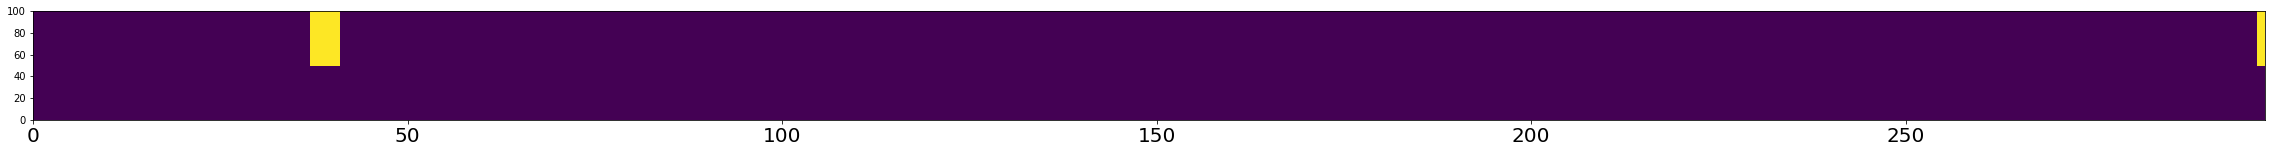

A,P,R:  0.9832214765100671 0.9832214765100671 1.0
Num frames:  (298, 5)
Accuracy:  0.9832214765100671
Person:  1


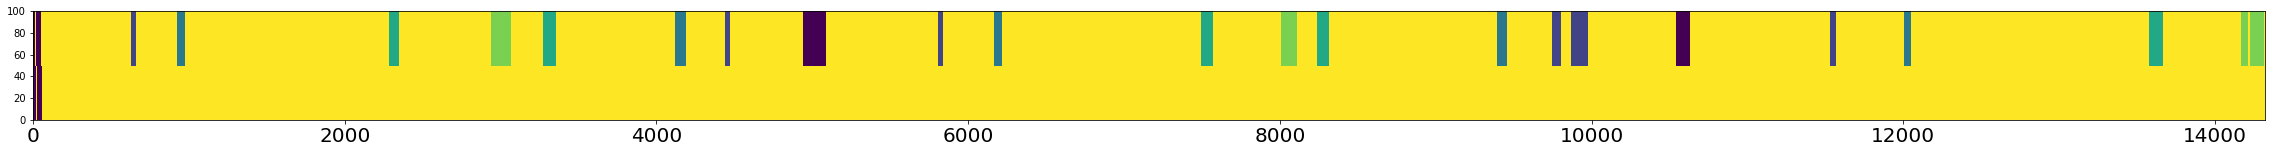

A,P,R:  0.8884854409608267 0.8653846153846154 0.027522935779816515
Num frames:  (52, 7)
Accuracy:  0.8884854409608267
Person:  2


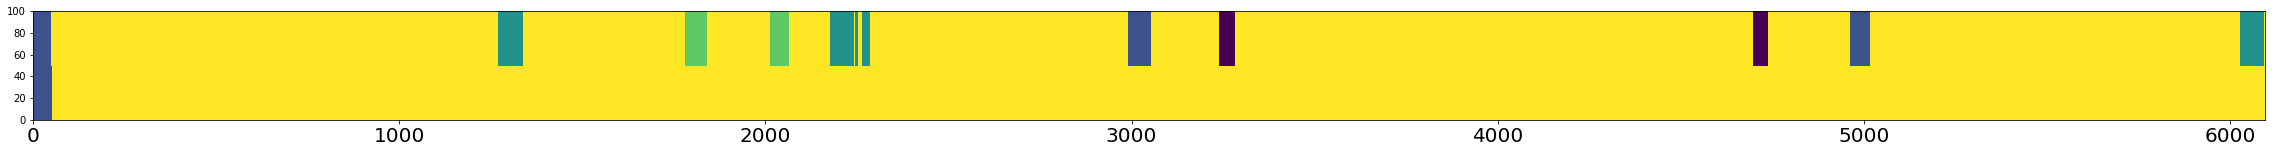

A,P,R:  0.9119094488188977 0.9423076923076923 0.08404802744425385
Num frames:  (52, 3)
Accuracy:  0.9119094488188977
Person:  3


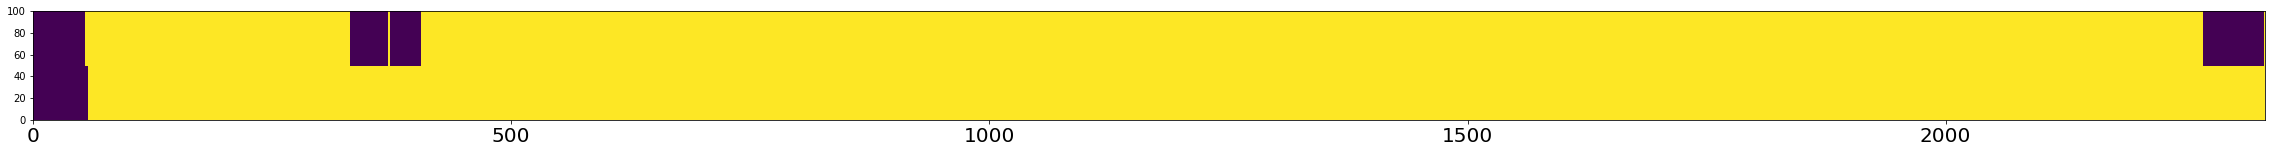

A,P,R:  0.9408740359897172 0.9482758620689655 0.2894736842105263
Num frames:  (58, 3)
Accuracy:  0.9408740359897172
Person:  4


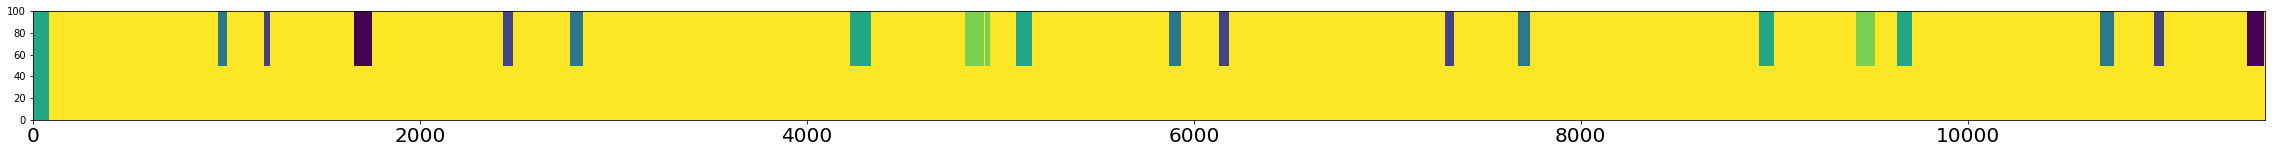

A,P,R:  0.886625639247638 0.9655172413793104 0.06047516198704104
Num frames:  (87, 3)
Accuracy:  0.886625639247638
Person:  5


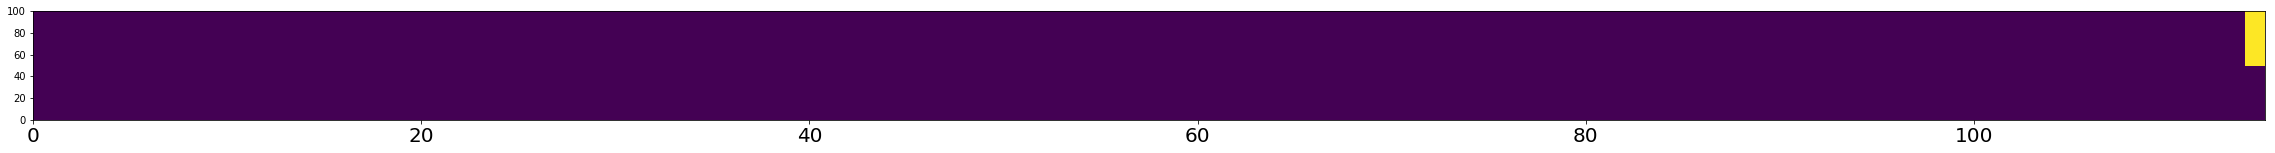

A,P,R:  0.991304347826087 0.991304347826087 1.0
Num frames:  (115, 1)
Accuracy:  0.991304347826087
Person:  6


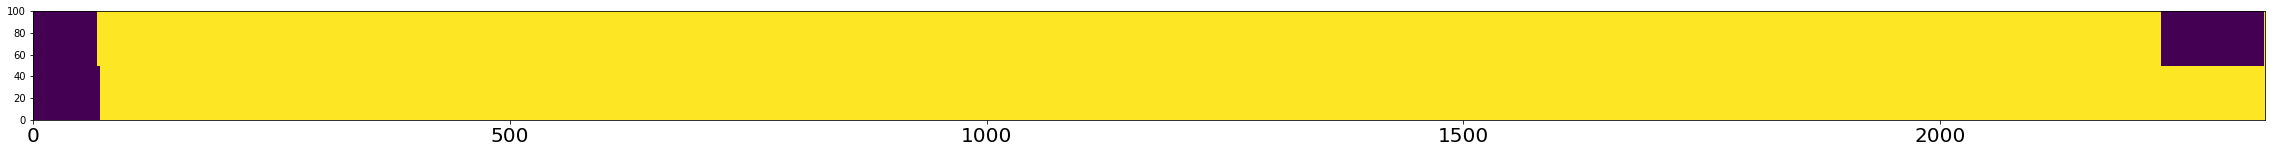

A,P,R:  0.9525843656557027 0.9577464788732394 0.38636363636363635
Num frames:  (71, 3)
Accuracy:  0.9525843656557027
Person:  7


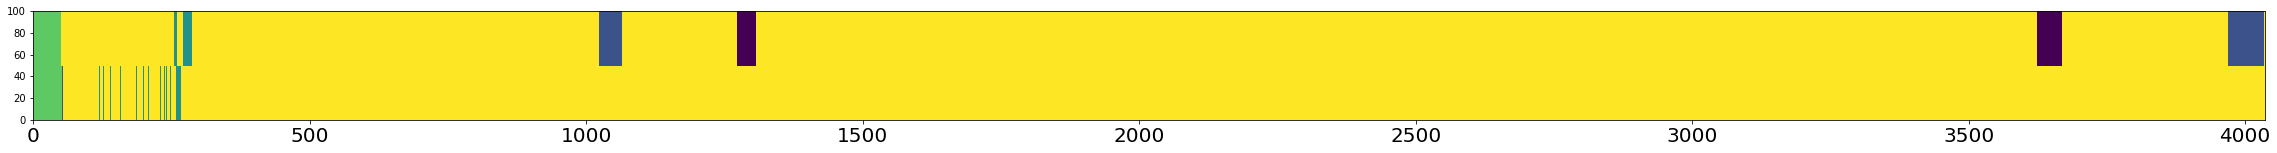

A,P,R:  0.9397918731417245 0.6091954022988506 0.20229007633587787
Num frames:  (87, 34)
Accuracy:  0.9397918731417245
Person:  8


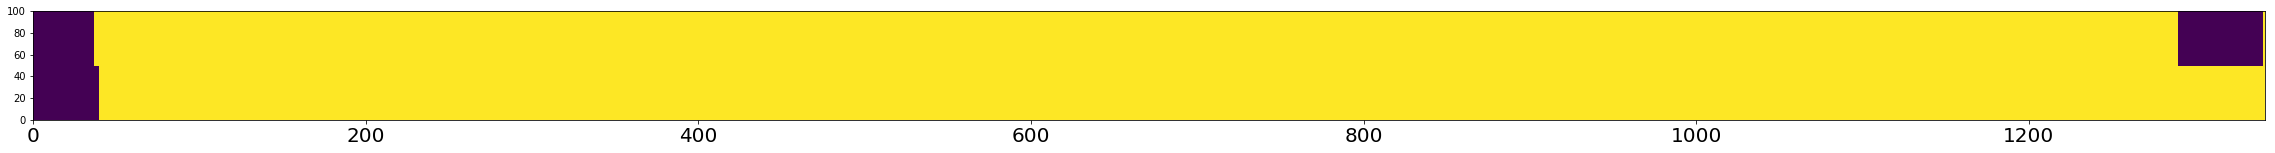

A,P,R:  0.9597615499254843 0.925 0.42045454545454547
Num frames:  (40, 3)
Accuracy:  0.9597615499254843
Person:  9


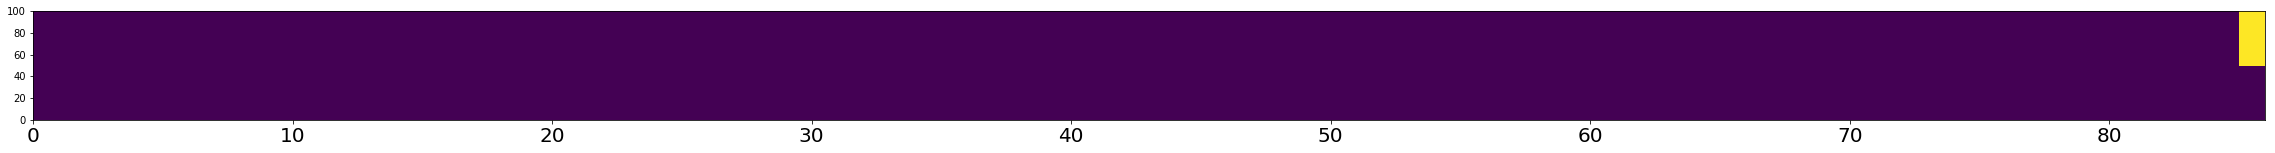

A,P,R:  0.9883720930232558 0.9883720930232558 1.0
Num frames:  (86, 1)
Accuracy:  0.9883720930232558
Person:  10


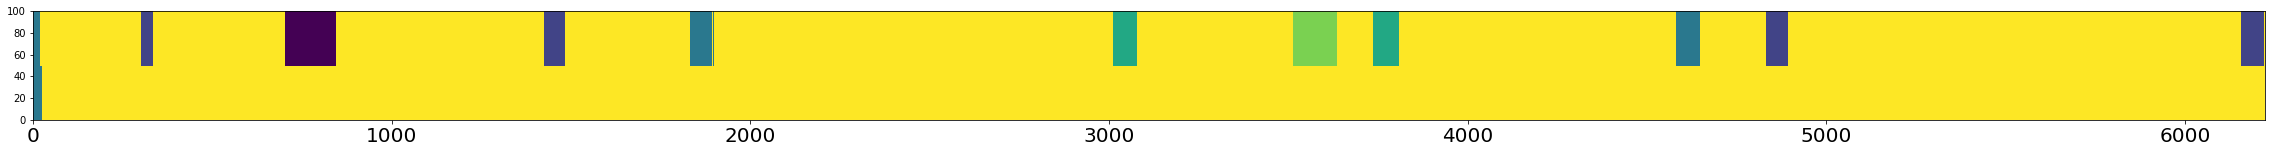

A,P,R:  0.8788365739996786 0.88 0.028460543337645538
Num frames:  (25, 3)
Accuracy:  0.8788365739996786
Person:  11


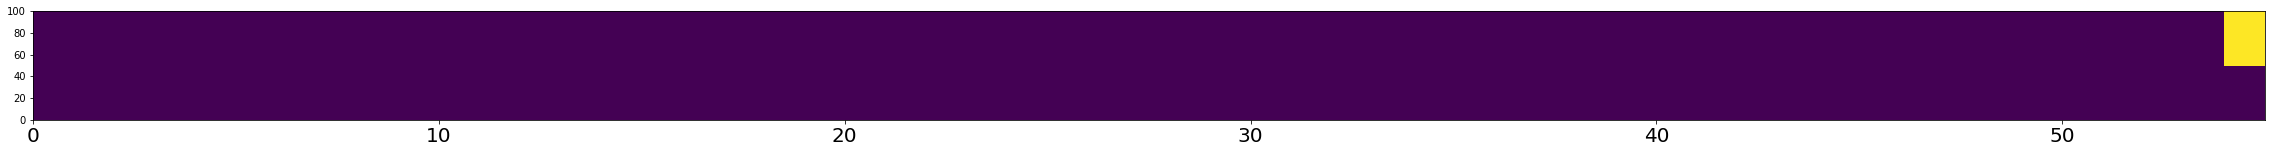

A,P,R:  0.9818181818181818 0.9818181818181818 1.0
Num frames:  (55, 1)
Accuracy:  0.9818181818181818
Person:  12


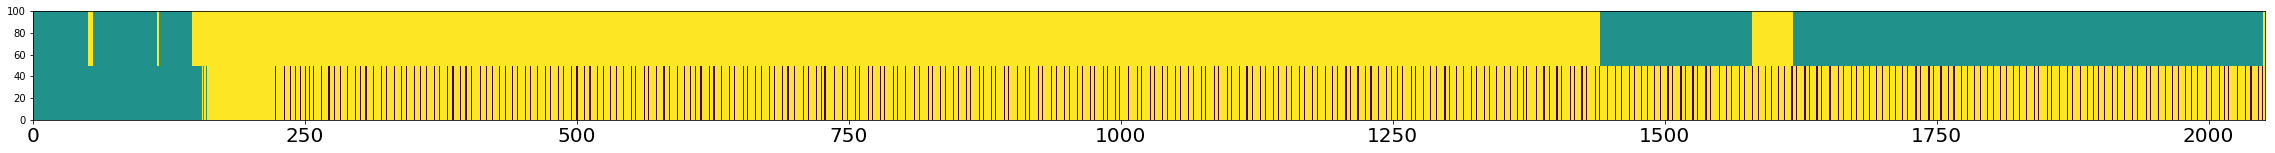

A,P,R:  0.6091617933723197 0.3023758099352052 0.19635343618513323
Num frames:  (463, 229)
Accuracy:  0.6091617933723197
Person:  13


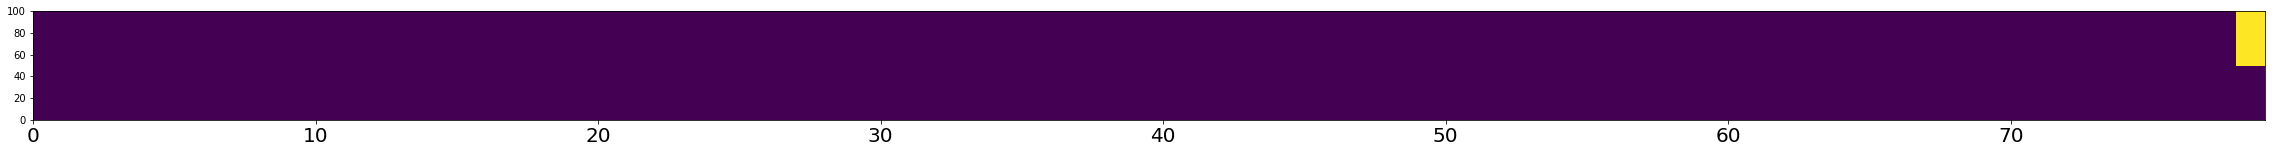

A,P,R:  0.9873417721518988 0.9873417721518988 1.0
Num frames:  (79, 1)
Accuracy:  0.9873417721518988
Person:  14


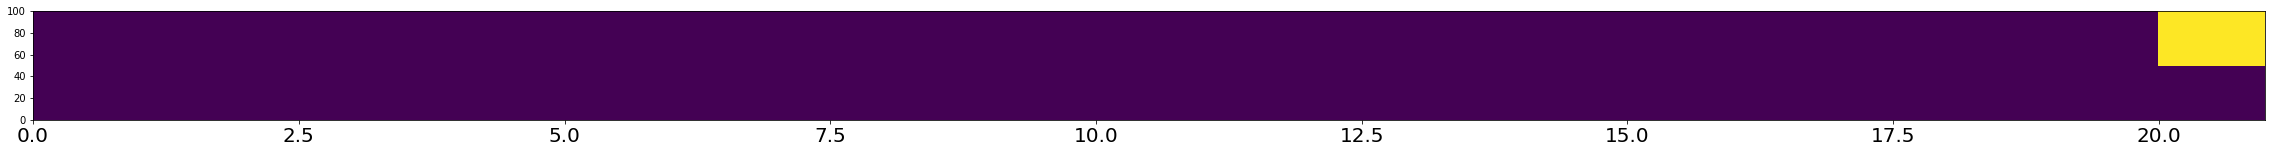

A,P,R:  0.9523809523809523 0.9523809523809523 1.0
Num frames:  (21, 1)
Accuracy:  0.9523809523809523
Person:  15


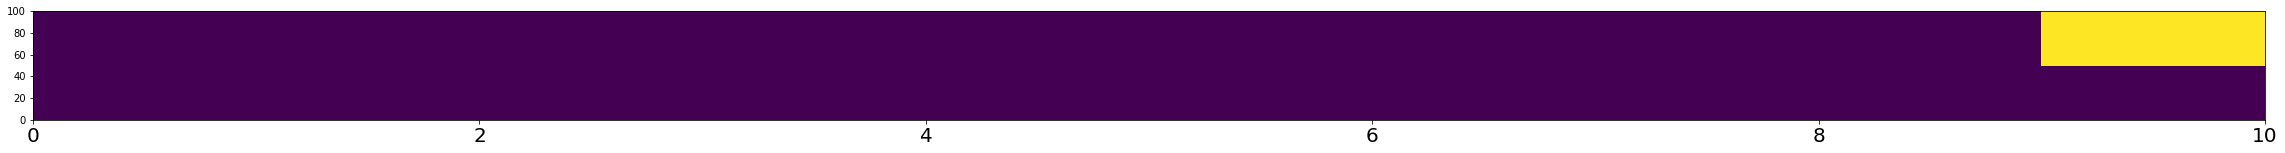

A,P,R:  0.9 0.9 1.0
Num frames:  (10, 1)
Accuracy:  0.9
Person:  16


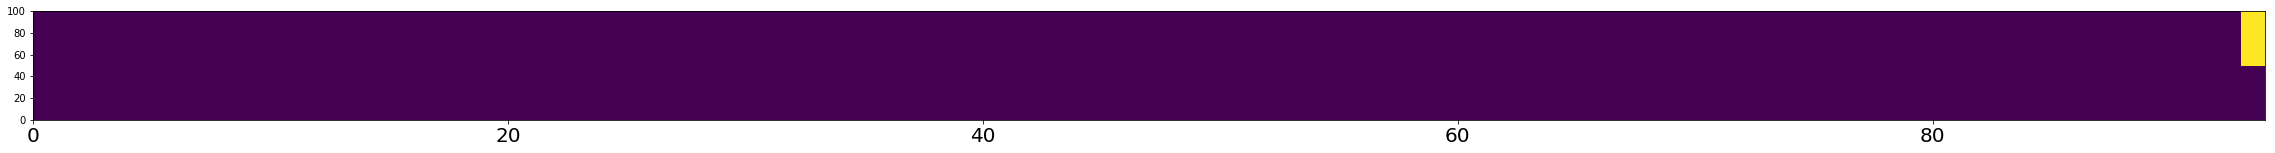

A,P,R:  0.9893617021276596 0.9893617021276596 1.0
Num frames:  (94, 1)
Accuracy:  0.9893617021276596
Person:  17


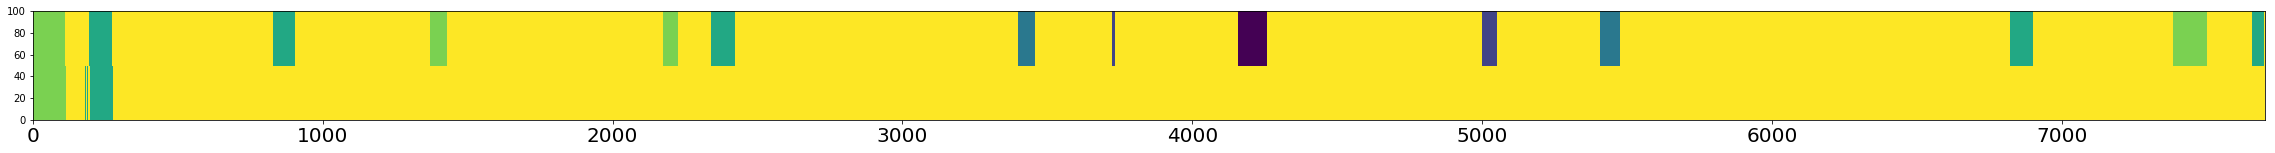

A,P,R:  0.8941833290054532 0.9545454545454546 0.1899497487437186
Num frames:  (198, 9)
Accuracy:  0.8941833290054532
Person:  18


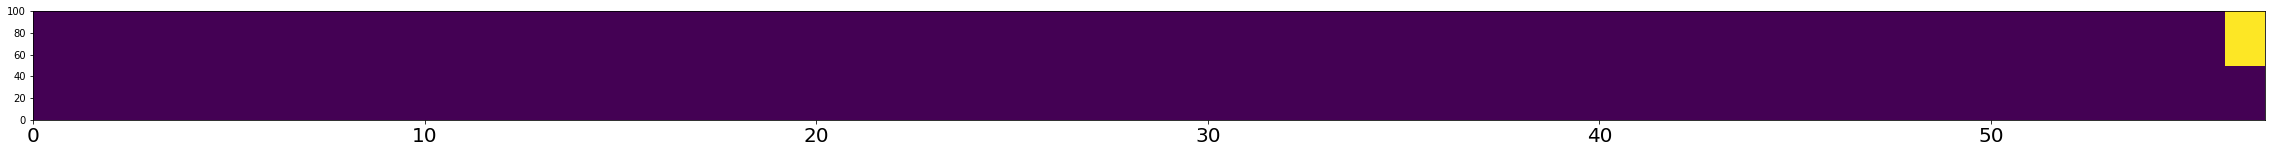

A,P,R:  0.9824561403508771 0.9824561403508771 1.0
Num frames:  (57, 1)
Accuracy:  0.9824561403508771
Person:  19


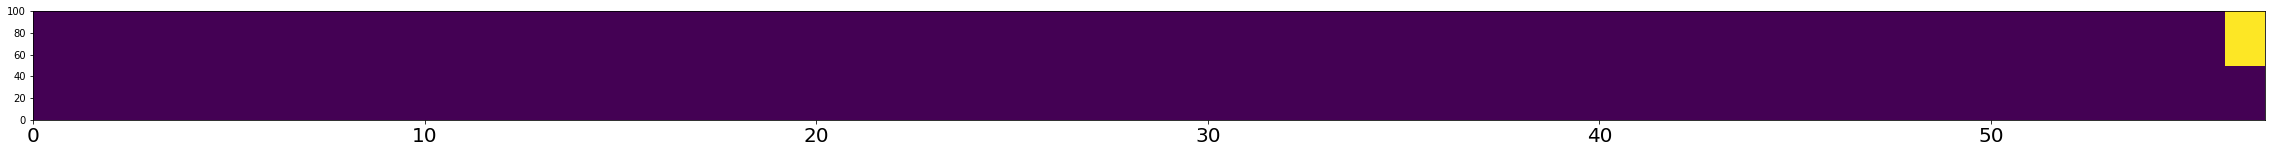

A,P,R:  0.9824561403508771 0.9824561403508771 1.0
Num frames:  (57, 1)
Accuracy:  0.9824561403508771
Person:  20


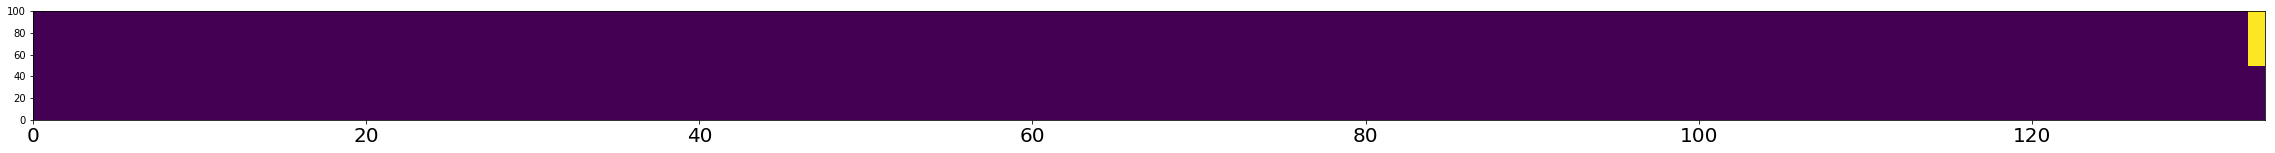

A,P,R:  0.9925373134328358 0.9925373134328358 1.0
Num frames:  (134, 1)
Accuracy:  0.9925373134328358
Person:  21


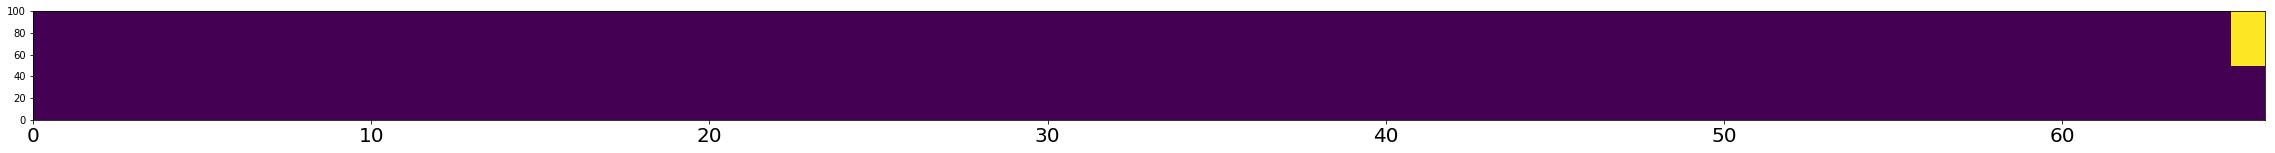

A,P,R:  0.9848484848484849 0.9848484848484849 1.0
Num frames:  (66, 1)
Accuracy:  0.9848484848484849
Person:  22


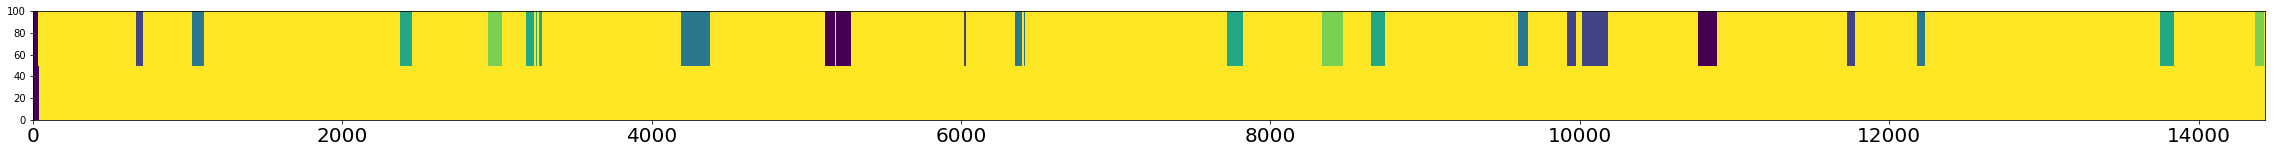

A,P,R:  0.8769230769230769 0.9047619047619048 0.020994475138121547
Num frames:  (42, 4)
Accuracy:  0.8769230769230769
Person:  23


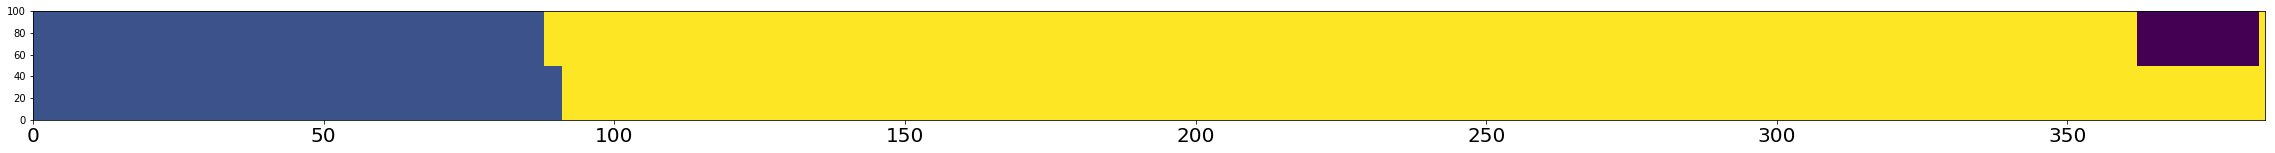

A,P,R:  0.9375 0.967032967032967 0.8073394495412844
Num frames:  (91, 3)
Accuracy:  0.9375
0.9330306554942375
Average A,P,R,F, ttr 0.9330306554942375 0.9140934180587243 0.6130719050217334 17.25 [3, 47, 23, 7, 41, 1, 3, 13, 3, 1, 23, 1, 9, 1, 1, 1, 1, 27, 1, 1, 1, 1, 57, 3]
2658


In [17]:
policy_net.eval()
req_inc = 0
_,acc = test_func(pTest,iloc='fix',eloc='last', fixLoc=25, isdebug=0, req_inc=req_inc)
tr_acc = 0
A,P,R,F, ttr = [],[],[],[],[]
nfr = []
for i in range(len(acc)):
    print ('Person: ',i)
    gt = np.array([d[0] for d in acc[i]])
    pr = np.array([d[1] for d in acc[i]])
    g = gt #t[gt != num_camera-1]
    p = pr #r[gt != num_camera-1]
    
    # plot transitions
    afc.plot_color_transitions(p,g)
    # MCTA and number of frames
    if req_inc == 1:
        ac,pr,re,fr,tr = afc.compute_APRF_one_person_sct_ict(p,g)
    else:
        ac,pr,re,fr,tr = afc.compute_APRF_one_person_sct_ict(p,g)
    A.append(ac)
    P.append(pr)
    R.append(re)
    F.append(fr)
    ttr.append(tr)
    print ('A,P,R: ', ac,pr,re)
    f = afc.compute_num_frames(p,g)
    nfr.append(f)
    print ('Num frames: ', f)
    # Accuracy
    tacc = np.sum(g==p, dtype=np.float)/g.shape[0]
    tr_acc += tacc
    print ('Accuracy: ',tacc)
print (tr_acc/len(A))
print ('Average A,P,R,F, ttr', np.mean(A),np.mean(P),np.mean(R),np.mean(F), ttr)
print (np.sum(nfr))

In [ ]:
tr_acc = 0
for i in range(5):
    print ('Person: ',i)
    g = np.array([d[0] for d in acc[i]])
    p = np.array([d[1] for d in acc[i]])
    print (g)
    print (p)
    tr_acc += np.sum(g==p, dtype=np.float)/g.shape[0]
tr_acc/5

In [ ]:
np.log10(1000)

In [ ]:
mcta = []
nfr = []
for i in range(5):
    g = np.array([d[0] for d in acc[i]])
    p = np.array([d[1] for d in acc[i]])
    mcta.append(afc.compute_MCTA(p,g))
    nfr.append(afc.compute_num_frames(p,g))
print (np.mean(mcta))
print (np.sum(nfr))

### Test function

In [ ]:
backup_fname = '/media/win/HRLhkl/Q_CamSel_3L_l4_st200_db3_1tCont_2'
hkl.dump([[episode_reward, running_reward]], backup_fname+'_variables.hkl')

In [ ]:
import numpy as np
1/np.log(10)

In [ ]:
pp = 1
np.max(pTest[pp][1:,1] - pTest[pp][0:-1,1])